In [21]:
from typing import Annotated, Literal, TypedDict

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph, MessagesState
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.prebuilt import create_react_agent
from langchain_core.prompts import ChatPromptTemplate
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt.chat_agent_executor import AgentState
from pydantic import BaseModel
from typing import Dict, List, Any
import json
import base64
import pprint


@tool
def country_prediction(query: str):
    """Predicts the country where the photo was taken."""
    return "France"


tools = [country_prediction]

model = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

image = open("test.jpg", "rb").read()
image_data = base64.b64encode(image).decode("utf-8")
text = f"""
Describe the picture.
Given the current state of the analysis and the given photo reason about the location of a photo.
Try to get as many accurate and relevant information as possible.
"""
human_message = HumanMessage(
    content=[
        {"type": "text", "text": text},
        {"type": "image_url", "image_url": {"url":  f"data:image/jpeg;base64,{image_data}"}},
    ],
)




In [22]:

agent_executor = create_react_agent(model, tools)


from pydantic import BaseModel, Field

class Location(BaseModel):
    """Location of an photo with reasoning."""

    latitude: str = Field(description="The latitude of the location")
    longitude: str = Field(description="The longitude of the location")
    reasoning: str = Field(description="Reasoning about the location of the photo")


def call_model(state: MessagesState):
    response = agent_executor.invoke(state)
    return {"messages": [response]}

def generate_final_coordinates(state: MessagesState):
    messages = state['messages']
    structured_model = model.with_structured_output(Location)
    response = structured_model.invoke(messages)
    return {"messages": [str(response.model_dump_json())]}


workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("final_location", generate_final_coordinates)

workflow.add_edge(START, "agent")
workflow.add_edge("agent", "final_location")
workflow.add_edge("final_location", END)




app = workflow.compile()

final_state = app.invoke({"messages": [human_message]})
response = json.loads(final_state["messages"][-1].content)
print(response)

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


ValueError: Message dict must contain 'role' and 'content' keys, got {'messages': [HumanMessage(content=[{'type': 'text', 'text': '\nDescribe the picture.\nGiven the current state of the analysis and the given photo reason about the location of a photo.\nTry to get as many accurate and relevant information as possible.\n'}, {'type': 'image_url', 'image_url': {'url': 'data:image/jpeg;base64,/9j/2wBDAAQDAwQDAwQEAwQFBAQFBgoHBgYGBg0JCggKDw0QEA8NDw4RExgUERIXEg4PFRwVFxkZGxsbEBQdHx0aHxgaGxr/2wBDAQQFBQYFBgwHBwwaEQ8RGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhr/wAARCAU0AyADASIAAhEBAxEB/8QAHQAAAwACAwEBAAAAAAAAAAAAAAECAwYEBQcICf/EAFgQAAIBAwMCBAMGAwUEBwQBFQECAwAEEQUSIQYxBxMiQRRRYRUjMnGBkQhCoRZSscHwJDNi0RclQ3KC4fEYJjSiskRTktM1VGVzo8LUJ1VjdIOEhbPSk//EABsBAQEAAwEBAQAAAAAAAAAAAAABAgMEBQYH/8QANxEAAgECAwQJAwQDAQEAAwAAAAECAxESITEEQVHwBRMiYXGBkaGxwdHhFDJS8RUjQjNiJKLS/9oADAMBAAIRAxEAPwD5pp0fWivqDwQp0vzp/wCNAA4FOlRQDooooAxTpU6EDt7UUU6AVOgGg0AUUU6AX9KPaiigCijFHtQBSp96PagEKVOg0Av0pY+lPiigEak9qqlihSaKrHypYoCaVVigigIoqsUsUBP5ike1XiligJoqsUsUKKj3qsUY+dCEUVWKMUBIoqsUYoCaKrFGKFJoqsUY5oCcUf64qsUYoQVGKeKeKAnFGKrFGKAnH6UVW2jFATx8hRVYoxQpOPpTxTxRjmhBUU8UYoUWKX6VWKWKAXtR+n9arHNFUhPFFPHvQBUAqKZFGKoFRToxzQE0U6KAVHtTpUAqKf1o/WgF+dPGaKVAFFP9aKAVFOigFRToNAGPpSp0VAKinRQCop+9HagFRTo9qAVFOlQBRRRQBRRRQHJo/OnSoQdFFOgCjFFFAFOlToAooooApijFFAAop0UAvyp0UUAe3vRRRQC/rRTpUAUYp0fOgJxTNGM0UAjxSqjSNAKliq/rSoURpVXFLFATiin2pYqgVI1Zpf0oCaWKqigJxR/jTxRVAsUY/enijFQE0VXelVAqAKqlioBUU6YoCcUVVGKAnHeiqoxQE08Y/KmB+1GKAVGM06MUAvnRTxToCaKqigJp4+madGKAVGKdKgFRVYpUAvz4pVVGKAnNFVSNAKlVY+dKqBUU6KAVKqpVALFFOlQBSp0VQKjFOigFTooqAVP3oAooA/OlToxQBSp0UAUsU6KAX5UflTox8qAWKKf+VFAL2op0GgF+tFFPGKAWKKfvSoDk0H+lFH6VCDopUUA6dKnQBRRRigCnSp0AUUU6AKKKKABRQKdAFH50UUAqKKKABR3oooQMUUUY4oUVFH5mj8qAVFPFKgFRTpVQKinRQoqRpmlVIFKnRQojRRij86AKVOihA/pSp0flQCooxRQBRR+VPFCio96KKECiiihQxRTooAxS/OniihAxRRRQBR7U6VAFHNFFChRR3p0AsUUf4UUAqMUUc0ILFOiihRUjTpUAqdFFALFAp0sUAUqeKCKAVFFGKABSp4o/OgCijFFAHFHtQKP86AKKMUUAqdFHzqAX50U6KoF86dFFQC/OinRQCop0cUAqKKMUAGl/WmaDQHI7iiinUIFFFFUD/pRRRUAUUCnQBRRRQBinRR/SgDvRR+dOgFxTo79qKABRTooBUqdFUCoop1AFKn3pUAUUUVQKlVfOkRQCoNOigJ96MU6KoFilTNHvQCop0qAWKKdFUCop4oxQCpVVKgFRinRigFR7UU8c0AqPenij3oBUU6KAVMUUVAGKKKKoFTp+/FKgCiinQCxRToxQCxRTpUAUUUfWgFQRT96PlQE0U/1ooBUsVWKWKAWKKeKKAVFFFQCop0qpRCimRRQC7UU6KAVFPFFQCop0UIKiniihRUU6KAXvRRRQgUqdFCiop4ooApU6KAVFOigFRij50UBnFOgUxUIKj2op0AUUU6AVOiigCigU6gCij86KoCn+VFFCBRR9aKAYooxRUAqMU6VUBRRRQB3oo/OigFR+tOg0KKj8qKeKAminSoBYop+1GKoEaX5VVKgFRTo/OqCaKeP0oxzVAqKdFQCop0qpApU+1FQoUflRiigFToooBUU6KEClToxQoUe9HtToBCinSoQKKPnToUVFOj2oBUe1OigJo+dOigF+feinSoBGin/rtRigFRTxSxQCop0UAvypVVKgFRTxRigFRTIoxQCpVVKgFTp4pUAsU6MUYoAop0dqAminiigFR+lPFGKAVGKeKWPnQCop0YqAVFOigFR3p0YoUWKVVS+lAZ6KKdQgUD+tHaigCmKBRQAKdFFAAooH+dFAFFOjNCBiiiigCij9adAFFAooAxRTpfnQCop0VQKnRRUAUjT7UUAjx3ooxRQBSp0qoCl3p0d6FFSp0VQGPlSp4ooCTRToqkClTo/OoAx+dKnRVAsc0qqlQAKKdFAKin+lGKFAKWIUAsT7AZPb5UAFk3KCQDjI59if8ATXd9OCJNSgnWaSJoLdzK0eNyb96M2CRlRGx3FckZBAPOO6sunpdL0q0v7DVNDuriC3lgmSyuiWijdZ45mnJUEDZKUEi7sHC4wu6uOptVOnJxbzOiGzzqRxJZGkij/CuTcW9tFa2EtpcPN8RC7yRyJtaAiQhUPzJTaxPb1cVx66k1JXRztNOzF3op0VSCop+1FUoqMU6KEFR+lP3pUAUU/aioUVFGKMUIKinQaAn+lOjFFCiFGKdFUgqKdKhRUEU8fKj8qgFS/OqxS7VQKnRRQCxRTxRihBUU6PzoBd/wD1op0VAKiniihRUfpToxigFSqsUYoCaKdGKAVFOigFRTooCcUU6KAVFPFKoDPRRRQBToooQKKdLPegHRRTqAVFPtRVKFFFFCDopU8VAFFFFAFOj3o7UAUvyp0fnVAveinRQCooooAop0qAKVVSoBflRTooCaPyqqVUoqKYpUAUjVUjVIKlVUqAKKKKAKX9adFUgqKf5Ue9AKinRQoqKdFQBqzxw6cs2nxkyxWZNwZxuQz/AHjYA77SmwD6hu1e9eJHg7pnSnTcmp6JNrMc0Ou22mussyzLcwyaR8VLO0ajPnAs2TkDygFAyOPALsuLS58skM0DpxxkFSCPyNfSvjjr+nan4eapBpUquV6x01n22MtuJITorRE72wJFLxyLgfIt+F1J8ja6V6sM9Wejs9TDCXcfOUhj2xrE6ShAys6Z2udzepSe4K7ece1RTNKvWSPPYqPenRVIKinRQCop0UAqKdFAL86KdFAKlinQRQB+VLFOigFRTNFASRQadFAKj3p0UAqKKdCk0U6KEFRTooBUU6KAVFMUd6AVGPpTooBUU8UUBNOnSxQC7UU6KAVFOljnmoApVVLFCiNP3oo/xoBY/wBYoxT/ACo7UBNFVilQGWnRRUIFFFOgCigUxQCp0UUAUdqKftQCp0UUAUUe1FAFFFOgCiiioAooo5qgKKKKAKVOj9KAKMc0e1H50AUUUUAqKKKAKKKKyCFRRToBUqrFTigCij/CnQgqP8KPrTNAKij3oqgVHvTo+XtQC96Kf+NFALFOin3oDj3v/wAFc/8A4pv8K+qv4illHhte+c05/wDfjTRiV0IyNCHYL2Pbv7ADuDXyte//AAVz/wDim/wr6q/iKiEfhpMVUL/766apxamInGifM9+/b65/mrztp/8Aal4nXQ/86ngfLhpUzS/KvROQKVOigFigU/yo/SgFRTpVChRTo/SgFRRRQBQPpRRQB8qKKPehBU6KKAVFFHvVAUvanRQCoNOihRUqqlQB/jRRiihBUU/lRQCop0CgFRTooApU6KAVBp0VAKinSoUPeiiigFRT/OigFR3oxR70AqPlToqAVFFFCmWnR9KKhAoop0AqdFHtQXCiinQB+dFH0ooAooooAp0UUAUUUYoAp0qeKAKKKKAKO1FGKAKVOihBUU6XahR0UUVQGP0pU6VUBRRRQCopmlQAaVOigFRToqkFRTNB/wAKAVFFH5VSBS96dLGaAKdFMfnQoqP6UUUBjuYzLayqvdwEzjsW4FfVP8SU9tH0Bc2Sz25uo+tLGQwpctI5jGk+UZNjc7N527xkFvTngV88dN3D2i3MywwhBdWKm9mjLLYEySBZScFQDypDAg54wQCN16fGkWuhy6dp3VK6nYvaGNpxbyMRH57kjyW9YaJCCUQkcMVLg8+LtlbDXhl+1/J6Oz08VKWep5acgkHIIOMYxg0qzXefjLoNjcLiUHByPxt2rDXsLM84X1op/KiqBUCjFOgFiijFFAFFFPHyoBUUUUKFFHtRjNQgfpR7UdqKAVOj86MVQI0UGj3oBUd+KdHyqgVOj50frUAqKKft8qoFR+VPil7UIFFFGKAKKdICoUKKCKMVSBRTpexqFCiiigF7UGnR3oBUCinQE0e1OihRUe+KdKoApVVKgFRToxQGSiinUAUUUUAUwKKKAKKO1P8AOgDFGKKKAKKKKAKf9KKKAP0oooqAKKKKpAoop1AL3oxTooBUU6KAWeaVVS/KqAooooUKKdKqQVOiihQxzSp/670qECkRx2p96P61QLH0opiiqBdqMU6KEEf60GiigFjjkUU6KoDFFFFQBj5Ue9GKKA7DRZrv7RtrSwKMb64hhe3lfbFc+v0xycj0Et8x7EEEAjeNBafTek5JZrSGS2sbVvjobrzAJcXKgoxJUhzhlJxvx22kDOn6EYWWa3lsrq9nuLqzS1Fq3rWUO5wU/nDLuGO44Izja3pEcV3qGk6lBrvUUGvzGw2Nqi6gLmKKNrlkikMsas+zbgHdhlDNuBCnHgbdbr1dcD1dmv1TPIp2ElxO6HcryyMpPuCxIP7Gorkahn7Rvww2kXUwIGOMSMMccftxXHPaveWh5bClTo/WqA5/0KX+hRQKECiij60AUfnQaMcVChRRR70AUGiigFig06PzoBUUfrT96AR+tLFMUYqkF7UU6MUAUsc08UUAsZop4ooBUYp+1FALFFOigFijvT/13ooBUYp/0ooBUY+dOjFALt9KKdLvQBSxTpUAUUUVChSp0UAsYop/40UAsUqdFQBSp4oxihS6PainUAU6KKAKKKKAMUwKKKAKKdFAFFFFAAooxRihAoop0AqKdH50AqKdFChRSp0IFFFFAKinSoAoo/OigCinzRVAsfOj9KKKAKVOjH61QFI08cUGqQVFOigFiinilVAUUGihBU6KKAKMUU/yoBUuP61ybKyuNSu0tbGF7idwzbIxkhVUszfkFViT9K7u5Rr3QraxsZJrsWN5cSr90FTypETy2Vv5t3ltnngkY71zVdojSlGL3+ys8/ax006EqsXJbtO95Ze4+lba7uxeWVrqK2Ed8FV127jI0YkePHyYOPTjByeCBmt2g0XTdN0WDT9PnMl1HY3cT2Qu9z3Did9y7sGPzfujhTxuPpJNarpEttpN3ZafrT29xbCRlm+HLhhvZQ6q+zDsFcZTPvkjArdYWt7+Kayk+Iu4LmJltrgXW5OZmJcsY0JGdx5IBJw30+Y22s5VnJPI9rZqSVNJrM8l1OJ4dRug7b98ryq5UoWVnYhtp5Un5HkVx3hkjSF5EKrPGZIif513MmR9NyMPzBrceotI1/qLqa1a5iae+vltrSOWYhBNIECjBHp5yBjJ9uam86Zu9YTpOy06FBqE+iwrFCzrGJnNzdZwzEAsdjEY5c8DJr6GltdOUItyXf3HkT2eanJJPuNNwQASDg9uO9Kr8+WeGBHKNBCJVhZVxkmVt3OTuGR3wO+McZqcc11wkprEjnnBwdmKiij86zMAooxR70AqMfpTo9qAMUqdH6UAqKeKVAFFFFAFFH+dFAFFGKMUAUUUfSgDFKqpVQKnQaMUIFFGKeKAVFOjFATTp0UAsUUUYoBUU8UUAqMU6KgFS+lOihRUUYooA9uaVMiioBUf4U/zoxwaFFSx2p/OigF/hRT7/lS+dAZKKfyoxWJQFFHvzRQDopU6pB0Ue9FAFFFFAFFFP5VAKniiigCiiigCiiihA/OiinQoqKKKAdKiigCiinQgqKKKpQooooA/OjFFFUCo4p0qoACinS4oQf0pU6KpBf40UU8UBJ9qdFFUBRiiigCs0UUcsNwWnEUyBPKU4AfLYbk9sDn61ioqMqNjTqToqxtray1qS80+7SSK6lhsrQajHHJ5G3dlyMZJViOSrA4GMV6BdWGp6lYXmt9F2Gia5omstcPc6hBgSJFIyMXaJWUiZXklXBX05woJ258ltekdF1p7W1vNZ03T9Wu7mZ1tJ/ifMkD24MR+4ikIBfLEtjaq9jnNdZ1/0Xd+HvVFtqPT10NRtWhtry0vrGNZo1DqCo5GxsMpHGeRyATXxtbOrKOLO71Pp6aSpqSWVl3HpFzZXuipHZWNvHpP2ZPcXjLcaZKoCOhcAxlSc42qzcH1fnWyv0zfzaN09rNtrMeq6XfWsMUeqecSxkbHxETxFseh5WRs4wDuJAII8c/6Q+vbWCWa51jU4bi4EbyRQ2MMKldoCqFKHgJt7Dbye/euVpPXXX9zMltdalqkFrfTJGR8LDGJd7hWYr5QJyVGSMfh78CuaUJNZ258japJaHovUGha1pj6YLCzvYYYrZUt5tMnxJNKTDHtHlOQjcDaDkEZIJ4rX+oNb0HRrvT7Lq+8u/MsrWGa1hsIIrqSNvOlnAk2ybRhp3A5UkjcVOcnTOt+o+vGLaN1FPHfRajbpDutNJixJ6x6d+0EPuVMkH+7z2qdI6R0e40Y3XV2sWelXLxSLbiaOaNU+7xHI4t43bYkihGG3+cEHjnOMZU12n6GLmp/tR6z1lpOi6v4UdK9Y6NFetLdazPpNvfTKIYJ7ONZ9i+WWJVlMPGecbvnXlXsDzzW7za5pd54UW3Seg2cS23TeqfGwatJqJP2nHJJNE6QxMqlgkk6nI52ckKdwrScV9L0c31GfFnh7ckq2QqKKfavTOEVKmaKAVH706XtzQDpUd6KgD3op0qoDFKq/OigEKKKdQCoo4+lFUgUU6KAVGKdFCCxRToxQoqKdFUgsU6KKFFRToxQgqKfFFAL3oNFOhRUqqlUAqKf+NKgFijtmnRQosUqfFBqAVHanR+dAKkOadFAKin70fKoCqdKnWJkFFFOgCiiiqQdFFOgFxToooAooooA+dFPNFAKniiigFRTpVAOiiigFTo/Oj2oBU6KKECiiiqApe1OgUAqPzoNIHmqBiiinQC4p0UVQKiiihAoop1QKj2p0qpA/SiiihQo/KnSoQKzwWc12s7Qp91CgeaRmCrGpOBkn3J4A7k9hURuqMd4yjAq2BkjPuPqKi7vo9PtLq3uJFBkUXAUZAkWJXwd4/CuXUcAsd2Bg5rTWqdVBy4G6lDHNI7DS5dBsdYh1S9ijhtromKa9kllmkWV7YsyJCndQsgUY7Y9XtXocGuQJo8dt8RqrQM6TBE0a7m/kB3ZH4c7sHB5xyBitF8OdMnu+qtD1e6dGTTrg/CWPwnxMlwzLsjjSAclQqFvcYAOTgmvVeoPB/Q+p9VudR1Ox6xhmuUjjcWOlSwwoEwu5FVMAlFBJ5yS3vXw+0TipLFvPqqFNyi8O46BdasvipJpJdW82KEZSPTrtot+xUx25ALd/mM04tXtI5bYtNq42249T6ZcygEO7cgH8QznnnAAxxXc33hBo+qzS3N9Z9ZwXE1hFbMkGnzov3PlRxsAFPrKRqzN7ksccmg+Eeig6axt+tYhpccsFs6aZOpkizJIrykJ6nDyMATggBQRxXP1lPidPVTOk1Pqayu7iGZpb63mjkM2230e5jhQhx6dg/lJBHywMCuHd6hodnHqceo31xO873EEjXdpeRgr5fqUsfSkWSjbsDkDDY3Z3nqPwU6Zhj0/Q1Tri9tLE+eZ5NMuRcGWcKZo5HEYLKuyMqCONzcnJqdN6LttF0TUdJ0uTW9Hh1TMsmqarocr/BySQ4aQylQVRSiZBOACxPGaylUhG6uYwpymk9zPLtT6Xax0q3t7BAZDfTTfC5C+VvVcRxA4yDjdxwSxIHOK1YerGAST2AFbZFfarottpGmdYpGrzkXNla/BrbywRJIQPh8HaTuD4hwA6ojRkk7Dr3meVm7RmMl1ultnKlfumLYl559QyB+p9hX1XRtbFTcL3sfO7dRcZ4+Jw+447UUAY49hTr2TyxUUzSoBfpRTooBDvRTpUKH5UcGnSoQKKfzpGgCiimaAVFFOqBUU6KEDFFHtRQBRR9aPegCinRQCop0UAqO1FOgFRRRQBSp0UKKinRQgqVP50UAqWKqlUKLFGKdKgF+VFOihRUqZoqAVBHz5p0UBVFFArEo6KKKAKeKKKAKdHvS9qAdFFFAFFOigD3ooooAoooxQgYooooAooFFChRRRUIFFFFUBR+dOlQBRinSqgDz9KWKftRigD35ooxRVAdu1FHFFAFKnRVIFFFH50AY96KKKpAoxRRQDpU6KAX51yrR9GSDUF1mCaW7ktk+DZkzbKVnR280jLD8K4xwfUvciuNx7V1OvAFbNZI98cjOucn0sChBxnnGc4rj21XoPy+Tp2Z4aqfj8HGsuoLm+1CK6tNRu7G0uriNLqdDskMcbqQI1BGBg479kGTWz9S22qL1hqEWna3rcelnypIml1SVD95GrlQqk5ALEDt2rVLGyNzdCJsJGFzKxGdqZ7KP14HtW9dS6ZHp/UF3bxXcs8dusSxtMwLkeWpAJAAPevmpRSaO+deaeQ7SN4g63Ova3MzxKH/6zuMD1KT/OT2XHGPlXbx3cW1AvmsyDCsdQu8ge2fvsE8/KtdC+VIVZyCQDntnPOK7JVMcULsNoZNzZB7/LFamlwNPWVd8mctrOe+klZ9Z12Njj1rrlySTgD3c88U9Pj6lsIbttM6jubK402QTadrJ1G4abeuCscsDM0TLyykgA4PO4cVULMsMe7gnO4Dj9K51nbvNo11LHuDLMhPI4yPf+grFpW0LCtVTupM3DpTq7Ter76z6a6u0mxt9ftbqCcaUGje2uJ0IYTaexO1JM53WjeiQE7DyVPjN3O1zOXZy4VVRSVK4UDgBT+H8vbNbRfSSaf01q1/HZGaO3tmndmkMbxhcoWRlwygmbGQRklR8617WNn2xf+Qixx+ediK24KuBgA++PnXp9E0owqza4GzbNplXoxxLNM4NFOivpDyRGiijiqBUU6KgFRinR/WqUVFP9KKEFRjinRjioQWPnRToxQoqKeKKpBf1p0fKigCiinjNAID9aPan3xRihBUe9OlQBToxRigFinRRQoqMU/wA6PahBUY/SnijFCk0U6KAVKnRQC96KdLtQCop0qhQxSNOigFj50qdFALFGKfaihR4p0s0VgUdH50UflQDFBoooAFOlToAp0qdCBSxTo96FCiij9KAKKdKhAooooAp0sU/yoBUCnRQCop0d6AKKKKpAooooAxRinR70KTiinRVIFFKn9aoCiijigFiniij3qgKVP2ooQMUYo/Onj5UAqKePnR/SgFiuFq8akaSzb8PcTLkdshYyP9flXOrganw1k5bCrPgA/MjP/wCbXLtSvRkbqNsaOt0W1k1K+gtI5lt5mYosjDtkf498V6R1JbWU+syTwEvczWto6rI5Pmy/DpvzjAHrDYHueK850eWO06jtXuG2RR3KSMTwAAwyf863bqfWtDh1e9i0ya3WRojMqKXZYpACzo6n8Pfcoxtzkdq+ZqXvkdjzdjtdXsbS11ZYZsxxGGJoiXI3uVyysfZc9z/L2/LkXUay2mlSsPhy0BSfap/3oY8LyRuxjPsBzWvaj1bpesapFJaXqSQeXBb2+VZSJinKtj+Qtk+5HtjmpTq3T7rTLNpbyFRYxMs4UMGJZwVxlcDvjucDHzrmSlZXNkoZtJG0CyWbSLC5i95J1dsk5VBkce5x8u9bD0nY/H9J3bBNxkdNhzj5Af15rorDWdPntUtWvSZ4zcRxQJbtu5ViwXj1YXnHfHOa2ToKcDSLnTodnxsNqh8nzQQFK8Oeexzn+pxWtt2ZlhjHM6bq+1B6W1qFN3k31k/ljOS0MDHHH/FICx+e0fKvOth+8klxwcHHAZ/kPoO/7fOvSeprm3udJ1uSOYQ2NvYCyglYcBOFLn8yxb/xV55qQRL6eKBWSGFyiK5Bb6kkcEk5/pXu9FayXgc1dWpxOLSFM0V9AcIqPyp0qEFijFFPHahRYo706KAWKdBooQPzoop1AL+tLFOigF70CniiqBU8UUfnQBRj5U6KEF8qMU8c0UAYpU6BQBR+1FFAH+FGKKKAVHtTo+VAI0U/2pUAqKdFALvRinSxQojRTox9KAnFFPFFAKliqpUKLFBp0VATRToxmgCn70qdYGQ6VFOgCij8qKAPanS+tPFAFOlRQDooooQKKftRQCo+WadFAKinRQBRQPyooUKKKKECiigc1QFFFOgFminRVIFFFFChSp0qtiBRToqgPypflTooQKRp0CgCljNOj2oAoo+tH7YqgB7UUUUAfpXB1Yf7PBIWAWK5jdsj+XkEf1rnUxjsex4Na6kOsg48TKEsMkzorCCJ+o9FFwFcJqlpHLGwz5iGZBjHvkHBFe3eKDzp4gatYQ26R20N3PZ28NrCFQwBfvBHjAgaHJ359M3HlgZrxvRYnfrzpGFeUk16yjkQru3YuExXtniD4k3lvr/Ut10XaWE7ade31vrUdzY2sskkkUxK3MbGNvSB2DFiAeT2r4raVLrUkuJ9NsllSbbNa6j0+3W60qZ7OKOSWWA2ksloYPiJVQqlmQxzC8i7XWVvSo9LElTXHv7Gz0fQbKS0023trMM9lLcXOls/k5kDK/lA7p3YsUReckFyQo47XT/EXUZd6SQaLadOabBbjU7y9sopWkQxhjEp8ouHZmA/MAKMkgc628Qmi0e0k0EQ22pa3cTXGlzanDFcJ5odPuVXy/SSkijMZUAdlOOebtqysdl4u+Zjt+qtS6X6ft76wH2fdx3cjXjmEGGLapJaSVeH8rYpZIz62AjXnOex0jWJbzoSO/VY5tefUBFaauLVWvZrZYi5SYxpiBZFwVhLMVAAJJ5rptI8Qeobm6k0y20bSW1y/v5g0V1ZQyWtuIET1BQoVUAJb0jJ2kDknG+v1dp3UXSXUC9OW00t/pWoaZ9p3tpaxafFfO3mlpoo49p2hs8tlvUOSOaxknHNoXUo2ueddRWr3XS9xak+St9qlpazy7RiNJJvMdsccAKox/xAVo9zJ5t1cSEfjmdv3Y16D17qL2p0zT5JZC63TXV1I+Q7yDALHk9iQo5P4O9edk9z8zmvrOjKThTc3/0fMbVNNqK3CoooxXrnEKij+lFAL86dFFAKnRiigFTHbmnSoApflTooQKKDRQov6UfpTP50UIL2p+9FFAFPmg96MUAUdhRT96AVGKDRiqAo+X/OnS70ACinSqAKKO1GOaARoxRTNALFIj6VR9qVAKjFOlQAf60qeKKFFSxVUvrQCxRTooBUsVWKVAKinilQBR9KPaitZmFOijFAFH9KMU8UIFFHvRQo6KKKECig0UKFFOiqQVOij2NAGPnRRiigCn70qfFAKiinQC70U/rRQBRRR7VSBRRRQB70Yop0AqKdGKyAUflRRQgqfyoooBf5UflTpe1CD/KlToqgKKDR+fegD3o7iiigCij86dAcjpWAP4ndFB3kSB9YtpJREQHO1vY4POAPY8jtXaWWgQnqPqzr3qVrrRtAOrXdwHjeMPdnzXzAi4G7JBG4FclWAGCzKdAWEmp+JnSltDE0p+IeZguc7Y45HJGBnPpAGCOSK2Pxn6w0TrrVtM6n1WOafTWgjawMrSOqsAJJG8sRkZ9aI28MGxwVGGPyW3WhtbS3pfU+l2ROWxp97+F+Tq+vo9V8TrbRL/Q7J7AywC8PTcKLaxsr7sTxAAbzwrYPAGCgCEYzdc9Oax1v054E6Jo8sKwRdK/G3N067Vtl85laSR++NqgAZ/F27jHD6Y13p64v+n7nRYY1trV4PioUuJz5MMchkkOWiXYq72cR7jnOPUOR7T4hdcafr/SNpo0MLarFqdsLyyFtEYEvLEzSozKRFujXbGqjgFmbsO9edKeFpHZGlKab58jyaXrrQbmyn8N9JvG0yaMRxwdSmNBc3k/qJWVlwuzsoUnJDDkHJPZ+Bujaj0tovirofUSs11AunTB0cyJNGJJAXjYjLKNzHPsc5AINeRyy9CRJLv0GJLiOWJHSS8vf94SdynEOc++Mg5zjPNfRfTGtyXPhpqPRt7ciO+sOlb69uNPEjXE1uvmx+U8knoBcpxt37gFVSV2g1lUSisPGxjTjKbb4X+DyPq/URqfUN1LH5QhiVIYRECE2hQcrlV4JJ9hnviujNdhrrySa3qTzhhK1yxYMMHP19T8/+Jv+8e56+vtqKUaUUuCPlajvNvvCj/KiitprEaKfvSHagCij3/wo/wCVAFKnRxVAfOjtR7UfvUAUUc44o/ShA/rRRT/pQoqKdFCCo9/nR+lMVQFFH6UfpQBRT/KigF/jRTooQVFOlQBRRRQCox3p0UAqPpT/ACo70KKijFHagA0sU6PyqAVFOlj9KAXyop0UAqXemaMUKKinSoBUU8Ue9ATR+dFPPFYGQCjtRRQB70z2oo/0KAKKKKAdKnR+tAH5UU6KAVOjHyo+VAH5iiinj5UAscdqKdFALH506KdAL5Uc/lR+nFOgFjFFOiqQVFFOgFRTo9qAWKeKKKoHRiiihAxRj50UfvVAUfnRRQgYpGniigCj2+VGKKoD/KjFBoFUB70UUVAHbFFHtT96A2/wslnteu7S8trn4U2lheTF9hPaIgjIIIyrEZHOSMc1ovQcMhtNQsNXlC6GjK16JbsottErbsqdpUON528ZBOcEHafQPC7TpdT6jvIIPMwdLnWTZGzho3ZEZSBzyGOCP5sVq3WGhXNk8vTfTmqWln07bXLMlvI+XY7VAZ22gl9xCngYOGPByPkukZX2tw7l9fufWdHwS2SNTvllventkcDr2aw0XT7TSuhop9P0C8VXkvnUpc36lN+LjbwhD8GP5ruBK7Qu79XRRtB/D3LqEc7wR9KtujilMUsjCSTbHGWBG8nbjg9hwRgHobWwuornS9Ov/su2s7+BbSaxlDKgui/l+crBCyBmwfcpI7EDY3q9f6h6Rj6d6L6f1m1tZrLW+mLL7Ht7jUSVSCJbmQbtojIWQgt96NvfIXLGvLlNRtHx+x2dU59u+Stz4HntjpmhxWIup4LKDxUubfzo7F4SbSONiV3PkbTNgvjuF7/hxtvwO07UU6x65tupAzXeqdO6pbT/AHvPmLHG7ITt7kMCD2IIPPatCn6Y1Ka8g1AdQabPLlZLeVruTDtlm4bb6iCDk+2ckCvfvBWyXWNVtdXupIrvUoZZdLNzYSFoTbTWkjBZgV3eYcIRk7QO2dxAs2qcW078/BjFOq7PL6/k8HEkcwWWCPyYXUMke7dsXAwucDOBxnAo7k1is1K2sCnuqBT+gx/lWWvv1kfFMKPbij9aKpApdhzTP1NGPnQoqO1Ojt71AKiin/oVQT7U+e1HtToQWKMU6VQB+VFOj+tChijFGPrTx+dCE4op0frVAsU8UU6EFinRR+dAKinRQCop0UAqMU6KAWKKdKgD+lL506KFFQadHt2oCaPbFOnQE0qqg0AsY70qdFQCpVR96VAI0U/zooBUsU/niihSadHvRWBkFFFPFCB70UU6FFRRRVIAp0f4UUACinRQCp+9FFAH+NFOigFR+dOigFTo+VFAGKKdFALFFOigFRToqkFRToxQBRj9qKP9ZqlCnSp0IH50UYooQKKf50scUAqKdFUBxSp5ooAoo5oqgKO+af60qAPpRRToDceiRLb9NeKGo2j+TcWPSjbJhkPEJLhFdkK8htoODz9fmNU+IuetbL4q1VbbqdW3JHBMBNdMQCZM8HzDtfjGDx3fl976F0fUtY8O/Fi30OwutTvrjTbC1itbWLzJJCbhnbC4OcKhJ9sfvWh6zqNh0FbXOmvPHqOrXcTR3gjiY29oGOHUHAZ5MBTknPcEDhV+P254trmlrl8I+n2Hs7PFy/bn87u8wanJb9BWQbUIm1bqiVjGtvcyEpp8oGS7oS3qG4fdt6sgbuAVPqev9R61bL4IWWmyz6p9vdOFp4bm6O6eYyuxk3uMCQ5ZSzZyGwQR38w6ugl6h1G3ivTHHq6zJfSRWwMkd4jkIsiuB94zrsAPuB6vV+L0DrHpybULHwkbUIV0XTNI0GWG/nuUKGAtczqbYIRxNt3YVu20kg4wfPk45OWufwd+Gb/Yuzu+vnxOhj6IbqzTbzqLR+oJoenFuhcX87u/mWSlX3hMAIBkbNrHHKsfSu5u+8HOs4r7xm6H0jp43Nj03FdiNbWOfCzs8MuHn5LTtlN28+lSTjAxWkT+Ja6TPpOndMrLpWh2iSW9zpbzDy1TOxnkC8vMRzlt34mGMZFb10TAsnWfR130nAJendN1iOXUIrOPiy2tKMuwXdGqmY55wDIQOOFSTUXi03GMWpStHX58Dz2eH4a6uoCMeTcTR4/7sjD/ACrHXcdWQi36u6kiXG1NYvFGORjz3rqB7+9fd03ihF8Uj46awza7xdqPaiithgI9zR7U6PrQC4zRTpe/yoAo+eaORR7GhQoo/SihApUzRQgUUUYqFHR25o/aiqGHtRRToQVFP50UAUUU6AXaij8qKpAop/lSoUMUqdFAKjFOigFSp0VAFKnRQCxSp0fnQCop4FBoBfrRTooUVKmaVQBz7UqdHbtVAqPY4ooqAn86dKn+dYGQqdFFUBToooA/eiinilgGKKB9KO1AAp+9FFAFH50UUsQKKO9OhQooo9qpAoop1AKinRVAqKdFAKnRRQCp0UUAsU6PfmigCj5iiiqQKfBoooAoo/WiqQXvRTxRQBR9KKPpVAUU8UqAKKfaj/GhSafvRTFCHrXhdrFh0z4f9XarrAuDbT67pdgpgALLI6SbW57gFuR3x25xXmnUJGh36vf6TaXizFrl5LaFfLZGb1ncSOC3uOQQe24rWx6gir/DvfxkLnUOubaNgzKAyR2pJHJ54zxhvy9xx+kdCt9f0B7PqqRrrpWDyxb3WmTCe4WRjhhE2AC67oww/nC7Qdy7h8Xtdv1NSXfb0SPqtmclQhHuOo6Qvl1q/wDtT4W3stC0Rlk1G+uIIhGIgT5kC7dwwwYJjDAbs4ywRvZusNd0LV9I0HTxZTR3ev6ZHqemSahb2zu0K3MhMDqv8wyCFTAwc5yuK8K8XZ9VdrDRre0m03p+Gf4a1tbYO0M6AApKzKoDEhjgYwMEYyCT33iraXeo6B4NF43W4h6SnkYbGG545n4X8QJIXI7ex+SjjnTjJxfOh1RqzinE6fXdZj0OWWzv7O0lW0ktVmkXSUVPLddxchjtHHAOSGwSC2K3foDVYem7QX/VOmxWNp1IIbSxsLOwTzm/2gsly6ZwkIBUZPrwQ4GCobk9G3cM3T0EvihHFb61qluI9JimtzIbqFXW4R5g2NgDoHHIDE/hyxD6LrsGr3919udW6k0Gp2lwZorHG5QhnhZcShgoQgNw2Dxnn1bTs7xZYuSalH+jt/Em1Nj4j9Y2+9n8vWrkglcEhm3Dj8mxWr1v3jdC0Xi71cXiMXn3UdwFLBiBJDG3cVoVfbbK8Wz03/8AK+EfJbQrVprvfyL3o/KnRXSaBUqfvR9KAVFOlQBR+veij2oBf4U/zoo71SAf2zS96f8AWioBfP2p0dhRigAfvToxRQoUU6MUIKnRSxQDoxToxVAsUU8UUAqKdFCCop0YoBdqKKKFCl+VP86KAXf2pGqpYoBUGnRQCpY5qqWKgFRTNHagJNFOjvQCxSNVilQoiM96KdHfNATijFOisDIMUYoxTqgWKeKKdALFGKKdCCxTxRRQoYoxTFFCCp0U6AnFGKqlQBijFOigFj3op4ooBUU6KAXyop0VQKinRUAqDxTxzRVIL86Yoo9qFFRR70wO1DEXenRRVKH9KfeinQgqKKePnVAvzop0UAvainRQC96KdBHtQCp0UY5oU9c6K0PUtR8Obd7fT724s/tS5nDRKskbMoVGDAn047ZI5zWG7tLqe5hVpLSILhTbrKUC4yMAhdvzGfmK63qHqyHpTwg8OrHVUlk0LXn1tNRjiiXzGHnJ5ZV2UlQDuyyEHBP4hkHyPrXQ7vpW7ga3dtS065UfZ98IgNwwCEbIPr2sPTzkFSMgjPxNW89oqX/k7ep73UrqotcFfzR9A6d07q+q2morZzxXlnaBJn8u5YOWB9KqGADSE5woOTz8q5modM6xZwaXdvp2sRtYwGNPMhEce4u7btwkJ454+leJ6baxeHuiQ9S9dzeZqZYXGkaIrBXklU+mRxg42n1ZIwpXHLcL6r4i9dSJovh7pvVQW80vqbp03GoGDT4o388St95hMkKFB+7QgAjdyRiuWaeJYTfToRUXi1OnurbVrplkdzkHfgSsvJOeRn2rtNJsNa1+4itbiG4lnjDNG6xPM+M5bCZy4PuOQQSSPevF+pOjL7QZ1bTxJqmjTJ59vNAofsvbI9wMj5Ng45BVdmt4B4R6aNeltreXrl1xYWLhZotNVw2DKvKySMuRhhtA+uWrY0rZM1xpO+eiO58Ugx6zklk8zdNp1lKTJu3HMQwfVzyAMVpteg+Lo83VulLzy1j+O6Q0uchF2jd5bAgLgYAPGMCvP/bvX12wvFstN934PH2qKhWlFcRUUYp+2a7jmJ+ho/xp0fWgF3o/Wnj5UVAL8qKOTR+tUCpYO761VFAKjtT+VA+hqECjvQBTxQCp0YpigFToxRQB7UCnRVIFFFOgFRRToBUqqigFRTo7UAqKYFFATRTxRigFiliqpUAsUU6KFJo981WKWKEFijtToqFFSp/lRiqBY+lKqpYqAVKqpEUAsUYqsUYqGQsUYp4oxzQBiliqxQBQCxRiniigF/jTop4+VAKjFPFAoBYop9hR2qAVPFOiqBYoNOigFRTooQVFOjFAKinRjJoBUU8fOlQBRij2oxQC+VFPBooBUUU/6VSCPtRinR8qoAU/f50UYqAKP8aKdUCxR+dPFGKAVH508UUAqKdFAFAHqH50UMdqsT2AzQG0eLNkLnoTwesWaKJvsC8nDS7hgy3AIwQDkk8ADJOe2a5fTF1p/hzo2mr1AiynUrpZYtOu4HjFtGJNplCZJQgbWR++7GMqXr0vqjSLSx6A6E1uK3t5+o9O6ftLbTRezBYFMqhmYx4yWX5qdxB2++D4LHoGsPrljq5vLHVL5iktwLvUUmhu/NOEQgr6FZQVAzhcDkEAV8JKSqOV9Lv5PrYxwYWtbL4Op8TNJ1K+1ewvr+V9fXVbxltNUh4WWEjKQeWo2xsvJCrxg5GQc16d1TdNaTfw/XPmi4vYunXW3ZgPKkn82QRlt6gMpP8AKe+RkEHnpemLSe21qPSjPZ3XS+qXgFpA1yBNC7zBY2RlB2t5gK+kZDFjgByrev8AU3S9tofTuh6npEENxq3TWnjTdIn1F0WNA93MHdiq4EmcYbgDJGAWJrVUmlhjzoboQbvJHmnTGujwW0ayuOtIRquparKGNjLJ5i6WDkySDGGMvORGmFGRzuG6tK6w6fk0vV5NX1R21rSbmV2ivhtLw8ENDLyDuUEDJwCR/KylRiuekL3VZLa6vdd0y5dzE0jtqatlpGIAGV4JwB8/SCeBXd9JabcaVcvZ6prGk6noerXGzUILm/jk2h5vLLxgrgPuIJzgOQO2ARtSSeJPM0yu1Z6GyeIjpcdO+FVyj7mk6OhjPGOI5CoPIH19vatDxXsPjvo9po1p0Na6cJ/ItLS9sozPJ5j7ElQgF8DJBZvb3rx+vqejJYtkg/H5Z4O3xw7TJeHwhUU6VekcIdqVOihBfWinRQou/aig/Wj+ooBUCj8qYoBUx9RRijGKEDGKdAoFAFGKeKBQgUwO9FPFAKnRijFAKinR/SgCjFGKdAKjFOigFRTxToCQKMfpVUvegFRTxSoBUU6KAWKKZpUAqMU6KAmiqpUAqWKqlQosUsc1VKgFilVUVAGKVVQahbixRiq/KiguTijFOnQXJp06KAWPlT70UUAqPyqqPegJx86ftTxRigFg/nSxVUsVQKjFVRUIT70/yp4oqgVHtTo74qFuL8qMU8UUIL/Ol3p0VQKkadKgD9KKdKgCjFOiqBU6eKMUAuKYoAp0Avyp9qKKAKO5oooAoooqgP8AXelToqAO9YbtttpOflGx/oazVjnXfC6gZLDbj8+KoPUPF7q/+zvWNjoGpi4k0QdN6MkhF2Y/h38kgyIpbbkhwpfGQBzlc15lr+hXmmX0Oy/1CeC7VDbNZSzb76XOzEIDHGQPUPwjORxitu/iDsheeNOo28du0s+LC1tII0VzPJFAu4ICAAFDKSWOBzkgDjvtP1ez8OLG303Vr61jvBltRmlhLy2vmKdpTYpCyKRgMdo2ht3pOyvz+LtFSWrPsGryalojRp72z8J9OefVLp9X6vuVza2DzPcw6ZG3OWYkqzlSOTjPYYTJk37rjrDU+m4PCq1hOpavp2sdPTtf2U9y0ktyxnkYzMcnM20tlscjIz2A8P6z0W5t7jTDPM2qC/u2kj1ct5nxKFV+7Z8t61JPpPIzxkcn1fqzU102LwCvjNJFcW/TZNvcyyEGGTznEchJj5IKjj8uDkbrOKyeuvwIt3a00OB1Z0tN1HLZXPSt/JBp90phklaQxvb3Eafdx3J8wAeoCNZCAylgpzuDP1sENv4b6Bbah1LdfGdSeQo0rT3aRlgYuSGdS3qlyXGTjbgbcN6l5nTd3c+CWhQ6/r1va6hrmp5VdImYtDGCQXkdc4aYq+4f3c7SM7iq6mtNN1Qalr6GfXdL1MrG6pMPO0ucFigAyQoLYOM7k4DFkPKN74dwbWu82HqPULrXPBjoPUdXv7rVdQTXNVt3u7yQvNIvBG5jzxgADjAA4FeeV6PqF9DrngfHqVsn3J63nmjf1epZ4nYt6lU8n5juK85r6jop32a3Bv7ngdIK1fxSF+VGKZor1jzhUqZooBUflR/WigA0qdH5ULcVOjFFCBRRToAopiigDFFPFFCBToxT/SgClinigigDFGKYooBAUYp0UAqeKKdAKlTooBYop0YoBUqrFKgFRToxQCpU8UUAqVVRQE0VVKgFikarFLFCipVWP3pYoBUqZoqArFGPpVYoxQCxRj96eKeKpCKeKrFGKFJxRiqoxUBNFUBRihCcUYqsc0YqgnFFVijFQE0U8U8UBNFOihRYoxTp4oCaKqlQCxSxxVYoxQhOKMfWqoxQEYoxVYpYoCcUVWKMVQLFGKdFAICmO9Ap0AqKeKeKAnFMU6MUAqKeKKoFRTxSoA9uKKdFQoqz2MBudQsLdOGmvII14zy0qj/OsOK7roy2+M616XtyCwl1izBA9x5yk/4VhUeGDfBGcFeaR7D4x2MeidVaxrXThibXNXaSO6uLm5iJsY1KA+Uu7cN+5CAwADKGORjb4FonTWoaN1LHc6pbWN6DcGC9Q3kbmZgfMeQbx6Zl4fuc4IGVZq3/AKn6vl6k6/6o0DVrq7W4+3NQh0e6LllWISswgCodwQYI9OCM5BzuU+cXsN9p2oGwn1K/sIIZSiwvJK1wwZ9owyn1gjBBJx6vTnJz8NRVqeFn1tR3niRsPSenXi3tloWutp1903dyRpZ7LyNWh3TP5LoW4Xc/KnOAfTwuRXtHUXRVpo2gdJ38Zg1PWumbE2GlCeeGGFla4ZkmY7/TINw9S7kHqAIJDDxUzweF+mQ3/Ud42pdRyDdp2ly3Ej/C5JxJJtPG3uGGCSPQRktW/eJXiLf9P2nh5Hqmr6jqmka10/LNqO+6Ikmk+IkHxO0BQ0gXgZI4xjayhq01FKUlYzg4xTueXa10zedRXUN5ctYlYkMtyZNYhYyKJThhwCBsxHtwCNvAxXaaHo3UHSmszXGk3mmpYeayzrNqcTPOylyuT2U+WcBgfSR3bseb1V0zcX11o56ak8hL+WCxRI5JAQ5YBIpUDBXw5Vdx2MhA3gtkmendKitdMl1fxCvpNP0CKWfybd53jN7Lufesvp8woDtXA5PYkrmuiM8rv0Nbhw9TfepdG0nSvBy6tenJy9nFqWnX5i82GVYvP83MamNmCqpYcHB7cAEAeQV6fpfUl/1d4SeIMuqvLttBo8thamLZHY25ncrFEDysYUKcYC8+njgeYkV7/Q91Qkn/ACfwjxuk7OrFrh9WTRToxXtnkioooxQCxRj608UUAsUfnTxRQgqMU8UYoAAoxTFFAAFGKeKePrQosfrRTp0IKmBRTxQAKKeKMUILFGKeKMfKgFRToxiqUWKdPFFALFKqxRihCcUYp06AnFGKdFALFLFVRQE0U6DQCxSxVUsVALFLFXipIoUVLFVRQE0Y4p9qKAminR+VAZMUYq8UY5qgxng08d6rFGKWITijFVinjFQEYoxV4pYoCcUYq8UsUsCcfKjFXiligJxRiqxRigIxRVYoxQCpVWKKAnHNFVigjmgJxRiqx8qWKFFiinjtRigFiliqxRioQjFGKrFBoCcUYpkUYqlJxRiqoAqgWKMU/eigFTp4ox/rNAKl+tVijFALHNFM/OgfSgFSp0UAqeKeKKgFW4+Elt8X4q9ExEEg6xCxx8lDMf8A6Naf+9b54KA/9K3TMgUsYHuJ+/bZbyHP6HFc21PDs9R//L+Dfs6xVoLvXyeYazCNY6r1jU0cRwy6zcmC6knUFpHfcGRUHJzyCPYZbaOa9etoounIbGHWre1m1zyZIrPULsCWDT5dhCxnOPMV1J4xkYyAASknTa1ox8OtT1RdFuU1XrG7ZXS/KmSC0ilB2CPK/iZeNpXuuW/lA0PRrWHWdauYOpDeGG+kEkN5cPIHhm3YJaUKAyucDfj0OFyB6q+NacoJvT5PqE1GTW81/rW0v5dVig6jt5Pt65vXFy2d3xEZAMTAjjG04G3ggivU/EoXOrWngfFPIJbq56VmVQcxxyS+ZIBksQoHpBJJ+ucEVregC56visdA6vs5odStAPsvU5IX/ECcpLuznjO4YyDk43ZDeq9WeGsNpoXhpe9Ssl2nSmg/BzWlludrqfzmYcr3hO7kg5Oe2C2Mak1dJ6iEXm1oeceHEZ6b6buuo+unkuOlrkS79Hd/Ml1JiBuKjd92pyPvBw4+nNdx1Xe6frZ/tZuhv+kJbV7VLXyHb7OL7FzhQm9EKqGyylMrjIIJ1DrrWL7q17JVW9KRyOksAsJI4rcK+2NUUcbTFjnn9MVi6eu9Q6e1UDQLS8vLSRjFqHxFu0Uc8TSNt2goQvpA9XqJ3EYIJFZqm6jutefcjmoLuPTukZ7K66J8TrXTpJrgw9MWazSSujMTbXBRAQACCEI/Ta3uK85bua9h6E6VttO6R68v9Kkji03XNEvBDp7E+ZBNHGGl9BA2rmNcfUcZXbXjqnKKfmAa93olq1SK4/T8HkdIp3g+4VFP3or3TyRYooxTx86pBUU6OcVAKinRigFg0Y4qsfSigFTxTFFAAoxRTxQBiinRigFTp0CqAxRiqxSxQgqKf60UAYooHenQCxRj9arFGKAmiqxSoBUYp4oxQCxxSqqMUBNFPFFATRVUYoCcUqqioCcUYqqKAiiqx86KAiiqooCMUYqqKFM2KMVeKMVkY3II/SjFVijFATijHFVj6c0YoCcUYqsfOjbQE4oxVY+YoxUBOKWKoDHtRjFATilirIoxQpFGKvFGKAjFGKvFLHNCE4oxxTOaMUKTjiiqooCcUYqsUVATil71VFATSIq8UsUBOKPeqxQBVBOKMVWKMUBP9KMfSqxRigFijFPFGKAWKQFVijHeqCSMijFVigCoCcUYqsUUAsUsVVGP1oCcV6B4L/c9cy3oXcdO0PU7sAvtBKwEAE+w9VaBivQfCZGWfrm5iwJLfo3UNjF9gDPsUer2/OuHb3bZanh8nXsavtEPE4d/1dd9baHY6/pNzJDeXK7LwKssiW5ZI42Cq82RCrMwLk/LgrtI0p+qdejaLy3ghji2u8+6ZlBjYRxsXZwH9LDP94Yzmug6ZvZdCv7LVbG5Rg1oLWaGTd5IUA5LEZHdiQcYHuCCa9Xk6R0q109+pNYhup9OjWG8PT8Y3yCTcBGSzNzCCxHyQt6sqyhvlWlRVmr30PosTqu6djqNDvr630vT+p+o9Ri0zTrIQrpSx+cs1/MkjOmELMdmSByASDnKofV6r1z4lC1TorSup4IdOg6l0w3k9xZ3c3+yzxzuoUEvu2Dbu3sCcjaTgnHzZ1p1BqXWWp6ZNdXomimvGt47OIEPaDcEKYALDIcds7jzyea9d62+E1rUPBCSSOU6XJoUk8i+crTGNZ5MqpypZ8Z7kZxggHNc9SmlJYu/4N1Oo2nbuNR6xbrDpC4hlh1F7/TpFjSLZ8V61jIcAbXAYEtuIGGHyC+o5NA6h6m125+zrG5lnuJ0l/2l5ZngjjMu4lwrYbI2rgHGWHZ8Vk8Oupptavk0Gztri90pLgXenNGyeZprRtmOXfITHtU4z3C5I5U4O1a2sPTeqQ6Hp88k8erTyXN3rmnwqkD7yTsiILImHYAAnseGfdk5tqLwtZ85ks5dpPLnI7joLVJ7/qy96U03WptZ01tH1bzZbu8eRDdtEd4jjDFVAUjHDEYxk5LHxu2O62gbHeNT/SvVPAjpp+mevulLC5iwSNYs/MdAjyB443XIzk4LMvYEHggdq8ut0McCIe6Db+3H+Ve30T2Z1V4fU8npJuUabff9CsUVWKK+hPEJxRiqxRQhOKMfSqox9KAnFOjFMCgF7UVWKMUAgM06dGKAVPFPFHtVKLFPFPHFFQgsU8U8Uf0qgAKMUwKMUAqMU6eOKoJ247U6MYp0AsUVVGKhCcUYqqWKoJxRVUUKTijFVSqAWKWKqjFATijHyp0UAqVVRigJpYqsUYoCcUsVdFARj5UYqqMUBOKWKqioDk4pYq8c0YrMxIxRirI+lFARijFVjFGP2oCMUYq8UYoCKMVeKMVARSxWQCligIxRV0sZoCcc0sVeKWOe1ATijFVjtRj50sCcUsVeKMUKRiiqxRioCcUVVGKAjFFVijBqlIxRiqoxQE496MVWKMUBOKMVWKMfKgJoxVYoxQhOKMVWKQFALFGPlVUsUAsfSlirpYoCcUYqsUYoCcce9G3ntVY+lGPpioUnFegeHCwx9MeKFxeMqW46fhgmZgcCN7gb84I42qfetBxXtPgJLBY6V1nfXrW62xextm+IMYRixkwh8z0eosFAbgkivM6UeHY5vw+Ud/R6vtMfP4Z5N07a2vSPT2ndS9QWq2qsrNpWk28q+ddSOXzKxI9AHB2gFUHzbgYl611jWLi86g0+z0lJtK3pqNsX2NLCWysZLbgsZywB4G7eDy+W7zqgacNXvp9QvJYHlEqkPEkUaIuVjgwzehQmAO+P7imtb0y00jRLxbix6hubu5mtGZPiJIXWYSEKysrHBCkA+oMrEBhjgj5mUU4qSu34ZLuPei2pNPJe/icnVekre81HTtc0Wzj2G5gLWVwjQLEzvGxk9RBMRyqq2cAtknG1j3/Wtnq+rxeBcFhbz3l9L05JLLGLkp5R+Jcl3cgBACy5PzUKAfTnNpmr2urdcaLdR6xdai/wmn2CwQeX5KWUSGJpGjyRhDncH3ZJbBbdtr2bryHSG6LtrO1ubGC3ezWO3GnzQb2tVkO4Q7W5jwDwvpJGO+K5Z1LNJo6IQum0fOfU3Udj0l0/d9MdO3KXN7csi6jfxqg8+UryqxqcqmGKgAgfn6iet0W5hs9DHTnW93De6LcoVVEnJa1Ku4RldSQY15bAB2k8ZyyNlk6Z0DR5LeG+vdUijv3aZZJEtME8FZEbPJYY9IPb5Zrt9Lt+mNQ1GJFuL+51Ew3EtwkawbyxcklQWCqwGSF9OOc55rrp9XpJZPf9TRPG80+eBsvhF0/fdP8AjX0rJNuuNMRMafch9x8s7QVdjzuKENjO04yuea0rUrcWuqanbgYEN9cRj6bZmH+Vez+ClzY215ei2laW13WxtLi8ihWIzeZmWO3kYhmk9S5VQTyCO+T5Z1rbfCdbdU2+MeVrN4v/AOWY/wCdep0ZPFtNRLgu7fw8zzukI22eDfHn4Oi/WginiivozwhYoxTxTxVBOPqaMVRoxzQE45p4p06AVL5VVLHagADNPFPFGKAVFVRigFinToxQCpgYp4oFUBj6UYp08UITijFPFOhScU+9PH0o+tCCxRTo9qAWKMVWKWKAk0YqsUYoCcUcVWKKFJI/1mjFPFGKhCaWKvGaKoJpe9ViioUnFFVSxmgJxRiqxRQE0sVX60sUAsUYqsUYoDlYoxVY+VGKzMCMfpRirxSxQlycfKjFVijFCk4oxVEUYoCMUVWPmKMUsCcUsfKqxRigIxRj5VeKMfSgIxRiqxRigJxRiqoxUBOKVVijH9KFJxS/Orx9KWKAnFLFXiligJxSxV/OjFCkYoxVYoxUBOKMVWKMUBOKMVWKMUBOKMVWKMc1QTRinijGPagFjNLFViigJxRiqooCcUYqqVQCxRiniihRYrcQ72ngH1fNBKkFxc9U6XDDI230Mi7w3Py78c8fnWn4+lbjrDvb/wAO8ojhila96tcDzJWTZ5VuCH4HJUgcEgf4V5PSjts9uLXzc9Do9XreTOo069bra31OF0hi1yyVbUCa4U/aMQYFC4I9LsTtRiCMsR8iNJ07SNX17qWDSbO3uZpI9wuJbnd5ka7jncfYqcjaMkkdjkVs/TnQ+pa3e2UepzyLdxIGhDZeK1YOF42Hljj2P1zjNei6/Le6hpd1pehpHp+pyD7u7WVDLqMflgMAN5YYOcSYUOp2crtLfOzl1LcIvJ85nuRXXJTfPgaLN1Jo3QhTStGe1mW5uLY6zrau0gH3qqYYSpGQqhhkFgquQASzOdk8SZb/AEbUfCBtCjMd19gSQC0WIqssfxEh8soGAYAhW2AAjAIPAx5Nr2kPb6jaWy21iIYZoJJvOkRA6pHExj5O45IcAY98Z4r1jqu8+HufBi5s7mAzad08EeaK8G+GXzmKlOASV28HkfIZ5rnlGzTXf8G2M0008tPk6vXjJrmkXX2fHjUrOdZr3ToLz1SSZDeZleGZsITKu1nzt3E5D9NZ9G6Rq11qTyXXl9I2cccjzJuQO0i73g2lQXlWR2jztPGDgkrnJ0L0hqq3s2s6pqjWqQOk81zbxiQXIbBYbi2ZW9WCu0gd+TtFbH1PrEfihorv0zoNzZSWZdE0KWYwRTuZDiSQshEpY+ogMAS2GYE5kt3B2g/EZTV5HWX3Vl31R1i1zepHFbaH1Bpi2AmUZYNNhpmJxmRSiqc9g5zyctzfFqD4fxU61jHAOrSuPydVb/8AOroxq9xPppe50hLHWpVtmkijmy6SQzpJ6NoLDCxsSWU7cFSzZFbd44R7PFfqFwBiZbWbjsd1unb9q9fo6PV7U42t2f8A+Tzdul1mz4r37X3PPCKMcd6rFFfTngCAoxTooBUqrFIUAsfKninT/SgJxRVUYoQQFOnRihRYp4ox8uaeMUAv2p4+VP3p0BNFVijFUjAD8qMU8UdvnQC96McVVGPpVBIp4p0YqAWKO9PFMigJoxTooQWKKrFKgFRinRihScUYqiKVALFGKdFATiiq9qCKAigiqxRj5UKTilVUYqAmlV4oxQEGiqxRigOZijGKvFGK2mojFGP6VZFLFARijbV4o20FyMfKlirxRioCMUY+lXiljmgJxSxV4pUKTSxV4oxmoCMUsVeKMVbAjFKslLGe9QE4pY4+lXikRQpOO9L5VeOKRHyoCMc80Y7VeKWO9ATijHNVjmgipYEYpYq8D8qKAnHyoxVYoxQpNGPlVYpVQLFLFVigj96AnFGKrBpUAsUsVeKVAIiljirox8qgIxRj2qiKMd6AnFH71WKORyDgjkcUBTWsyZMsMkYHBLoVx+9bZqFlqGteE2kaXYxE2tvql9eXLgfgX8JkYjnb6SoA/MkDmtY1DU7ORjIspupgMSxqCXyR6hk/I57/AKVjvLfqX+yfSaS35g0zqi1uZtGtopEwQkpTy52YDZlmyACQ2cfSvmekK8qkIx0z+56mxQeOTSysZtS1+GztF07TUAsHf765E22S79yoOOAc4J98DgDArWNO1W3keUTRtCwLvZzvJjLAg+XzwexGffJGOeMttqUER+H1qynF1byeXcLNGhxj2b05OfmMe2ac99p4WGOO3MrGNpFdoYIiWJ/FyuMDj6V57hleKy8TrUpXtI7zUBD1RfRRACDVUuYNqRDm6RlQjbznIDHnPOPyNd51N03f6hpHQgvmuNO0/TtJC39zJlZInMmQgyThyNx57Ae/APWaPoWqXM32ppdrb/ZdpZxTT3c8qxxMgAEiI6A4bhkIIJXAGDvUHutWmiMfSz2ejJDe6/CNX0pJ2jBkgEhDo2X/AN4SOIxkYbOG4Uckm00kdcYuSbNN1nq03qjTrCNrOwtlEMVttZCyAcsRkg8gfX3PfNcue/eKWyh0aLEX+7iuAhw7Hljz3U7uc8YyO1Zdevbdb64juNOsre5tjKHg+GTcWZyUYexUJtI29wQRkGuql1iQIZrC2ggt1G1C0Kjncd2355wewwRwa6IqS0+Tmbv+5c+h3+lxJ1B1JYNa28kWuSSgyRQK4L7P7vHBxkc9gOf71b34oWC631I9+LpTc/A20bufUj7E287ex9s8/lXmukdOxa1A/VOoahLp+jWry/F31lbn4iPy8IsMUZba7nfuOTgj053HA2jre0XpiTpR9Mur7UdP1jp2DVBNeqI5Gmd2zmJSQnp2YTJAOeTWyhUcNpTh3oxrU5ug7248o1260y9s4xLc2sqQlgom27oyxBIXeOM4BOO/B4riY4rkS6rcapBGJ22wxMfLiB4BwMu3zY/P2AAHHfDivrqMpVKalLU8SaUXZE4oxVYoxW4wJxTxTxRigJox+9VijFALGKKeKeMVAICiqoxQosfOnijmnj51QLFOnToQnFAFPFOqQWKeKYH0oxQCxRT/AFp4/I0AsZoxTx8808UBOKMcVRFGKAkijFVjmjFATijFPHz5oxQgsUY/KniioUnFGKrFGKEJxRiqxSxQpNGKrFGKAnFGKrFGKFIxRiqxRjmgIxRiqxRigJIoxVYoxQHOxRiqxRjtWw0k4zU4rJiltwKAjFGKvAoxQpGKMVeKWKAnFLFXijFAY8UYq8fOjHzoDHijHtV4oxQpBFLFXijFQEY5pYrJiligIxSxVkUYoLkYpYrJiljNC3IIpYq8UYoQjGaWKvFBFC3IxSx8qsilj9aAnGPpRiqxRioUkijvVYoxQE4oqsc8ilj6UBOKeKeBRiqBYpYqiPpRgVATjijFViliguTinj5U8fnRigFg0scY/SqwPen8uKgC6kGsHyrZSttaIDM23azMFxjI5xxx+tdv4n20Q6V8GLMP5fw/Sguo3GCYmknDKcdz27HjjPcGtP1e6fTUlKrvjMTSsgIVmHJyCOfYj9K3Dx+vp9J1Hw+sdPfZc2fRtgoSRNyBWRixOcDIwOxz27GvkNqTU4xfFns7Ingm1wXydW0cPWYTT9Ua1i6ygU/DTlPLi1KEDOGIXCsoGB7g4HIOR0XTXQ911K99L1Mv9lOk9NlxqN3cERurIRuhjPI35bk44zgBmIU4ei+lzrXm69r+pNpnTumyLJJqUpZHZlztjhAyQNwZcqCSSVAJJ27Vr3VMXjfZPosd1NpWo6beSTabayIsUd7bJhUV+OZQpIU5G0EKcgA1xym4XhHT4PUhTU0pz1+TiyeK/SVxBFYW9hqlnZaWzR6LY2VqGhY7Cqyy7pAxYsSwA/DuPJYsx2Xryfpuw8L/AAqbq3TtcN8OnohYajYuwjs2EisyspcesgcEk49JAwMDwVtKu7DUb6zMS2s9tOUuDIdvk42nazewILDjng19g2t10vqvgd0x0h1BqNnb6nedN22paVBNIEMxhyr+SxHl+YRvXaSGftgkHGiqlTwtcTog3NPwPFbCTRvF7SYLG6urfTutrQFbO4ePYbmNV3EMFGGTg8LuYMdwHLK3W9MeH2s6nrN/d+IMEui6JpAP2hMw2h9oJ8uEoCORzvXgA8ZLAVtOu/w1XXTmt2d3eaxFF0sIVvze2z7JigAZUEJy8Mpzjdyo7gk4Wnq3XNp4zWJ6e1GE6Nb2FwV0OUN/8WqjCpLzukd25IOc5JX1A+ZVP+Dy+DB01J3ks/k6HqDXl6vv4bLRYpdP6WtbGSGystwiRsRsQ7Kv5D0kkn8yc7j17NBJ0V4TzrLA2OlfJKqysw2SAAACvLn6M1iyvry60yzuVmt5S9xaxysyJzgSFxwqnlg5wMfI5A9c6ytA/hP4Xm4byZLOPUbNlMW9gyzDKgduMfMDGMHFdSUI1YKL5szjq4pUajkuHyjRiFSztFiVFUhn9IySTgZLe/bt2HtWLFZBMksCRwQrFDG7bScGRuADuYcYyMhQABz3PNTX12zq1KKPnqjvJixQc06MV0msnFGKrtRUBPvTxTxTxQE9qKrH0pYoAFFMCnihRUUwPlTxQC5p0e9OgFQKZFA+lZEDFHb3qqKhBfrTxTx9KMUAsfLIox+dP9KeBQCA+tGKfvRigJxTx+dPH0oxVsCaVXRipYEUY/LNVRQE0Yp4p0BNGKqjHz/xoCcd6VVT/KguRiiqNFQpNKqxx9aKAnH+s0VXb2ooCcUsYqyP3o/KgOdijGavFGPpWw0kYpYqwKMfKgJxSxVYoxQE4pYqyKWOaAnFGKrHFGKFIxRirxSxQE4pYq8fvSxQE4pY4q8UvyoCcUsVdHvQXIIpYq8UY96FIxSxV4pYoCMUEVeKWKAjFLFXilioUjFGKvFGKAjFGKrFGKFJpYq8UYoCMUYqsUYqgmgVWKMVATilj61eKMVQTij3qsUsVATijFVijFATiiqxRihTW+pkG2f0h91qcjvyQcfrXt/j34dW991XpnUPVk8umdH6boltBd3QYn4h0QKsCf3fUTkAhmDYHYunk+paW2qpBDC/lzmaNY2zj8TgEV9AeNWs22q33UOnwaT9or07eKb2KSyjuCWMKNG0ce7dINsvvtKshwSM4+R6WxwrQ77/AEPoejLShPy+p8pdc+IE/WdxbWmkRvZ9O2kpTTdKj2qsezHqYLwz4bjuFHA966C2v4oNX0547qWPUY7kBHgmXKs20ZLD6DBH1PtXp0uvyx3Js7fpXSLiLypY1uILeORHmQEtnDZDYAwpwx+bcVn1XUl0Wxs7qXpLTmtbuQLb3C2UON4GWcyKfS2DnbkY7kZrz1K1kkeg4t5tk9RabZ+LEk+lWbtD1npqII4zLhdSXy0whB/7QZAzjJJxk8E7p1v4X33UXTfhR/agPoXT+gdMrba3dXDKrW8nmg+QNwAWUgDluFAPdgA3E6NB6l6li1SDRdOtdNsNXHxN9cWQ9QUIrW8f8zSvnacDaAQpUsQrem9X9X9NdY9N6LpEMLvP1Vpn2npcWo2yKkkKTY8t9jkh90fKJkbeckjaeWcpRkkv6N8YpptnkOk/xODpXqOzWw6c0/WenNMt3s9PtLu9d5IxtCCRWJYEbQRhsgh25BO6uH0r0Rovi3q9xo3S2qWNjBLKbuz86NkMbswMduyoWaMgGQKyl14HJ4rq+qbgdIiV7zom3urKJ8yTpbBFZXx5fmDvHxnBHobIxu71r1r4oaZa3NreWXTUdrfWwystnHHbSLKeFlQofSR8h6cnOBW1QyvBZmDedpM9VvOmeq9K1BdC6wi1DRerLaJotE1u0GWukKj070G2VTuJbJ9eeQrn1bb4iaHPpvhL0TaX0M1nLZalPD5c4KttaIlW24DAMFDAEAgNyAeBqPSfi/rHXGt29g2nNaahb2MsaaiYhLDYs42GeWAE5LelMbuSeB7Hf/EHqTTOsvDCS/0Az+RpvU0NrK0kIi3ObYksgBOUIkUq3G4GrQjN7RCOjv8AORr2jC9nnZ7jxZbc28MSOULEEkKckc+/y/Kj9KeOOMUYr76EcEVHgfHt3ZNPFPFFZkFSxVcUEHH0qAmgCnjmniqBUD608U8dqhRCjFVijGaAVGO1PFPHNCixRinimBQhNMCnj60YqkDFPFPFGKAX6UU8U8UILH50Y+tPFP8AKgFRTAox+tALFFPFGKAWOaWKrFGKFJxRVY+VLFAT7U6eM+1GMUBJ+tFPFGKAVH506DUAqMD3xT/50e1ASRRiqINGPlQEYox+VVij9aAn/OiqFGKA7DFLFXijFbDSRijFXiligJxRiqxRj50BOKWKrFGKAmj5VWKWKFJxSxV4pYoCcUYqsUYoCCKCKrHyox8qgJ9vlSxVHvSwKoJIoIqsUsVCk4pH61eKVATiliqoI+lARilirxRihTGRRirxSoCcUVePpSxUKSR70sZq8UiKoJxRVYoxQE4oxVYoxQhOM0YqiKKFJxRiqxSoCaKqjFQE4oxVYoxQpzdAtjddRaJbgZ87U7VMfnMtczxC1i5sv4iepr/T2HnRXdyoLAkEIkAAP+h8wcnFczw5tvi/ETpGE8htXtyfyVt3/wCbWq+IR2eKXUF5eXS28mpzTXMLpkrFbGVotrDgq5eBj8tpU55r5/bsMttpRkrq2ni/we1sd1stSUXZ3+hyOqunjq+lS6/005BgXytQs/SGt5GRfNliAJ2odqnaVOMAjAwa6Ponw3bVi1zqjS6B03YuRqt7cTLC94S42iME4BUEKWGcHIXLHFb30H02lkf7TO4tNMgRwLkCN2u9yMNihiFKnkccE8Djcy9N15e3XX2laJrnTzW40HS5IluNIsRIVsJtwyRkYdeRjGQqlcEgqT5O0U1Rngi8r68O58Xy8z0qM3Vjjfpx7/DlHbDra0j1noaW1jh0rp21uo7q3sYF+8eNGAjPLHc5KScZ9JzuOcser8R9Bn13Tv4ftKtpNk9zoDpF96SY2DhwQQoOfkRzkAAcZPnfwd+OpNBsdGeSS4nuli0uRchkkkkUhiMHHqJyOfrkZFe0+MF8qL4KXWoJNJDPpE5mS3iKuWEUTAKuML6iucDIA/uiuKcHTmku/wCGdUZKpF+X0NStNabq6S46T166soOprcNHZ3zxmSG93hWZGxghu27HJIJXLZSTpF8PrfW9YstN0XSbrp/WoYJk1mSdBLZM6k7JYjHn7shh2wpKcDLYrial0kerb1oulZJp9QvpoXO9wI1AOHzIoB2oSnrIG4p6RyoPsU3U+nzWs/Qt7uOpxQxo+ulg8lzNIM+QUXICnJ4Y8kkZ35ZtuFxa71f8+Hdqa8Skn3c28TWZPg+hdKtNJ6PlWO1VzLe3w9LXsiNzuccKMAqVUnaOAcEltjsoNvhP4jWzKFey6tspCqH0hSiICOASCADk+xH5DUb65uOkRLpmtRQ+RDHsWA42yJk4KNtO9MkgZBxk8Kc1sfQl1cax4T+Jl5MMwX0djqNnlUDiKK5MG18EklfJIyTyAD3JrunSWz1KNrarO973azOSFR1qdW99HlbTJmkYoK1ZHeke1fYHzJJpYqsUY+dCCpAf0quKOKhScZNFV+lFALFAFP5ZNGKAMUYHtVUAfrUKLHyoxTp4+VAICjmniniqQnFMCniniqQXvRVUYoBUYqqKAWKMVWPyoxQCoxToxQCoxVUYqEJoqsUYqgjH5U8U8UYqFJxRiqxSxQE4oxVYox3oCcUsVVFAT/rvRiqpflQCxRinRQE06f8AnRjNATjijFVRUB2OKMVWBRitppIxRirxSxQE4oxV4+VLFARijFXijFAY8UYq8UYoCMUYqsUYoCMUqvFBFCkEUsVeKVQE4pVZFLHy70BOKX51ZFLHvQE4pe9VikRQpPtRiqIpY+VQE0sVeKWPlQpOMUYqsUYoCcUYp45oxQpOKWKvtSxQE4oxVUYoCcUYqsdqPahCfajFViihSaMVWKMfKgIxRiqxRigFiliqxRigN18HYfO8UumNv/Zzyy9s/hhc1wrvou0vurNd6m6nt5H6egiS2jgeHBvJ45W8xUPdU3E45BbnkKCR3PgmijxBiuZWEcNlpl7cSOeyqI8En/7KuL4s6to3UXVFvJd3N7qvxdlHFbpY6im2WIDzHmj2xjeCrJlkG4gYP4ePkukamHb452WHdrv57tT6TYYYtjeW/f5Hl/WHVFz1lqoispFtdIsrcxLaKwKEL/2abQu4nhdygcDH4ay6I970XBZXtiYLm3upGjnhguUnhZvLJXzI8na4Rz+LAOcEEDAryfD5oZLP/rKFWn8twl762x7s4TJP0HtjK8VjsdM6Ctil9pkGsQReckE7nUPMXDbsbmCYJO1jgZA4JA9uStZpJRajw5fLOqldNtu74nbaj0ta6jq3R2tdEL5mny9QxSzoHAkgdprdQzKGLKgYHufSWI4xzuHjRpV5qln4LWWkRme9fTblYyhZMFYLVmJJJKptJJJyQPc5wcvhgNFFxY3OmNeWegKlzPqk15eQm3jwAVM5aMhSWHbBAXJO0HI9360e1OiXtnLfR2Vy7S21tmZElNx5COBEWRiWCkMcYwASTgZHmVKjjNdx3wgpRfefKevx23hP0pe6L0vbzT6tfEx6jrIcRgSDa4AB9fpBwqrjGSTk9tU0mdrXQU0nSYbKfWJWuLzUZnYyyR7ZDt2j8KqUwWHO7AJ27cjauodN6dLz6Tr32la3umSGTyry5Ku2ceZKp2kMcrkhWYc5yM12UMHTge8TRTfQSh2SVYJWDvEJCw3rsy4LHhWyoyMEDt20sN1e/FnLUUrO1uBzLAwX2labY9YTxXShY2s9UXAFq3Od7E+rcVIDMdr7cHay7k2/ovQX0vonr3T7wKl++gXskqAlg6fFSSxOueVBXnacEEncAc1o0+u9L6LGbXUbmSGHeyyB3DLtKn1MoQtnABx23YIbKivbPDjUYtW8M49JMz21zc6XqbQWF5epJdyRFHKTFCiyFSpTBJO1SinHFK1RRw2VrO/59s1pvRlShfFfeuV9j5678jseaWKmA77eFv70an+lZK++PjCe1GKrFHahCcUEU8ZoxUKLHyoxTxTxQE4oxTxTqAX6UVVGKFFj6UY5qvyoxVBOKeKeKePpUILH0p4p4oxVIAFGKY708UAsUU8U8VQLFFPH1p4oCcU6eKMVALFGKeKMUILHFLFVijFATijFViihScUYqsUYoCMUVWKMUBPvSxVYooUmjFVRj96gIxRiqxSoBUsVWKMUBOKMVWKMUB2WKMVWKK2GgnFLFXjNGKAjFGKrFGKAnFGKrFGP2oUg0YqsUYoCMUYqsUYoCMUYqsUEUBGKKoiligJpVeKWKFIxxRiqxQQKgIx8qKrFIigJxxSxV4/alihSTSxVYooCcUqrFGKgFiliq70YoUn86WKuligJox86rBox70BOPlRj9KeM08VQT+tGKrFGOaAnFGKrFKoCTRiqI4o9qoJxTxVYpY7VAb34XubODr/UVJU2fSd0AyjJBkIUY+Z47VpvTWuwa/ZXegalczQ2tsbeDSrmcLi1i8oeiTIOUyuCM8jg9hW7dEO1j4eeJmoR2xvZDb2NnHbL3nZ5SfKHf8WQOAe/vXj+kG9kS6QW/wALN6Y7lXkDfDyKCpjPpAyDuB4J4wfnXytanGv0jOMuC01va59JRnKjsMZLv101Nh1WVPtVYupLWC1v1GZZ4AhilUgeWwUjCR47sSSp4Zh2o0HpODqKfUtRmuDpfTsBjB1ONUUSqhAcQHBwxYhS6jjbgMxIWtv0bTrTXNK06TxDuriaJb2GHS7nePOldx6YzH+Jo2I5Od2CXHAJOqdb9T3+q9R3+i3E8ujWun2++LRuYl2Ag5I7McDjsAD6cZxXHtFSpbqG7Na8PFd/Fep1UYQb65LJ6ceeDMOvdUQatd9A6T0xbzWHS11rHlJbMPVdFZ4tpkXlm5djyWP8xJYGvb/GK6j+zNeupUa4TS/EK3ym8jDNp6RghhyuDyG9vbuK+eOhII9V678L9Na4tbjy9Yt5QsTyYAeRXMZAG7zN0YyR6ARyQDXvF71FLq1r4yTQ3MRk0Dr60uYZ7pQ0SIm5cFcAbRsZec8MM5rzKywyVt33O+m7p35yPO7O7HUennp/rW3S015FWGFZCiRzsV9O5ApIcrnAHq77CMlK6G+0200rToLL423tb99UMc1hJApuz5gJSVFxsMT7mAfLAbR6sGuB1DpjQx3968kE1wwSZLya7SdpIXjDR7EC4TBUcZBCkcAivR+lbjS9WtINS8RZWsLX4gRaDcSjdcXLK/mBJd/4UDD8ZK7z6iV/E/TGcqMlUhz4GiUVVThI6LReibbR7D7b6p05VjgdHi050WRpnyBmZyMfiAYJyMYJyMKd08Pb6S/8ZOiL+6tPIk1jTL+3kkJ9Mm6EKArMSzAMjD29W7vjJ1XWr2ZdZuo+prVp45JjJCqMMRpk/g4B7nnBVwSQ2TxWbw91y3Txe6Is9NtJp49Dn8mbUFnCKizy7ijptBbscZCe+AcEno2ulPqVUms36WtovqadmqRdXBHRet77zToo/KjEZGPLJT/7E4/yqyK7TqOzOndS67aEY+H1O6jx+UzY/pXWkV9rCWKClxPk5rDJrgTiiqNGKzMCcUsZqsUYxUKTijAqsUYqgnFGM1VGKhRU8dqftRigFinimKKAWKMU8U6AVPFOnj61TEQFPFPFGKAWPrRiqxRQCxRiqxRigFijFPFPFATRininihCcUYqsUsUBOKMVWKMUKTj5UYqsUYoCMUYqqMUBOKMU8UYqFJxRjiqxzRigJNLFVjmjBoCcUYqsUVATiiqpYoU7TFLFVijFbDQTRiqxigigJpYq8UiKAnHFGKrFGKAnFLFVijFATilirxSxQE4pYq8UiKFIxRiqxRigIxSxV4pYoCcUsVWKMfKgIxSq8UsUBGKCP61WKWKFJpYqyKRqAnHHBoxVUqAWKCMU8UzQpGKMVX6e9LHNAT2FGKo9qKAmjFVj6UYoCcUAVVGKAnFGDx2q6WKAnHFGKrHyooCcH3oxVYpihT1LoK2B8N9RL7BHd9UWQl8xgqtFCEd1yQRyMj8yK8/0LpC00a8uupetVmtvidUu5tP0YBs3EbTuy717hR32sSOQW7gN7T4aRxWnhRHNdQJLHNfXdwGcOAjIwCNuVTt9UYwWwPrXh2t6dqesJcHU+prL40gvcSmwmhWONidsaIFG0ZPfPqJPqyTXxEqkXt9VylZXemuWVlw01PrYwktjpqMbuy10z48fA6fXNd1TxHm1Ow1C7HkW7j7pFkdPKB5RNmfWAoJbkt8xisnTuoWXiHpkOlanJ5ep6XKkOl30/mCe5kJLeXKuScFVyXIwTztByKyr0NHaxCKbqCzjWB0w0trNgFhgbYgB6yOxY/kTjFTedHf9cW7T9Txqlvcw3Ekk0FzNLLNgAMX2jLYCgdsDGCau0Om4RwvJaZPL2z7971LRU1J4lr3rM5ng7oc2nePfh5Z6jBJZ3MdzL5kMjEFpoIOSABkqRkrngqfnnO16QNMuvD/xoOnRAXVzA9/qXnKWWW5h1O4KvySCpjaMcYHBrfPBjp221DUrLqHUFttU1zpq5uNPt7+3FwpRnTLI4dcMwWVRycjBwOeOJ4X9HdNpq/VsOkdTaN1TbX+hR2d/p2nLKSubhj5kkoH4iQy4GXGAfYE+TUqKTbe6x6EINJWPEPD/AKc+1dEv+o/EGVbfp61ujcW7SCOJLwYbdufh2AcIB33dl4BrtG8RH6ksH1bWkji027uJoLOxDIsjiPAb0lc7ThQckHgFSNoFd54tdB6h1Dq09lLfWlhbWU4i0+EJK+EUYw6hV8s7TgAoOw5AwK6Lp/oeDTZ08nVY7u6Qs8UEsbrC0TE5Pk7DsY5Vg3OTuHvXbSnHEpX8NcvDv33OWpCWFxt+fHuMmka1JqGiix6mtbuLQXYx2t6WYy2b4xkE8suBwcdlK+pQQnYdJdKt0d1TMybpbOWGzmtriMDZdNFcmQSbi2EYIQNozkPnlTuPJ0/SHkiNvFdQzid5BFFc+a2wZU7VOMqTlfSScfiBBHOw+GNrbR9UXGhXNzBqtlc2kt1aWBjmDwtEFJOUjJyDJnC+nJJBALbtu0zh1bUXnfS2veuHevMwoQkpptZW9O58e5+R0fitbC18TerY1GFOotIBjH40Vv8AOtQrfvGaIp4i38p/+qrOzn/MmEKf6pWhkV9bsUsWy03/APK+D5nalh2ia738kYp06MV2HKTjFGKrFFARininijFALHFGMU8fOjHNChRTxRQBijFMAUUAqeKeKKAX6UwKePypgUILFPFMAUUIKmB7U6MfOhRYp08UUILFGKrFGKAnFGPlVYoxQE45oxVUAUBIoqqWKAnFGKrFGP2oCcYoxTxRigJoxVYoxQpNFPFGKgJoxTxgUYoBYpYqqMUBODRinRQHaYoxTxTxWw0k4+VGKeKeKAnFKqxRj50BOKKoijFATj5UsVWKMUBOOKWKvFLFCk4pYq8UvaoCMUYq8UqAjFLFXijFARilirpYoUjFI1eKWKAjFLFXiligJxSIq6WKAmlVYoxUKTRj6VWKMd6AjFGKod6MUKSRRj6VWKMUBOPpQRVYox/o1SEkUVWMUYoCcUYqqMUBOKRFUfpRigFjigDmnipkOyN2/uqT/SoU9D6h1qPpro7wrhu4Hu7G50vWbi8tUlcCdWTcAyLxIAR2PYkHjFaJqWjackttdRWh1jQtT3NDJby7zb3L7SwdXAcc5wUYEeY+QSTW2eMGs2GgSeGuj6tHJJANAtpJlj258pVdpAckcMGAOO4HPatE0Xq42U8kNzpQl0a6gb4nT4S6s7do8IMgEYbnHYkjBAx8DBSqVZVIq7u37s+1bjCnGEnZWXwcaPpzRdGE1zNc3bQQSPAqsNrK2CyiRcblO33PyPHesXR/S8PUwvtZvrubQujYXK3t7cXBjku4hIAsKuwy5BypcAf3FBbtssXhHawXEur9T30c/RcSA6fskWR7skg+SWGCrDcOfxEN6doJetS6/wCp7vqDXrOxa0hsNC0mWGKxsIC3lQkjcNwyFLAekAABewFbKjqVu0tNPDu8TCChT7O/Xx7/AAPZ/B/q2S96ruLzR7NrLprQ+mruXT9Jt9sJdlliAZxnDsVJK5wELHuXZjsvhr9i6fq3W2iWEEcE3Uus6jJZC2ZI2ht0tWdVcoQ4cP5pBB91KkA8aL4PdRWdj0J1LrcSsPsfpe2iuIRIHcObhEHGOS4jO3/7E8jNb/ZX8y+J3g7YT21xbfBDUNMmWeRGIb4J0jc7SciSOJSBkEbcNzXlVFdtc8Tvg8kzyrpHqfU9T0Kyh1VoINYEjW1lqT+WvnzYZZEc7GYSFd24YbcSGXD8P1Gi9I2N71KNPUPZ69GCdLtLi2SZwpVowglO5XBKH7zcFJJYYPA0bWbeTT7jUdHkldtJhu/MNujBmSUYBEku0bSQHbHt9c16O9vY9WW9npvWoFxP8Y8OmamAS24S7BCcE7yzAYP87YPpYhm74U+3igt1+Pn914nLKfZtLw5+hqMVhf65awqqXMsV1ILNLe0gSNGlLHMTS7AC/GSF5wCeQCa2u26dTw26X1SDQ7q8fqmdWGo6lZsUe2ykjJHHNwY1Hltg4JJG5iCVC93c2eoeEeiWumatFFca7OxKxKoMVsOE8wOF3MSM+pv5jtyoyG1/WNa0d+m7zVIJMauqx3kln8LKXAWXdMc7iuGhZ1OSy8EBl3HOVaUqscWHs7rLXP49jGlGMHa+e/uyNq8Ud9y3RGozSGWa+6UsjNIc5eRAQzHPOSTnnnmtCxXoPXs8WpdF+GuqW6hYp9OvIUATbhRMGUY9sBsY/wAq0Cvq+jHi2OHn8s+b6QVtqn5fCI/12p4p/pRivTPPFilVe9GMdqgJ96MU8fKnQE4oqqMUAgKMc08U6FJAp06MUKLH7U/0oxVYoQmmKO/FMChAFMUU8fOgFinR+VOhBfpT4op0AsUYp06AmjGfaqpY5/8AOgFjminij2oBY4pYq8fKligJxRVUY+VCk4pYqsUUBNGKqligJxRiqNLFAKiniigJxRVY+VKoBYpYqu1FCnaUVWKdbDSTijFPFGKoJxRiqxQaAnFGKrFLFQE4oxVflRQE4pYq8UsUBOKWKvGaWKAnFIiqxRigIxSIqyKWKAnFLFXilioUjFIirxSxQEYpYqyKRFCkkUsVeKWKAjFGKrFGPnQEkZoxVYox8qFJxRiqxSxQhNGKrFGKAnFKroxQEYoxV444pUAsUYqsUsUBOPnRiqoxQE4qLhC8EiL3ddo/Xj/OsuK5mkWvxus6Va9/PvreP95VFYyeFN8DKKxNI2T+JYrJJqGlQKWuFXSrcAyABYIQd7AHHq8yaEADg5Ofpqmg2cOnwXXVPXcY0PQXkxaacCGnvGKDbneASgPKqcZB5GzAb2DxouNL6f1htU6vuPP0m6vIJdN07/eNdXsbOfnwFDR5UkJ6Qx5wD8+dddTnrDUG06/k+1JUbJ4Mq2/0iBOAe+WJyTnJJyR8JsEas6bcHh7+Pcucj7LbJU4zSmr931fOZssfXFh1jq95Z6jYfE6Vqe1Zmkl2HTlRSEkj2jB7gkkZBK5GFwNN1vpuXQL0WtlPb3dmVhliu1LF7u2BYO4OMeligYdwCpXu2da1RrXR7WPZeRW1qJW+7DF/Y5yyja7ckELjAwDnvW49CdcaHf6Pa9Ia3cTvaXkvlWs7y+X9nl2GFAK4EZYbuOOQG9sbdog6csla2qWn98eJhRkprN8/bges/wAO/TzdVdD9V2zyRQx3l3pVuDKdy+XbffEMwO7kqMjsoIxnkntvDh7Xq7xHj1HTNQWSOy1KHqW1aUs3xFq3+ySbM52uDGgYHHD8jIFdj4VaLqfhj4Za82oWWL+41WIWxiMbfEeb5MKSZGRtJkJ55xkY9q8N8Ddd1bp7xf6Ri1Se3+H1ZZrH4CziVVgiuU3KdqgfzxxOTk4CjJrzXF1XUnHRHcpKmoRerOP1vfXdxrvXmm3MMixaZqU0IaRUCeWsxC8A5H4j6serdjvxXoGg2Gn+H2nPJ1JfRSa7dvI9okxQSQREEZ9RKhxvOSASORg5bHeeJNvbdCarq/VfVvmywrq00ukWaShYLgyHKO6jh3Q5I3ZKks3uCPnjUNW6h6+vL7U5LWBd4eKJ4htSGNWIESBjyoB+TMT78V0U1U2pRhFZJbszTNw2e8pPU9Ft+t9HvHGh9R6w9xDIuLbWGljZ4JiNoDyHIbB43AlMABmKbXTS+ptD1rR7iCTU7SKW406+hlgeBHEFyhkjOVA4J3fiQ+oe/tnYdI6W0SO9c3fl675sRJuLtz9xkjLSKDnkngHLLhcJ3D7JeXNvp+mro3UzSP09cS+XbXTkxmwkVS6sSDhNu0Fe+MDAZDtHfUVRQkr5a4dF3tbvFeaOOGByTtnpf4T+j9Td+v7c/wDR9ovpkT7N6kv7ULJgskbrvRSQSDgADI74ry+vZetNDutN8KZhd+oDWLO8gbCqTFIjIpKKSFOCvAOB8z3rxyvX6Gli2S3Bv7/U8vpWNtpvxS+30IxRiqxSr2zyBYz3pYqqPaoCfegVX70hQBSNV/hSoUVPFPHb5VWKFIp+1Vilj50AvemBRVY+dATTx/6UYp4+dDEVPFOnigFRT+tM1QId6O9PFP3qAnFPHanRg/KgFijH7U8UY96oFigU6PyoBYpfKqIpUAv2oNPH0FBFQE4oqiKVUCoxVEUsVATiiqxQRQEUYqsUvagFRinijFAKlVY+VKoU7bFGKrFGK2mknH0oxVUYoUnFGPnVUYoQjH0p4qsUYoUjFHvVUYoCcUsVeKVATilV4pUBGKMVWKCKgIxmlirP1oxQEYpYqiKMUBGKWKsikahSCKRFXilQEkUsVdKhSMUYqsUUITijFVijFCk4oxTxRigJxRiqxRigJpYqsUYoCcUY+dVijFATijFVRigJxRiqxRigJxW0eG1j9o+InS1vjIOopI35IC//AObWs4rfPBxfL66jvCPRp2m3t4fTuxtjx2/8Vce2SwbNUl3P4OrZI49ogu9fJl6+61Ou2J1bRrOF7OyvbyCdpZbQvDLFL5bscqVKELvUvk5YLuAYNWjXGt9T6XbDb9m32nSrtDpDBCu8MV8x1eEljuGAcYwRg+oVxdN1CbQtY05rSONrOdr1r5AQI75bhkkaM7sn0lSASOSHB9JqNXsp+l0Or9P6hM/TWoAHYz5jtpzglG3gcBl4IOTt25yor4rZqdOLTmsnkfXV5zaag80cq36s6jVVS6itFi8kBmAszh1yfMAMIBbtjPbnvms2k3nUnV+qajbCSxt9IghjF/qc9tAFtmAyxdfKG6TBHAICgklwCKnTNMbqq2kvNRv7aw6bs5WW8vYm3xz7EUbEZV3EsQ2SB6T6Rvfitc8QOs3v7H7I6Wgh0zpayeMwWlsoiaVCN++RgPMXDkYXsTksWbmujaY020qcbPfvt5mmg5pXnK/Dd7H1JB1vot/0fY6nYrJbw6iLxtOtmiiD38cACtJH6QiqS6OC+047kGvJPCbq3UX61uZuqvJ07SbXRp5jcGwhVlBIZMusZKqgVlPI3ZLDHIHFvrm50Gy/ho0qMxrJd2dy92JFKKUu3iRgyoec7u/uQCe5rtuqdOs+jdJuPjGgnPVFxJEsjsNsdl5DMeSBjKNtCnHqdh/LXlqEIqV9Xp6/Y73KUmrbtfT7m1eKN/Zatrw0a2tUTVbJI763uLjyVSWOWJW3xN5bkFQBu39tuThDuHnertrGjyXC6dZ2uo6fbiRW+HghiWCTfjJ3ISHDMASuRnGc5rJ43apboNC1V5A9zqXS+l3dk6uYpFnjf/eRspDKdpIPBAGM9hXWC9Xqi1S1F3DonUc+6O2eW2VFvgmGMZiwcsGyodckFSU9JKDfRUabi5abzVUcpqSjqcOfqx7Ab1gCKIgkWbe0BkfJy4VQWDj0428cHPeuvbrDqHW7yHpzR+n7FL2+ilnhuJhGpCoj7pJVRCqkcMW+ankb8V2AivOoNfEOr6fb6HqkSfBXrWrrLczz43xu2RtU7WTLLlSF3AgcjbtM0Zeg/ITT7d9X1TVJxDfXjTKZwhLL5SLuyV/m5GCRkjhQnbtCoWtCPa1zd/c5aLq3vJ5dyNr1XXLHXegOsdAs/iLjUenNM06W9uTaRwwTyLIFLxbcEj7p8hhkdgW714wwwa9L8O7A3Oo9cWvlhX1Hp+5s5Y2iw6y28Fu3Lf3SZTtHsF/fzONt8Ub/AN5Af6V6vQcl1c4Ljf1X4PM6YX+yEu74f5DH0oIqqCK+kPBJxRj6VVGKgIx8qMYqiPpR79gaFJweKWKyUsfKgF7CnijFOoUkimRTp4/rQE/lRjiqoxQCox9KdPFCCxTxRinQCp4p45o71QIUwPpRinUAsUAE1WPpRVAsUqrFGPzoQmn7cU8UYoCaKr8uaQFCipYqsYoI/aoCaKeKMUAqX5VeKnFAKj9KeKKAmiq/XmligFS5qsfrRQE0varxSxQp2+KKrFGK2GkmjFViigIxTxTxTxQE4+lGKdGO9Ck444oxVYpYoBYpYqsUYoCfaliqxxRigIox71eKRFQEYpYqyOfeligJxSxV4pYxQpBFLFXikRigIxRiqxRioQjFIirIpUKSRzSAqsUYoCSKPeqpYoUnFPFOjFATj6UYqsfvRihCcUsVeKWKFJxRiqxRQE44oxVYoxQE4oxVYoxQE4rfvDMLbWHXeouVUW2gNCGYEhTK+Occ4wtaHivQ+jrdV8NOtJ3do0uLmCF5FO0rHFGZXIbIwQueScV5XSssOxz77L3R6XRscW1R7r/B4vfWOm9DzT6ZNqtx9o2l1BNqOn7EV3kkjikB8wnaVVp5RtQscKNwwc1v3TkM8enajq/VQW66RubV4U0u4BRr5iynagQAox27Q2eTggBVLU5ulrB+sNU636mZrWy1GO1ksdOGBJdyeSpcyBQygbkXK9jjc2FIV9P6o6w1PWdatFu126qBJ8PZRmMW0CFVyWbCnfsB55zge2BXz+zJ1KDT/a7XdvZd/joe7XahVTX7tyv7vu+TufE3XdX0u7trOyWwtunDFGNJa3WIR2yonZnXgygN2IAA/COSK821M2FxJqMvT2o2lykloHlW2fcZCJFB3gqCHyVb3z7HvW+9ItYXGkXvSPVd9aahZ3Uskhhkm37AQrmdHCkKwO/hscknnmtN1Lw7uNH1eOG68qeOS4totPlij9FzbyE4k2nBc/y4HB5G7itVRypNUZPJac8eP2NlNKperFZvXnhwPbPEDQ1uPEXwY0K0hhe80DQLO5e3YiMIi5c5iAOCXRFUZPqYDnvXV6rrkXiDqF/Bb6u9tF0fr3lm7iucobZlJSQSD1KDMrOeCF8vGRuxXo/iVHB0d1lc9RajI9s+uSab07pbRBA0McagOwyCV2kySE4O3bD3yRXgWkXtn0v1d0uZFsrXT9QsW0++ZoSIzGQgDnYM5Vjuz7jdngnPFSpOrSlNP9q+WdNSoqdSMH/0/hG6+JdkZfC3w21S5eW2uLTQXsnjRkz5iS5wX9tpX+X+99K0nTtJ0LUr23vItKgl1C7vTbWsrllO5pfu9u7J35b8efc9gFZd18U+nrrpfwO6WtNfimgl0vX9Qijcssmy1m8yWFiykLgqExjg8DAzU6Aln0FoKaprtg2naxdR3AttMiJmMMUjsdzDOBISfUcDauEA5bG6hVjBXSu87eN8jXVhKWTyWV/Cxt9rqFn05DbaV1JMbzqqaCSK21gWwWGCNm2mIvjLZb+b+cpn0kgv5df6hqnR11ZW13f6lFqUt3a+cLaNfviX5c+keYuUI4UMCCdoYcdZr2uXuq2zz6jcefDcO8cZSYNJcMV5YbmKAAN2OB23AekjaLLVAYE0nWYru303yY5bHUpypngZlIyzHLMo+Z7Y2v23R90KLpRkkrtrNW90uHdqt3A5JVVUabdknln7Pv8Ak2fwTtpb7xY1TXtRX4e6v9RuNHvLZizbZhAoLcnhnDMx7D0EACtDEJtw0LfihZoiPqrFf8q3Pw10PUOkNZhGqpJcXP8Aab41NQYPJ8TEpjVTknK/dFwEIyME/h79V1rYjTes+pLMDaIdUuAB9C5Yf/Sro6En/tnHil7f2aOl4/64S737/wBHQ4oxVEUYr6s+aIxRiqwfajGagJpVRo96AWOKX5VVKoUVMCjv3p0KKnRRQBijFPFPFALFGOPpTp0IICnj+tMCjHyoBYp9/anjvSxVIAFFPHvToUVGDTAooQWKAKrFGO1ATijFVij96AmjFOjFALGKXNViigJI5oxTxRQoscUsVWP1pVALGO1LBqsUUBGOKdPFGKAnGKKeKPegFiliqoxQp3FGKrFFbDQTilirxSxQosUsVWKCO9ATRj6VWKMUBGM0YqvyoxQE4pYq6VATijFViligJxzSxV4pYoUnFLFXiljn6UBOKWKvFLFQEUvyq8UqAkilirxSxioUnFTismKnFATilirxSxQEYox8qrFGKAnFFVRj9KFJx9KMVWKWKEJxRirxSx7UBOKMVVGPpQE4oxVYoxQpOKMU8UUAsV7j4b2ttD4Y/wDWEMckGoX1y5Em4DjCqeFb3j4zgHtmvD+3J9q9E1q8vNJsfCLS7eZorC50+9l1JPi2hSUSgOofB5IKllyO4+lfP9OS/wDx4xW9/CZ7fQ8f97lwXy0anq0kl3qWuNq3UFoLmWVPIjdDDHCAJfLBXYOQZN20fi55Jya1i26EkgiuYp+obC5LAvdOsckW/OSC7Ebse+BgHk544nUra1tobTUorR9X6T1CNWjS0cXEkPmN5jq1vgB5s5zJkNhjx2K9Rq0fS9hdXAia5uxMPuore7KC2z2jaRuMDvt2tzjg14+zVKlOCWOyWitz4b/Q9avCE53w345ncL4Z2bSXUra5pzzB1lu7dIpDEqgcBgyk+wI3ZB5+tem+GPSdvrCSaH1UuldQQaDNZ3NuUjnjkhlfeYyyquwDbH6VbAK55yox5FpHhvq3VlzcW7yHSreO0X429JaPMBYSKJA5TcxX1DG1AOSADivZ/C/TZNP6m6L0zoFDpXRLapKLuZHYTaqYwQTKxGHiJ7gnJ2ggKAFXn2utKUcN+/d9Dfs9NRlitz5naeN1tca51H0LLaXlnBLomqTXxW48zdM5aH0J6Nvmenjkj1DvnB8W6i6FWaay1JOpLCGxg8/yG3ySM5VGWYh1QDaAMZx9DjJrvL3Vo/E25tNRS7b7Y0bWWt7pruWKQzaf8W4BRmXKoikHg8bQCPwk6V0F0VqvV3XunnXIVMEhM8zfEySeWuQRnB+78xmCj2JfOMCuakqkabs8lqbqjg5q+r0Pry10/SOruk9AbUrCDUrHdZ39mrlwInMYMcke1CfTvbbwy4IGSBmvnXVOnLvVZru+6mv4Dqs8kqWt550kaRW6yNhY8AYYEMGU4LkDOSMVu+g9dar1F0/4n2HR2pT2X2Dp+n/YJgKQiErLIspTAYiNymNpGAm0ADmtYvrWbWbueK0+H0bqIeal1FBI9st/Bja0gdj94vq2/eIwBBDe0la6KnGpkZ1HGUMzoLLoyDTILiGCaxnlndrhZxuWRBJjcW9IDYxwuB2IINbPZ6KdXZLBLmC8uGO5VhZfOG5CQzkKCXKr+EHLAcjcqtWsWtss+uXmk6a9tDFaQ7baOKOOKCO5SJpAkktwWdpGMYC7WPqPK1qeoC41y2sRYXd1d6peoV0+C2BhG92IZCRyT3znCkAngZr2FVqPNTUWs0u/8nnOnBXTjdP4PYPB23gEp0TV5LXULWPSlnsYPOdirrw0gfaXx6uE42eoZAJFY/FuEx+IutSH/wCqlt7oH574Vyf3Brp7Dpefww6Y1FNCv7mDrK406Jpb6J/vIT608iBm52eYhOeAd24ggLt7/wATS943R+rzHfNqXTVqZ23Bt0sfpc5HBOW9uKdEyttuT1TX1+hj0nG+yaaNP6fU0TFLFXjFLFfanyROKWKr50GgJxU4q6WKgFRTxSx8qFAj/QooxRioUMU6PlToQVPFMD2ooAFGKeKeOaEJpgU6YoBY/ajFP8qeP0qgVAFOigFTxTAooBUYp0UAjRTxRigJxTHHzp4ooCaKeMdqMUBOKP1qsUYoCcUU8fpRQE45oqsUVAT+dL8qrH5UUKRTqsc0qAnHzoqqXtQHdYpVeKMVsNJFGKvFLFASRRiqxRigJxSxxVYooUnFGKrHNKgJxRiqooCcUqukRQE0qvBpYoCMUVWKMGoUjH0pYq8UUBGKMVWKMVARilV/nSxQpOKVWRSxUBBFLFXiliqCMUYqsUfKgIxTqiKWKFFRiqApYoQnFGOKqjFATilirowKFIxRirxRigIxRirxSxQGGfPkS7e+w4/PFd94+61L071l09p1rpS6kbDQoLdD61a3k8qSMEMoOCzzoAGxlkUA81w9IszqOs6XZgZ+JvYIsfQyLn+ma5X8Q2t2jar1DMkzrfwa3ZDy4pQjtBG/93tIN7Jg84MS5718x0zJOpSh4/RH0PRMbQqS8PqdBoWma/0lZw6X1lFbHpu7jkjurKJgksf3IZZMlcBvQwJJOSufxDnnX3hlHFLDHfWlnpvSWnqL2XWvMQSXahsFY5EUEDsCSWAypGWOD0nTnTV/r9nYdT9b3k2i6HDCCsdvAYZL6UK2zEcZHB3EkqqtIcgHGXXtbzq3S+ob246b1rTb620DVJo49KSKPyYrVkXaspjIK5IC5YZ/CqnaO/l2dsUNV+57t2nFnpuSvhlo9Fv8+46LxH6jk6l0FtH0DT5dL6Wt5mEK7x/tZLggZH8uQCEHmE5G4lsV3P8ADV08dA8TdQ1S7jNs+kaFe3HkPbnIAgB3h242hiV9Jznvwa6izsbvQ9Xj0bqKR7m5tVLadcFw8TocjKEZGcLgYJwQwznFbd4X6gRH4z6xC4ez0/pWSGBxECplkjKt6yc5GwDaMDA+YrbtNGnHZOsg9Xbv8X3mqhVm9o6ua0V/67jXOlPMstc6Eu4NQEc2q6ciJF5u9blpVtldDjgjeCMezDnBWvRNefSujzpFhp8sZ+3r9o9Su5wkUdpaBCHimfPp25CrgHKFmX8Rrznwy0ux0TQLLrDqbzo9K0SJINOjKsH+KkJXzEA5KszlAeATvcD7s55r9U2XWHVF30t1DaiWHXHS7smibfFHfcEqjk71QheMHupwDuBrzpOcm7PLf6/Q71hSWWe45HgpLPqN74s6XHcSXtle9KXRtbs8KZI2B9Bb2JfeM8e+ADWu2kuuX82lzSWfxslkn+w3fmNbxxNHxJlGIPAYANuXGBtAQtn0LwUmsk8UToK2dxZ3L6RdabcLLbsFWTy/VtkKgFThcEYJAGR2rRentek1UnTbfTryzu7J7q5G8hVmI9LIhb+fcpIUEkgkDtit9JRdXtOya19dfQ01G1TyV3c2d7HTepW0yDqiLTJeoI5oQjowCXKRHcYTFjCtjgqQWUL6NyDancz6Q3QNnf6vdW9sOpLezZbLTwCos9zfhTGcbuefkOFwXBwQ2+k9H9MwdSdTWUx1a3f/AGZWi+IMGV3QGNQB5bDGSQQVHZhtGOiudZ1HxD0a60vqG/vbPUfNje31YwZ86UjEaPwMAnAIQYYAbTuJEmTvUvbOC1/Hd72MVaFr/ufPqLqrX30jp++bVY4rjVZCLe2tr+HyzI0MyTGB1UFpjIyygPhCd5HpGBW1dQs1/wCF3htfyLtljju7OQYAwdwcDA4HHt7CvNNc0lemo7CIt5/VJ1Cwv0huJclXE6gyRZwW3M20jc5xuPp2MK9f1qKCbwx1GCxRFtdD6mRbbYQQYJIQqkEE57jn3xmtmyONPbIOOmL5y+phtSlPZJp8PjP6HmuOaCKukcflX3J8aQRSxV0sVQRijFVRxUIRjmlVnFT3oZCAzT/OnigCoBAU8UYpigDFGKqigACj8qYpkUBNMU8UwKEJp4p4p/1qgnFPH0ox+VVjigJAoqsUYoBYpYzVEUY+lAT+lGKojmj29qAkj6U6eKWKAX1pVfzpYoCcUU6eKAnFLHzq8f6NLHyoBUsVWKKhScfOliqxRj3xQE4yaVVijFCE0YqvrSoU7vFGKrHejH5VsNJOKWKvFGKAjFGKrFGKAjFPFVijFARilirxRigIxijFVijHyoCcUsVeKWKFJIpYqyKWDQEEUY71WKMVARijHyqsUEUBBFLvV4oxUKRiljmrxilj5UBOKnFXijFQEEUsVeKKFMZFGKo0YqgjFGPeqp0BGKeKrH6Usc0AqWKrFGKAnFLFXiligFilz+tXR/nQEYoqsUYoU2bw1thddf8ATqsCUiuTO+PlGjN/kKPEnRtN0/VNQ17ruVfszS3SS1tUkG+5ugHlYBSSdhlmJCrgHYCxCgK3aeE5gs+oNV1i/lEFlo+jXN1PK3aNeAWP5KGP6V1vizr2ja0iy6rapq+nrHGZJZry4WJbcISJlwN7riQsAVGMtwa+L6Ym5bYorcl9WfWdFRS2Vvi39Eea+Jmp651DdWWs/ayRAtuttNFomCXUZIBVt74IBLc9gCPSK011nfzB1RYBppJRAyxRRMIOASDEFJBwpIIzjkd63m71np+OYS6v0gsE6wGOBvtGURZHCxq4PAPIOBk98DNV9udFSrLGenoJ7GGeNXRrlkRGxnKx5DswPHB+pz2rZGcXD/VFpeTV7a66kcZKX+ySb8729NCtE1W38RLGLpq9ufhb5I1GjzxRbmtJBnCSsVT2AAAzygGCcE7v4NeGGuN0D4maJdtcWuqa9PaWDT3cBRjECTLsc/jO0tt4C7nUk4JxottYdOareR6X0p0l5urXQeYfD3ci+Wd4w7S/yDHO/wBQBIGNxFfVK9U6Hp2l+dYa3BcKL42EBFxMWa4iXc9uGIJEqqD6CcDtkDt5O1VJJ2StfPzPR2eCau3ofKfiB1Lpr9ddG9Kwv/7ldO6rb20lnCDtuWjmCSZ+ZVMopPvvbOXJrQtPu/jNW6St4Le7sYId0Au7hVjkukcuQQFHCrhlDEsxBIBBAx6vb6LoGoasmo2HTNpqN3JeMbl7u/aCX4gy5kJUnIJJ3KGKFudvY51tuo+lBqsJvenHLwlkguWvZ90AUDBAADDg9+cfXuMoOLg0k7rw9ySTUldo9W8IY7zrPqTo/rCCGz0zUtIvXh122VmQm3CuiFEZj/8AXM4HIPB4ANa5b+Hun2us3d/1xZvBZ6H1FqjW0F2WUXZkuA0cqRhTuTaoxt4Yk+ysG2HwS6o0VJtevmtYem9FhNvI97PeuLd7wnaUBxgnZIvOdpMgHcgVtXjF0/pnW7wafLL9sXejz3AlsFuZAYJGjQhJEIXaSOQAexLcgGubFapZ6G+14XWp4L1R1VY9Sa5pd51B5upFYJJPJtgs+xSrFZEVyEVTgkkspJUkjsT1Lab1B1PC1rornTYI3LSyzFE8xCPSoZNxCphQcKBhslgo43RNG6c0i9Hw3Tsj+VPGxuIrst5bKBjcnCxuPcsiqRxj1A1y5Na0+JW1G7sDNKHIklF4FbzQc8sxUFSGOV3Dk927V68ZpRyv3W088+eJ5rg8Wfnc4llcWC3OkaT11Iup3NlO01peXCBbiGTGxvMY8lScAsx5KqHxhZF9Ri02dfD7riOfdKzwreLPlXEpiu3OdygAMFfGzuoUA/OvF9Y676RTVtOkgtfimt2AWeOaWNbZcoVAOwEFWUYJGMLgggV9F9KahBqvS8XTWo3Vtaard6Xfxw6W13vl8kq7q6pjAXBGQCSvYgEEDhq1IwrxqwjhV07eFm/c6qcJSounKV3Zq/jp7Hg5HNLtShYvDGxHJUE/niqr9EPhScUqrHFGKAnFLGKoilg1ATSIqsUYqFJp4p4oA4oUMfKgA06YFCCp08fKigAU6B/jTxQCFOjH61WKoJxRimOaf9KAnFOn3p4oCcUYqh2oxQCoxToAzQE4oqgKO1ATjilirI4oxQE+9GOKdGKAVLAqsUYqAnFH+NVil7fSqCf9cUEY+VVj50qAnFFUaMVATilVYooCcUYzToI+lCneYoxV45oxWw0kY7UsVeKMVATilirxSxQE4+dGKvFLFARijFWRSxmgIxRirxSxzQE4pY+lXijFARSxj2qsfWjFUEYoxVYoxQEYxSxV4xRioUjFLFXSqAnFI1eP2pYNCkkUqrHPFFAQRSxVmkaAjFLFXilihSaMVWKMUBOKMVWPlRj5UBNFVilQgqVVRj5UKTxRiqxxRjmgJxSAq8UAUBuGgxNbeGPXd0oPmai9po8JxkFpWAI7jv5gHy7ZrUYZoLi26W0HWzNZNJZxy6devfkvZSqZSpLDsHQbQoKj0gHdjJ2rqLS7278EdK0jSVb7S17V5pYNisXyGEaMuD3B2nHyBx2ryDR7PRrG3MmqalPdnTJJ7JRkoZ4YpmiG1HYFA4B9ILAEsuFzz8Jtf+3a5u++3p2fofabL/r2aC7r+uZ3Gp6ne9PzDQ72OO7hwGjkuwrFpNoAfzEwrArs5cDHDZ5IHYaFot/1exXUN1k3+8VWiUWqJszgkHajYG4Iu5sZJYAEjZvsXS/EDpeKLWLm50rTFeOKz1KVcjHKrAfSGGWOwFg2GcA5yRXS9SeIlrZyX3T2iWr6Zp9iAojMjJ5igDcGXG5hx2HfuWyAB1qck+qX7l39lc7lfx7+fCmusf7X3Zvne/Q7TUNQsel9LbQunYbuzW4RZpdTkhLvONpDHcg35xuwSV44XjO5av1ZH0x4IeHN8kCLNqWpX+pWwEqlowu5QyEDgkOoxksASuWwa8tGlydSRfE3076bpiW+y2VQGMmCcmOMHCqM4JJYtz8816H46QWlv0b4daNdrMJIOmHkt1XaGSR7iEksB29EbDcMc4+ZrRtdPBCCcdXrfN5a+HDI27PNSlNp6LTcvzxzMvx1x1xLpd9o9xc6DrFnqEX2nLIzq4i84JLcxhCjMcdyVOQABjburoenuhGuPEbSUsLqTVrRoGvL2W9tYVWNWLkY2AAyl9xUYycE5ABI6nTZtavevukrjpuOOa5j1C4V5mAkgEKvGrhjzxtbnn3Tb6iteq6veQraQ2PSEQsdDOqSp1LLaXKiSQovKQSE4Cs2OGwAw2A7O/nSapJxW/253HcrzaZqHi11emrxado2lwyXVnat57xyOqedNG21XE0mcqNrdl7MHZi3pG8+L3U9poHiFqt3e2pMt7a2V9DcF0+/VoSDEMxFmAK5IDjGQV2nBr521l/PjnhkES71f4eXahnCSQ8b8ccKoyoIwynBOM17z4iNqF7b9IapZ6iLFdY6MsYLiNrVJm3xMrb9zcqQRtyM+/vXRToOVWEKcb345XyuzROqo05Tm7W9s7I65rqPW7SSfTbZILjb5lzp9+uxfLyPVFsKNyVIwNoYkAhW9L6nMY9Rn04vpBs3imeK6vtQ2hMM5aF1hGCkihXVtygkgZPvXYaI2n9N6abrVykl+sHmPcp926sn4tsjbjzu5U7FZckBgGB3bpmy0nq+3j6g6kMdq4jkSO1lmJGosuQQEA5YBCRnJwXHrUEp1yq/p7vNeej4Nb/nS7OeNPrraPnc9xq3RnRNpHey9WdVRpqMtyn/AFXYmBQLhExIsyp2JzGdgJYAHnOQTs/TurM/i50XrkrbvMFqmGMRcxXlqAf+IqpBBPOMcZDEV0XUfX2mx6iy6rZXyXsDCOS0t50XaD69pdyF7HcDzgEY4xWoWcXUV91fHreq2kkE2hCJ41CPO89qzTNBMQ5BVFMGxVwp9UZIyeeLaKU3U/2PNr55zOqhUhg7Gi+hsetWB0nXNV08jHwl7PCAfkHOP6Yrgmt18WbZLfxE1uSH/c3phvYj7FZY1Of3BrTCK+52ap1tCE+KXwfHbRDq604cG/kj50VVKug5yaWKo96VAT3pYqsU8UKRinjmqxRihCcUwPnTxTA+XNQosU8UwOaYqgWPemBTxTxUBIp08UfSgFjFPFMCjFUC70wKeKMUBOKdPFFALFFPGaMUAv1o/enRigJIop4p4oCcUsY+dVijFASaO1ViigJpY/1irFKgEeKWKqlUBOKCO+aqkaAWKRquKKAnFLFVRigO+xRirxRithpMeKeKrGKMUKRjFGPpV4pYqAjFGKvFGKoIpYq/8aMVARj6UYqsfKlQE4oxVYoxQEYoxV4FKgIxSxVmjAoCCKWKvHzpEUBGKWMVdLBoUnt7Uj9BVYoxUBFLFWRmlj/WKFJxSIqsfvSxQEEfSjFXiligJxQRVYoxQE4oxVYpEUBOKMcVWKMUBOKWP61eKMUKRgUYqsCjAoCcVMjbI2f+6CayYrLaWR1G8tbJB6rqeOAf+JgP86jairsqTbsj0Tqq6k6dToeyiiSUWFnaK6hJHdZJ2YEgDCggFn3FhggE8CvHegejbnWLW26t1vTmstDh+OmjZ8zzagXmZ0Z8gbV2so3DlgMjaMtXvfirp2mG6tdQ1Rlv7a2uTNBaRyKT8TGqIm9ScbVjU4DArl2JDHaK+eri21vrTqrUb7qxZ7O3FuF023dgoSOblnQH0MPQQ7EHPFfnuyt1qqadm3r788D7raLUqbTV0t3sc7ra5m6rgheG6+xbLSZVurW0tLcRLF5YHraRgDvUD07SgGMKMnJ4M7w+L1vLZNLG/Wej75lT7tBe264GwjOUfhcglgvPODmnb9DN17rNj0+ZIdPs0V7JJVtY2lnmCZjlZQY9qFl27mc49vfHnE/Td90xfrtkMUtpNb+U9tEyyMWG5gExkFVJDA8dxzXfXdF2hTSi1435f5OSjGrnKbcr8+xs171Frdz03qeq3emWti1jcLYLZFZBKJGVc70xgp6lGwAfTPFb3/Ehp2qS+JHTWh6NG00Ft01ZWcdrGgAeTMuQob1Y4XJB4C+rGCawaPaDxq06JtEOn6drEGr21xrVndLJbKyxvgSR92YsicgHd+LgYyfYfGzW4Okb646mjdLvWdRVbHSocFxA0YLMXQZ4w4bnGeF7Z3ebV2mrVqpzzd/oj0KdCjTpWjkre92eO9W9Qnwk6fstA0ctqHXWqWCx3N7vEsVlbbUH3QCruG7d5aD3JZtxKY1TSuuNW6c13S9P6jWHqDNvJDKltCkdz5bDjzlkUJI+BnkhxtA3DHPTw/afUHV3Tk/WSfCCeRluZ5lEZ3M6PJO454bKnsQNxwMDFahotjqmpdS2NjcyPLcbwB8ZI6hF2u7qzsAVPBHzycVmoRs76mpyldWPa+pdKtL3o4TdIN8Tot3aJHpcK2+5pmacBUVeW3hi3clju5/mA3rqPUbW78NvDbUjOkcHwtzZ73bsUcenPckYII+leSdFyW/TXTt7onVFlC2jT3iW+oQyW/mzQrNGrxSjacjuCCPdScg5r6ATwsmXwx0Dpm21DSb210/VrmYyTFyUt5A52xuWVvOVz2JxyQQwGDIV/wBLVjU1s/pYs6P6inKDyujQehIm1fVINcgjgisNNLEyXir6pe2wKct7g5GNpKnnIFdR1xcXPWWt6fYafex20FrM09gLWJVlgUEbpAXIEbgqAoAyu4lSASB32u9SW9g1hpWlQXOh9O28Uvwu1VkEgC7mCoeVAG71MVJLAsw5rzvR+o7+8E2paXaPbxLIbcTfFOywNzyQrLgk+rO5sDGR8/UjGVeo69W2J/8AL4d/DuzPPbVGCo074eK489x6XZwR3MEUfV1jHLJEVjh1RERZGy2BHJtbauTjIxsfnAR2w+v6a91p3XHVltqUfw99PZWCxT3Cs5MZkRVxtG1mDIAx/CCr5wVxXXz6LPq0C3GtaxNqgeEmW1jncw5wN2C42jB/lUDAwwyOR3XRGr3Gq9MXlnrPmyafNdLbxiNzHdLC7YTLk+pQ6EbsngnfuQDZybZTwqM46O6twtbLPTwOnZZ3bg9VbPjfflr4m0+IDNfaf0TqroI3u9CW3mUZ9MkD7GXkA8ZI5GeK0rFer+JWi3Fh0dpvxlxb3dxY61cBpLZ9yBLkGXb+jgjHYcY4ryo19J0VPHskbbrr3+x890lDBtUu+z9vuQRSNURRivWPMIxn6UYqsUUBGKMVWKMUBGMVQFPFPFATjtTxVYoxUBOKeOfrVYoxVKT/AIUwKoCjFQE4p4qsUYqkFTxxzTAoxUKL+lGOPrTxRihBY/WinjNGKoFiginijFALHFLFVijHNCk4/KlVe9GKEJPFGKrHyooCcUVVLFCiAop/67UYoCcUe1P5UUBNGKeD8qDQCPapFXiljFQE96MVRoxQGw4pEVkxxSxWZpIxRirx3pYqgjFGKvFGKgIxSxV4oxQEYpYrJj6UsUBGKWPlWTGaVAQRSK1eKMUKY6MVeKWKAjFGKvABpYqAjFBGarFGPnQEUqsCkRQpGKRWrIpYoCMUiKvFLFCkYpYNXiligIoxntVYoxUITj50YqgKMVSk4oxVcUjQE4+lGOaqj50BOMUYP7VWPnSoCcUY+lVR+tCkVtPhpYDUfEDp6F1yiXPnv+SKW/xxWsYrffCeBl1fW7/BxY6NOwI9mYcf0U1w7fPq9kqS7n75fU7Nih1m004969szTNU8Rr7qdNTnkvWkgsze/DpLsHkSo7BXVkGVjdYwFJJOWIyRivLv+mp7USHTxIlzujnh+5jcK6qwcOgQDBJzkYBBAIPJrTo+tbix1Kxl026ubqyVN1/ZTDEUrPgyJzksc7vUxPPbAJrtYOn7S21nTNf6dDyaJdyElNvqtpOQUKjsC2QB7dvlXxkKMY5SWW4+tnVlK7R2n/TRrP2khcwi1W4JDQQSB4w4yVVXyDg9snjGRj2cHjPr97DbwXJW+1Bsop8l5XuJSx5zjJI9OCBkcjODXbQq15IkEFpM88wdUURAd2Hv7DnvWXVNcTpuSXT9Age66lmUF52g+7sVIXuDzuxn0kZz3/u1lKnTjklmaoVJyzbsj0Hwr6y1iy610LQOoNTZ9b6nubaJ9OsmRktYkBYtKzKeWHcAjOOCeSeb1717J1XdapL06GuR07f3ljqFiCJrmJY5NrzwKApKlUVsbuOc7hlRq/8AC1pMN54y6rqdw8+pXOlWiTSXd2+6QO6lXPY4/FgY5GAM4JrT7HU5LTURrenRPBq6tdyTfcBDNvm83a+DnsSST7fpjCns6lUktbJGdSu4wT7zmzeNfkabGNLivri8VlUWdzpgWGI4BxG0ePxrkmNo2UHkA9648fjrMst4kulPc27qo024Csz2uWwpZHj2SJ3AHBBJ2sOw3Ozv7TXbKPXdHgkiCTGbUbMRNvhfyyrSRqQCYjwfpye2QMegWcnUFzDa6ekg8q3tGuJ3hwkSxuWYk/kDge+D2AJHVHZaLVzme1VU7HQaP1Lr/iNNFZdNyXNtdojLqN/c2KiKziQBfPWRufMO3/d9+G3PtB2+4P416Nd+HfVWvaJLdvb9J39jZXl2DE3neYREZYlZeUJHYjJGSK8X616tj1ey1Hpboa5ePp+G2mfUNQhhLteSMW3qjOq/dnGCw/EcAehcHavA/StP1TSPFTpu0tUFrdaNayrA6hg/lbwCcEhiSRyec8/lzVtngqTlbJNfJvo15uoovWzOuPVdyumRyaVq1pI9yq/BoLUKm7eAuJG9LMVYg5KHK4XnIBH1n1RPe29vcteRtcB7uKQWHa2VmQncAVBJXurP/wARwTXm+lXEllpNne3ENtcaPqJW2ktJoiEmdDGpYMw2q3bcT3wSxPpI3fpzT7zUtXaWPV4P7OQWjPNc3lwGNiYCTGy2zOscxSUqQvDHJyxzuODSou0ldeX2OiN60XJZevLMn/SXq1pI92JX1Kxt13yTWloIVZCwyWcqpO0E/gBBJGRgius6P6v6p6tXU9KmuXE0lnbyR+XYRSBEcbg8g242diQWDDsvuBztS0eDqC9k0606r0/qCbVGj1K4+zXVUj3iQyI8G9vKKSCPIz2cADJrbul7RUvdM0vUZ7a6s4z5F/dArmRwN5TaFzsBfGGwNu4ZOGFK3VpXguefUxp427SfPPobMOqz1v0l17p0zXk95oa6fema4hijWQbjuaPywMjAOcgHkdxXnZHeth8DWs9e1vrSwtHeSe70W6tpvQoQFJEjQDacfy5HHPJBA767Cd8MbHglAT+dfQdCO1OdPg0/Vfg8PphXnCfFNej/ACGOaRqyKWK+jPBIxxSxV4pYoCcUYq8UYoCcfOgCqxTxQE4ox3qse1MUBIHFPHFOnigJxRiq9qeKgJxRiqxRj9KAmjFVijFUE/lTp4oxQE08U8Uf4UAiKMVWKMUBGKKrGKB9KAnHFGKrFGKAnFLFViigJ9/alj5VeDSx7UAjSqsUEUKTRinijFQE4xSxVYoxVBNHvVYpYqAnFGKrFLFAbJilismKRFZmgjFGKvFGKAjFLFZKWPahSMUYq8UYoDHg0Yq8UYoCMUsVeKMVCmPFLFZNtLFCEYpYrJilj50KY8UsVkxSxQhGPlSxWTFLGKFMeKMZq8UiKAxkcUiKy4pY+YoDFilisuOfrSx+9QpjxU4NZdtIihTHilishFIrQhAoxVYox/rFUpOKWKvH1pYoCcUsd6vHIzRigJxSq8UiKAnFLGDzWeCA3E6RKyoWz6mOAoAJJP5AGufZTW+iAatcixvIIZVUfGAiAh45NwZTjJ7Ec8dxz201Kqpp2zdtPzojbTpubW5cfwdScAbmIAHGScVvfRVpbHo3rKaS8ktrq5SOGDyrtoSWjRmQek8qXlAYdmXg5Faj/ZnXNW0a1vemtM+2rVtOMUB3bSXaZWEoBAyCscg3Z7gD3rnWNp1/YaVNZR+H87SSTO6ytdRZXcAB6d2OMA/nXz3Se2061GVGDV7rf5nvdH7JOlVjVknpwPkJbKezMifDTysHIPlwsEyCckcdj3H0xW6+Htl1A3Ui6ali0tle2omubd3CRpHIm5JCxwFYjGB+I9hyOPQdc8M9f0uy0sahaX8ZbTo0B3Rt95G8nmbhu/GCwDdxyME13up6X1BeSQdO6P0/No8INqlyYpEM0qRImWY5CgFEyxxkjI7HFeRKpGUbXR6kYuMr2NB6rvp+kOn7eHo2G/vU1UsfteVw7oAwPl+WM7ZFIIDcAYYqWJ3Dz3TbLV4tNvpkuLy1MSCZF2YMj5xzkZJxmvoqz6A6zsbnVNPk6XvtS0ya6mcwtJAEjJldg8ZD5APAGR7A4HNdXL4YdWWthqz3mgXul250y4BlmuoANwXcMEtgNjOM4HHcVrhOMd69TKSlLRHb/wAKccnTnRvil1NqUvlT/DBIUlO12aG1nmYhTyTueIdvpXzAi6ncWb3E73rrAI0dmhdtpYEAHj3wRk/LFfRnT1xrWkdE6t0za6RFM2sRShL19Utlly6LG7YMm1SFXjJXP1ro9M6R1W26UuppY7i7RtUhWGVtQthJDthkOB95jad3zzxnGOaRajOUm9bFldxjFLQ0bw1tOr7vqTTrrRLm4ht4pmWe4vB9yqIEMisudzel0wo5J7diR6T4h6wuo9C6nB4Wy2NtYR39xHr8NqPMnuOFBkhkIBMTA5YAA8YU7MCoutP1WLpv7D0vR00qCN86jLFf2cs024KpG8y8bsYOzJAwowMg0enNV0bUdFvLDTDFcvapcIqapbhWtD5gFs26bGFIyH5PBGW9q5t70Y4FwZ4JHqWqTvDBHfXpV2CInlEDnjAwK91/gz1W30nxQ1a3vZNlneaI6yb02KSlzCxzn/h31Nx0/dXusxX1jpa2kd3dxSMkN/a+UzK6EgL5mVXPqxjvnHfFZ9D0jWekOtL7Vrm0lv0s3u7SWGS6tESNXLKuMSZBGBjj25ApNqcHG5YXhJOx5abzXumep9Q6St7+TyLfWLqyjlupXEUDuWt3mDDcFzGfUwBJUDuAK7HprR+pbDqDXl0uW21WbTbkQX0ck5lOokSeXmJSA0vPOQAQp+uD6P8A2Q1/VutdeuI9MuGuriK4uDp8VzbyBWwjhYzv3bjtOMqMZP67bpOndX6W+pN/0b3E4ub1bqFZUjbynJw7gg53FcgnIyCRitFSclZLPLijfTUUnu8n9jV5tBtektF149KR2Q1r4Vze2TNxb4jLeVHs5fe2Cu08kEr6VwPPEvdF1p9ONhZ6j09LdLHBI89yJzKxlClvNCrngkDzFyABkt3r07UdA13T01DVk0G602eO5xclyihQ6nZLgv6YyURQu78WSMHmuBPDPJpy3EuiJbNcOZVnTyvvXjdQQp8w8kMd5P4gq59XJtJ5XevivozGpnkvr9jbP4fLK10Lqy1125uts+qy6tp12buUySyS25EqOXJ5Vo+5Izuj/wCKuFqdqtlq+o2kRVxBdzRrsIOVDtjGPpiuyay6xGp6TqI6JvrkRXAvpYoZUYb28xHhYlxggMwPBPPc4GBdE6muOpbi8v8Aoy5tbDyblw7lWjV2gZUzghhhmyTj0ke45r0Ng2qOzVJyk1muO9M4NuoPaKcYx1T4dx0XftSxWw3nTt9YNbwajblXKpBJKVJy6na7Bvc5zz7966ubT3jSZ1ZHWE+sBxuA3bQcfnj96+rp7TTqK6f1XPifNVKE6bs/scLFGKvFGK6znMeKeKvFGKAjbTwarFGKEJx2oxxV4oqgnFGKrFPFQpGKeKrFGKAnFG2rxRigIx+lGOKvFGKgIxTxVYox+lUE4+VGMVWKMUBOKMU6MUBOMUYqsUYoCcUqujFARijFVijFARiirxSxQE0sVeKWBQE0sVeKWKAnFI9qvFLFATijFURSI96gJxRVYpEek0KbPijFXiliszQRjNGKvFGKAjFLFXij9KAx4FGKvFGKFI20Yq8UYqAx4oxV4+VG2gMeKWPpWQijFAY8UiKyYpYoDGRSI+dZCPlSIoDGaWKykUsUKY8Usds1kI+dIigMZFLFZMUYqAxkVJX2rJikRQpGKkjHtWQj50iKAx4/OjFXikRQEYpGsmKWMd6AjFGKvH60EUKY6MVeOfzoAqgjFGMVeKWKEOv1XUhplvvTULbT5WyBLMgkKoQQxVOcnBwCQQCa811bxE0a1geKOOXXL1LlpYbu7kLbAUC7QvYfhzwcDtis3jbZsbTRL1QWQNNbuuSAThXXt+T15RaWsN4rtAXSaMbmjfkgfMfMf1r5jpGUpV3F6K33+p9JsEYxoqS1d/t9D6B0z+K2+0nSbeG06UtxDbxx2oA1Dk7ckd4D7sx7+9ZT/GDqvcdLgflqCf8A6PXhyWJk0uRvLc4uo17bf5G+f5VhfTSFP3cgPzLCvEdCm3p8nrKtPie+f+1/rVgqLBoACyqZBs1EDhmJyf8AZx7k0j/GHrV0nws3TxMU3oZW1P0kHjHEFeENZGZLLCOSLZRkMP7xrFJYmNoz5cgxIv8AMP71P09Lh8l6+pxPepP4vNUguZv/AHXjaXO12XURyQT84PmTUy/xZX2rW9za33SVrNbtC/mxzX+VdMEMMCDng9vrXhtxpxa6umMUhHmueGA9zU29kUnuF2Sc2svBI+lTqKfAddU4nqi/xE6ciosfh1YbFOQr32/J7+rdCd3P97NZR/ELYjSZYF6A08WUlyrPF8e2WkCFQc+TnhSR3xjjtxXkf2aQg+6l5H95aqOzL2Drscn4se4z+Cr1NPh7snWz4/B6k38QumMZG/6OrFTIAG23qrwOfTiD0cgcrgnHOaz3v8Qtk/wPxHQOnTCG1SK3AukISEFiq7Tb4IBZiMg4ye2a8ik04qh+7mBHvlayyWJlW0ISQ/7LHyCPrTqYcPdjrZ8T02Dx50xpYEXoWJGEqsrHUU5bIxuPwxLDIXAbIGBjGK5F3/EJpst/ez3XQUc11PKzzSrqgB8wsSxU/DgpliSduMnOc15Oljsu7T0SgGZOGI/vCql04tNO3lykGV+xH9406mHD3Y62R7FpP8R9pp+pSappXQ0VrqEML4cakgwhXD7V+G2gkAAngnjOfbtj/GLqTcHpckf/AMfF/wDo1eD21mVku12Sf/CScHGe4qTp2F/3c3b/AIanUU3u92XrprRnvkP8XeoQLLeQ9NSQyMUiZ11VN0hUHaP/AIXHAY/Ksn/tn6yCzf2euCT/APhSP/8ARq+f47IyWQUJIf8Aaj2xn8ArHNp+yNjsmGO5JFP09LgOuqcT6Cf+LzULRVQdMbvMBlGNSQ/jJbJ/2b3JNL/2wb24HkP0izCb7sg6nGAQ3H/3t9a8GnsC7W/ok4tYu2Pln/OlaaZJPqWn29vBO8s9zFHGgwSzMwAAp1FLh8jrqnE+nun/AOMXTrm4l07rLp+eDT2YpvDx3iA9iSoSNsZ9wG/KvQryTonr7pfV9X6B1Bb7UEthLJb2shlMjAqxzGfvI24J9QX3GK+H7vSBJcSxE+UY2kEm7GMhjuO7tgVwtLdodYt30Ce7gvUcLDeRStE6uSAuwrhhyfn+grKFLqpqdJtNe5J1FVg4VFdM+myO4xSxWaVCJXBZnIJBdjksfck+5J5/WoxX358R4E4o21eKMUIRijFXijFUEYp4q8UY+lARijFXijFATijFXijFQEYxTx+1VijFUEYoxV4+VGKAjH0ox+1XiljmgJoxVYoxQEYoxV4pf6zQE4pYq8UEUKRRiqxRigJx+1LFVijmgJ9qKrFKgEBSqsUqAmjFV+VGM0BOKWKrFL86AWKWKqigJoxTxRigNpxkUsVkxSxWRpIxRirxRigMeKMVkxSwe9ARj50sfpWTFGOKgMeBSxWTFLFAQQKWKyYoxQpjxSx8qyYpYoCMUsVkxSxQGMjNLFZMUsUBGKWKyYpYoDHjFLFZMUYoDFijFWRSx9KhTHjmljNZMfKkR+tAY8UiM1kxSxxQpjxSIrJikRUBGKMVWKMcUBGKWKsijFUEEc96MVeOaWMVQTilt7dqyEfSlj8qA0vxTsfjOhr1wMtZzw3I+g3bG/pIa+frSV43VxKHaI8OR6oz2ww91Pb9f0r6o1vTvtfQ9V08d7uymiX/ALxUlf8A5gK+VImJfzCoUcHzAPw5H849xzj/AJ1890nG1SMuK+P7Pe6Olem48H8nvXQ3hfddd9KahNpUQGqrqNo8CyTrHEbZkm3sSQfVuUAfrWzr/Dp1dPN5CWumMzKoH+3jkknj8Nd/4UaVq+heEuh6zeavoGg2dxbyTRm+0q5mlMPnOI1aSO5TexG9kVU7H3yTXm2t/wAS3UWmdQ6nYwaF0/fCyvZLeK5khvoXlETsqOY/iCUJ77STjNfLdZVnUlGnuPoOrhGKc95zNM8GtV1rR+lL3py3jYXek+Zei7uRHsnE8qkKNv4QFHz5zXF1vwb6g0rTHv8AVIbQWdtdQpOYLsO4RrhIywG32L/p3ruPD/xP6k6ru1d+l+ndA0VGw+ow2t7IFdeAEj+LQMFL5dtwCKSxy21W2HrrxAuun9BvJ9MvunerWVFeWxTRNRhj2eYPU5kuuAdrOvpO4JuHHNXrKqlhGCm1c1vVPAzqBdX137HgtX06O8mFsZ7wCQxBzt3Db+LGM1wY/B3VLTXhY69BGkl7ouoS2Rt7oMpuIhHtVzt4GZBn6VrI/iX1xFz/AGW6bIPqz5l9gnduyf8AaOeTmvafDmXX/ELS0v7+Lpfp3VkDm3sp9J1CeU2p2jzFka6UZYnlB6guxm4ZTSc61OPaKo0pPsnnUXgx1UyxgWliWbP/ANWjBIGT/LWKy8INWuNP1e1jt0GvWGuRQyxtdKsPkNaCQMGxySWXH0zW/wDiZ1LrvQWkTT2knTXVFxbThbm1t7G+QQw4cNIZBdsMqyANGPUoYFsDv5JaePmvahdXEln0d0085ha4neI3oZkjAJZiJ+cAD9MDtxVjOtUV1YOFKLszY5fBLqwxyA2NkVA9RF+vyz2xWCx8JNU1jTOmb7pm3S4hvdFtbib4m8RCJ23FlUEfhA29/rXZ6F4m9Y6jazapddMdOaRpsUBuFu7i6vlE6ZDBowbgAruZcucKC23O7C1ztU66vdLigsumbfpvVZVjHl2UdvqGnjyVCsDHm5O9Ru7ADaASwAqdZVvbIYKfP9Gs3XhLrli+k3Ot2aQadJqtlayy290kjqJbhY8gD865s/gv1LHdX/wdnbS2i3Mghd75Axj80hCwxwcYzWtXX8QepTJJZ33RugtGGy8Et5fEBiwcHHn/AN5VYEfIEV3PTPj5rWu63Z6ZB0voMK3NwGmn86/kWBMgPMyicZCryfy45IrNyrrO3PqYqNLS/PoZYvCLVIdZu7DVYY4bu40C6u9PEN0jI80c0KBHbGAPXz+hzWSHwZ6rKoDY2RDB/wD6vT2xn/GvbrfQNa1y0j1WHVOi5USGTy7j4LUkaKFsMwYNch4yQikowBGBkZFeT6x4mazpGpzQLp/S91B6ntrprvVLc3EWNpfy2k3JxwVbBUjBANaoVqs32bGUqdOC7VzoLHwl1W70q7W2gA1mz1+ezvIJLlEiSNbeNlZWI5JLjkHGKd54O9VraXbtpduRDE8jFb2MnCpuPGeTjsK7fpzxP1DXddFna6R0zGu5ri7uLefUblowFVC+wSgu3EaAA5JKgc1uupdW6hb6fdS6ZqHSeuXghV2tbdNUjBBBzvma4CKoVcFwWAYqjbT2ydWtF2aRioUpK6fPoedr4Q6vex6PddOW63VjeaNY3PmXFykZEkkIZ1C99oJ4rtX8H5+m73oXVrq6W8WfX7CG6jjiaNY1kOV2vnceVIJwO4xWDTvEzV4EuDPonRui2llvgmS4v9Sj8rau1kEfmbhgAKFwPbHetz8LutL/AMVdLcSr0rokwvmFpYXNvqM5uHhSOTzYj8Sq7kLLxwVO3HepOdaEby0LBUpu0dTzbx7jsdGvrbStI0y1t59RQXV60QIeUDASL5JGNu9gv4iMk15j4f2rah1ppSyypOqXKyMIxhFCAyYHt/KO37mt2/iFt7208QnsdYjtXmj021RPs8Sqt2hDMGAld2XkkN6iPQuPp1Pg5Zebr93dPFHH8LaSHCcgFyqDnJ5xv969HYIY5U1xa+/wce1zwQm+5nsmCeTRirx9KAK+3PjycUbarFPFCEYoxVgUYqgjHJoxV4oxQE4oxV4+maMfvQE4oxV4oxUBGOKCKsjvSxVBOKWP3q8fPtSxUKTj5UsVePnTx86oMdFXijFARilismOKWPlQEYoxV4pYoCcUsVeKWKAnFLFXilQE4pY5q8frRj5UKRilirxRioDHijFXiligIxijFVijFUE4pVeKWKgJpVePlSxQG2YoxV4oxWRoMeKNtXijGaFMe2jFZMUbaAx4pYrJijFAY8UEVeKMUBjxRismKWKAx4NLFZMUiKAjFLFZMUsUBjIOKWKyYo20Bjxilir280YoUx4pYrJiligMe3PajFXikR3qAx7eBSxWQilihTFtoxV4pEUBGKWPlVkfSlioUgijFXjmlihCNtBFXilj5VSk4oxVY+VGKAkLSxWTH60sfSqQIm8uWNz2Vgf618u6l0zcydcT9O6dG/xtxqh0+1IPG55diA/Qhlr6ixXR+HnRp1D+JEatJGTaaVpv20TtyDMUWCP/APKnd/4a8bpbsUOs4Hr9FvFWcOJ3f8Tevp0Do3RGhdORRSwaVPHcLG5wvw8EZt4gSORuHmcjBHJzWkap4X6J1bZ2PiFql1b6donkodUt4kdJJWYF4naMYcBlIU7MbsDBUZlrfPF+10LTesrrqPreZZWtPKTTrGZ9sYjSP7t9pRg+WZ2LEFVLbQruMDxLp/xen1jqyaPqwQXGiari2MLR/cwAt6yEJJO/JyWJYkjLDJx8ZRjLq04efmfV1GsdpHOtOtl6t6x0DQtJeS26Y0vbeTpBCqqwtEeYuyg7WGR+AYjXsoY5dsEnWF10v4oX2nybLiwEsGmTRxZBaURBW5/EcyE7jjJwpwNuK73w98O16W6x6huJ1e60q3EMEE8e6NIA2Lpy0jDahjjgG7eR6X+ZFNbLSvC22/tF1DEus9ZavI06FZG220r/AHjAYIYAiQKf53+aRk79zcL2WZr7Vrsz6l4W6B4Vyp1brU0epadvSXTrFHQmNt7K4fjCurLjJBCZ9KyNjb6L/DJq1z1xr3V3V2pL5MataafaxknbEOZZiuc43FUZssWJOWJJzXkXTOsp14l7091yqyLe38iw3KyxvKk6qFKgAAAInI2jbtK7QCpr33wN6K1XoPwl1LT721kttZvLi9uFWRNkjAxhInI5K5UZCkZHy5FaKzaptSef0NtKzmsOh8s2Hiff6N19rd5AGksNS1u4nkhj9DnfK2ApUEgnjkAke24Flb1Wy8INI0G2uutpF8+3ms7i3/s7GoWWWXyt0h2j0gccxKQvdgVH3Q023s9C8I9Mh1PcurdVNIqzTyehbTzIt6iNDiQN6lyPTIcYZoVJVtJsfFTWbLqG+1aK4Z0vHDywzP5nA7EDIHGThRgDjaVYBx0OLmv9eS+TUpJfv/o7DrzxOj6v06/sTYySWwgX4NzdHy7dlbJOzaPM9OVBO0L/ACKoznu/Ey/u+ndX0GXSZ90klorzQtuGGEUAUEg5VgACroQy5BBBzUdX9LaV1tpd91R0hdQwX0ivPd2MjKvmIcDd6RtWTccbjtD8BgsmPM7/AK+6J1TrLqLp+xtBcWEcGm7Lye6hKpBtSNnRBwWZVBLI2NnJcqnIJwVlpqGpO51tjY6V4xxwW91cpp+r2wVJdQaE4tUZwqCYLwy7nOHjB3Y9SRsQx5PU0lp4HaVedPaHN5/U87JHNfrEHTI3lmWT8JOChUYKoDwGky69d1d1hpfQWir0v4cXyfEGSRrrULY5kGcBWWXAyzLuzIMEhiFEacPwdE8QbXqnTvsHrRfikuHQKCQAH3Y82NiQFYB2+6YhCM+W0TYDTDJ5/wDPAXSdt57L/B5fLrei9aaJqLmd5b2KeV5TuaQTxtG7MSPUc4yST3ryPSdateokl6D6zja61CG/azt5CSshnD+WG3nJ34RED4JHpDLIn+79U/hw6cl6S8Q9ZOiTy6noN5pg/wBo8plMEiPkLKDgq29XQKwD8HKr3PH6q6CsOgutuv8ArPW0kt4Zrt7jSneJhCElyxYSJ/O7K0e0EMqsc4aRK03iqsrb7W8TZaXVxOi6r6efwA6Hl074tLrVNVfaLu3MZEjkDh9pJjCxsQACeS7A+pCNf0e7iXwe0nW7TLXHT920EmAWaIfEcsG7r6bhOxxgY5GQeo0HxVj12a6svESBdR0+4O1UKgbYc8QjaVGAecHByMoyOPXvXTHRkGn6F1Z05DdC+07U7bzbEGUSOkjI0LY2DMg8zyBvCjkEOqMCK3WcV29b+pryl+3Q77pq10jxUXS7bUNGsDrl1byxxXrWqMI4geCxPsucgdwCFQ/yVp/ihPcdBan0h0x08hik0WSO8ZYpdyz+U4ePLDhn3+Y7YyNz5wPSq5NMin8NfDx57l0fqG6kCtHG22a3cMx8pTjAaIqWckEb+G4jUNzrfqnTut7e4i6psGtbmz/2rzFZVlhlIVRMGC+lchDv5U8hwQAVJPFdZxRryirf9M7z+LXSrbVdF6M6500N8NfRGwnaIep0kX4i3XJ9smcfp2NaJ4L2Qi0bVLkJs8yaKFQecBVLkfvIK9wu+kr7qX+G3WOn70TS3Fraz3WkXDIRJcLbP58bYPbI86MHJDAhlZgQT5j4Z2q2/RGnyKMfFvLc/oW2r/8AKgr0uhViq4f4359zj6WeGlf+VufY2jFAFXijHNfZnyZGKMVeKMfOgJxmjH+FXijbQEYoxV4oxUBOPkaMVeKMVQRijFXijFQEYoxV4pYyOaoJxRirxilj3oCMUYqyKMUIY8fKirxmjHzoUjFLFXijFARijAq8UsUKRijFVijFARilirxRigIxSxWTFTigJxSxV4oIoUx4o96vFLFARRiqIz2o21CE4pVeP2pY4oUmjFVjFG2gNtxRismKWKyNBGKWKvFGKAjbxSxWTFLFARijFXjijFAY8UEVeKMUBGKRFZMUYoDFijFXto20BjxRirxRihTERRismMUsUBjIpYrJiligMeKWOKy4pbaAxYpY/asmKMVCmLFLb3+dZMUiKAxY/p3pY+lZCtBFQpix7UsVlxU4oDHijFXikRQE4oIzV4pEHmgJx7UsGr20YqgjFPHerxRiqQjHevRPDzT103SNW11LaSa8utluvlpuZoYWbHGVG0PNIxORgITkYzXnrnYrNjJAyAPevWr3p+5l6d0jpsaNJq+nXC/DauisF2QmJmZsd2PmkYVcHjOcAg/OdPVlDZ40v5P2Wb+h7/QtLFXdT+K93yzz27Tp7qLq26tOpejtO1QHTIbluqLrTpPsyRJSqxlJ2uiWRspGhA3M+RtUAkdfYaJ0dqcHUPneFUVnLpd1LBDa3mhNFPqbwRM3l20QujvkUD1AHAVgcsSFO0DoHWb6E6Br+hdRR9Lafb2kui3dte7dQjuUb1vI4O8yFZGVmzsVYwqAnaxyN011XqbNr2t9L38XVWmS3KaStrP/ALBLbMu6KKZFI+6Vs7Uc7mbaZGCk7PjbpaP3PqrX3ex0cPiNq1j4fWHUK9NajBO1vBJL09aLdfFRCSZkFx5ZueLVipCMV3Mx7BSGObVdK6efqCw//V2ms3epSumoTxWRkexaMo7RXLtdgLNGzB5EBIUKWycHHaRdNdV2Pk6/pega1F1dqENsNaRrpJYCynEssWcRec6xorPtAVJGCDO4DM3Quo2Vx9haT0zq83RuoyTrqsM8rebCjphEhDEssKnDKinezsxc4GHl4p5c87i5tZmt21t0qvWTQWfRWlWhsYbfWIOqZ7CSLTA0joVmW6FyC25jsjbGTIBlQAcek6pqk+kdNWtwNNmiufJeX7IYO17IscTyGCFEmG6UAKSvmMAu7G4gA6TeeH2p9QWdz011X0/rVx0dbWds2myteIb2S4B2yvMxYM0hSRwzZ2BUCoM7Wbdep+n7i6j0u46b0m4ub3QY520eKJitqshh8lUl5BZQirtXPJC7iFJIwm07K5nFNXZ5Lqk3R970kOseqPDuO7vb5IZLi1bSJmvlSeZgLh4Td58iSXPluSC7NyAGUtztS6X6E0/WdC0qTw1tLzUdWu7hc2mlvItncIqtJFOReBY5Y0y8i7mVVQkE+2xDQOr9JR+pdC6a1o9a6lb2Ka1BJdx+S/lMRLJGSPK85lXBfaFCOQiglsM9DXukb+mNE6b1yfofWZb86wJ5WLwecPQkStlxCG9SquW3Fi+QNsmeLv8Afn8mGHu9jXdHs+k9L61vNJ6U6K0bTnttHtrqTX547ldNaOWRVj9fn4kjfO2OTGWddrAYLL3EPVi9Z6J1InUfSt+iaZeXVnFp+ow3DXGqxQpvYW8LzoWcKoMkW47VAyz5Arkf2M1bWbaPp7WtK6nt+mNHh0+40XVIbsJei4iO2RpD+LzSrkMSDGFUhPUAz5D051RrEr65rvTd7p3UOjz3UWiQWt0XtLmEKzQpMqtzErNmMMVcuBvKqQUxbi9X78/gyV1p8GgXml+GkfRFl1Z/0aW88V5HDK+nR2lw19FFcyFEnkjN0CIpGCiOQbixb0gAgnuNT6O8NtK6k0TSn8ObK9Gq3EsRuLa0mkhspoFzJFcn4r7uSJDulUjagBJLYONg+y+stNX+12kdOa0eur6G3GpafJLutvx4mkjJxF57IgDsMIEICKGP3dp0dqeiyJoWgdParedJ6vNKuux3bTE2y7VMaQbjv+HUqTGq5fcSz5ACtli7/fn8mOHuXocTpHWrbp3qW96c0jp220TQ7Cwsr37eEl2ml3UczxxkrM87B1ZSiQs24s8e0qgB27P4jWWm39le2XU+gr1BY2sJvl02RpZJbp443DC2hWZN0kYJL8Dar5BLcVrF/wCHeq9S2s3SnUWg65ddFWkNpd6Zds4Gp/GKxMskjbvVM27EjEbAu7y/UAz7h130u2v6nZdQWunXdx1VpVtd/ArE5W38yRd/l3AJVmUOAUGQN2NxUZIwbjiTuZWeE8eutK6Bteh7XqQeEkFxdXRgYaPDY3LXsCyl445ZYhcErDJsAjfADlhwCVJ2pb2HoTW+nunej+k/Lg1ae5jurzSnvFg05oYwoW5PxJ2yRrj4hS48tMEGQ8Vzk0Lq7TJJOqtE6a1Udc6o1q2qW0kwNsVX0yyRscR+cUVQ7DClcBFRj93P9g9Q0u1bpjQ+mtSuuk9YN0utpcGQNbiRgyxw5O8wKd/lAbnBJMm4eltuJPV+/PlxNdmtF7c/g414vT3WHUj6R1T038bZ2tnA66zqZuH050laPYIbo3IBSRmxEduXKY9POOpsLPozUdO13VG8N5ra6057mKOwvLG4gvL2WOPdNHBGbomUxkZlC42ABhuOBWxTdGajq5Gg6toevr0hpr2l3p17A5XUBcLjeXwSd7ZYSMVKbdwT1DdLbdOdS6jcjXNf6evoOotIju7XRUtUd7WaHJaBZVB/ApWNowSHDE+YSOVKSStf3DV3dr2Ox8KtX/6i6fMGhR6LYXNnDcppMKzO+nq6yPum3zPtgm2v5T7QXJIYKcZ81n6fTpWaTQYM+RpjG2hLdzGDlD+qkVtT9IdRabrMPW+l9GTyeIGpNawawLnesKWm4rOYiCI2uGRVDsfQBgxhWJReb4oaesGt217CD5d1CYmOMZeM4H6lCv7V7XQtVU9scf5r3Wfxc8rpam6myqX8X7PL7GiYo2/Sq208V9yfHEYPyoxV454oxxQpAH0owavH708frQhGPrRtq8UYxUKQB+9PFWFFGPzqkIxRj/yq8UY+lAY8UAVeM0Y45oCMfKjFXijFCkY+dLFXjvRj96hCMZ+tLHNZMUsVQRjilismKWKFIxRirxRjntQEVOKyYpbaAjFG3tVYoxQEYpYrJilj6UKRilirxSxQEYpYrJil70BGKWKyYpYqAjFGKuligIxRiroxQpt+KWKyYpYqmgjFLFZMUsVQRtoxV4pYoCMUYq8UYqAx4oxismKWKAx4oIrJiligIxSxWTFIigMeKMVeKMUBjxSxWTFIigMeKWKyYpYqgxkUsVlIFLFQpiIpEVkIpYqAxkVJHfFZcUsVSmLFLFZCKRFQpjxSIrJiligMePnQRV4pYoCMUYq8UsUITt5oxV4+lGKoJxRirxRigO16V08an1Hp0DruiWTz5R/wRjcf3IA/Wuv8TOv4p/EF+kDd/Bx2ts/nGORohfSSRKTbyS7d0RXdlHjbAZvXjit48NraO2XVNYuuIYVEIY+ygeZJ/ggr5R1WObqPrzVJZYlmvdYv7xkhW5CyzYZWBGcYUBHC/MqR8s/F9KSVfa2npBW83nz4H13Rkep2VNazd/JZc+J13VV31l0ldyfC9S63NYfExqss1/KJLaYISsExBwsgUtjHocKWGcELl6H606p1PrDTnfX9Uu7fTYLzUZA108iuIo5JijoD94rPtUg53BsDAxj0LS9RvE6Z0m16tl0+W4nhjjF5emOW3u2ER8qG4UBgYgTH687gVBIUZxm0Tw1SHWuohoUUzWMiQWd1aRjY9l58ouLhHkPPliKBFV8jKNwQdxHnY4YWml4no4Z3uman4r+IHU1r1skP25c6YbfTLCS5t9PLWkJuAnmEmJWZAfUpJBK4HuK4XSFv1x1MmlR3fU2vabpdyTCvmX8jzXMcmWJt4mOduxMmRyEG07Tng7XqOhafZ3mvdXdQRxXsuoZurG9kiSZYoxII4Ut4DIu/7sIxnlxGAVwp5J07r3ra6vbOOz0qBNItdQnNxdJHdySTTHBVfiCygOdqqQCdq/yrxmrGzSjFEbad2z2Lwv6mlPiF0/0/8Ze6vdXFlPNqEc2q/aFtBGgfEjT7S0042xgFfLjGcDcGNal/En1fqWk+J11b6Drd9p3wmj2VrPFbXckal5Vd3yAcBirrz3HFL+DrQPP616n1NkGbPT0tY2ABG6eXuD3/AAp3+Va91tC3X/ir16yruki1ZpbWOTbsbymWCLeCR92dgBIzwe1acMY13fRI2qUpUst7PP4/EfrGPMi9TaukisriMajJtJTAUlc44wOMerHOaa+InWEcEcUXU2tOmDGyHVJTsVsFsMWz7d/btxzW46f0bq0MWrQappulJ1BZebH57QJiES8mMKwCblAZkkAIQOMEjBTvtR0DS9M0y0vJNM05dXlIa7gg02GY3VyiqpEsO/7mDlg6x7S7MsiH8Kjep05OySNbhUirts84TxQ61jvUnXqzWWZCky3Ml67gOuQvpJwRgkFTwe5Bqf8ApM62+9J6o1yOTbLGq/aMgMivksO/zJOfbsuMCuf1l4fXfRllp0mraXNZnUizw28sySJCgTDRsAMiQMQwO44XgjcM108GlRJptrdzWyTLMzq1y67jaqCyNhMYOSVKNyVIbOa3KNKSTSRqcqidm2Z/+lDrcKHTqjWjI7Qu8Xx7gAoMKcZx7Djsf5s1J8UetViSAdV609usciBzqEhKhiCRuzn2HOc/IgV2txo2g2OkBtWtb+yNw8xS6hghuLlSPNEMLkOqpyFMhKKz4BUheTpUltbyJKsQeL3VXKhSoByCe+7tj9vcVVCDV7Ixc5p2uzu/+krrGVfIn6p1wxO8Z41ObcdqlVwwbPYn3wc5OTzX1tonWF3J/DNZdTSG5vtQstNMN1cLcf7QhjuWhkmR2VwZAmCNwxzyR3r4oe0ktslpbdtroFWOUM2Cu4EY9vY88Hivrb+HZF6s8D+selpVzhrqNQTuyLm33qfp64icexrl2mEVBO2jOijKTbTZoOp6x1Dq1u2rdN9fanFDFPA0k41N0imbbkebbqD8NJ35AaFzgnaATWh33VviFowuLPVNb6otY48Qwyy6rJskDHeWUkksrKqMGViAP5sNWnaH1LqPTl1HfaNdSwXEaqFZHKFWABPb2yGBHKsDyDXrnTet6H11pr6frOmWsT2xkuHti2y2dpBgMkhkHwshbuVOximXUZxWxwUM2rowUnPJPM7XVOueptX8HNC1C31i7tNQ0+ETfEWryQ3V0Y7nyJHkuAxEi/fQkqwB9JIz6iPNbHrvr7U7yO1suqeop7h1eKJLfUJnklDEkqAD6iSTg4yPbAAx6l010vLaaDrXTHm31xHLv2WqqJJ1ju4jEomjj3J5STeW4mRtuecDlSuiulLHofp+XWtTYXV08Oy5urdkYxOwx5EKnO5jnBbB4JGBwHxi6cb5eBJOo7Zi0ibqrofQ7jWOqusdagSdSJpGuhefDurIVgihkZleZ9xBcAog3Z+de0Lry+JHhbbdSw6emmTx3DyS2UcpkFsY3aKRNxAJ9JVjx9OcZrwvqe21HrjQ9Ta+02OKeGzN3p6RKcL5LmZ4ycksXTzcn3YL3PJ9c8ApYptL1fR5nV7W/c3MKe3ktGiEg+4Kuh/8Bz2rHOjKNdLOLTy4byxarxlRvlJNeZ0m32xRj6VlltpLSaW2uBia3kaGT/vKSD/hUYr9FTTV0fCNNZMnb9KMVeOKWKEII/enirxRihSMU8fSqx86eMVSEYp4NVinjIqFIxQRmqxTIzQhG2lgYq9vzox86oI28cUYqsd880Y/ShSMUYq8frRihCMUsfOsmKWKAx7cUYNXijbQpGKCDnFVtox8qFIx8u9Ij51kxSxzUIY8Uj9OKyYpY/MUKRijFXiliqCMc0Y4qyv6UttQpGKWKvFGKAx4oxWTHeltoCMUsVe2jbQEYpY+VXijbQpt+KMVeKRFDnIxRirxRihSMUsVkxSxVIRijFXiligJIpYq8UYoCMUsVkxSxQpGKWKyYpYoDHijFZMUitAY8UsVkxSxQGPHzpYrJijFAY8UsVkxSxQGPFTismKWKhTHikRWTb86krQGMilishFLFCmPFIj9KyYpYwKAx4pFayUsUBjIoxV4oxQpOKMVW2jFCCxSPpBJPAGSavFczS9P+1NTs7L2uJlV/ondj/8AYg1JTUIuUtFmZRi5yUY6s77q7U26G8J1ZN/2he7I4Y4uJHnlPmbR9dqgfkDXzWmpSdFaeOq2hjluNRleOCaeVvMaNoX8yWBh+BwzMyk5UMADuxx9N9fCLUupbae7VE0zpm0a7leZAIEmm4OW3AZSBWJUj8Lgd2ryXqT7F0bpbSL7XEk0ybTFtYYJxCk8pLxjzXijORCrsSBI6lkOSig4Nfn0ZusrvNybk/PcfduCotJZKKSXPOZ5Xpfhbf6zewz3h1ey0yWaGRFdWS7uHcf7+XOUt+N5818kgjarbhXvHS3ifF0j0bFpunQWMek2dqLiPVmjuJIYonuPKgQxORJON6yb5cxph0KgDg/NvVnifqusT3dto5Njps13JKlvabovNdyMMxPrdt2Duck5PAQAAb/4qmPQeg9U02ILPcHUbPRrR1ZmkRLGLEm4ngZkH4QMBixJLZIk4OdlMsZKN3E6TxH6Vks3OqI9/rK3Gfijdo1xPZs8hEUocjdLCNylJBnf5gBIyM671xpsmh6pLbz2cltcWVjDDJO7yN8UyxKS+4sRnzCwxgEen5kD1HQbyfROoZ+mdXkiuF0pQlnK4lMlqCFhcPGDl42YvmPBJUEjk+rTPEPpma2i1LqHRUjlguHE80ML+c0EUp8zzY5do3wBsgN+KM+liRhjYT7STZjKN02j23+E6zTpfwz13qO7MSxyXj3ZKtuAit4NwzgfPPHPy718wdS3139l9OxTyMJ4IrmZZUcqSHl2kjHPLLJz3PNfZvQuhGbwE0DSJnQfbljF8U4QACO6lDzEhMD/AHW8ZHz5r4q621aHWeqdUuLNBHa75FgjChVRPOdgqgcBQGGB8hWqg8daT7zbU7NOKMWgXMVja3BvOmYeoIbpkhha5urmIApjMSCJ18xsyIdvJHBA71yr+5e9vZYY+lljhszJJJZQ3d1OkKjHmkEyHahYhiw45OGIPEaRJdXen22nRXLzq92Rp1lCwBS8kKDe5OMMwRQrHI2qwOBkH0qy0PXtPvZ9C0CK8HiZCLl9Xu1ukFvLYtGoVVyu3DZjEa7QUcEtgYx79Kl1kUlp4K/h48M9DxqlXq5NvXxfr4eWp502zUun5Lu36MiASWG3bXTf3L7JjgqGLyeXyoxggBRtyc4z1el2kranaNcaPJq/nurLZzSSRG73naApUhzlu+3ng5wMmvQ4baysoX1rQrLV5/CY3dpHrGmz3WGM6oA3AOSquyZ5AZgB+EAjrNK1k3UiwaYL/UuqJ3hHSkkV8rPYr578T4wPP2qA24EFMA4quisUbvPwWfhlnfdxeTCquzsvfTxzytv4LQ6HWVa81a6to+j/AILUYFcXVslzc3LoY873ZWcsMKOSTjABH1LG90yPT2nn6F02+hSUh7mbU7pApI3BOJQAMA4POTkZycVvun6BrVrcara6BLqh61skuj1fc/GIBLasykJA7BvWyruR8ArlgfYDp+otGtJNMfX+nrS6i8OLm78i1gkk3Os+0AsqH1BCwIVSx9agnAwRm6Mo3l9F9t2kuDyMFWjJqL+X99+seKPPtRtpbfU54bnTX0nzHEq2Uiv9yj+pAN/qxtIwTzjvX0x/CBqiW3UWs2AZI1vtMjuVTaRkwTqC3yPpnYfoa+cddv77Udbe41u9TUL9Y4o5Z1bdu2RgAM2BuYD0sfdgeT3Ps38L8sadWWE8bf7RBcNbygq3/wALcwtCSCPlOICQRgDJBBPPjbUlgkkers7eKNzzXrDQI9K8ReotCeNI2i1qePc28iKMsdp4I4Abd+nyrH0n09Jq02n/AGZbrLf3EFw1qTDK2Z7dlcgAMFJ2H1bvSqkk/OvUvH3pm9l8cL4aHGDeaxY2l9FglMMfu2YtnAAwSc4GOO/fttJsdE8MLG1luHj1W8vm2xbZXgklMs42qo2gxQ8Hk+piO2B93gql4R4sywWk+47/AMO9V1Xwy8gXNza3s99cTuthOZYkmmaNj5dlhSsUILMGYgiRlVQF4rg9a2UPV/UU+pJK4ms1EFusFvO/wylTtM0JyQSODPGAO+UzmvPr/qyQ9V6Rrl8r2stjcs81vcDcUdXBQNgDGF/kHA28Bd3O49aac2l61pt7YyNCPLkSGaOUswETHy33HkFo2VsHkZ74IrW6bjNO+bDneLW5HO6XtrzSLq2j1K1kRY5mk37dyPGxIYqw4Yc/15xUeHd63SnWGnWbyLBDp2sNZSx72KG1nhSNVAweQWDDPshrg6drlqVjttWEViZnJcx2wMFxwu1pEBBicdvNj/Ud67XqvQrUaTHPpplXUb9S17bpeI004Ty1gljKH7woI2OY8nHcVn+7syyvkaYrA8Uc7Zno/iFpxsupZJtuFvolnP8A+MHof+q5/WtWxW+dRzt1H0NomuSRmO7hYC7QjBjdhslUj2xKnb2zWjYr6vomt12xxvrHsvy/Fj57pSj1O1yto815/m5OKWKvFGK9Y8sjFPFXijFAQBxTxV4oxQEAU9tVijFATjFGKrBpkUBGKWKyYpYoCMUsfvWTHPalj6VQRijFXjtSxQEYoxV4oxUBGP0pbayYpYoDHijFZMGlj96FMePpRj61eKWPnQEYpYrJilihDGRRj9KvFGKFMeKCKvFGKFMe2gismKWPnQGPFGPlWTH0pYoCMUttZNtLFCmPFG2smKW2gNvxSxV4oxQ0EYpY+VXijFARijFWRRigIxRj6VWKMUBGKMVeKMUBjxRirxRigIxSxV4oxQEYpEVeKMUBjxSxWTFLFCmPFLFZMUiKAx4oxVkUYoDHipIrJikR86FMeKkishFLFAY8fOlismM0sUKY8UsVeKRFCGPFGKvFIigI20AVWPlRihScUY96vFGKEJArb/D+y8zU7q9kGEtofLQ/8b/5hQf3rU8d81uF7qE/RXhjJf2vxEeqX00S2pt2VJVmnkVEKlgygqnq9QI78V4vTFZ09kcI6zaivr7HsdE0us2pSekc/t7nWeIV4sepWka6olml/FIZ5jAJFsvLGC6W7gGSVgCGJztEYxtNeWdS6LYzeHmpWWrX9mr3KB7u8WRVLz+cHyJCdrMCCME44785rNpKabrMWl6PNEIbuOMX01taTAzN5kxJmiY/hUrG5ktlO07twzwV6fxW6nmjgsdO06eUJdStKtzHOwinjU7AFA/Eu8kFTjaVwcEYrwdhg6VKo8Vnax7u1yVSpBWyvc1vofwy6eXrvRWu+q7KSxtL5rqSYXlrJD5Vv95mTEgKqdq5wSQDzg1uPXXSWn3nUnTGgJ1RbXo0uXz3nBhjE8s8xlYtEXJA+7JyuSd3ZiWNaX4cWsutfabatfTNG1zaaDaM96IioaU3E3lMVJGFt0UKgBHmDBAGRd11Teah4n63LY3Op3q2UU8NjCl0xDzugiVgg53szk+nLEjgE4rkkpubz0R0pxwrLU7/AE/SI4bi+1mDWYV1fUZbqSO7aeFpI2MbFwTv/wB75kqY9yFTJUNW0+EPTlpqkP2bc69JdWFrAt5CkV8JCsrSkrCjRlyVMQk3oMgg8nOTXQWuk3C6ReS9QapdxXMUUKzj7UkhELSz7z5k4OMFVUCCPL7UA9LHjuOltZi6l8TulLHp25e5fT9RnmfVLi0AkggVVJjtkIKKhCrGXbdIT6iQTWiV2nnyjbG10ew+KOtJoXTdra2cEcAu5ZMRW8flxxW9vE08gXbgIvoRAOOHIr89ZY/LluDI4by2cM4HB2nBP9K+w/4h+qDaanPZW0giOmdOM7g+oB7y4RR6exIjiPfjDH5V8fvGnw8nBWNgRy3OMH3rZsUbU78THapdtI2hegZ59OgMFz5+uSFnm0ZbCQz21uqCRp3OcFNjIylQd+4Aeriuf/0fQS60c9WWLaIy7Z+ozFL8MZ3i8wwb92WYp33EDPpPqwK5g8VLODTkv7DUNRtus55JIr+8hZY4GswuI4ol527Qsfl+kFH3MzEGuUev+iG1NdIL61/0dbPMk0synzHutn4j6txj3AMV3/731gY4r6JQ2bit29++frw3HhuW08Hv3L7enHea5B4fXctlLH8UYtYlmgGmaI1pIJ9QSUExTKpYKE2qxLc7NuGxxm16CjluNO8nXbW4sWSJ9VvYrOQLpDO+xFm3FcHeCDyCuCTgAE91H4q2klrcalearqkvWFvLFHo95JIHhgtduHSUYwxYFzL6SZG2lSMU5fEXp6KbT4tPv9a+ydSjR+rLaebc99MXzIyt/eI3BypQPGVUYIJqYNl48+vr3ZrMuLaeHPp6d+uR0n9hikmrNda9FArQySaXc/DTMmuDzfLZYSDudi5UbSG3ZDfh9VKfw/uobK2j+PDahHPOdW0lbaRpdLSLAlnkVSQygMuGABcH055x3R8R+nyNQt57/XnstNjJ6RSKcK9g4b0l24O4BUVSS4WLKfiOaVz4oWCxQX+m6rq1r1PeSypr91DIEiurY+lVhBB2MqhfJO1fL9W4kmmDZra+/f4+ndm8xi2m+nPp69+mRq/UHSR0i8t00i/h1/TrmRbaDULWIxwy3BUExKWPJG5fV25I7g16DpmnyeEfUVug1CM6hp2nxX2prBuIDfEoWTABJCowweASvNaR1n1dpOoCPSui3ubbpi0u/jLK0uTl4JtihypJYrGTkhNx9RZj3Fd5qvUdzq2pS32twFtR1LTrmCYjagkin3FCFHO5Swb5YCjjivM2qK6y0P286dx6Ozt9XeevOvefb3WOi2V9I14j21rfWqTNazn0mbgmKJ3x6k3FCFLAbjkYzmvk3X+n4eomuNV1zq+zlvYLa2uUtpJbNBGu9cwqRMoUgqoZm252AKX4x7F1t1Nd6r/DRpXUMccWoQ/B2J1WznjEkdzHG/kSq/uMPGGyrKwI7+x8rs7rS+so0l0vWNTtL62uZZEjhdYrmL08AA4W5wobAYrMFBGcACvKoRcU+7L0PQqtN+OZ0t94XWOo3esXEfWmmNDJO88wQwosXBOR96x2Kpxk+rjlR3r0rVtFsNY8NLHqCTqWwjngdFlwsG/cqi3d3cTeWQVWI9ztxjnNeV6prmq6L0/0/plqL68R7OaxmvVzNa3LyyFjsVlDo4RcEOEZQrDaR6q73wreHVenta0WKeeIw6gWiiSdVRzPF5cblT+LbIiEAEHJGN3au2pFpJqWlufuccZKTacdb8/YS6Z07p5lvJdbEt9GMmW31W1jLxbQCpEmVckuMbtgXax+We5vtc0zSjCll1Vpl/ZrFFOdPee2gX1LlhGTLlJSeRINq4bOWHB8st73VbhJ2huZ4/MkUyAt+J1GM/Pg5AHGe54r1LRehl1fSYNU68ubu9lScSC2ml3QrCIiUluVPdVYrsA7glTuDKDJxaV5MkJRvZI+kdJ0q0u+kodMtNQfVre9tC8eoSeqS5Mw8xZHbaoZiWTkewH515GoO31jDDhh8iO4/eus8MOsnsfEqbTtEmkOiXV+9vqziFibu78oql67udyYkGzy0AVRzlsk1uvWOnfZ3UV2FTZFc4uYx8t2dw/Rg1el0JUdKtOhL/pYl8PnuODpiCqUYVo/8uz+Vz3mv7e9GKvFGO9fXnypGKe2qxTxxQpOMUYqsU8fKgIAp4xVbaMc0BG36U8VeKWKEJxSx86yYpYoUjFG2r20baEMe2lismKCKFMePpRirxSxQhBFGKvFGKFIIpEVeKCtAY9tLFZCKWKAx4oxnvV4pYoCMUYq6WKAgilismKWPnQEYpYrJilihSMUYq8UsUKSRSxzV7aMUBGKWKybfnSxQXNuxSxV4oxQ0kYoxV4pYoCCKMVeKMUBGKMVeKMUBGKWKyYpYoCMUYqyKWKAjFGKvFGKAx4oxV4ox9KAx4xSxWTFLFAY8UsVkxSxQGMikRWQiljFCmPFIismKWKAxFaWKyEUsUKYiKWKyEUsUBjxSIrJiligMeKWOaybeaWKAxkUYq8UYoUgDNMCqxTAoDNYWDanfWtknBuZVQn5L/Mf0GTXK8XWTXtc6c6VtpIolWYXbhnOVcKzRrtXn8Ef0713/h9pwuNSuLyTCpbx+WrHsGfuf0QH9684utfs+p+oNa1q/vXtdEh024m+IK/dAzD4dRvUbiAuAMZ5LDv2+Q6UrKe1qOqpr3f4sfVdGUXDZXLRzfsuWa/4dNZ6nddR9RdSRy2QvYs6YJyplxGm9DCc712KFwVBIBHsQDTT2XVdxbWWoS2t5q1o0ErLZhmiVgpd7i0yqEsNyl4TgOE4A7r3lj05avCj6PJeahHPBF5Edy5UeWEVRJGn/wBTuyKpJUjsATxkaxB0gp1W46huJY9U1K6mjOmXbxSNp0k0k6Iu4xN5s020conoBYMW5OOSezvZ4qU3Zys13ZfOh1wrqvJxgrpXT54amTozpmTo/o/S5S+1ZbaeaK9MTNb30984jhRQU8xz5MKHaNuCw3GuDBF050Il1LbzNJqrXVzDLtPmyzShCEimnhOIE3OHMcZyPSGfcpr1DW/FO66o0+W1W3k0aO7gu5bWK2nEt5cQRNs3DtGsu9SzQDcSuBwckfPOuaDPoctha3txaXk95HLdLIkhVLm4Ez7V2HAUbURSnBBkGecZ44Ypp4na+46p2i1hVx9Ta9reqto8Wq6j5egzGQ29lDtSFYbcBBsUEkBmLKDyxHJLc16P/Cxb/a/WfUuqRrMY7Oy8lS7MPvLiReMdmwI+GPJ74Ht5Jq0CjWoco11dW2i27XgmCgm6lUzHGT3+9XjHtt4xX0p/DNGNF8ONX6h1LEEL389wwyNiRW8fqKgcAbw5wBgHIpX7NF23lpZ1Fc828ddVu7xOsLqKJTZ3OtPbNKiozLHbRx28CMe43PJKwHONufevH/D7TE1brrpq0njSWD4szSxuoZWSNS5BB4IO3GDXpPi9Olp4ZdD2B5udXurjVrhjgllyzJkqACM3AIOK13wSshP1vLcNj/YdLlf8jIVQf0Y13dHQxSjHv+P6OLb54Yyfd8ntraBo0gxJoWjsvyOmwY/+hQ3T+itt3aHo52/h/wCrYOP/AJa7PbRtr7bDHgfG4nxOq/s9ooff9haPvP8AN9mwZ/8Ao0v7PaL6j9haPlvxf9Ww8/8Ay12uKWKYY8BilxOrHT2ihNg0LRwmfwjTYcf/AEaG0HR227tE0k7fw502Hj/5a7MilimGPAYpcTSfETprT73oTX47XSrCK4jtfNjeGzjjcbHVjhlUEcA9q0PqeG4Xwk6Y1+dWmvY7yEzkcN5AhKRoW7j/AHKn83r225tlu7W5tmG5ZoXjIyecqR7c181ahrV9quh6fp/xZvLDSoJGgTYwVHQtlj/eKqoAPYKcfMn5vpam3VpyXPNz6LoqolSqRfPNj6f8M9Lg17wc636KglW5gtJr+0tjGvHkzRieDHzOQf1r4+uLmewuIJ7eWa19SOyRPhQCFLZAP94e/uPYivrH+H/qK3k61v4YSoGraHaX0iq5YCa3YI6j6iOQ5/L5CvF+sejbbS9Z6vs7q8RDp+rSadJbSWuY0tZt8sU0Um/iQNkFSuMchsnFeBQeGpKMt9ufU9ysrwjJbrnN6I8Rpb2C/HVSsy2uLebVHxIWh4PkzBziZCinhstxwxJrY9A6b0zSepp5+mW+H0/VomtLRCEmjefcHiWMvyjrIoxFMoP91vatL6J1O4vNUEVoiNBqOi273KSyEIPhHw0m0YIwvIXJzk888b/Z6Ld9LXKX1ndx2r28F7byyzLK1mEDoRLdhTmRjEy+XGPxOVPBGyuurSw08a0eXmc1OopTwPVZ+RzNM6Bt06nvtWuYZDE0vxcWn3ELRiESYctKp5AGSAvfII5wFbXOp+rbTUtJtvjNU+ztGeWYR3Ys2lnmuY8qwcRuMEB1ZVUMNr8sBkt6H4i9Sw+IthYxXUEdvbXeLhUEsgkusJmNoZjiPcVK5ikU5IYZXBz5pd9K3lot5Z6gkepdPzKnxEM0fkzW7qDslcAloZV3EB8EH8OWXK1yU7z/AHam6dqeiujrPDV31nWOq9a0wxtZ200M7maZ45IjNM3pAB4buT3Axya+m+rv+vOndK11ADIihLjbyMsSrYI7gSIR/wCKvGulNDtujdM6jsodSc2jJbzLdxwA3Ftvt22s4fKlSXbdjjacjG0CvVfDXUbbqbTOounS7i4iSOVopnVnhNymdmV4ISZMAjuCD71tVVUK0Ky/4efg8mY9X19GdL+Sy8VmjV8fKnimA2MSLtccMp9iO4qgK/QD4UjFPFVjijHFATijFXijFATijHNVjtTx9KAjbzRiq208UBGKMVeKMUBGKMVeKKAx4o2/OsmKWKAx4oxVkUsUBGKMVZpEfrQE4pYq8UsUBGM0sfOsmKWKAx4pbflWTbSxQpjxQRV7aMUBG2lirxRihDHjFGMVeKMUKRijFVinigIxRiqxTxQyMeMUBavFGKENsxSxWTFLFQ1EYoxV4pYqgnFLFWRRigIxRirxSxQE4oxVYoxQEYoxV44pYoCcUsVeKCKAjFLFXj50YoCMUiKvFIigIxzSxWTFSR86AjFLFZMUiKAxkUiOavFIjFCmPFLFZMVOKgMZFLbWQikRVKYyKWKyEUsVAY8UsVkwKkigMeKeOKf59qrH70BGPzo7c+1XiuRY2R1C9t7RePOkCsfkvdj+gBrGUowi5S0RlGLnJRjqzZrkXOh+G918BFK+qajEywJEB5hkmGFxkgZCYPJrzfqboVL7TtJ0KPUiNOsxOWttPgVrq8KbUhcISBtGXGScAnIyTmvWetpRZ6X9pbI4YtNlV/PnhLrFG+ExGAceYcqoJGAGJzXmtulzqEMi3MN3FEsrr5YnWYXG1yPVNjdIQxPpUhRxxkV+eUKk9qqt3s5yu+78JfHgffVqcdmpJWvhjZc8WT1R1JB09puoz29u0kdjtAihdkTLAIiyueJjlidq+kAL35rxzpbWNRv+rZdT1e/a8XT9PknjVs5ilUCG1WNExtJlnTaqAfgIA4BG++JVneXmiWOmaZCoWS4ErLkKrIgIVExkM24/hHPpPHFcTwx6A1a10PV9eubdLnTm1VBeS2moRoYrezVnZCc7stLICyDBPl8kDv6W3ypwk0pYnbXvf4ODY1UnFNxsr6dxpfiYsdlfrBot0lve6WkFlE6xNCFeGMyuwRR6Hd5Y+AO6gk5ya22S4tOrBd6Hr9mLzUbW42XEYRYDf3KIEWW3Y4KygREEdpAjA4xxpt10/rWta9p2pXBikt7y7+0tS8tuzSymQoi44JjQYzy3GBXax6Tq56jvNf1USXNvbR3DwQpcgAyZLxxscZVtxjk3ZDZK4AwccU8NkuB1wTu3xOm6saXpfrHUdc1+107ULS7upJkEMINtdxqCER8Y9YI9YJJB59Qxn6X0DpqKx8EenOl4Imgj1S0tbWRJD5pWO4k86fcVAB+5EnOB7ZHtWm9H+H0viF09aW/XVuZ7CyuYU1WCGPd8dMLZSX3qVMEyOwDMMkgkMPUy16p1jdR2emW1lAfvWicRKWywijVU/Mk+hc/Nj7muCtUu4xWq+h204Wu3oz5P/iM1qHVPEGC2sgqWen6bEsKRjaiCR2cAD5bFiAH0rm+AtmC3VF/3Ba2tU/Tc5/wWtA61u01jxD150wYE1L4OIdx5MG2FT+0ef1r1/wAE7bZ0ZdXZXab/AFe5lHGMqoVBj6cNX0vRULTguC5+T57pOd4S73bn0PQcUsVkx9aMV9UfLmPFIismKMf1oDHj9qWPpWTFLFCigOyeJ/7rA/1r5ohtLjSbnX7O11NYFsby405oi7Ru8UruHQHHA2rkknPIxX0uRmvAuo+nrvVfGDW9G0mIPdahNHdxhmwgV40Znb5BcsSe9eN0qr0oye58/B6/Rcn1so8Vz8m0+BF3Fa9U6NP5jLcWl8LZ0KEgWd1EIG2nPAWcxsQeADkHvnH/ABRaMLDxGN80MaRavYW1687xEkNGTDIu9RlUB2sc5ycfIVwDJa9DdUakuj3ElxbaTCIbidk4nnjJSZmj3jyyDLwDjAQN8ifqDrTobTPEOLTNWjiMmsW8Ik0u5KPNDEspWXc0SkbiCQVbOQRx7EfHzmoVlU3NH1kYYqThvR809A9E3PTEf23rVzDAdPa7+FNtKZUWKVQPOkwoMitldi5B5JOCMDk9dXF91F0te3VtHJaafYqt1bqrsTfgybZpCQuBsUDKg+jd3wfV2PiHF1PNqOrWWiptjcLd2iAiKa6uoLkeaHUkM5Cpk8EAFeP5q6vUvDvUtfuo9QtNltEWnMEXliS3VJIi+/h/W+Qq5GVH4mOFGeyN32nu79Ofyc0rWwrf3anZ6Yll1H0BAypCksUCpIpXLSG2xgc8OBDI5J7/AJgcXa6tfaPHFHfxTXFtFJtjmhl8ueFQpDKrgHch59D+nuOPbjeC2l6y/m9PzQJcQ6goubWO3vYnEsY9E4wSAylWGWB7pgHdiuBqem9QRTXVneafbzXkV0LQ2qXMZ86UBvQxBwT6twj/ABfMVqvHE1cNSwqRuM1zp98utapFLEsF5ZGG4MKmKIRqBEvmo5LQ/gOG5jYHIIrkeE2lT9Fa901cXLtv1ayey1NjIHTnY9q4KekjlvUMjg+rjnzLTegNeGtaZqNh1Hpun61dxLC0FvNJukuEVQB5mNju6BXZVJGOSuSFPsGkrPr+tWeiN8JbzTTt5VpO8syTW6xs0zWxjb7qdQz8KcAAZC5FYTsoyi3e6NtO900rWNj6ysPgeorvau2O6xcoMYxu/EP0YNXRYr0XxCsvibGG/VJFa1n2uJBhxHJ/e+oYD/7KvPP8K+x6K2j9RscJPVZPy/FmfJdJ0Oo2uSWjzXn+bixRiro216p5hGKeKrH60YoUnH0p4qsUYoCcUsVeKMVATijFVijFATijHHerxRQEYpYq8UYqgx4oxV4oxQGPFLH0rJiligIxSIq8UYqAjFLFXijFAY8UiPnWTFGKAxYoxWTFLbQGPFLFZMUEUKYsVOKzYpbaAjFGKvbRigIxRirxRihSMUsVkxSxQhtmKMVeKMVDWY8UbavFGPahSMcUY9uKrFGKEIxRirxRihSMUYqqeP1oQjFIismKWKoIIoxVkUiM0BGKMVePpSxxQEYpYq8UYoDHilismKWMChTHikRWQiligMeKWKyYpYqAxkVJBrKR3pbaAxY4pEVkxSxQpjxkUsVkxSxQGPFIj9asikRUKY9tGKvFGKoJxW2dDaektzdX1yQsMKGIMf5cjc7fog/+atVOFUsfYZrv+tb6To7w1lgt4Vn1C9XyBG38zy/jz8gAQM9hjnivC6ZrOGzdVHWbt5b/ALeZ7XRFFT2jrJaQV/Pdz3Gl23iBddYXd5qFsxsLXbA9na2yrKJWB4nimkiUSbgXLxOvaP0N6ciNP8u20ixvdTuADIN6XHmyyKxBIxGvfkg+jbuBODkjNeZ9YasvRVrZaRN50s9ndRShDmJ5Ug3RxlZcHy22PJg91Lhu23O66P1SOqrNjDHFFcXEgW3Y3cbeerOQZIeFVJgoJwFw4OOTlR4NBQ2Wq7xvbLw4nvV8W001aVr5msdSdTppF3exgS3EFtFHcvDJfTJMoAJaICN1Ea5CA4Bc7zuJHFZtX1jXenOlL2y+1xNNG2n6N8LNfXY23sqmW5ICsAW3OwJQs42AEj8NcK06dnsurYNS1e4+1LZ5Li4nuidqtBAWklYqCoSQ7VTY3Clu5C5rsOp9K1nqCDp2zNwllHJE9xeTvOrxm4uHyiwsCGkbaGOIxtALcjGawqOFSpdb8zOCnCFnuyOki6k1H7Z10xSs8EQWGx3Xt5GXb/d8ASEkIAWyAHb0YbnNbJpdprV0klxqLMqpAvmWQ1CeG42r33vJMFth5gK+ZIA+AMgjthtTp3h9BG11FcJqN0zGZZgfi5hEvloHkjcpbcsWKqGfkAn0kjzq/wCp77qP4fR9IEek6dp9t91p3xHmR7mkwgQ/zP6sl2LMwB57g6XHG3h04mxPCs9eB754V62V68/s9psV1f2P2X8deNPMWtbR22sskTurSzzM4ZSzMi7c4B2iu6646iS36r1+Ro2NjoWl21vJKEAHneeLqRN/fhIuw4zx8q6T+GPThcv1x1LeQxWEFzqSWEQjBWKOG3TLlecYHv8AUd68q8SuqbfUenL69S2uLXU+o1uNWl85iFMMsy20AXjB9JmYAcMF35rlwY61vA6cWGnc8csS3w5uJTmaSMyyMTkl3ySf3avpzwus2s/Dvp5HGGlhkuDn5SSuw/oRXzPIrGzkWFTvkKpGDyc+w4/IV9iW1iml2lrYQgCOygjtlA+SIF/yr7Lo2PblLgrc+h8j0jLsxXF8/I8UsVeKMV7h4hBFLbVkUYoDHilismKWOKAjFeV9RS/Y/j70Tefgi1K2S2kYDGd3mwd//Gn9K9WIrzfxgsB8JomtRxPJc6Tdo8LJnIPnwnHy55xn3HcV53SMceyyXPD6no9HSw7TE6HrSG10jxU1+TUISlpqcYluJVlLMyXFsUbAHIw6sR7g8jI7e6+HXVT3XgBYa2bVdSvtF02a2uITKUO+2JUkNhsMI2RhkEHAzXiH8QaC36l0vVLdXeLUtNlgChtqtJE5dPzO2Xjt7V6l/Dhc2D23U3Sa3PxdndQW2pwbzy0F1CIpMg8jG6HPcc9zzXw1W0qEZcLe2R9pTuqskaxp2pWnU1vBM+r6xPKiStcagt2yMm44UzWsLrucY2+ZHvT15K5NRp99eNpsHxF1b3Nubdo45odclj87ym9Vwsj4LuAyAj8XJJTIrxbXtUvui7rVdOtY7eLUbHVlYTKWDK0QKj8ONrenOQcnce+ePYekevBq0mrNOsRRLm3meaZWkQ+dCp3yQF9r+pcb0CkEj8XeuyCdN3TyZzzaqKz1RoWh9Z6vpviHpEtxqup2VtHdrDNHc31y4kib0MxYuTllwcgjkZBGK2PrXWdW0vVRc6hqU3k3St8ULXVLoR+epKNGp8xTuUqCcgD1liG4zXiP4f213Y2mq9OyafZ3UW63lha7iiWchvumil3AFwpXCNhsY78Z53Vqy6/0nYarcW84ubEwO4u2UPFuHkyq3ZgwkVZMsCPvBtIOAY8DkmvAx/2KLT8TWtD1rUriWxjmkubkmdLbY+p3Q8xyw2swEnJGe3CgfiHFbhYaVrYuIten1G70CXTWmRIjcO0USlpGS9u4nf1bA3EXJchQRghWvpLo6LS3j1fVrfE1uVfyiyYs027vNdTzuyuRGcnJBOcHboPip1hrGtR6ZY2ttbjSNRzJDNLGUuLyT/dsZSuFB98Lxh8A4Jzi7TeGIheGcj6T8NOtbfxC0/Ven7u1mtpbSytyl3cbUk1O3mDbL0wooWHLKh2Anvk4roDFJEzRzDbKjFHHyYHB/qK1nwb1ZLO36f1ozAQT2qadPi2xxboFYFwO5Rn/ABHB+H45zXpnW2nGz1x5wMJeL5hx28wHa/8AUA/+KvV6IqKhtMqG6SuvFa+qz8jzulafXbPGutYuz8Hp7/JrWKWO1XinivrT5UjFGKvFGOKAjFGKvFGKFJxRiqxRioCcfSjFVijFATijbV4oxQEYoxV4pYoCMUYq8fKjFUGPbSxWTFLFAY8fSjFZMVOKAgilismKWKgIxSxV4+lGKAjFLFZMUsUBBFLHNZMUsUBj20YrJilihTHtoxWTFGKAx4oxV4oxQpGKWKyYoxQG14pYq8UYqXMCMUsVeKMUIRRirxSxQpOP3pYq8UYpchGKMVeKWKAnH0pYq8UY+dARj50qvFGKAigiqxQRQpFGKrFGPpQEY4xSxVkUsUIRilirxSxQEEUsftVkUiKFMZFLFZCKWKAx4pYrJikRQGMikRWTFLFUGPFTishFLFQpjxRirIpEVCnP0GwGoaxbQupaJCZpRjuq84/U4H611fiRqb9RdVWmj2Em6S0vEtGdVVxHOyLNI20/iKIRlee47VufS4i0jR9R1q79MYBwdufQnfj6uQP/AA140y3tjpM/VEFpLf8AUGq6nOthFGwnCi4ZmR1C+p8LEGGOD2PAIPx23V+u2yTTypqy8Xr9vI+v2Cj1WyRus5u/ktOe84XUXQ8nWVzrFvJewWUU2oNcXO+284N6QiwbQ4ClVAPmDJzlvlXM+Cu7Dp2+0XSdOjt5hb+Rbr5iqtmd4CyPMcZjIG5XbLK3BJGMd/0lYX+n9Pmbqa4lm1q8eW+mhnfay7iEQSyY2RZ2rx3yx44NdZ171YNOsoLe3sbHUVmRZVS5iWSzRUYFmA4aRt4B3PwNoIFb44KGzdjOe9+Jpk51to7WUNy8Du+h7fp6C0lj8SLtb7Xb5vstLaaGZYdR8smUCJD/AL9gVZXlARCWCcliW0XxR146bb/HaTHfWMV+00z3MjI1yu2NdsMjceQwBfCIRkAgFhnPM1uT4bp6/v8AUS09xBpUcEjNEZZGmvZVkkhLZGAilcBRhdvqJIwODpGuPf3K2PUgtw0k0YlkuFDw3UMDgCOeXgBg27ZLnuCCc815FOObm1dHpzlpBOx5h8BqVummWmnRXEVzK62XnqvltJPMBuySc4+8cNjgiIHjOa623nsrO+1ZpJC9lbXBMbFlKsltuwdgB3biVHfA3DuOa9B1XSpNAn1fqjWEuRAY3jsY/QJre7kZolV85Csjs7B8feKjHA5A6HR+m7q+6T03Qk1GGFNZ1Oz02G2aUTlM5lnXKj7pizAEYwNoyec1txq10RQeSPo3oWxXoT+Ha02KtjNLo0l5IccLLc5OSSTnCsBzngYrxrx5tYuntA6I6ajRo7q6jS+v1eQy7RDCI417ngNLPwOM5r6N6+0pNak6d6aimmg00zvdXphwGNpbRhQh4xhmYKRxnJx2NfLHjrrSaz4v38UoAg0yygsW28BWx5kiqPo02PyWuPZljqKXG7+h0V3hpuPCyNS6R0yPUerOlbIepZ76N5OOCFcMf/lU5r6pdjI7Oe7En96+evCK1+0PEa2mWMLDpthcThR/KWG1f6y/0r6Fx+dfa9HRtSb4s+N2+V6iXcTijFVilivUPNsTilirxSx/rFATilirxSxQEYrXeurN7zpDV44hulW3aWP059aDzF49/Ui1smK4WrWZvtI1C1TO6a2kRcHBzjitG0Q6yjOPFM37PLq60JcGjQPFyCLWeg+l9YsZIJVhuwqzpEJNyywsqlePd407duMdhXP8F76y0zrLpu809Hgtdat5tPMUUREUMjAEIzH5FYgvPy+lcNNPurn+H/4dLdTfWNrBdxwqCcPFKr42j34k9P1xxWkdKW19pupPGjrHc6VGNUiEEJmdjHKo8sL+Ld+A4GSp7gnIr4GMVOk430bPu5NxqKVtUjc/GXotV8UddvDpk1zp17ZJqN3LCI5GtklURGfynB3BJB6tozhhyvetB6G0+DzNN0uGytPi9S0u6sp41keMteQyGaOZ39WSY2yMcEDGOK92/iXtZrrSNC6o0FDK01rcWLhLNLhjbXCLMMbuUIAJDrhhjA4Jr5ytJ9Q0PqC4k0Qahqs2mara6hZyR2U0YeOXCHKOuRv3qo4G48jI4rr2STlCOLTRnNtMcMpKOu49Q19X6R0ZrrRLbctxEJQRZo4uJI3RXWRCD5m5JgcgfyYHzrffD4dO3mjS2fV1t9l6xDgW9xJO7xWk8rbEghm5IbMas0RMixMgIYchdd6Us73T5ZdU6la2hvTPF97E+VtIW3ZtYZCQruUdQcYXucHG59fi1knxHGh3VmmnWtn5mnWtqil0IkQYZlwowzhGbgHIAJOBibRGNZvqtFvJRlKkl1mr3GfrKz1PW9T2WaXt10/p7LJFDPaGG4GAAJJY+zrjb94uVPH4FAWusk0xOq0hsEkFlctIsljMjYWOQejy1IxtRoyUJPyUnODWy3EV5p98hj8nUYgjywI42vCxGJGikYF4/WjnbyO+Qw5rmWMunatexzxSFbhQJ5XK4uVJyfvLdECygHB3xnPbIxWFOSiu0iVIuUrxZ1/Rcf8AZy3XSrmI2mlai8cimS7EaQzPkKvyWJvSh5OBK5+dezQ3y9XeH0d+gY3WmSyRTA8srwuYpFb67QjGvBOuLW60vw8SO+tEiaG8HwU8gJjvImZyVRjjaQGOVbBGO2Oa9M8DNXmt9f6g6f1CUXdjeWdnqFo2Sch7ZRKmMDkpljx3x3zWKnKlhrrWDv4rf7G3AqmKi9JIz7aW2uXfWDaZfXVlIctbStHn5gdj+owa4+K+/jJTipR0Z8JKLhJxlqiMUYq8UsfSsjEWKWKvFGKhScUYqsUYoCcUYqsUYoCcUYqsUYoCcUY4qsUYoCMUYq8UsVQSRSxV4oxQGPFGKvFGKhTHj5UiKyYoxVIYsUYrJj96WKhTHilisuKWPnQGPGKMVeKMcUBjxRirxRj5UBjx86MVeKCtCkYoxVkUsUBGPejH61kIpYoDa8UsVeKMVDEx0VeKMVARRirwKWKoIoxV4oxUBFGKvFLFUEYoxV4+dLFATilirx+1GKAx4oxV4/8AWjH70BGKWKvFGKAjFLFXilihCCOKWKsilihSCKRHtV4/eligMeKCKvFLFARj6UsVZFIigIxU4rIRSIoDGRSIqyKWOaFIxQI3kZUiG6R2CqPmx4FXiu76UsGu9U8/blLQB/zc8KP8T+lc+0V47NRlVluR0bPRe0VY0lvZ2fVFtDZdP2mnTyiKx8xYJT5XmNOwGREq45Lndz/6jQ31UwyiXT7NLecOLCJbPypDGsiAKjSjiJdkeSkfOODtruupOrtO1/7Q0LQjLqpu4Il+O0hlmWSFnxKkMm8xySoMB0xnD4AYgitV09hMZ5LOzgkiE8knmB2xOWYx7xGExuxG/rJDckHjFfn+zRnWkoSV3J3ffvZ93XlGjFyi7JLL4R2EenqIreN4kSK3BENtbhkgTP8AwE+o9/U2Tya8p6iYdUeK9tpSyMLaGSOzuGVC+2GMGS4OB7Y3j88V6bd3N3aGdzobERxiS23s483k7kChfUcLncxVe2Dzmtd6V13S9P1qSe76fsNSgvpn0maF72KWKWSQGW5Jcw7pCkaKPLX0nzSPy9/bdqiqXVQhY8PY9lk6vWznc1XrXW2Njp7zPeG5v0n1m7SG5WYBSfuFYjC/hVhhQVGByTydV0eTyNL6ovtXtpLgNBBoEUMjAvIznzp2BB9ACqMtyVEje5rctS6m0PVp73WBbaZb2NxLGUDXbIqQR7Syxg2uUXhCyDOfYjIrjt1Z0r8FGiSabLcRSs8ubhpHWQt3U/DsvCdpc+racnjnyFK0FGx62C873It+oovszTLTqqWytr/W4iB5jq5+HR8JFcKBgwOFkKktuTJyCAGXbvDnwnu7fxN0XX7CGQdM6A0xdb2fZPFO6SNGqgDE+N6feDjaeQCOenijXUrqN7ezhKTWgjtXN0HubiIRks8EBt97tyw8wvjdNyQc4+hOkdatuodBtr6zt4NPVQYLiyS4WZ7JojtaJ2RmTcFVTgezDIB4rkrVHCLaWp1UoKUrM6rqPEmuGFLj4aWf4W3lmTBaK0VmlkGD/eCzsfoqnmvhzW9dbqjW9X14ptfUbqW42juAzkqO57LtH6V9V+IevRReGGq9XQTqr3i3scZOcvLKptYmQfygRuzYbHL+xPPyPpVqUt0Y4UeYAFxjAC5z/SunY4JJvyOXa5Xt6ntPgdp6pqvV16GEixC3skdRgHkscf8A2Ar2LFeceBlr5XRE9yR67zU5WY/PYiL/AI7q9JxX2+yRw0Io+M2p4q0icUqvAoxXWcxGKKvH+sUqEIIpY5q8UEUKRihANy59ziqxSIx2NCGieF2qtbat1FosASKXT5jMpVOc/ETZJGecb0H15rVurTadKdd6Ze9NS2LrYKwuLYRyR/D3Dl5HWRGJbLhs4JxzjGARXK0G7Gh/xGanZsT5eq20oVCODujW4QD6blb9zWldX3U2neIvUdnemOWaDVHktrg8SlCRIiuw/GArjGRuGMZIGK+AlSdPaZQXO4+8hV6yhGfPE+m7np6LxF8GjoGipDeyW0qw2KXPoX7qQNEGJYYxBMgzu9uCa8v6X6MsOlGtLzqO6WPVXtZtMdpLp2w0akC3thKSRkn1YBH90KDtbd/AnVRFe9UdNNcPOkEkN9aFwVJheNU29gOEaDgdgO571yPEN7LXtdFuljZSyaKhX4ybUI0tXmO1ym9xIY5Y8kHfsByy4Yd+NTcZSp7tTqcFKKnv0PL9N8QLbXra0N5f6cxmsgY9HulUwRyo7RvHOXbMY/A28bnPJAZjmtH666juOoF0vqK7tp7bUomW1ubl9wF5IqhiyyZ52kMoAA2LsJ5cV6Fc2HT2natbaZrWm2ulTLBJeefLFHbRuhPJd/hcow8sn7kgZHJORUz9VdMa/aWVvbWmnT4M8/lm4ztIV2++325VfMYEeYgQ57+2O1TzU7aHJKF04X1Oy6n6jifpy36jijaW2fagZXWRUW4BIjBXsEZG7+78ccDRD1ZbpcwXNu00zqwIjimMUi+oDBccrwGxjJyT7Ct66K616Y1zo7qDSH6bs4mEKvbS3aw7ojIWPlovkbDtlRMBxyzhvUTWqPr+iWQleDSLMSxqEDvcRbpJQGLuqtajONoVg2FBwAg9pTbjdYTGpFOzxHF6a1ldVvr216otrKdp5DBPqUUUcss642oJkA2Sg7gTna6E9zkAewWl/ZjXdHurGO0triG5WDTXjujcRXE21UVAwXdE0gGdsvGHY7q0XROtVvNSsbTT7i1tNPWN/IthqkcdpMxcvsC/DjBBweNgBHO7dz2HTPXT9OdZWd7ZaZNPovwTyapPazpsdHiLKDEsakzllBREZdxDEjAJWVE75RtkbKbT1kez9faeI7y3vo1KrLm3lz3DJ+HP5qcf+GtR21vUV7a9YdNsLNkjupLeOc2MrBbmyl5KxTxbmaOQ7WXDfoTWjrhgCPf519H0LtHW7N1b1hl5bvt5HzvTGz9VtHWLSefnv+/mRiljFXijFe8eITikRVgUYqAjFGKvFGKFIxmjHFVj6f8AlRigJxRirxRigIxRj96vFGOOaEIxRjmrx86MUBGKWKvGaMUBGKCPc1WPnRihSMUsZx86ybe1GKEMRFGKyFaNtCmPHypYrJto288UBi2j3oxWTH50ttAY8UY+hrJijbUKY8UttZMUYoDHtoxV4ox8+1ARtpbayYox86FNoxRiroxUNZFGKrFGKAjFGKvFLFATilirxQR86AijFVijHyoCcUiKvFGBQGPFGKvFIigJxSxV4ox8qAjFLFXSxQEYpY+dZMUsUBBFIirxSIoCMfSkRWTHFLFCmMilismP3pEUIYyKWKyYpYqlMZFTisyjLAE4BPf5Vpt54udHaF5tr1Ha9WW99ZGOG9K6KuwSsG2lT5vKvscqR3AyK49p2qGypOSbvw/tHXs2yz2ptQaVuP8ATNrIxxSxWjnx98Mx3/tUP/7Mn/26qHjv4cNbS3Kw9WG3ikSJ5BpCYV2DFVP33chGP6Vw/wCXo/wl6L7nd/ia384+r+xupwASewrvtd1EdD+Heo3zsYr2W2kdNq5bzXQhFAyMnlQB82ryRPH7w34LDqkYIODpCEf/AOWu9uPFfonxFs7Br3+0NzbPrtppsANklsReS5kiztlB2ZjyT9BwRXl9IbbHaoxgotRvd3WttFr6np7BsUtllKcpJytZWvlxehp8U150Z07czarALzbdxwXgiR1EjRIDNPnAWPevlMhHchyQ2K7a21GZ7G0m0q+F5FNLPc3EtlaRbdRLlAkTOXxFOAy+onbJzznmuo6g8R/BzWNTlk12z6rmvbd2gZ47RlA27kKgLOF28tnjnPNYNB668E9Jil03QtJ6maK/KwNazaZ8QkhLDaoWSYgerBGMc15yqyp1HOmmvLd6nounGdNRqNPj4+hrGv8AW2v3el3EenafYWfmzeXMlvNJNctKgfzM43Z4VThiGGMbSDxt17eXvQfRV41vG9lqVlpyxI9qoRW1S82mUKWJJ8sOPYAbSB8q5mq+MvhRqlwp1i26pu54G2feaQmQVYcHE3JyoBPcgYORWOPr/wAIuutb0bSrnSupb+8vNTjS2W6sQkTXMz7A0v3/AKhl+cg8cYxxSrVdRq8XYU4KCdmrniemdH6lrUlww8kW1tLIp1a4BFruTALIwUGRhgEIiM3txmvT4+ktO6OL3esyNc3kVpJJ5skscl15n4V8u0dTHCBlW3ylm3YwODnZpvEfwx02yg16S06tiOom40mOeGL72NbYxl0TbOPKX79TlMZyc4IrW5+ufAy7hu4bnSesGiu5FkucWrK0pUkruYXGSAWJwTjt8hWM6kpvKLSMowjDWWZ0Wq+IiX2n6hJZWQtIZbHyVby5DdajJK20RG4G12G8yPuOAc52g4r3bqKF/CzwHtNH0pJE1BrKOxt40OHM82ZJcbsYO3eDxx3rye06o8C9Nhs7y00Dq63hFzmF/hnKvJCEOCvxOGC7kJBGDkZzWy9S+O/hf1mLJOqbfqnUobK6F1DE2joiebxyyrMNw4HB4rnqRc3FKLsnc3QkopttXsaZ4p6zNo/QFv0VPDZ2y2l3AJ0gdjJJcxQ7pgT2ZUkkKZwMlM/KvJwy2luzu2WEO3aO2Gx/519ByP4PdXQaTNd6N1JdR6lNq95aeaWQ+bEvnXbMBcZBYKCBznGOK1Zdf/h7ljGdH6qCuVfm2lPYcf8A1Qcjn8q66dVQjhwvnzOWpSc5XxLnyPS+g9JbROitBspAFlW0E0o/45CZD/8ASA/SthA/KtRg8bfDi8mENq3VEkuxnEa6KPwohYn/AHvYKpP5CsQ8dvDEjIuOpiMe2jD/AO219DDpWjGKjgll3L7nz8ui60pOWKOfe/sbnilitY0vxk8OdYu2tbCTqQyra3N0RJpaoPLgheaTB8zk7I2wPc4HvT1Hxh8PNLXT2vW6jVdQsY7638vTEfMLlgpOJeDlG4/rWX+Xo3tgl6L7k/xNbXFH1f2NmwaMcVpf/Tt4ZEZ39UDkD/7jD/7bWaTxs8NYPJ+IfqiPzo1lj3aMPWjZ2sPvexwcflV/y9H+EvRfcn+Krfzj6v7G24+lLH5Vp3/Tp4Y9vP6nyP8A8Cj/AO213E/ib0HbQ3E0ra/5dvpNtq8m3T0J+GneNIyPveW3TJke3PJxR9MUV/xL0X3Kuia38o+r+x3OPypYrTx45+GJIHn9UAn/APAw/wDttZY/Grw1mSeSK46mdIEDyt9i8IpYKCfvPdmA/M0/y9H+EvRfcn+Krfyj6v7Gk+JMH2F4mdMdULtSOMWbXDY5IjnMTf8AySKP2rrvG3Thp/iC0ojO2/06GXeCBl4jJC3GCWPpi/p+m3a54m+D3UMUSavP1TKsasqGHTpISAWRjysgP4o1P0x9a5V/194TdTxtrl6/U8kvS0KzpOtq0EsKSypENuJRu9ZXv9T868DaK6qbT1sYu3h4fU97Z6Lp7OqcpK65+DSvCrqKTp7rbpXUZEmksLm+fT7q7FyZIlt5E8oIVOcMpaN8k8AKMc16N402CdMeJcWrXJlis9b0mbzxHEJAZrcrvVk2kOCu5gHDLkDjk1rGr3Xgf0xqmqaLf2XVEd3a3jmcRQSyKsxTazI3ncZVse3YfIV3HWPjT4Ude2Npa9YN1TfwWcjTQmPSfIdGZNjHekwJyuc57965LvrFNRdvA6ssDhizNe6R6w03qLTLGG5UW6X1tJstkmktrUXEJUZ8uPLwSYAbfESpUYKqBXba94f6Hq09tLpzvdXt6WW3srr/AG2PcwZg0cj43jccel9/qwoyK6SHVvAXQNQQQ6Z1jY32nzSBQbaUtC59LDmc1sEPjF4Taes7w3XWKrJIZZkawO2R/ZmBmxkdweCPat6q4VaMH6Gpwu85HnfhfZaj0d1hLaSOFhv4ZrV4WUGQSxt6PNjYERyLkPsY5Ax37VXiLoklt1XIllDKsN/brdM0gIBP4XULyEG4Me5B3g57A+p9T9SeGEc+pTdTL1NcXGjasdKuJzAZJFudkm4KRLlkZUfJPfAOPeuo1HxN8GdVWL7Q/tTL5Rcqw011I3BAwyJux8tTjtkE9yc49beWJRZHT7OFyRqPh90rLquoRPIjxadazIZXUnMmGB8tMdycEADHfJPI3bN1x1Xp/QGnT6b0xLp7atDJJJa2XxAaSwYqczMWyGky5IPccY5GU7S18UfCO1023FqvVNvYW262hkTSWXymZPUFcS5DsoJJ7nLHOTmtTudT/h5u7h7m8sOrru5d97yyW85Zm+ZPnDP61JTc5dpOwjBQWTVzcfBmNum9dXU282CHWrS2hvGZS3nTKEZ7pmySW82buxJI3ngcV6X1Pph03WZgq7YrgmaMf3cn1L+YbP8AStC6d638N73StBsdDj6kNgdQTp/T457cArLOmFjbdNnZtfGTnHGBwDUXn8SPh7qUcSX79VTeSTs/6ljBB4Bywlyc49/eurZtpWz7UqsYuzVpL4az4+xp2nZ3tGzdXKSuneL+mnD3No20sVqFv45+G15cw21rb9Wz3E7iOKNdITLMTgAffd81gHj/AOGJ/DB1a3yI0qPn/wDLV7n+Xo/wl6L7nh/4qr/OPq/sbtto21p1r46+HN7dQW1nYdXzXE7iOKNdKjy7HsB9/wB62bR+otK6s0q31Xp201S1sJtwQ6lAsTygY9aKrt6O4ySOQa30OkKe0VOrjGS8UvuaK+wVNnhjlJeV/scrGKMVePnRivSPPIxRiqx+1GKAnFGKvHajFARTxVYox86AnHyoxVYoxQhBFGKvHyoxVBGOPpSxV4oxmoCMUYq8UYqgx4x9aMVePlSxQpGKNoq8UsVARj2NGKvHzpYoCMUsfKsmPnSxQEYpYq8UEUKRijFXiligIxQR86vFXCVSeF5BlFkRnGM5UMCRj8s0BsuM0sVWKMVDAnFGKrFGKAnFLFVRioCcUYFViligFSxV0sUBOKO3aqxSNATiljFXj50sUBOKMZqsUYoCcUiKrHypYoCcUsVdIiqCMUYqsUY/aoCMUsVeKWKAjFLFZMUsVQQRU4rIRSIoDGRXiPj9pcEenNqUS7Li6vLKG4Y/zLHFPsP5jcRn5AfKvccVovX1ulxqvSMVyiTW9xraI8bgEOotptwI+WGxXnbclOCjxa+UelsDcZuXBfQ+TIFaWZITwXcLiu4s1DdG60HCgrq1qwx/w29z/wA6k6WNP6kt7RPMMKXpiiZ/5kVsZz7kdjWydO6JFqnQ/WRkDeZbhZ4irbcSBY1BI9xiV+K+bn2dT6WPa0NX6c0CXqLWtL0y3UeZf3UcIJOAqk+ps/RQx/Svo3onpDpe0TTjaiKbT26pi1Cx2Xj5aeNGECcn+TcOMndgk15L0vps0N1JLb2rzR+VLE0gkiUQxBQZWbzCONpAA/myQce/tnRms22o/YB0mTURZXHVFrbmNrlY/IjEcLCGXcpL7VCLhcEkcnANaK0mlY3UkmzodN8L+gr6xk1PVNKWZZppC1w2oXCF5DI29dqvjIb04XPPz710d30n0DYatpkWi6PPb30WqwEXE19MygeeMKR5m0c4Azk4GSBWnaL1H1Dc6KJbm7um0iyMnkpBFHHwC+AGwGIBJzj3JJz3rh6X1f1FcapoOmajKgs7zULMrGtsEUhZ0OUb3bjBYHOOO3FekpUI0VHDnbXv9Tz8NeVZyxZX07vQ6y/6ZFy9zd2wgtxHLIsn3jYlnLlhGpOTu2t37ek81snh5p+mWvXvSSS6PJHfprViY3+LfKkTIRLtJw2Cp9IGME88Ajm6ha2Ona/rGmWDOltHd3ZI8p3WVHZhGJGx+KMnPJ2kcgk+lu70h7C48RegIrC6tnjk1i1nUzShJQYnwxdiBvZjGdq47YA/FxwP9ubO27xZHW6hoGkX/S/TWlW2mXF3cX2t6p9niK9LeS0qWgbcQBuCkgtnBXaRzWm3ugaQdW1SKyWB7aJnMWySQsVXAGFJyCxJYZyCCvyJO+XVymg9E9EapZSRuGi1S+MSlisss935MbghRgKQr7cKCU7cYrS9C1G00G9Z7+RF+GVZrd0bzg7IPKjAIKM/qZTgYyFycbQa1xbs2uczOSzzOB1BZWadNaUNIjk+GbUtRMHnZDfhtlJ9sjcp5wPyr2Povwi6Pu4r+817RZ7uztUhtvON3KkYnCNLNKCsi5RV8tSRkBpOB3xpmk6Jc9Q9OdG7pjJe3OuXtssk85YBSttglmJzgsTn3r2TqPXbXROkbjT4/i9M0+OW2sLe+liG2USI07sg+iookJAG6Q/phNuTjTT1f1Mo2inNrRHmumWli1/0MmjWr2Vj8P1W0cLlyU3WzpgliT7e5rTugOiNN1zqjR9Nv4DNZC3866jErrvUKTgEEEZwORXpHRFiNT0vSb6eVYbm1s+oGgiQNnMsjoXAxjCjIwSD6lx746LQBH0TqMmrS6jHb3E9v5Ia924RDtztXuT6cZ57niuyjZ1bvS/1Zx1sSpJJ52+iPR9O8IOi7W7We00GQSiKSPcL64b0vEyMMb/dWIrkWn8OWg3EBaz6E1eWELkvvvAmBz+IsBXI0Gxm1TT9N1K+uLqa7ltnk81biRBkhwCqqQBxjsKWrWOoR6dKV1HXG2hTg6rdEfiX5vivWlVp37NNeiPKjCpZKVR+TfcZl/h+07pqK91JOitS0xk0+8gNzNLcFEE1u8RyGcjkSEfrXWaD4HWHVPSnSd1d9K6lrcseiQQpcQmdQyKWbGEYDjzP6ir+P1S01K4+J1nXZbdbK9Zo21CWbOLaRgQkjFSQQCM+4FciK3vLebRbfTtS1qC0h0hYI1GoSRnAcdxGwXJAGSBzgZrkdVdeuwtOGW861CXUPtvXjmZR/DRpmCq+Hms4JBI3Xff/AOy+tZJv4ddNvfhz/YPWJfhoEtlKPdegRk4Xhu4ya5SpqoCgaxr3I/8A2tc//wC9eQ+Ifid1h0n1XNpOk61eR28drBL97d3DMzOCzEkSjJJ963SrqNr04+hphSlK6VSXqelP/DZo8eXl6A1tBnJYveAZz/3qB4PW1/1Nq+kSdN6lLEekdMsTYr5wkVUuiwGc7s/7Mv8A/wAz9a8QTxn661CaCym127aO5mSJ1S9ulJBYdvvu9eut1HqS6ZNqSarqzaw/T9r58z3Um1gJLdlYMGD7szyZJP8AOfrnnqV4ycewteB006M4qV5vTidif4aNKilH/uHrqyBfMCie6LYzjOA2e5rhL4JdJ6dDfW03Tl/ai5iWOZJ7q6QlVkRwPUQR6lB4+VaH1L1/1RY2sV5Dqd1JMkiwB5b26bargtwPOHvGP2rorPxN6m1Cz1o6hdxNPa2UcsRme4kUE3MK5G6Y+zHtiuh7TTi7SpryRzxoVZK8aj82bl1f4R9LWPSuq3ehaPINRs7cywbr+ZxwwLcFsH07u/yrWp+lNEsPAnqDV7Wzkj1C5gtYryUzORLELyN8BCSB2xkYPpPzrHbeL/UltCkep2lrqdnc2pLskTdiXQ4Jyfbsc9vlWydGX/TfUfh3rvT9/qF9tgELzWzWm1ltd53SLMpI3LIR6CgPrGMgEDi2ypTm4ypK1rXWm87NjhUgpRqu/B6mseJOj6I/XmsXl3Z3E0X2oyX06yypH644zEdw4U8Se34RnnFee9U6DDYputrGe1gkR1AkZzkjnILHJ4I+nb516/4s2U9hfX9pJbpLb3F/LdROJtvlxLHHGZXyF3SNkAjlVAHY7RWi6lapr+h22qSfDx3tqsOmXcQlYEwRoFikVT/MWEm7HA9PA5zyxleMWjrkrNovrHQNPXqHU7mWKOPzr2UyE3Ls3cnOwED5f+Zok6M0DSFvLbXNN1C+1KOIj4dLswwCQ98yDOAAVbHqJBH1B7LrNBB1Z1Zb28jJImoTqqk4IAbCsDjOccZ/Oui6yvba/uNTGloF0/4Z/LcxkEAo+Tg52+r9Tj61sg7xSNcspN3N469srCaXxCgOntNL/bLfMfjC2XNveMJdo27SqBsKWw+PbtXjdrFYNcss6vLBtYYWXy3DY4PuO/cH2z717Z4jRGy1fr42KlZX6g0S8VmQPuebTrrccEY25LYHYfpXkN7eXkk7w3EvmRQuIpNipGjFOASqIoz35PJzzmsKX7eeCM6l7mzaba6JcaLGb3RZIrF9btxLbR3krBQbd1d9+Q/sSO/bHOa3PpHoDobqGQJfaLdWErSXCBDq8rByjqAIyCMjYwbDeonPAArX9JsJbDonTrwQCdZNeD3MchYZgRMhowCDlQzMeecc9q6Rr20htxd2zyJKI3DSMssbqwd8ekgBjsKnO44IbOc4G2nNQndxujVUhKcbKVme4WfRHTfT+mdEfA6e9tdW/VEb3kLXM0rHUISsYZRktjDJKB22d/nXjvX/AIfw6PajVdM0t9KtvizDNay3nmunmZMbgbiQMpIME5GVyBWzeH3VN0dGmmkvbq4/98tCtXLXJbbHMJC20MDtz5K/hOfqK0Lq/ULq4uLeFmd0017m0U+VtXalxJtXI99uDgn58DFaYp45W09Tc32FfU6zpBNnXGiKyBQmoQOFBPbzFxya6CCEi1LkqNrhc/v/AMq9C6Q0uK96o0W9ClokWSTAJGGVd6E/ky4x9a1WWxkTSruRI2EcVzGryY9MZJcDJ/8ACf2rbfMwtkdv4Y6Lc6713oUFsoOy6E8jMdoWKP1SP+eOB9SK+o9IsoNN0q0sbGMRWlpGIIUHsi8D9fnWh+DvSK9PaXpGqXKJ9o6wwcenDQW+HCRn6kjee34gPavRbUfdN9JH/wAa9Po7/wBn4fV/Y8vpH/yXj9F9y8UYq8UsV9EfOk4+f7UVWKMUBOOO1GKrH/rTxUBGM08VWKMUBOKMVWKMVSE4pY+dXj9qMVSkY+dFVijFQEY/ajFXiliqCcUsVeM0sVARijFXiligJxSxVkftSNARijFVigigIx86WKvHzox+9CkYo2irxSxQE4pEZq8fOgigNmxRVUVDEij8qqilyk4pYq6VQE4oxVYzRilwTgUflTx+tGKXAiKVViilwTjNLFVjnmkFwAMk/UnNLgWKWKukR8/6UBOM0sVeP0pf0pcEY+VFVijFUliMUsfOrxRigIxSxV4xSxQEUYq8f6FLFBYjFGKvHyox8qEMLlY1LSMqICASzBRyQByeOSQP1rX+o9HN9faLNdyKkun6o0kSW8okV3MTx7HIB24wx4rtOoJ5bPRru5hnsLUw7HebULNrqCOMOu9njUgkKMtkHjbmvHesPEvrToXWn0trPoW7heNbmGew0pgkqMWAcr5gIJKt3HPcEg5r57pSrVjVhCGW/wAc/Ddb3Po+i6NKVKc5a6eGXjvud3/0Y6VdR6ILhrmT4bWJpshtjSvJGS43bfSv3ant7e2a4vT3h7ZWPTOuabZXV5eXGtMIFnbahh9KsdqhcMcxrnOBg8e+dOf+IPrFBtOl9KMqncFOlPjJGM/73vWwyeMevf8AR/ZdQ203R76i+ovbT6N9kSAwoOFlVvOOSccggYBGCea8Ko60s2+B7sI0o5Ln3O5/6NbO6jubqzinS01GWOWO0jyAigKxKsfUAWUErxjdx2rZOnekE0W06cSK9W1l0nVjewRKFjN16V8yMKBgAqAMj6fOvHH8fOsF2D7M6WCgkqv2Q2AcckfedzXe9L+LOsdR2nUN3qTdF6ZqOj2az6fFPoZY3bk+pN/m5jGFHIzyVzgDNa5qrbN86GcXSvkcux8FY7lrPSm1e/2W0SxqjxxkCMNkDGDj1OW/Nia2XS/DlI7DQbIlp7bTJFMHmHkSJL6pVDLhWO324+ntXly+PXV6hZ4dL6XhYc5TSmU8/wD82ux6X8WNR6p6v0nTepbPo/SbS4YpJqL6O8jQKqlgFUzAEkjHt3zWbddJ5mGGi2sufU3RPCPfq897Jqd6rXNw0siI67drKQVxt7c55zg9se+Ho7w4t9J6ut9Ws9Qvbm8ju45J3k2DzMSK+HJXJAIVjzn09684n8VdY03U76G26f6Id4rl0+Ig0dyshU4DqTJnkDPPzqo/HnqayhSKHRejYLdiF2DRdqKGPJwHx75PzrFqtJWuZ3pJ3PXLvoizbovR9Et5W1C10e1k+Eu4ZMgbmcmTbghmG8nnjgEd64uj+Gp0aw1CC1Jn+1bXyJEmigZYiG3K6K6EZLNnHbgfIVrHWHi5rXSXUM2l9MN0drWlrFFLDeQ6EYN2V5DIsm0EEEDBIIx25A14/wAQPWMahTpvSpVCQq/ZTYH5fecVrjCq1lvNkpU0/A9Z0TpnRrGDSp7zp2PWrHT4pohaytLHCZy0e652RAHeyI6Y/CM5/lFPr/pyy65nspbG1bpuzMkiw2VkjNGtwdgd8yJncwODkdie/etH1bxj16y6R6Y1jT5+kdRutSEvxmn/AGO6tYODkAES+oEDknBB9iDmtef+ILq4BFfRuk3UZKhtLk9Pzx97xWUVV3GDVPfz7nsHTHQlvoLaEby6OpLYR30cmnzvsN9DOxZt2wZCgvjjn08YrH1N0RoHWWmaXBpXTVh0tqFtfSZvLC1kR3iMbbYGWUYYbvVuLEjaBxk58+0nxo1HUOleoNXuR0hZa/pskIs9POhsfi4j+M+Z5u5SN3pA4yDnGc11P/tB9Wx4xovSm4+nI0+UcY57TUj1yvZhqlkz2HSunL+w02CyjluGjjtnj8wYL/7vaCMrjvzx7/nXLu7PSdS0uXTv7Opp+sXJilN4hmaSIxsWdU3qVww9Jwe2COwx5d0T43ar1B1JHp3UH9k+mrR7adhfDSpZMSBPQhBm/CxODjnGcV0Uf8QvVYj3JofSYKqwDJYzYx2OPvex/wAK2Y9ova5rVOglkufU9f03plbtPiBNLFbSWlzAZZGwkavC6M5BUdsk9673p5LDQPse01DQ4uqPIsxb/F3Hm7ZlCvghkT0knYSe4I/WvBrPx+16fUbGy1bR+jrfTrm4jhuZm0qV1iiZgHfaZsNgEnB74rtepvG7WtE6o1Ox0Sz6R1nT7WTy7W8XTJohNGcMGKedgNzg44+WRWLlXcr3KoUMNj2PTLu0sI7KG96c+1X3GRppJJlMgyQY8qpUAbG9RHvmtd1fpHQbnVn1nVukYb26kkhli+Pjlu4YYUOPhvLG3emATvOG9VeST/xGdWRxFzoHSTkLgA6fN2GcD/fdq2Tqnxs1fSodBfQW6T1yK/0xJrn/AKrmia0n/nhwJsFBng9zzkDjJyr3zZVGilkjn6f4W9O6X1QmsjThqOnTM91b6TNbyPBBG5dUAKYchWwVLdtoyCK3DU+jLa/udRn00x6RbX+i29pFo1vkfBJGYvWu4EgMYM4PPq98V5E38RfV699E6UOxQi50+XhfkPve1dxF416g/RR6ggh6NXqE6n8JPpQ0mZWNvtwsvmCbJOeNp429vlWL65WMl1TubbYeHGnW17u6h02XqSyhief7Pn3rFLIscioWaMBvSzhtoPqxj3yL1rw+0XqfTPJ0jpyx6TnW1lgmutItngW6XzoJYy8MpbBUoy7sndvOcbRXnI/iL6rjzjp/pP1KQT8FOMjI4/33zx+1d50t466rrsPUX2uektDurLTjPYxtpc8i3soOfKY+dlRgdwDyR7A1lKVdq7ZjGNFOyMs3g/bxIDc6zeolhaiWVTCrCSPzXbBIGRn1DjkVvadLdPXWhapZ2PT9h0pdmOBJNWQTLKY1lDPE7OPXvKx55zkcA5wPIB/ER1YYxnp/pIGRQrk6dN6gTnBHnYNc7pzx01PXOptK0zqmw6Q0zSbmcLcXjaNJOYAASGCtNgnIAHyzmj66xUqV1z9T0XrLpLUuob+9vJdUmhsnhAjhFvDcLESqlmUvGSVLKpK/8IPBFZJugukotKu9Jh6KtPjpdD8iW8c3XxDX2xSt8JiCqFHyfKX0EnvXmGoePnU1pe31rBo3SF5BbzyQpMumzqsqKxAYKZcjIGce1cG5/iR6uRSz6H0lITjh9PmI/wD81SCrRVkJdW3dnoPUfh/p1/qNzNexutzCr/ETyAOZXnjVkeQDG4o2cY4P8w4rpNa8EbSO1ljmur+KGO323NwkS7pmPG5u+OW/CPme+eH1r41atomvNadPr0j1Hp8lrBMt4+jSRsWZfUjDziPSQQOTxj3zWuTfxFdW+ppdD6SkyTndpspz+f3vNWHXWTQl1W89Y6j6bF1PqerW+svY301xpl4ZLQAzWjQ2zxCN9wKsCs7EjGQSRyMCtRv/AARTVL68vZdYu1e5kFyVS3TaRIcjGFHbNddd+Nt/F0jomrafB0dPrOo3E66npn2JIvkbTlJA4l9eRjdu5BIxnnHUn+IjqyMMv2D0kU4JX7PmAPy486pFVVoJdU9TfY/CaJOmX0cz3WxJUkW4VthZtpVt3pPdSAQOCF571rWo+C1q0skmo9QXjvuRDGbdMEyenuQOff8ALHNLR/HjVr/pnqa/uk6S0zVLDyDZaeNKmZb/AHNhwW83KlQcj29jjvXVf+0Z1jEAItH6UjBx206XGR2/7X61V192Rqk0jfdD6KEMN/nqKW2uodX0vUlnlhSIia2WZVRSoGS6yYPyA9xmutuPCKGe81VvMvHSe/mcDywvlyGQsQwDBZAA5AzzycH2rp+kfHTUeo+ooNO6uh6Q0Sw8iaQXx0R5zHIqHaApl4z2JHOM106/xE9Y7fM+yOky2c5GmyEH2z/vf296lq2Jl/1YT0Xp7ojSOkGg0ZtPW/v/AImTbdPmKWVZCVCjAKr74x8642l+Hmi6b5VnqNtd6vp66gt/eWklwYWvRHI+IyyJ6PxqPTydvf1caJD/ABG9WSX9tHe6f0pDFLOiS3B0l2MalgGfmX2BJ/Su46m8deodL6m1K00MdK63YW1xi3vzo8iNMMA5I83hgSQccZGRTDVxFvTsexz20qXsZhhCxxXknw6iUs20yPtBJQDgNjOOcDinBHHEJ0juoLsC5dBJFIGDEAFhx7qe+OOa8Eb+IbrVu+mdKerkg6Qx5+fMleh+HHWeu9XxeZqM/TFlaonmNYaboflSMCWUnzN+I2DBSeDkdq79jqV4bRF8Xb1v3br3ODbKdGezyXBX9Ld/dY3zFGKqjFfZnxpOKMVWKMUBOKMVWKMUBOKMd6vFIChCcc0YqscfSigJxRiqx+9GKAnHypYq8UsUBJFLH6VZHzoxQEEfOjGKrFGKAjFLFXijFARikVz8xV4oxn86FIxiljParxQRQEY+lLbV4ox8qAjFGKvFLGKAnFLFXSwaA2bFGKeKMViCcUYqsUgKgFSqsUYFARiniqoxQEYoxVYo/KlwTilVYoxQE4ox8uKrFFATjFLFVRQE4pYq8UsUBOKWKrFFW4sTiliqoxQE4pYqsUYoCMUsVeKMUBOKMVWKAOaELify5Ef5Hn24rUZfDLSurvCvSdKndbfUdCvLzT7PUnXMkaRTy4WTGN6lAuR7dxg99sxVaNBjRtZhfUo7eKXVp5RbvbpIGWQIT3IPJ3ZwccmvA6buqMJLVS+jPoOhM604vRr6nzJ134SX3QkNo2pX9refGFgotY5fRtAJLFlAH4hj9a7fo3wrTrHwt0ttNltbDUU6ivnubieJ2MsaxqiL6fkWJr6I1mK61bSda0+XUviI7u0kgaGO1jzJlCAow/fOMdu9eX+DlxqVp0ZZW8159mtBqF4jRywWzrcAsNzBdwkDq4ZWLd/TjivnOunKnfen9z6PqYxn3NHnvUvgnqHTuiXGqzavYXcVvj7q2gmLuSwXjjHG7kntiuH4UdDw9UW/iDYYt0v30i2isrmeNmFuz3B3kAc8qhHFfSdjqN7Zyxva6pb2vlA7FjsY1CjjsN2PnXlPRdrfaH4geIVnayy6bbzGCeC7eG3CqGlZ0Vldt5R1Z9uw8Ec44oq05Qknr+UHSjGSaNcufAO/h3I/UWiB8Z8oRzFz78LjJNah4UaHZ6h4s9HwatarcWkl1I8sEqd9tvI4yp+RUHn5V9OMkvxHxg1TT2uFZVeZbGLccfh53/Md/bFea9Sxala+OPSmsh2ulvbdknuoI7eIhkidJGQyMU3JGUJ7ErkDJNWNWUlKL4MkqUYtSXFHQRfw66wU3fbukjcS3ME/uSfYfWvJus+m5en7nUdOncTPaSGIyrC6LJjGSu7BxzX2BbXGqhPLl6jsnEcQPnfAwgSZ7ch++MZ4GM15n4+Wl/edM6TeC/g1ObTrxQqiCLZFHJtwrkvjaXEYwRjn2GatGtNzSlvFWlHC3E5XXXgLcav1jq19oF9pWmabJ5K29q0MuYlSFFx6RjupPHzrx/rfoC46L1GPT768t7yWSLzt9vFIqKCxUDLAZPGf1FfVAu9TuZZZU6gt7UyEM1rex2800DkcxtJGwQ4IIyPp8xXQ+IOnaprfR2u6cmq2WpegTQ29tbxmRp0IYbdr4zkc/TPB7VqpVpxaT0NlSlGV2tTzLQvCBusPDfoC80SfT9NnFlePfNcRuTPI1ywVvSDyFjxz9K13rfwj1Lo2wgvL29s7+OaXygtpBMdhwTliRgD04/WvV/Ca51qbw+6aTT9TsrForZo/hr4WxjkiMrFZotjBuQTuD85DE4rfmXWJHeGfXNNkt5oDHMBYoN0bA8Eb/kWH7fOr1tSEmt138mPVwnFcbI+d/C/oQ9YdB9a2FmbO31JtZ07y7qdW9MKozumVBOCQDjtmuRr/AIEazomjXmoz6ppl0lpEZTDbQTtJJgfhUbe9d/4LQazoSdY6VNKmj3FpqcR8yWK3eNysZBidWYSltm1lK8YJGcmvYUm1stFjX9LR1b8S2SjYcEZU+Zyc5/xqzqzhUeHT8IQpxlBYtT5o8Fun4NR8R57S9iilJ0DU/KMqHEc3lKqPjuCpbPzFbHB/DbrqWkcZ1zRMiMAny7jvjB/lruLS01LRvHrUZ97Imq6Zczi9higiVC6pumHmsQU80YYKdxB4Ferx3WvSwMH1vSGwQsmNO79s878e5q1KslK8d6QhTi42lubPj+y0bb1ZoFvfQsEfWLOOWKWJkLKbhFIKsM4Iz3Fe19V+Aerat1b1BqNhqmkW1pealPNBFIk26OMv6VO1ccDA44o8ZbfVf7W9Ea8Wg1m6S+htpfh7VIwxSZXiQtI5TeQz7d2Bxz2r1pX1ySR2tte0028sx+He5tYvN2k5CuySbdw5BwMEj61KlWXZlHvEKcbOMj496y6SuemL+/028dZZbUlfOjidY5CVDZQsBkc9/pXr954NXPVmj9GajoFzpWmWy9LafHJFMkmWmKF3f0KR6i+fnnNd9422Grav4fT+bd2t39mSieJba0IZEKlZnz5hAUKRnI7ge4rZ+irjWpOkenmjvrLTWXSbVHsb63gYRsI8L5bQvwjhQVDZIB5waTqycIyWojTipST0Pnfrrw2v+iZ4ItQuLa9+IjMoltYpfLTBAwzMoGee1bP0F4cS9beEsMOlPYWeoRdU3Uk9xch/vIlgRVTKgngyE47cmvcuorDVdd6Z1vSzqOn3cd7akNBFaAByEDJgiTO4MFx8+K888DrjVoOjJ7QTR6XNBrF1k3FtC8VwSq7xtDiUSIyFSThcbQM4qurOVK+9MipxVS25o8+6z8HdV6Q0qPUL6+sb2N5RAI7KKZmBb+Y5UADj+orD4QdIjqVvEHTYxAl/P09HFZ3EwO2FnuFDHgEgFQQcCvpm2utajZZ11jSFYRE+myyO4yP95z25/L614x4ZafqPS/iP1ppq+bZQi0TZdi0gAijExaLckz7jG4yBsJOQpJxU62U6ck9V9y9VGNSLWn4Op1zwE1rSdKvNQk1PTJktYmlMMEU7yOFGcKNnJrUPCzSraXxf6Lg1K3S4tjqeJoZI+DiJ2wQfqAea+on1HWG8vzdasAd3KfZi+lgeOfMwQcg15D1Npuo6P49dLa0IGuzqEiSSy2kMUQaUROknlmVvL3pHsbnGM/OlOrOcZRlwYnTjGUZR4o4R/h216SSd/tnRgZpZGJYXBPqYnk7O/NeMdVaTLp0V9BKCskHmJkxMmdpIyAwBxxX2qv200an+0WkzWzK4Eos0Z2xgcqsuM8j5e9eRfxCaRqN/07p2sTXUGpPZl4JHjtQEihbBUSesjBkyOf73yNZUK03NRkYVaUVG8TtOuPAy613qu7vtE1DSdN06SK2it7aWKUtHshVSPSuOSCePnXi/WPQ9z0rqUtheypc7UWQXMMEixMGycAsBzwRjvwflX1U2qavKI5o9US0MsSPLa3lnBM9tIUGYzJC4U+rtx2PfitX8SLPU9e6J1PTzeW+pTw7b23t7WyIdplbkgeZ22swP68GsKNacWoy0NlWlGSbjqaHofhZP1r4T+Hk+j3Fjpzwx6k1208Uh86RrplVvQp5Cx4yfpitO668L9Q6KW3bULq3vVuQ3qtLeYrHtAPqLKMZ3cfka9d8IdV1NfDTpyOG5FjHGLqNVe2t545YxKzLMgVg6klmVg/JYZHBrc5HvdTs9Qs9U1W1e0vIza3Ecem/jjZcNkeZx3bH5Cr106c2t138k6qM4p77I8D8J+gl6z6H69sLV7a21Ianpfk3NwjEJGBI7r6QTg7R+oGaXVPgzqnTGlSX9zqFlfiErugtLWdpCGYLuGVxgZ5PtWx+B41rQm61sHSWyuLe4tmZpYoQrTKrDyZI2PmklW3KV4Hqz3r1+HUNbW4hlTV7Rdrnbs04xlfw/8fcjP7VlUqzp1HbT8IkKUZ01fX8nzZ4K6JBqHiW1pcRxuZND1PyDKnCS+ThH+hBOfmK2G7/h91vTtLeVtX0ucW8O5kit5yzbR2Hpxnj/AArm6Hpt903/ABASw2ttcQWl9aXUkVzEkKeXHIimSWPziVKLJuBA9RXIAFez/HahOFJ1JHjbaedPUNng5/H7H/XFSrWlGd46NItOknHDLc/sfHGlabG3VHT0d3bMsUurWYmhmiKkq06ZVgfmDXvPWfgNquodT9TajpWpaZHBc39xNa20kUxZVLHYhIGOBgfKum8Y9P1GLq7pfqSG3N9czXVqkrGJUSW4jmHlIzOxQMUUYJwOBntXvWb2b1x6o7F5AcS2cUsignJDPGwVmGSMqMHaTUrVpLDOO9CnRV5Ql3Hyn1d4d3fRupabbX9xBeR3lv5ySwKyqMHBQhuQff5Eduxr3foWxg0/oHpVLWNI2utNW7uCigGSR5JOW+ZC7RXG8YbG5uugpJ/NF2dLnjuN0dkE8qPBSRtwbIADA85HB967fp5dvSvTcYwfJ0mCE4+ablP9Qa9Xombq1k5bk+fc8vpWHVUGlvtz7HOxRiqxRivrj5EnFGKqigJxRirxRQE496MVVGKEJxSxV4oxQEY/ajFViigJx86McfOqxRiqCMfOjFVijHypcE4pYq8UsUuCcUsVeKWKAjHyoxV4pYoCccUsVdLFQEYoxVYzU7qoDGaWKrHyoxS5ScUqrFFAbLiiqxSx86xBNFXilioCcUYqsUYoCcfrSIqsUY5oCcUqujFARijFVijFS4JxSxV49zRilwRijFVijFLgjFLFXRilwRijFVililwTijFVjNLFLgnFGKrFKlwSaVVigircEinRTxS4ETsBY9l5P6V2KWWp6dPcYEEWkpZQTXN1LeIohkVCHBjMDnHvu3ex44rj2kAnuEVhlVIdx8xngfqeP3rQvEPUeptd63s7bonUrTRrPpBpLzXtb1HmxsxLCMCXjEpeMsvlYbhh7kkfL9MVVVqRop6Zvz057z6joel1dKVaW/JeWvPcdrpvXXTvUfUFhpeg6xq+q6nqQM9mtjBK8VxGcxlw4tdojVgVJ4Csp3YIrk6PpWhWcVhp/TF9DPFeXF+1lBaanHKlzPGQbgQqbfEjAjOEznBxmtBvdU0PrnoTqKPwivjpGiyS3Sa4LeKSG8ij3F/PwXZxYnALQpltrHdkgY0vrro3Xr/pfwQ6O6Njlv8AXYbS8vITYSgbXPkOJllU4VVIYiTIHpz9K8NU03a9vHwbPdc2le1zfU8aPD0OLYdU38l06/DhRazGRW3Y4HwX4ya2+fTNC0u+1zU7u5OmapKln9sLLfCCSAM48hbhPIIjJLKdrYIVgSADmtCtupdN1fqJ7Dp7qXpy68cDp6Wv9rRYsbG4mUsJEtpc7RdeWcfEbAkmCAA2GPUXsc+i+DfiPZpb38c0mo22nQxXIL3d1O0kXnPODz5ksnmF8FiB6AxCijglkrrn4EZt6m79ReIXRnSOuXGjdT65f6dqtnJ5s1rLauQoKbh6ltSrJtO4YJB4712ulWvT/Uz9L6xaTXDzzyXJ6enuZfg7i5BT754VNuHaMKcbsbewzXnPTtla9L6Z050p44vY9RdSadI02jaabGXUJOnLdoif+sfLYE24Yo3kepkUbgQPSeb0JoPVtn4z3nVXiPr9prerPo01xDcWrs1p8Kw+6eKXAQRFQ5VYwcAEnBwClCMU7P8APgIylJrL8Gzah1B0zp1rosl9qupS2WvWxGmTWMT3aXar+Mo8VscyKeGU4YEYIGK7CystE8TLLVbFTd3mnQSQpexXkflxxOFEiqHNvjftIZlB3L715tpK9PeHnQGoXHVN08XQ2sQqtnoqRPE2rSKg3T2ys3n5JKk3TFEC5j2OCAPaOkNNGpn+0E1xHdaRdwpN09ZxWxtorDTpUWQI0XOJ5GJMr7n3BEwQpwMJpRV0bItydmdB1Fc6jocVzqd5o13c6dExmub2XqO1iWJeAPMM0AODkYUbjyK0vQPFzSurNXXRemuntb16+KSGSKHV7Vo2jbh3kdrdVVBu/ESAM81ztf1LrnW/Hu9bpq+t9N6V6VtYbXV7jUdzWLJMglnV4wPXI+cBF5IjUZFap1Pfx6j4X6tcfw6QWtroUF5NJ1Fa28BS/CbsrKVJJa228jJwgHqBYZGcYKyute95eJjKUruz07ln4G2abqn2VpWm2ehdH601mdOmn02Cx6k066MlsspEkkCCMl8OxztyccgY5rXbXx66Zu7lLW103W7q7uZEhihhvrN5GbdhUQeRnJJxgd811XWmldVX9p/D9p/hwLr7fTpSO6ha3bb5W6RWMkh7CMYBYnjA5rejcabP1J1JD4eyaBP41jTbdb28RJI4LmTYBKLMk7VmwFLFAN+Mx4JJpaKV2r673xtmYpyvZO2m5cNxnjuV0q91OaLojVdNuL3UrZNQDdS6Sq/GSJ9zHKhGEcq/4TggkZxWtal419OdOX0mna5ovUGnahZufOtbq6sVkRjzhl8j5HgfIitKshrf/s2dUrfC9/tBdeIUNq6FStx8UsUZ24HIk3A8dwRXo2njTdOToKz8fX0eTxBQv9jm6hkb4NNi+Ut+UIVtrBMK2WQj1naSKrjFXur7sm+AxSaVnbyXE5dtqiatJZdQW/RnUK3T6LdG3u5Nb0u3nk09VzLN5boGaMBs7tuDnjNdVrvifo3TMtp/aLQte0+O+tUkspRqNg0M8JAYPFIkbI4IYZIPB44Irreih1jF4t+J8nidldXh8P8AVJY88xNCdgUxN2aPvgjjggcAV0vh1BcWHg9czeOSq3h3N5LaNa3Kt8fJLuXD2xGGWIjjcx2EIVAzgiYY789NG9/AYpeGu5buJuFp1TpfiBYRanD0t1DqunWWpw/DXD6tp1tEt4WCxRxs6L5kmSMKNx5yeDmufq/iJB09b3Gp6v0/r0Nrb389td3P2lps6xXSth4pmjRtrgtwDjI5GRzWvdW23UzeL3hUCunN4br1Hp8fT76QCbNVWUYU9ykoUHcpJbgkkjBpdJQdUnxu8UrmKW1i8PV13UU6hl1WMvYuokbMYC8mbkNtTDYXORio4x13Wvq/TxKpSWXloubHZaP4kaJ1/Fd6JofTuua5CLFxeob+wSFIcZaSWR41RB6fxMwHt713EuuGw0m0it+j+oIrPT9Etp4YrPXNMuZRp/KxXARVLsnGN4BA98d68/65drrwXLeAkcKdAL5p163i/wDugj+oeZdAk7kKqAH7AbRjdk1z+vbPrG+8TvCdfCyaS31mLw/0uVp1kCRQ24LbpJiePKAPqyCPoTVwRbyyWere7iTFJJ7/AAS9sjsdK8bOnda1K3sentK6jvtSu5Y/h7a2vbKSR2TBCqvle4Xke4rYNMmj0mJrPReidVt47jXLiPyodf0iRJNQCbpoQMnLhQPSDnjA5GK49zPpFxd9b23gkmkDxQMA+11gglgN8Am+UWCscj1AllABcgdl4Pl+ow6y/wDDR05b2kd6nUJ8SZ4FhhQpc/EtAw2BVwQ+44wPfiijGWitpq2MUlq7+SN2ufHjpTTriWDUtN6gtLuDzIpoZbyyjkQk8qy+VkEYwPlWxx6hBZ3GrawOidd0+9m0WKTUZrjqDTLedLIOFSaWN1ymWAwWUZwDjHNY4JtM0/Wukh4sXWgr4zJZzHT76WFvh4XHES3jg+W049QUlcRsfUGYCtO6WtOrLQfxB2viNBPDr7dIySSecOJEWRgHRjy6EDhuc96xcYWy+Xnnu7i4prV+yy8TZOpvFzSuktUbTerdA13Sb4COYRPf2G10HKvG6xMrI2PxKSDzg965Oi9Q2nWU/TvUFh0XruoSDUmj0K8fWNOtPMuCp3JCHRd4Gw5IBClTkg1qXR/lWfhNYy/xJKt50pPcW8nT9vcJK+pKrsW8wMhDJAw3HkkupO3GK2FY+rT/ABL+Guo69JZX3SV1f7dAvNLUfAyRGNxtT+6wGMxj8Pvkksa4RV0tVfe7O3AmKTs2+GVlkZ9Z8StP6VsbO+1bQdbt9Mu2ljgu01bT7iB33FWjMkcbAOpVhtOCMZxiuFb9e6J4kdP6vax9M6vrOhWFqralLNrFhBbwKpyrvK8SgOcccktggA810XhlFr1t1D4iHX5bP/oog1LUYtXg1RDJFKySOxS2QYYygMD6SoXfuOe1cDxcjutX8HtKbweSG48LbRAb22tQWurObczE3atluWUt5p4OQq4Xg5KEE1Hflnd2/sjlOzftZc2PTeoep5dDOrXOs9H9QAaXHbjUUg1/TrqSzjZA8TSJHGzLGyD8ZG32yK63pnxH0vr95bXpPQNT1e6Yu72MfUunwzOpHqAR4lLJ9FzXG8Qrfri6/iVs7nwxuFtbifp3Try/kuGxZrbeXtY3HBGzB29j+LjvRrsGm9SdN9a6B/Dq9hadRm+3a9a2Ub2l1fRx4L/B5Jbyg4P3WeNxJJyBWCjHCr6vveXiZYpNvP2Wfgbx0d03Zy6ZbaP0/Z3OkW+mwefb2T6glw3kzksJF/2fLZkDoR+JXUggnFa4/iB0bbRNLNrOsRgE2BlfSpSUlDFdjAWxKzbgRhgG+ldn0RqN31v4c9MdRa3afaWoXtrdRXcaZR7qRZWS4hzwQ8ywrMpH4biMkcuK4V31f0z091No9tr3UUKdd6lpjSaT1rLp7QQfCysBD50jEq9wUBBuGQqjZDeoMwxjG8mndszk7RTWSO3fROn+n73qb4zUrbRL2d7KbXBJeJAYXkYLAbj7nERYvk7iMb8nAOa6TqLrbonovXLnRur9d1XTNWtnVpbWe0lOFK8AFbbBQgg5B54wa0+16RuLPRvFjp7XUng1q80uG41AGyMc0kqu83m7A7QyFgud0T4bGcBjiuVoenQ9D9DaRH4+rD1do+n3UUvTlrDYzXF3pls3PnzZaN0tCAPuJPUSuAFwc7eri9W2YYpLdY9A0TSentV1Dp3qnT7+f4zUbe4i0a5nzFNcQtu8wJG0G7yxlgGIAOTgnNddrvWPTHSmlaXda11Bcx6TrNqxsb+3tzPBdjI3lJY7cjzFIAIOCpGCBWiaBa9WWnj7oXVvWmsJ1PpnUaTJpXUGmSZsZ0VCywqvBiCBSPKIVlce+CavQ9Lm6bt+rNW6zurSDwvvJ7hNb0m5iaePUb5ZpFiWxUbGFwQkZ8wbQBgszjIEdKN83zwCqSavbniblZ3vRniH0/c6hFrFzqeg6Pe27vc3zNbxQ3ROIlR3tgXkbONi5PIJGMGtg6k1PTNJstX1TWdW1Kex0+7A1J7SdpzaSOisnnKtvvRXVgVYja3POQa8L8SF1HrXReneovDu/trvw46cNusWjW6mGTp5wyZN3ESWdnOcTgsGwcbe1eo3fSd23i3d9W9P6ldaTctZRJqEhnT4I2ggVGkuw3BiHlbDEctIWRlGEbKVKK1ZI1JPRc5nf6bq2idZaXrOi6Jdz69Ium7bvSrq6kt5zazLuz67X0gowIYZYDb24rD02s0FlqOn3kPw8+l6vdQCLzvOCwSkTwESADerJKcNgZx2rSNS1az8TrDU9M8B9bj0e4tr97/VbRLRoLvW5IyGinhm3FpIY2yRATuXAPqyCvoWhan/AGm0jT9elt0sr69jeyvoEOFWaGeVR6eNo3rKyD2jmZe0Yrs2Ga2XaIyejyd91zl22m9q2eUI6rNW323HLxRVYpV9xc+FFRVYoxQE06eMUYoBYowaeKMUBOKMVWKMVSEkUVVFS4JoxTxRircE0YqsUsVLgnFGPnVYoIpcpGKMVWKWMVbkJxQRVYoxS4JxSxVYoxQE4rFsNZ8UsVCk4wKWBV4pYq3BOKMU6KA2bFG2shFKsQY8UYqyKWKhCMUYqsUVCk4pYqsUYxS4JoxVYpYpcCxQRToqCxOKWKvH60qAnFGKrFLFLgnFLFXilS4JxSxV0qAnH70sVXbtRS4JpYqqVW4JpYqiKWKXAsU1VnYKgLMxwqj3PyoxWS41G06b0a/6g1lnSysYGlOzBdgAchASMsx9KjIyc1ybVtC2ak5vXcuLOvZNmltVVQWm98EcbqHUH0STQtJ0pBLqut6jDbyOuMx24DPPLnI4CIyjGcAk49Wa8Z8fX1nVtKl1HTLqTVelbLUJUmtbVlthp034B8RCAWcs0bOsrEiRcEBQoB9BnurXWvFLw6urC1gmsdRW/uYNXjmWYXEaojd2QNEVBVDEMFRw2dorz3S9UtOloH656svIOn9K1gTY00R2ktx1OknHksmNvw3PqkJCr3BLbTXx8Jyx9Y85P5b9tPLwPtZwWBU45RWngl+TzXwo0Pqa7u9X6v0zWh0xp+mLH8T1NdkiG2RM42qP98+EVBGoJOSpBDEH6H8T9K1Xqnpm+6c6N1KK11W60+SR7FLZbZ9Rti7/AHYYZIQBWfyQQAcE71DbdO6ivdM6y6IW46ZFldaFpaxRT6JvtFi0JuFYOrDawckgXPLnIU7WAFbhrFq8XiHPfarB8J0zp2mWkF7qk90LOOI7S6xxugM0lwXkUxoMYKtjJNYVJuc1J5MzpwUIuJ4V4adB6hJaGDTbKWTX9RYGeARLusrGMiRo2aTEcLt6HZmOUUw8EO+PfodYnsukGA600+61dbpNMstfniZbZbo7vLjFzzIyqhEQuz689yPxDpdT1+Lr7R9U0TpWeO1v9QaQKt3BBv14KirLuAARLhXD7oWXDkbkycV0t9p+p9U9D9J6Z9lR61qepa3qM1xFMYUjXydyGRyyYVRnnaFABO705Bk26jvLLMsIqmrRzyNF601e06Jv7/pNen7vVdYuZIUk0+9tyEmnBVi3koN0zuwVi0ssjEhf5RhvT/DybVelLbX7fxP6gtLzULKyn1m90C3so7n7DtyjeYHZcIHkAUm1UhSBuOC3PV6T4i9H9PT6foE/WMd9qGn27afD1iY7f/q9mZWNnbFU3G2TkecvMe8eV6fw4LLTb7RLTxRS90t/tSbSY1ilxasl+Ll2SPY6RhZlJb8bh855JzSd3HC1+fsSCtK6f4Nc0nwe6g668YLPWeutXj6v6VktU1KDWrc7INRt1IWK3hUKVhxIQrQkLtVJOBgV9A9S9fafoHV3S/SAhF3rPUMpxHFKIltIQDiUrtOVJQqqDHCnB4rlW1vofhv05qmovplpoWm2aSX97a6eEWITbFDqhAVWOVEatgZxn3r5f8LOo9U69/iK6U13XZWW41e6uryGJ5VIihSKVIYkxztUBgOBnk4Oc1g71029IozuqNktWzY/4kX6r1bTbq96evrbUeiLO+ls9Rg09CslpeBgsiXKj8RZtuGGSw77QMV5X4H6Z1jJ1G2t9EX1voNjpUbS6nrF7j4K2g2MD5q/9ocEhUAJyR2BzXqfRVrrGieJPiF15rGrQaD4fS6zqkN2k6rKNZUPIDBFCSA+DjcxIX6kjFcnVbiy628P9Hn8Pfhrbw7t4JINY0KBxHdaXLIroJ5mBPmLkLmQktgruGO++M3CGC3nzvNUoqc8Xt9efI33xGTW9U6asdM8K9Q0uDUG0S2uLm3hsvIu5NJY5SS3jGSIgxLGHIC/8RAx8X9LaJ1FrnVNpYdJWt9cdSySs0KwkrOJOcliSNvvksQO+a+mvE7pvqnWPFzpKz6EuINLvunultPkutblnaGGxhXepMrjjaSBgYLH+Ud67jUOptK6xl670rwVvdJ07ryaXF9cSWsdtJrw8vMnw/qJB3IfuzhWbDNgkg4059VGyV7+3j3FqR6yWe738Dc7bUNTl6QfzOoekLzrl9da0i1JLUx2Z1hYAAgkxlphH6POAz7DGNw+HetLPqFOrL+164guz1B53kzxTqWfd7KoGc9xwM9/nXs+p6DrV9/Df0podraXV51JfeIV2vw6sTMblY3Qgt/eDDluw7nivTLfqrRun9V6R0TxJ13Rb7xOtdPuI7TqF4ke30tid0cUshOGYEFQ6qfLIOzOTnGm+obaz19voJrrUsWXPyc/wkTXdB6cudN8XdQ0lrqz6fuLhNPurXzr6y0xpR5rXcmceW5KnyifUFBJBBz88ePtt1snUsN311NDfaVcIsmkXViSbGSAr6TFwMYXAwQMYIUACvSul9K6r0O/8dl8RpDJrDdDXLrKJN8csLyEK8R94yc4J5Pvyax9GSf9HPhDGvjwsWodOXlza3Oi9OzIJruMk7luPxDyVKljtPqYBlI2mkOxUc8np78DKfapqDuln7cTF/DhZ9W6Nb6dearqdrpHQuqajBBYWeowebJqV2zkIton4k2t6jJkBc5w2SKyfxKRdVXdjNcaDcWV10LDfzw3kWlpse3vvM++W6Ud3aQ53DJb+bGAo7vW7HqfUfHTwx1u41Wy1noK4121i0W600qlrFsZsQsg4SRQrAIuVAGFJJNdV0bpuvaf4p+I/Vd1qlvoPh9B1DqkWqy3qiWPUMO+63jhP+8bDZIyFxyT6QKxvep1uWl7eeniVJKHV524/XwPMPAex6ybqC+1PoW+tNG0ywtHOtanqabrC3t2U7jKCCGJAICgEt+E8E19J+KY6g1fpSOy8IrrTDqT6HaXk1jBB8PeXGl4+5eBT/2akuRGxxHkkBmwR5p4g3U3W3g3E/grJa6d0hpMMs2s9O25VLu1/FmWTBPmIVUkuTuIAHbk8zxA6c6r6j8TPDBvDq4+z9QsOgdKuJNUZ9kNhEd4Msr84XuOxPIwCcVlU/2zU3Za+3Exh2IOKzvblHzv0ZpXUuvdV2Nv0JDeT9RmXfEYWw6sOSzsxAA4OdxwffvX3HBqN9c9HZtuoelLnrM6zNZx6oto0FlLq5iCuqSD1eaYyU89QC2CPTksNT1DqLTOqLzrPRPDLUdOsPEe5jSC71C4s0tV191Tc4iAY7WHJ2kAMwBf5V5tfWGv61/D1b6IbO5HVB8R20+W1LF7j4gWuGHfO8nJ4+ZNSo3Xavla3PgKaVJPDnzp4njvVuk6ynUc9n1JDq39tBOVvLWdF+6YYI2Fe45G0L29vbP1x4XprejdMXOk+L2paPNqNr08bhrGa0W4urHShIN3xkhO1lY7WERJ4BY4JYVwl6q0To696O0jxa17T77r23gn+A12S2jddE4IVJZN2HIOQCARGynZuYZrVOk9D6q0PrHxht/EqaO4v73w/v5oLiKTzLee33D1QsefLBz39WcluSatWfWws8rc5ClHq53Wf08Tynx9sutIeq1v+vriLULLUF8/Sr2zkZ7K4hZVO+MkA5wy53AfIDaAK9N/hti6r0Sw0q66hv7LT+itR1eGPSLPUYDNc3t+fRGbQd49hGTIcADOAQxrj+Hs0vh94QPP44eVfdGakbeXSem7iIS3Mm45FwuSPLQhiRg72CkABRmu16uTqHU/Frwy6stNXtde8PZuotOh02fTsCK1YSqoiljHCMvqRQuUAXAOSc5yk5R6rLx+3eYxilLrM78Od3LOp/iR0/qrUNN+M0SazvugNPuZrW4i0pNjWd0JMyR3KD38xmbIyGPqfnAGgeAtl1gdX1PUulNRs9G6ctbR/t/UNVj83T47Zh6hJGf96zBSoVck5wcAk16n0npfUmmeNPih1FFqdtofQVvruoQ65PeoJLe8Acl7ZYj6ZJNrkkN6QDljwK4fWlyfEvwoEfgLNBZdP6eZpdY6agAivIlZmLTYBPmKwVi3O/aoUDYMUhLDBU8rZZ+PHvEo3lj38PseheMUHUnUXTJtPCe6sDdXGkWmoXthBEYL+508riCSI+6qC42McpzsySa+QPD7Sep7/rLS7Xw9huD1Gsoa3EXoMW07iXLYAUYyd3y+dfQPXOi9UdU9deEN54cT/Bap/YSynN8sgjjsoFco00re0YD88E88DOK3C96t0TqfUerum/DrXNI0nxKuoYobzV5LZbaLWZUGZEjIJKkHceRyygydqxpTdGFkr39s7Z9xlUgqk7t/nwO81jxAtOivDiXVuo7qHqmS31d9O1e/0CFbVfj8q7zRhh63Vtnr43uC3HNaf4u9DQdedJN9lJDPfBJNU0GWCM7ZZGj8+4s0AUsY54mN1Agx62lTvxWhtYappX8LnWOmdSQ3FlrWkdaEXKXDZljlK25yTnnJJOffuM13ngV1t9rabP0pq11KZIIftWwulKl4LcSBjgAel7ebdMnfdG8yjGVBwjDq71I7n9jNyxNQlvRtXhkupdDdPx9OeIPUkd3rWm6TLqi6ObBL6XQtPWOTCu5OJCS0ci2rHgDsN3PnPVep6v0xd2mtdcSw9V6TrHmTad1ppxL+eG/ERIB5sEgLbTE3CnKhMKK9sW10mPqOLb01pOkajfpf22q31soWSa5whmhk4O5WDrcI24hkft6DXl3St5ZeG3Q7X3iTHapb9RDdZ9HTtaLb349Bju5I1j2wKgDfesPNbsMjitkZYm3z5GMo4YpXyO86Ft7jRtPXVbnVoNO0DqBmWxt7uFVm1i9IOySOJQsfp3Am5VEcggercRXYdf6Y/Vdx1A0+ojXdDsne2vrE2wgfQ40WQohhUltjuyutwitvBYn8Kga51TdWnVOu6b1107qkHVOjRX9lbzhks4pem4/NRI4WQAlYiSwWRCU47hjmtkFvrcXiNr2vS6nb6B0xo5EZ1R4oJZGaWGOV4EQgSSu2ceUWCDcCQwyKjvfFvCthstDyzwc6F6nset76+03U5OmtM0AvBf6wIwyTFxhbdlbKylmKh4SCQfTgHke09YLP1loFpoXTN6J5buF786PsW3m1O0aVh9y/KmRVJGwklQ2VycYi96it+vtAvdL0LQYbPXbeafPTz6hF50iMFZ2idQY2uGhcK8b84cpk7TjpW0W96j0voS30i0hN+lqySxzyw289vHCItzF9hESozYZkGUO0AVZSc5KUsrGMYKMHGO8806Q6Fu7fxAs9D06bU7zS7hFbTZbR/IuFtfWUmYgAI0Mv+8J43KVI2la9x1rqe56bsodVutQk1q3s9Rgi167giWLdEwm/2mI8CVopGhw+AXKtkZY10t/4k9L6xHqHTkfWNtZajPGtrJ1LOIEOoup+8jmDLmOJ9qoJWBLldzjtnrzDqWldFdVaLq1jDbXtuYYBb7I7iNoZZIY0eOJVIdcMSnBEhXgDsMpSdS2NGFOKhfA8z1O+RZgt7A0TxzbS7QkmMsyhldM/9nIpDqfk2O4NcPFdL0lqWmdK/ZHQmuXy/wBoV0vfc2iCExwbT6rdXjwpm3F5lhXdtXzF3EsBWw3Fs1rM8UhVivZlOQynkMPmCMEV9H0ZtXWQ6qbzjp3rjz3HzfSmy9XProaS17n+fuYKMVWMUYr2Lnik4oxVY+dGKXITijFVijFUE4oxVUYpcE0YqsUYpcEYoxVY/ajFLgnHzoxVY9qWKlwTijFVililwTilirxSxS5ScfKjFVSxS4JxRiqxmlj51bkFjFKqxijFLgjFGMVVKhRd6VVjFGKA2lsCoqNxYkmmP0rDFcthmlToqXFiaD9arGaMUuWxOP2oqsUYq3JYntRiqx+lGKXFiP6UYq8UYqXBGKVXijFBYx4PvQRV4OTnH04oxQEEUsVZFGPegIpEVWKMUFiKWKvFLFLixBFIismOKWKXFiMUYqsUYzgAEkngDufpS6La5dtbNdTCMZC93I+X0+p7D/yrRervGC26d8RoejdW6Ze/0iaK2El1DZtdSrJMSse2DOJIsDI2AswzjJNej3um6xDo80GkadcyXs6MGmEbCNAVwTvAOD6sKQCOHJ9s6n050L1D07p2laGI9a1S5srOW1g6smtYzPY+aQ3lW8R3P8MNoUksGUsDGAN2Pitu2uG1VG2+yskvrzuPuNh2WWyUkku082/pzvOL1J1uegbEx9TaBohm897nZYDyLaOyVxF57SygAzPkKsKBmB4cqKydZdWaR0tpN1rvWWgaI1pcpFbaL5ujSSXV7mMSJDKjoTb7ThfLOeQGHGDWbRunupumk0+CTpPUdbW71Rrqf4WSOWLR85HxKm4x50/KllRFjIHIZ/W3QdO+G3WPSX9pLvqC01bxGbWNQUvpu1fKuEjl3pezvcYInxtVVTsVALbeB56VO2vvr9j0JOfD2O7TqwSaJadWRdMacnTlxYL5CDSpI9Se5mfb8J5R2xhGf1GYt5bAZwSDjJpfVcGs9PPr0+haXBo2kS3DatNPp00wiaBfVPZ8YuEYEBZBtIBG4KMZ41p4e9Wad1h1b1Vqs2t9SyajClvpunmEQl7ZlZmtblCRCqI2EAQHIyV2lsjrb/ws6x1DxJ6Y6xi1DX9G0rQ7GNotEsIgbmzkUBXtLccQGKT+aR+6ghg3Gbam9/PD8kvNLQvw+8R7bxT0y9u+iuj9KsvgdTAuxqNg3l/Dn1LcI8KkPOqjLQ/j7FWIBxztM6+XqjWeotD0LpmH4i3jWSzmv7c/CalCwyxkZc+SGY+nzMhsFT6wVrqtX8MOqOsbPpKRdKvvDy00m4eRtAtfVDp83mtIL62aAgSzFfQqvjYz53BRg99rnS3VPWWia1ZRaLqPSMs99vWW7iinTU1woFxciA538Nuj/CeGHO4Map3y+dPuIuds/g4Vv4m6df8AW0nRemdNGW6tmltlvm0LbaLdxbSyeXzKkIxgy7fQVViNvI3PQ1u7iJItVsLK0u7dESX4W2KQxtjeUgZjl0TcoEgAVmbKcAmtW6j6P6g6j0TUenJ01/Q7Ga2htpepHMPxV7BHJ95byoCXWJkYiM7mOF2yBuM9j1t1HbeE/h1d6jpmnL5OnRw2tna5JjhUttXdzyqLuO0Ebm4GN3Gtxi7KOrNkXLPFobZfvbtZTpdxwy2bxlJo5VDxsnYhlIII9uRXnvXPiT0B4TX1hHqNnY22tT2zG3Gn6ZEJYockDdIiho0ZsgAZJwxx8/mfWfHjxCttQhuYOpJ0eU+e+nghrWONsMluyYxwoUtjnMhGQQcbP4tdQ3/VfTvS3in0u1vPp81q+katYT6dFdx6bd4G8ESocK427SeRjhua6Fs0lJKbyfz6Gp7TFxeDVfHqeqeHPjV0t4u6knT+v9N2NjqbJi0t70w30NxjL+WgeMFWGC2MEZ981tnWnVEHQZmfpjoO66j1Jome4Gk2sUEcEZX1edIqM3K8kBD6Rya+FdN1y70tbK50jToYL7SJluodRt4ZFmQh8/eMrbSP5fUOxxXrvjxMNcj0DxB0Sxtn0/rSGMXYW33z2t/AuyS28zuozjCjBOwdwK2z2aKqJLRmmG0ScG3qj3zwt8Yen/FqObTo9NOnaqkS3Mun3RS4jkVOAyvtG8oD2K5APFa71Z4t+GPQ/U9toVt0/oRu7KZ0ubq306COKxYrltnlRPIzbgFYALgjPOK8S8C+kPEG1610Hqfpfpy+fT9Pu43uZ75PhoZoD6JVEkhUMdjN2PGM817Dr/hBZDVby417q/Tk6etNVfUbDT16bt767aNmd2jll2BpQdzHZuf0qSRxka50qcKlr5cDZCpVnTzWZ6Z0n4i9Nda6PqWvaXfotnp0ko1CeYFPKynrlJIDbXQH1EAkKQRxivJrTxq6M6j1m9tdF8JYNd04bYri8hhsJruZVyUItthZ1+74HmHGB74Fbf0f0X0Z0msnT2g9Paqy67F8NdnVvMRL5kMxSORVGzvE4GGAw6jkNXFuuvbPpiKWS00/TOnVg0ddX+z7Lp9Gu5LNXWIykkgL+MfdF96CBtxwRnXGMVJqKb4co2NyssTtx5Z6hbSWl7p9sbCFWtHg2pD8IVKxNhvLMZX0jcBlDxkUtV0ewur+C61PpzT7+WSVvOu9StIPMQlCNwMoyzHlccHGfbitHl127m6WfWdU6hjS20u/a21G4ilkBDFLfbG4b/dESu6SEq2yOXd3QGvPNM6lNpdaUNR0k6Namzg87ZcSTzWl98e1i6SGRmR1SO03ljtYAZDeqtMaEnd3Nsq0VlY9sjuunul7Xy7YdPaDYebuCRyxQIZYwZCQiJjcqgtkcjk8VmvZdD1O1kg1C20fV7W2JRopbQ3UaMz7iMeWV5bk4/mBzyDWh9WPeWXiDPY6bpj/AAKyH426a0M3mQXXnKpjkbiI200wG1c70myw2ptri9F2et3PS3Ui63oMU2u2+kafcwPcKI1v73b8X99GmFXZcOqkjaXUZPfNZKlliuR1M7WNzstd6MsL2S40j7EtbtPujPY6UybsCMCNZFQBsiaIKATu3ADPOOdqWv6Fp+nH7UuLKC08iOTE9i7I8SKWQBQpLYXcVUAlRkgCvGZV6yjsINYs7q6ubWK7vb2K0u7+P4SQT29lFa2LYYROkN15yqi4P3J2BWYY2vxEsdUgj0XSejUXTTNotusFxa3KxXPmW7KwtozkOY2tviQQgySFydoIrPqldZmHWOzyNxs4ejrgpa6dpnTMjxh1WKLSCpjCs6tkCL0jcJMZxuw5GRk12rdSaUt4qSalpC3srB0ja58uUsQsW7DoDk71TJ5IZR2IrTOlYNX1Pr7Uv7T2Mc9rHFe3UNyscST2qyzSRQWwWMdhaSmTMg3Fp+MgHOixXHVVxbebBp8mi/FLYMbSLTo70WSRPdfHP2LTsUsozy24tMgyCeI6eJ2uXG0rpHsi6B0zfNJ/7t9PXzzOqyEWdlOzumQoOeSV5AHcc13Jhgs7dIFsHtbYLIoh+BKoA+C4wFK4bgsOx7mvINY1K20Xw80C6gstQtbrUra8vbXSGuGZLZltFlitpZPxhFW1SNQu1iZGBIy2er6S1O7vtZtdFsNugXdxFaeSIbqZ4ru4Fol1eoULlkW3NxIQS2Gk2IdwLCp1TlFu+hetSdrGz+Jfid0F0hr+m2/U+j2ev6tc+pnbT45zbRMArMXdCWYr/IvJAwSBXK8IvETovr60ez6MsNN0PU1gWS90i2tkTZGsnpYFY0WRVdlbIHpLD35ria74j3WlatqenjWUSyt47+9lQ2h1C3ghtZJUdJJHbCPzboVQMdxYZG5a5ehy6VCb7WY+m9N0efyYoo7/AEi2exe9julJVlManBkSISbdm6MbM+o4GWH/AF2a9/pYxxPHk8uBpvVn8QXSt3ra9Pad0bH1xZieSOSe4uLaKCR87nMaSI4cEqTubbuK++RXqthddM6fozdYDQ7XpeOKBry7ln0mG1vLYqv82xclsNwQxyGGO+K8H1n+H7oPVJAuja51F0dkJ/s+s6b5sMg2xsdr8MGPnKOQctkBTgiuXqPhP1Z0/wCB83RHQlsvUt1qGqte6vc2F4pRrccrGkLYkwfLi9id24dsGtkoUmoqLt482NUZ1ViclcyyfxadNHUHtZujbz7AbbGblruDzjGp3D/ZSmMAkkJv7/WvWNXuvD3p7opesZ9H0BunorRbm1ng0WAPIk3ZYwUBVnLYIOMEnd718K2+n9R2OqDRU0W5TVb2ZLZbG+0sGRpW4VQsi5VvVnjHz9q9W/iC1OLpPTOlvCTRrhLi26WtUl1OaKPaJb1gWOOTx62fH/GPcVvns8HKMYZX+DTDaJ4ZOR6Nof8AFFpPVGqNp2q9BXT6TdKwcxXcF/IY41zmS2aNQ4AA4znA4zgCvc7Kz0ZBHfaNY6ZGlxBEILm0s4oxLAyhkAZVB2Yx6T+3FfnH0509qXWvUGm9OaNCbjUNTmEMKsOB7s5+QVQWJ+QNfQHi14yX/h/q2keH3hzq01tpXS9rBY3+oRKq3FzIg2sobBCrgAkDnJIJ4rCvsqclClvM6O0tRcqh7rqP/urqMl8yIdOS3EF8p5zYZIjmB777V5NpPfyJR/crrOrNUbo3oLWtX6h0+a+s7GFUjnFl5mq+d5jRhZZWBRYVYFROMo6HCg7sHyTwW8V+rurNatenupbqPX/iriVLO/uY13QSrCzlXYAGSGRd0bhs4WQMD7V6fY9Ob+s9I1rRn1SLU9I0qdIdPt5URta085RLOd3O0G3mPlyFgw2CNgufVXP1bpyw1Dp6zHHFTO06J60Tq/QbHqzSbGws9BaGSO/ll0o/aXmRMokiRYh5c8b5X1rgDncoPbJ0b1dd9eabZXtl07ZWnw0wlv4L+1aeSGBw5jng8rcJJGWMYiwH5BBKlSbXw+6l1HUdG1KU33S66fbLF9maZbrKtoUK4FlKMBYWVWUxsoY+Y+WO7jWOtPDbqvxOtbC3tbDUfDW70rVWu7ez89Zrd42f/wCPjNtgrdLnG1jj2BWsrU7628+bmH+y2l+fYx9G+JOn+Kmoa3pnQvTNjpWqaVciZotT01YFntjIEaRpogTBMrMx2nk5OGznHNsetm1DqTqDozQ7TU21SdbhLC41mx3LJPCMyCRcF4YWxlJJA4OCWC0+vvD3qzxH0TXun7XStU6ZK3FvdQa21xblOopoUVN19HAPMjfI3IcMqnuM4Nd9q/RfU2t6PedLX1prAN7o62N11hF5azTyeomN4t3mG33YGN24gjORkUcaTz+pYyqrL6c+prl54kafpPXmldAa/YTXnUFwsfm6k+gRywyTS8ogXaHltwfT5igE43DIFdpr3iHP0Vf9N6T1Fp1mdXuA809tpMJ8tIBuAFu0uBcMhwSiNG3YKCcisHSXQ/WXSHTHTXTF9purdQTiC6gl6mtJ4I5enY5kCLHZibEsqLzuOVOCQmOKnovovrrwv6WtdMm0288Qbh9Y82MQTQ2iaZAMj4iJ7jl7ljh8YwD3JPNHGktPnX7Ex1Xr8aGHxY8Sb/wi0GG+vOmtF1DUry+aOxeHTZEtIVT1l5piQwmb8QhGGXlmbtnYdCurvX+mNI1G+0uXSbu7sI72K2cAYR03vGq7iwVeXj3YJjJGPQa67R/DrVulb7qKSGxbqCXWBvXSbgOLO9ZXVxdXiy7/AC5VPo9DPnOe3FXa9DdUaJ1ncdV6emsXo6hkSTXrPUbmOWa0Kp6JY2VxHI8TKApAAaNnTHq420qqoyU6bzXv3GqtTdeDhUWT5uc7API5oxXOv7YxP5oi8gMxWSLH+5lGCyflghl+asK4mK+4o1o16aqQ0Z8HXoT2eo6c9URjH0oxV4oxW65osRijFXSxQhOKKvFLFUE4oxzVYoqFIxRirxSxQE4/akRVYoxQWJIxSq8UsUBOKVXiligsRRirxRilxYjFLGavFGKCxFIislKlxYjFGKvHakRVKRg0sVkxSIoDpbnqu8bVOmJrayvUjn3faNtNMAIomQbZ8Rg788lUXJ9OeBmuxbrm2jubQtbSfAXxjW3mZShAxl5WPKmLaybSOSQ4I4rwN5d0FrBIUkso2S3Eccojdid6mVYg+MDJxg4IbOPasq9QXMcpwl7YrDFFIxCeW86iQRjY2QvGSQMYGAGGQa/OaXSm2wk25Xv3Llc7z35bNRkrWPpyK7t55ZooplZ4pPLII27iUDgrn8QKsCCMjv8AI1nx9K8csfEC7s5kvdYEV5d28c0cexpHdE81sowAVC+FAODsC4YOMEHbl8SdPS/vIbyMCFbcXNssJ33BHkq7QyR5wkgO8jJwVA5yCB9NsvS1CtG83Z30POqbLOL7OaN1xR/rmhDvjjfa0e9Fba2MrkA4OPcZqsV7V7nETijBqgKMfTNW4JxRiqx+lL3pcCpVeP1ox86XBGPlSxV4oxVuCMUYq8UsUuCMUYq8UsVLgjFLFWaMUuDHijFXSIpcEYox9Ks0sUuCMVzbIQWkb6hqFxBaW0A3edcTLEie24sxCj5ZJrBBA1xKqKMju2D2H+uK0vxW1t7g6T0npUHxt7f3iFrAxZiu0j3M0chbCmIOiBueQHHuK8jb60ptbNTecte5fnnU9ro6jGCe1VNI6d7/ABzoax4i9d9M9N6bqT6P09aSZe5tX1hIJY/IvQw2iMSKyybvvCspHl5X34rzrV+utC6hj0y7sbuLRc6clvLBHqp8xLmNnRpnhESiaST0ybuFx6QrH01v2raVBe/GaNDbnUJraKPTlF1cqBqQMELSKQoGDHxjaMKdgU7kGPBetNBj6dGh2uleXfaLcyPbwXotlMrst25KbyPRMoADgf3vkQK8WNBUpYHqj6B13Viqi0ZuMHUukrZCC26oa/uI7ndKW1SVHmjTB83cIcKhXfuQYIIBLfzDNp98dTvr+SbVdTngRGvPOs9SwsVsGC7VQxbQWYooLb8ets7VZj5NeQXC61qsS2pjWea5t0RIPMz96yKkQUjLbtqgj3/avfNL0doIDZXzaX9olkk1S1W1aVHn8r8KxrmM+Wq+lSOXZiuBcKAnFQLCUph1/wBX9P2dzHZRq+kSzagbubydSFusMboRJaRzLBiSKPbhTuR2dzyNlaB/ay1hSeSTX57oef8AdyJqxVVjHIQ4hKxtjBBIkJ2sNwBy06tN/bjVIIktPPv7i7dbUKC8cSySbUBI5IjVy3vliSe5o0bwl1e9mhOou+n20c6QzW1lJ5vw0igGQzyszRRnBzj7x9z7Amc1s6uNKKxGrrZVJNR3HcfbkEWqzRJqzmQW+yK3OrPI8dwBglYxGWlbdz6jwP5MjaO60nRJdSg0y16j1jV9Lkkv44r28sb572eBgMkTMESGGJVYeYxIMfpLK5BAxaTL010hPFpWkW1vf6ncSYA06ceTd5ACRNNIPPm9JyeEiLDtjArsfBxL3xf199S1DT4LLovQroTx2UUfkwzXhAMcYjT0HbzK5O5skZPPGiTsm9yN6vdLefRun9P6MLqO/wBP0jSo5VzLDcWkXGGXIKsT22nOe3IrSNf8RPC7qt7zpPWup9KuY7qNoriNt5hUqQVInZfKDK2CDu7gDPNd14t6Xq/UHhx1HpHTfmHU721KoEfaZAGDOnHPqUEYHftwDXxL0j0vrnXeo/Y/S1jcXMrMlrdMkRMSRll9UjDgBSNzZ5O3nNclGnGqnJytY6a1V0bJRvcweIfROo9AdWXnTurRMhsgq20xHpuYiNwlU5IO7dk4PfvW/fw9yT3urap0df6dda50f1LF5GqpbW7zCwmCs0NyVAIXDKMk47ZzxXukPhPZ33T/AE1pXi5LB1Zr/Tazmz+Ad0lubQBnjtpnK/eYEbHYuWwpAzg5LnrS00zTn0fpGO10HT5tMl1Cw0bRrBEnuLINta78xiFZco0gw29oi5IBQNXU6/WQw2v3/U5lRcZ4tFzka50f4MQ9E6K9p1h1HDEZbkM8OmxmS4c7tkJ2jIXHqc8MA3qOAlehdPQ6folkmk9LdK3lkrL8Va/acXnv8b5JPr35SKQiMpv778E53AtwtQY6z0xqraC9xqeu6aptJUgmFtdtbyP6XicZ2TCCRo0lxhgRv+nTaN0bfnXftcXtxJfWlxaecdEEU8t7c2xkhAkjD4UNDcKJ1JOGt2YFg6muVtzu5M6IpQsoo7S71PqDq2+1myWW9v7+1stzCW/aDT0lZ1D2O5AzLOsflu27IVt3eNwzReH7f6RuNQ6ds9RfUbC8udIbM3lXUNobiUNJbSE7FkRZJPKlPARmQnGa7XXbfp3pzWL/AFDqO50bQ5dbSJ9Us5Ve6v7qRYyixiGJiMKGwGwd2WHOc1pWveLWl6NpGo6zonSmta3pGolnlv8AXJmFiU8xISFgTcVjDlQFbaM5A74rbHtxSpwz3muVqcm6k1bRLneZOmNIvtANn1Hp94dQvtSl06C+lhga9i1BbeOaFZkETF0Z0WOR2b8MvpOea27qDw7Goa9qN1fWBttDvfippL66uIbPy3uLYW8qjf63V4xh8lQpSJlB214kvjp1Nq9rdXD6/YaBpPxM1hHZ9PywWdwkgj3LO4ZGk+G3EbnUk4DdjjOm6voOvmbXJtd1XSeooLeGIDWJ5J7iBviIP95FNhivlNIrZI5I49gejqar7Umlu59DR11JdmKvz+T6E/tB0F0/a9TWF/1X0u1tq9891JbafbzakUcvu3SL6keTAXd2BYZ+QHSXnix0NplrY6QidaatdFLeeKW3sotNnvl5WIscgyI2QBhMMVU8kA143YQaPres2drqj6Zdq1nBNpd1JqO2x062jMpngdHXdIS59JfL8L3BzWu6rq8WiwzaP0zfwXGl2l4l0NQKG3nmdU2eWkuS3lKfUhBHJz8sRUIXs5PiHXnbJJe57fc/xCaPqHVlrDpnQ8971CjtaW5vuoGVlbaQyjYoQEgkNzknAOSBjh6r41ahourTWQ6C6SiutUkj+JkSWa7WdrhUceYQw3Eh49wI7kAjIrQ3vY9Us2s+itK1Tq/Wep5i+rRa1okTM0zKzqYZo9rGQs7tw3PDfStcudI1u81/Rum7SKaw6ms32R21xqUEOyVQrBFYuAsgJ4UsG5AwWrbHZ6TSwxbz7/Q1S2iqm8Uksr/nn1PZNN8V+sdY6ivukLDo7oePVtOnkiutMl05tsVys4iVVBkKuzSuuGXtkuxABNLp/wAWetup5L2Sx6S6I8/ShJHuubDYVnRJWWCKQSnDFIp9rDCenbuy4B8m0Ho7XOory40HQkiPUGgNLcSztrltbxplts8iSZzMuFAZg5C4J4yTXM6M0W51/QtX0no+x02PXtKdmudV/tJb28ZtVVQ/3UuUlhDRNIZVI2kqcjjO/wDT08rU2zR+oqWd6i3eX97vk32Hx91VdMbqNehOlbyw1CdrFr+C1nhe4lEEcksTYl3nYhQFmGCF9JIXjm2vjTa3XQ+q3F34Z6bH0srq18th1BNahmecDd5fLZMqgn3OM8gGvKtPgtdb6G1/VrjRmkvrLK3esx63aWgXeC0KtaOAXUjIXyxlxlVOPTS6YFxY2Vz11/Z+Saw0wp/tFlHCbM3O7CG6RiQuHw6qU9RUADBJrX+npt5waXOfgbHXqJfvTfOXie5f9OfTepWun6nq/T/WenWFkySxS22owXFs3q2ASKwTepyV2nlhn2GR3Wi+Knh42uw6zB1I+mM9o8dnbap069vHCrk73SaHcSGfeWyWBb5bQK+adF1a36gs5un+vOpr2wsJGLWFw8by21ndbl8yQwoVO4ouzODtDHIGc13GkP0jJpNz1D1HZ6Zdu1zHFcaFBNFaSyqj9rZI0BjRlf8AESW4PJ71odCl+3P+zeq9XWye/vyPoLS+ktC6h0rVW0S86a6wvri5mlFpo+rxrFcrJPbzbJo5yW/3tvG7ekhxGFx6mJ2W9N/0novT2ji2mjvb+8dtRkvtOmTMkzMZHMkZ8uORi5JbdsyxOAucfJ+sdO6xc6fH1H1KE06yuStlYtqFqzrBGxIx5ixjMkIHDH1OW4/DXf6f1n1F4d6TZXul9dalLa6wl4mm6db36SG2aOUJE11FNuj8p1zkrtIwfliqqEpf+cr258N46+EbY4tX57uB6t0t0HfabrujdOW5nn0u10uOyniW+UCx+7a4kvHRXYi6lupXMDZBjjRWySybdoa5fq/Xbq36dsboabpt3dwXN1Ley2LxC3jtlhtrZUO5kkOwCRsjDSMMFgK8z6T8bNdv9d1KzuektG6tu7Xz4LjVemy1jJOkaguySINrghQVJRc7Rg8Ct8s/EDpa3lm0uS/uul+pAwkMXW9vIzxxyuJdi3cTYCHP3Zb8PpIDYArVhnGeKpG67jZijKOGnKz1z+2RsPT+s6zrllDca3H9pW9mYGtXvIEubm1vS6xtAXT1rNE4mZ2jIEaBB+Lcq+YdWeD3RXXlzLqVpca30TrV65uHuNQiN1aXErqrMGZm3pjKjBI2mQLjPpHomqdOXGm6B0XoHSlldaZ07p8xvPirORJdPuJFimdY5LhHz5bS4BLDkvGSCVONS6N6Guf7RWnT9hJ/7uWGlNYSy218rQWTQvu80quQ2oPdN5+SQIF9ALshEemLUbyi7G6ScrRkrnQ9K9Aap4E9OdVdUQwDqPqec/AaJNptt8XBHA4wZGYD7ssWG4HGAmMkPXyrOWkZ55LkXMkjNJLITksxOWYn3Ock19sXniRY22otc6Hqd1p2j2enT3c2oxWsRhgs7e5Fom7exeVpJIHSPPqeSbcQQCKubozo7xD1A3PUPSlrHq1hcWl5c32mw+THeq+1oRLAQC8coZhtyJWCMxUcVuhWlTblNXuaZ0VNJQehqXhBpWieEnSFj1r4o6ha6HrWtWqW+lxXETGaOyU4WTy1yzO6uBnA2oFz+ImvS7LWuk+ucaj0vc6f1Xp4uFeSB4z5kFyy7QrRyKGQyohQEjBkjiwck14T/ET0F19q+v3HWVxDbdQ9PyxLFby6KjSRWUCkFFaP8aZ7k4254zjFY/4X+lr7UerNV1eaCaHSLO2m028ZiyM8sq+mMEDDFWQP80KK3fFaqlOM4Otiz5yN1Kq4zVHDlzmel+KfTOljUtDvdDv9TtWnhZU07QYj8O0ZDMtxchQ0iBgSu5UcfdkenBNeb3Nzc2+iavesYIrDKG0uU14TJbADB2SBGIfkkxzB3BXOB+Kvb+tumtQ6u6ZutKtZo4updPna50u4I8sNdAFmUFcNGJ49zKUKlXEqg4XB+dND6/sXugvVNjFbNN5iTk7YpXYgq8UsmzZIQQo2zoPrIxArKhLHDLOxjWWGeZz11+1SOA3gUWRiybmfVrhEupAATlkhXG4AbXBjU4JAyTu6a38QrC0ubJpro6gy3a3M0x1ZvLWNTvWBl+HAaMlcMoTOCF34OBsg6bsr6QjRLaETzbi9lpUUjrtABR5LEyhJMhW9cDMueQpwceYa70zLpdz5to5utKkkIS4jcSrbOXP3LkYMbDKghwhyc4AxXVCMJOxy1HKKue19R65pc9jpeqaZZXcFvHE8t7DcXotx5smx3jfyoRgRfgT1cqdxB5D6Vb9SR7Vtby+lWWFvNvLv7YcGNDnZGxW22sB3Kqik8DcRwuHoPWZERdHnut04t2iibgiGNmVNwIOWKjCkjjaFJysZz1mt9KnTda+Gt2mk0u5lkkslQFGnP85J/lAPBJzgHb3Bqxgk8LMJ1ZYcSO2vevdMgs74oiTW7Em1RNXn3xrtCN5cnl4XOcjcZDu5zn1Hv9J8aYJuptNttP6L03U2exj09rW8ulW3leM5N+2YAY5CoYyNu2be44FdDY9OWS2kjaxHHOLuGS13RwHbArqFxGD2Klgyk5ZiD8wK3zpHpW26QXUL7V5LVL26fyNZukm8v4ZSIilrGQMb3JzIdwwO4IxWM1BLS4pVJzetj2HQOpOk9XsTN0y1vYW8jTfEaW9mLC5a3jbBvEtmYswRiSXXgp5gPqQgdhPbvazSQzAb0OCRyCPYg/I9xXl8awazZ6H1lbwrpOq2dyFjuo0FxPZzR74fIYkE/D7Nu6PkDDYI3HPpmk3ya3pULxW/ws8CMoti+4wmPHnWpPuYiQyn+aJ0I7GuzY5y2KooSfZl7P8AOnl3HJtsI7dTc4Ltw91v9NfPvFiniqxkcUYr6a58sRtoxirxSxipcE4oxVYpYq3FicUY5qsUYpcE4oxVYoxS4IxRiqxRj9KlwRiirxSxzxxS4sR7fSjFVigjircE9qWKvFLHNLixOKWKvFGKXBGKWKvFLHypcE4pYrIAScAZrBe3cGmpE1/KIPObZCpUl5mxnaiDLO2OcKCcc1HJRWJ5JGSV3ZF4oxStp47yEzWzF4wSpJUqVI9iCAQfoRWQjNFNSSad0GmsmfLyN5kt3r97p8FzDpd1Nc3YW3ZA6yKYmjeTG3exOUQbQCspAFZb7TdORfMtrW7mLSeZpUt5M0Xw9sBmZ27tnLLheBtIK7s11BvrbVRZSQyafFPLefBJOQ8TS78AO8CkrheBkow9AU91zmgF9caZq2lz6ZJfCCycxIJWimlZmIcKioyu0au7BmUBUzyBivzPBJJZn0J2ejX01/Y3FsNWj1KCeOSeWezJiAKq26IwFFdztVSoyBjOPVkjs9KuzDp9xbabaXG1WctFKrlUGxU34SNgN2Hy4O5BJg4HI1UJp8Vnbak2nx6UZ7eFRoweR4pnRnidwOWQkK2VJOGMhAIwp7XqhrGJ7K4t7rVlEX399arHEjDYoWRmPaQIV5UrlgQ2WzxrnBSlZac8P69y3zPpjonVX1TQWu725uDMZV8y2uUCvZZRFEQwqkrlSykgkhhye9bLjHvXzpo0mp6X1FppiMt/pUUtrKZI7rMKIGLLE3qx3j/D+IbgORxXuOga7Fe6Xa/al7AmpKGju1cCLbKpAII7D8aDPAYnIABxX1nRvSUK1NRqtJrv183vz08Ty62ztO8Vc7rHyoxTZ0jkEcsio5cxhXOCWAyRj6A5Pyrr4td0yWwub5b2FbS1kaKaR22hJF7pz/MPlXtyq04O0pJfg5FCTV0jn4+QoI+feuNFqVlcSSRw3KPJFO1vIqnJSZV3GM4/mAycd+DXLxgA+xGQc9x8x9KsKtOrnCSfg7hwlH9ysTijFV/WlithjYnFGKvFLFCWJxRj51WKWKtxYmkavFLHzzUFiaWKs0sfnS4sRilVkUYoLGPH9KMdhjJPsKvFcq0jVFe6uCY4IhuLgZwB3OBz9B9a59orx2ek5y/tnVs2zy2mqqcf6XE67qPWo+kun3umeOO7uZFt7ZpR6POc7VLEEEKMnn5Bj7V4ivVt015danZvAus3Fumm6ZNIpWHTLCLD3GpTYG5Ed/vAMFiFRef5u/6y60sNcudAvmsrFtNuLWOeTzb+IoZCzJEkhePcCNxKhQAdzAnvWv3ljbw2F2W0X4CNYhJqU7m1TeisXRJAYyEaTd5gIXgbCMHv4FCs6d6ss5S1fwufofS19nVTDSjlGOi+vP1NRzLc6/HJp90IIBaeZBP5JN1K7sFa4K59JZRuCckFsH1ZNbfZ6dY9b6Dpl7qtmboXLW006W52m3cTSj4hCeWYENnPdcqBzkdVomtdOXlz5Wi6XALi0Q+WkE9ks0MYJaTcGGBjaGLPtwS1bNboul2mg6taWNpFpKWn+2TxXEIgt4csxdrlUGUOW9KAhiyKPxgnkqSd72sdsIpK17nnfSfQ09j1hqeoamYvPinmfTwjeZHmRsvchjwFUPsRnAHmFj+KEiu51rp2XXLW0spNWvk6ZhnAuZovLtoYREvMT3GTHGoDuQkYclvThRCCPVNQ6j0LUNGFhpHTSWFqp8si8iMUVuAzMoaNhk7jl1yMereR+IV53q9pO+k9PNrEMmqajNdywQCe3tYynLM6L5kRiCLk7njO8KhGcCkZTnm1oHGMOzfU6i11zp/pDTINO0yy027v55Wnf4cmC3lWKLPd2Ms6AKWDS7VLKxA4UHUdR1TqLXunbTUU08RxagywaXbxBoUgG/DzrAPu1RSpAYDuzEs2K3a9TQTJqFvZadDNCIUeF45LFvJidVxIVMZ80SK6SHzCRuePHcCuLqfUenCObU73TbpoYrUqlreX1oqxsEypjaSMNKBvxsGI9ufSQ1VcUjFrLuPGbaz1bqDqmx6f6bMrarPdrBDiVk3Tdt4OSUULk5z+Hj2r7u0bSNL8J/D8WmnRvd2ei2ckzFAFkvpsZZ/+9I+AM5wMDtWueEGnaHq3TmjdRWvQOndOXvkKttqHl273d2uzZJcZjRfL3ndjHcEkYGM7RqPWEcMsqaLENTubaXy3O8QwIw3DYsrEL5m9RGe+0uDjGM8u0VXUaglodFCkqfbb1NU6fm65u5U1nxL15ejbe5vALLp+zht5XljIO1GyjOGZsDJYtlcAKWArsJNf+O0qRtAjbSdGZ2bWniRoZreMRiczlwBI+5AyCRc+XIMMuO3T9ZT32kW1tr/xkjwXupWsEE89i1xIlq5YyW0hXc8MjyMsRkTcAViKBDlhg6R0nqPQLzS77Tl1m5tH8yyOkSzm7Z4ZZXmSWeVpPLJiYyRefHlWRoWwPUo1OKaxZG3E08Oppmm69rl3d2d90zoek22oQ2heCwKxSrb3KzefFOl4rDzLeaIXIV1O2OUOmFGwN6Pc9PRdW6lZ9T9LiW+S6EMq26XsaW1jMmM3KzFW2HysLiMFZe0gKk4nWtY6Z8Kk1C6kneSCABYdIs40S2tWdhkuygnzHckErgngMpKhq8f8UvEjqDUukrG80+9gsdImRY005LdoEgbzNohVQCjuqqxdG5Qc8cA7lepJYVY1O0E8Tvzz9j1PWeuejPDqW6kttQu9bnhsli+z7KQfDJHHlWd5MFnzvUNjcBhex5ryjqLxt1vVtDDaDqNn05pKMLb7J0y3Nq+SOAJB6nOAOxHOBtwQa85ureK4urObQL6C31nVLZPioYGk8i3gdcv5krsSuceqIAgc4/lFY+neqIuhpNcn0y00rXLhFkjS7eBpNmTgSxhsbCAG5wDjvyBXTGikr6s0Os720XPNjDbzXdteW+o6layxQX0vkQalNJNClncRsu6RGXhpBwTuDABm47Y2nxC1jSrrVZ4NT6khneZYF1OHQmIgmEeNu6R2HmvjaSQqLlE7lRjk6N4IeI+u9K6VNC1hYWCRfEWWj3l+4nkDjIYKFKI7jbjcQe2cVqPSOmda9dXsfRegpaWz6bL8a5ubO3tpLJ4n275J/L87cHfbtyxJ4wcceh1NS6vdc/Y839RSs7Wdte46OC7sLPVJX0mxkvbaRnjtre5Z3dg3C7jEVLt74HBOOD77RedbddazqLaNrWrarY+Svk3VmI/gyilcbXjVVIyCOCOc1w+vvD3q/wALdZs5deuYI767ne5s7/Tb0IzSAhmYL6JIiC/BKqDzt4FdKms9S3+vQ6lc6le6/qcMPlNJcTyXbiIKxCMzZOFGWAJ4xxWNSkllJdpcTOnVxWcX2XwNg1K/0jofUoRDo2kapNLpz291a6uDPBl84lUblZJQCACrADHYHmuH0hFFe3OkJdR27GK7aVZmQSSSr5aqEcvuUxqAdq4HLsSTxjtOj9G19Fm1fTbvTonvpmXz7zTLed5ZlGdkPmQyNvztX0AYLrnvxwby5vtAvdQudU2m9DySGbzl8t8sdzoYgAwLHjbx34GDiPEqaSbuVYZVG2j0K5169h0bUelbHyr3TZ7iOaI3MeTYSL/97spG3gAZOSAO9dN1jdaLouiWdtDa2c95Fby26KYVJZWnWY3EjnLebvUDcCCRlfw8Vrul63HHFqN1N8O3kRln3wjeG8xFIxJnIIZsEf3cHGa07U9cl1Oc+fIHkZsynaijcDgYCgYXGMfT860R6xtJvJZG+XVxV0s3md9r3XWodQ9J9O9NXsOnxW2gpLHa3Vtb+XcvHICGR2BxtO7kADdjLZJNcXXOqJddiljew0mwWW+lvsWViIsGSOOMxL8oQIgRH2BJ+ldSLy/mtpLaC1SaGQKjNHp8ZfgheJAm4H09weTnOTmuOPPnYeVHLMxILCKM8E57gDjsePofka7XKT3nGoxW43PqzxG1PqzqfSuodQstEiu9NtYba1gh09TbhI87Q0bE7sbsAE4XA24xXWaf1dPp+r9P6kNM0a5k0WCGJIJ7QmG7MW8RyXCKwEkiiTaG44Re/OdeWRlj2yB424wrZzyCex/T+tYYpxK2EbPuRkH2pjle7YVOCVkjYOpep9R6r1bW9V1d421DWZC15KkS/h3IyqmQSu0xr6gdzDIYnJzy9N1qUX2tXdl0rpOom5sZg0LadLcQ6ahA3zwxhiIyCN25gVUk4AHFaqJcd8Z7dse1bd0vo/UQgl1LRNcHTccqLF5/2pJa+arPsAYpnahbcN0m1TtbBODSLlKRJKMY2OlXVJ4bQWlpLc2tnJCizwLdSmO4IO4SMhO3ng4AxwMVwlu4FchHRHbKna4BOeCMd6u70zUbOe4066guviLSP1QsrFoo+GyBzhSHDDHGGB9654621m30efSFbTYbCSD4eZU0OyWQoO4aQReZu45bduJ7nNY2W8zcm1lmZ+ndWg03WLFrm6uLayFzDLcm2G6QJGxIbYSA4UndtJwcY4rtbvqGXUo7ixleUaV8bJd3975ZF3eyu7bJp0MhyyhiqoG2DgsOWJ2T/wBnrxDk6Ql1CJdOe0utt39lxXyyTThEbYwZQY3IV3IQSZ5PGeK1foDoPqbxSvLw6Lcw7bVEe5v9TuHMabuETOGZmIBwoHZfYVn1VRO1nma+upSTd1ZE9O9a9U9CzpfdMalcaOsn/wB6z4il5Iy8ZyjZ2nuvPfABFe0dI/xKWM6yx9a6MumzXiBJ9Y6eVLeWQKThpLdvRJjc3Yg+pvTya8Y666J17w6v7bT+p4ohHeRu1pd2MxlguF4EgXIDAjI3KQCMg4wQawWOjaV1C2kWen323UryT4IreNsjhbOY5Gkxgq34D2K8cHHPJVox/wC1mddGtJpODuj60i0nR+r9C04dE3Nv1FBbrGtxq1rKqXlhLFG6wXUlmyZMqtLK2T6UMjyKpdgVxdbahLBpn9luhE02/tNO00pNd3U6zlb2ciCJ5jIxCKEN1M8kgbCROCQB6vkeWfU+hOoZk03Uri11LTblo1uLd/LdSOMB0Y+47KSuPnnj3Ton+I741WsvEi1mt5ryHyf7Q6VDGl2FGQryxFSk4U5IOMgg4U81ySozjaSzR1xqwl2Xk+efqbv0Rquo3WrXcPRoihubR7dWm9No2o28ibHvZ7XGy0QuqOgcb/IUKqAsWfZ9Q1GC5tW03pTqT+xN7PPJcW0sWliOzu5ZIzIXZXjPlMVUSsVbsQW74GGWFpujY7fom9e5TqW+RL7q7S9kyoTw084Z96N5a7TuOcnuC3GpxW2s6d1pZaXcw3nxHUWqfEarAYzfs0JPotow2I7e1gjZS87+uSRQyo8aqTz2U23z5m+7grM7zpe76zjubvT/ABFtWGrafA8y6jaKmLy3V0zJGEwruhKTIQFOVljYerJ8f/iX6A+EvIuutKiiistUlWHWVt1JjgvguVnDc/dzKQwPA9QJ5Ne9wX1z0hZadpOqTSateI6pMoulJV1Tdti3uJGlWMRszKMO8yhYwCMZdObSL+1ltby1i1PQpjtls9StFPkiMh2gmiORvt3fdxnEbuP+yrXCbo1MSWRsnFVqeFvPvPijQ+qNP0nT4I7q3ab4Nw0ttFdmKO4UghW3bX2SqxBEibW2+nOea2bQPFKHUXjg6gTErN6J4LpoZnyCGT4pcuR+EKk6yLgYZsYI9D8WJdA0Tqm9sz0/pmg3kVpBGYLU20EOSMvMN9qQuQSqsdwYjKhSAa6NNS6Ttbos8lh5UVqjI3xtgfNYk7mXFuC34cHnBUsAmSQPTUlOOLDqec4yi8N9DiSdNaVrl2L7QJh9rGZjFHpyos8hO71SQtJ5M6sAykwMpYcbc5B3KysY9b02aIy29zqtkqNGVuCzokbMSZlYb12ncpLcZywz5ldLqF5o2n3MMV3JY6dFcMLy7tvi7II4ZQ8TKjW671KudpBQgnliV3VsHS/U2r3d0mrW2lRa78Tfr9nQ/HwGNmX7tgkqxhlSMFWffuDDhQpDMuEnJq5VGN7MzdKaMyr9rORGXZp7KKVl2woysGun3Zxgr92uDjIPuNvS+IN+zW+kajZX076Tp1womikIyQ65S5fHGcA89l9uMCt36m6o07XYp4+k9F8xL+UPILZkidjzGH3SI0ToCCMMdyHdgLuBrq9VXTrZjFcyW91bwQBLu082J7hQccyxCEscbQ2R6Rjd7EHXGWJ3khKGBYYsnw3khjTVtOuZlt9P1SWZJYkgCiJ2kYJMmONjglGx+FlQjjgbHZaze6NrFvqN9K0NlMI9PvpREz+VcQJugvx8wUdlkU8mMOPlWnaJf2EUVjYQvFNMyyTwlZYy00eSCqiOFdoJI9CqCDgZIyw7LWtei0iJ5re0+P1GeZLqO1jjEsl0ke0BghjwscqhkkPODnAycHoc3Uh1cllzz/ZojBU59Ynnzlz9D2G6j7TLEIA7sksKtuEEy/jjz7jkMp/mVlPvWCtW6C8S7XrT7Sjn6Zl6Pis44Yzam4WeJ7ZUG2WIqijMAZA6AHEbj+5gbdNA9tNJDMMSRnB9/wBRXsdH7TKrDq6n7o+64ni9I7KqU+sp/tl7Pevt+DFilj9qrFPFepc8ixGKWKvFGPnS5bEYoxV4oxS4sRilirxRilxYjFGKvFGKXFiMUsVeP9GjFLixGKWMVeKMUuLEYpYrJj/RpYpcWIIoxV4pYpctiMV1uvazF09pj6jcwvPDE6iRI2VXK8liu4gFgASFJGcYzmuzd1jUlyxwrMEQbnbAydqjljj2FfP3jF4oabquhR6JBHxOBLNHNFG4EquuwFyfThd7Bl/FwDjkVybRtEaMbJ2k1kb6VJ1JaZHfXnio2rQXSQLGbeeFPLt4ZFklgwzkiRcg87GDNhcYAx2ZtU6611tG0XTH0m8QTag+ZLq0kEYgii3CIjyyWEreYwLAjPbD8V44klnPvtzDdNckxJADIixiFVYymQ8Ek+lg2cAZznjHoGqdT3nSEc+i3dm+nSypaPcS7kRgmDIGREzHg5Uh1JJ+eCAPjKkayqqWJyvub3cs9pQilobvY6jrGmObrRbI6baRTxzxQyyRzyGcRN9wj5yyMWUb3AJPBxtwd3vfEqKytrgTRs8kcDuZ4LbciFcA/wA2G5yTg8YHf28N6X6oNqkws3tbAXIXc0MYLzDBLJFtZm3bwCMEDK5bbxjXp9et38iwuFms0iiYb4nAlmJ9SiR2xxyGywJ5+VKFTa6UmqcrLnjznuMZ04T1Vzv7mDRjrrv0R8ZcOsFvbSwaVpuZJ5A7K7vFLuCZKxPjBU72/DnFdtGk5+MtNVuhf6oJIobqF7gyqYjtYO/ZgXTC4yYmE20kEBa4l/06/mXlte6pcdJ6g8sHxjSoUW/ttkRYqyDG4SQiUKxUYO/PIrl39pJY22qtrtzqGqauRE9lbNHun1WPzdzQsyFvKiMfq8vcWxGSNvauWbjJpXz992/RoupEvT4XVZ00m/vdNtJI3ju13O0RnKsCVVTuwVLnD5xtI5zWbRrrULm+uZrbV3s55ZBc25s7RZlhTlNgkYDcBtAUDaAVGAc8cm7STTLvSpkt7qFo7Y6iTLeoZBGYXYyRE4aSJVLId4IwgXb3FaxqDWHxjW09vdy2kYjBtbu4W4aybKCSWJ4SI5NuI/SeSCta0pTVn8JkZvMXUlvDJO+qx3Iubpo7dbcxRM8oUvJFckA5XgtuIX+UpzgV2WrawX0xrq5Ju0hEd4sy4lSLBMnmhjh14AADdwcjiuk1DUbSxvGl0+6tbTU4JEM8kOlsvkt5QkEvODIwRVBLbSCTzya5bTzPqcNnaXwybePzZ1uSsYLFt0mGJ38mTBxtIPyrhkrWehkmc7QOpLvXprmTUkjvdPkhurgFrts2bKW2SyqPUiszADc2clSTs9NczV9X0q206NNQ1GTTp/tCM3MqtJDNCiSKgb+YNiOZFSUBnG8nAUDOo2N5FdvZR6bcJpmmWqTz2c1nvtXhB3RsZI1XDmVECl0ygDA4HqrtNG17U1tb6DS5ZtDZJljkigt3u44iSvlyoAgaMDapcKzF8gqMECuice1dZW55yM9Edrpuu6vbzWNt1DpV5ZXJjltrWcIyG9Fu+5JH5wZAzspwTlZMn2zs+mdS3ehagl3At3eWs75W1ObWKaIJlHiiO4qSzvuQ4DNCWH4uNanvrfVra60nWrwz2IL3ZMYQeRIqS7fMVmwhErAAjJcEFgCHU9P03qEV3o8p+ITR9ZuoIgblIX80OIyVEuS26RY/Ukm5CNuduTUjOdOXWQyasYySlkz6E0rq6y1aCxlgjcLdxs+5XV1iwxBDHg4GMlsY9smu/IwTmvmXpjXBJqGoapZSyCCztY3gk01sSEuyFZB5mWZVGN7lRg7gVGRX0NoOvWuv6al5BvQiMGVHTY+4IGbCE7sDn29j7c19j0b0jOvJ0q77W7dy/Q8yvQUFihodn/hR+VacviRpr39lAkJMN1CZFla5QFcZycdmXg5YNgEY571tE2q2EFkb2e+t4rMMiNM0gKqzHChiM4JPzr1aW10K7apzTsc0qU4ao5OKMChXSTd5TpJsYoxRgwDDuDjsee1PFdSZrsT+dGKrFLFLgn86MVVLFLgnFLH61eKRFLiw4oTNIEXPzJ+Qrpuq9dmt7j7J0GD4jUYkDAY9EEpBEbuc8hc7guOdrN/LXfzTNplmHQeXLK2wSMoKRHBO5skcAZA+ZNaHe6ZaGO6iiWSCPdJmSdmRJVkAEszOjZdtiFFOAqgjnAxXzNfaFtNbFfsx073x5+59Xs2zvZaOFrtS17lw+/n3HnvUvT01lp17eaTffGX09vc31y0sazW89xKzLGSJWCw4PmN5rn0qDkcDOk6D4RRWMC6h1perKgt1uUkmnMVlvwuwGb/ezN+HcI1ULhVDE9t56u6408319cadHaamUCRw7pBdQRj048qEAqpO0c4ZiVHbgVrzz3fUGvTyRwfauoYhiVLi0nNs0ihGPntt9O3LN5YOWxyOedeKUrJZG/DGKbk7nfXdwmjacbjR9EmubSOzS3jSWNVsJDgjPkD0ljwuZSzlcAYHfsp7KW0W6OuMg1F0jEiS2k2xI1Vm+H8tyVQIGZnIBOQ2FzGueHpGhX9zL8Rdat9u6bHeeZbW+5lPxMbEeb8IQFSIDEoBwd5jyoWts+wtRv1ubTTXlt7NyEkdnxwGB3eYVK5bAYqFJwFyFZiRn1LlJU4LPezU66hF1JvLcjxfSPFTTzrWorqVvqV1YX87qIpcvceXIBukddxRjkAkEqyFgBuX0rtfVyyLpKLapFqU7KZmlWJkE9hnZJFGy5PmlfLXG4M6BlXHG7YNQ0HRLLV4+n9Ot4bqG0kSfVLKCFYW1KcAtDaAoA0mH2s5J2JgbgoQitO6V19LXTbJdRs5odNmuYIPi7cbYorwKJDsRMbYjgDA4ACbiNwFSvSVGVovxLs1Z143krcDWhpes28TaDLc3MTtG9x1DfSwB/KVQGgjLy+lgvd2Leh5OfTCK4PQegXPjJ11DokMj2nRemKZ72O1MkUDQB8khM4WSdwMDuq4AJCV33iHp+r/AA1+emdMmuepb1zc60NOaSWdbd2wroi8iORkUE49BZsFhJ6ff/B/oBfDro6C31Ag6zelb3WriXhmuHxiMkntHu2Af3i3ua5p1erhi3vm/wBjrhTc54d3OX3Nh6j16w0CG0tJrq104zoRn4iGM2NqiEfECOQ4eOIiNSvAIJ54NeZdadHy3b2Wg9QG4uOnhpqyTXLFTBC6DJvY7hj5kMqkrtZ/MDIShwoJGbqPS9R1vr6R+obNbA2N0lvpst3AGLGRGGyGSMHzIXRtskUqqNxysm7IbYb7UdE8Lulpv7QXUEml2rs9paSEv5Q3lk3sxZnkORkD8RXIHJI4Y9i1tWdb7d76IXSuhT9KW16+p31tHomoK15eO1xI4e8kZ2kNtD+GJDlZBtJ/Ewwcbq8m8RfG636V0yDRPDmyis7C4SRo7pZAwds5d2ZTl3JO5sHncCWIatW8Quvta611uzGrX7aJos5BjUuGjlTv94UztTkKV5X1biWwKz9O9IdJ6Nol1rF3q02sWOoAmxs7ODaIY3bYVZSHJdiQm3A+XO411xo2tKpm3uOZ1G7xhlbfkeV6Ppuqdcat8RcXQmeJFmvLq7f7qOPzFUbVUdsuAFGB8vr33VFjHLrGU1l9V2xx+aCjJ5EhQDyRliXKqApc4OAATxXJ0zWZh1j1Fq2qaeVTSbaW5uIJ/W00y7Y7eKQjjaZGjyo9l+ldNr+nXlpFeNDObucuZrmcrsaZiMtgewyTgdzz88V2tvGlockUnBvUrRtAHVHVvT/ThvW0yz1S+itJ5Il5Cu3Jx7scYAPGSM19G9Q/w39Haj05e6b0dpUula69uy2d0b2aVppAMhJQzFCHIAJCjaTkdsV84aL0Rq9no1l1TNe2WmW9wxbTbSWdxeagqPhpYERTsVWU4mkKIGXueRXq8HWvW/ipqEmiX2oRaRpViix6jaaTG0d7qJJCjcpO/LnI2KwQE+oY5r0KUoQThNXfPoeZWjUqSU6crJc+Zup/iE6Z0jpjT5+pTdSdVCEQ3mi2cReVJ4/SxaRsIqtt3Zyx5IwcV5BqfVHWR6y1TVdLhuPDC261miiuGVG4ZAwDvKVEiFm3uzIFz6iAQK6TVtd07obqr4jpC5W5kS1WN4FaGRYSY42V4ZoiwWQFnztw0bDBB7V13UV/eahDOmoz2OgwRRF4NIs/MkEmJN6GWRmJdwsmFdmd9oUdskZurOUViea51MY0IRk3FZPj9jseoOnultLsbmS41e7m1q8cNBd3F7FPNITGZEkkiQsY0fdGhLuzBgcqorYl6w1p9LuF6d0hNNiQPb+bJdiC2jKlCCLdQqvIQ8rHeZFYzMFVSFFa30Poc2oxCbQ9HggtkTyp727RXR5dhDYduOQclV28A54PGyXlvp9rNLpmuatPEdN0yK8gK7YYb6JwCTE7sMtnB249bEqMcGuZzk5dhc+LOpQhh7b58OUdBNqt/Bc3Ik16fRFWTE1rpUzJ5rpKzOQ6kAqJFBUnLDanyArqNL0+zvdTtNP0+1v9UiZCwgdt7PO6EEDaAWGcZH94k8jv2Fv1R01b6xo40DSrrWIJ7SZL7TPh/Mm88lvKZSykbwNpOFZVPIVjW2WfSXi51Pp+lRw9JtpUVhqX2ha3N7KNOVCFVVXymdcLtXnauTuPNWNOUlb8klVjF3eXjkaf1Tp97Hpk17D0yunWVl6p7l7YKNrbEA5OWXcQP5sk547nljpjrTUJ57CWfTLR5oZHkh+OQ4QoJnIRN+AQAc4x6gARxj0WD+H3rzVPtMa/1foWmW2qlTd21nBJOpALEKqhFVFy7najAZbPyx3UX8Myzzpca54ia9e3CQiFZILURssQbcIwzSsQuTnb2z7V0R2eS3P2OWW1Q4r0Z4tpPTnUN5pXT9zaa5ZxW+qgJp0DtNvd1lwIQojwzh2B2gt/vM5wWxjt+ltbtotdnj6htLa30vUha3NxM86RyS4OJgxj4Bzty2Cd4GORn3RP4WOjAqibWuppQo9IE9ugX8h5Rx+lceb+FXpM3CiDVda+DbCusk0TSqACSQfLCnJCjBHHfPGDl1E+HuY/qqb3+x4tL0p1VDr8lo17avfWmjC9ZpHkjRLRl2lDujBB2kk5xgbju71xtX0fqi9fT7S/t7W/l1G5kjtGiuYpnlmRQGXdv4AHB5AzuGcgiveJP4Xem1DfAdU9TWjMCpLGGXKnOVOAuRyeO3J+ddef4bNWsJtPm0DxHuFk0zJ09b3TW222c52bZGCjk9l7knvR0JcPdBbVT4+zPCdWt7q3iuJdW6SewQhis6WrwIm9gVbzANpUZwo5yCB7CsOgata6c0M2k6/rGg35MbT3NpcbVDK7eohdudqEFfUTnI7nj1nUvA/xQsdIutMtZ9C6k0+4ukuZoorzyJZCrhgmZBGQmckIDtBYkYJzWvdXXnU2nya5eeJfh9PFLdQP8HcPp4khgmZNpZpyCWGeVxINpb+YKorU6bjm8jbGrGeSafn9Gav0nreuaPLPd6TLZXqmRYpo5LtraS42RSBMSqyOoAcnhgWIGdwBxn1vqjTtb1DT06q0+8063szmViVmu7hfKXy43k2xlxu3NuOMKx5ZvVT0zSei+oZtMs9N1i70u6+CiN3eSsphaYbhINkrKS5wCqIxDbwOMMaxWWg9TR6ZFrVlAmrQahA4RZVEk5gjmUhzDIMlG2jgbxhufbM7SVtxs7OK7yZsiGbw4judZ8Ner7nTTHMSlnBeQ30F6N4jDKFwrjecFZYlO3aRu3Ctq8N/EtfCjR00TrvpLUNNtb27e7Os2sWfOeTafXGcKdqsq4RhtHG3J58YIto9aiURS9NXluZGuXKbXjmj3OuI2IKMCFQAkYIHvnOxv1pq+i6Q9vLbabeRXEBt01GIunnqkfBlib0PIrOj+Y6b9yAZO3AzjUwu6yt5mudJTVmr351PcNTj0rx8620+y02ZtR6E6VtvjdRuoN8Qu7q4A2QAkK6AKmGPf0uODtroPG/wd6R0Hoi56i6Xsl0G9sJoEaCOd3ivEkcJs2yMxEgzuBB5CvkHuNE6R6ZVray1vw96j1Kx1uIFGvVkjWNX37VjuEVi8KSOUVGkBRgSWA2ndwuqvEfWvFZtC0XqvWNG0SwtJJEbUFhnW0uLnHE0qxq2DtIAKrhQxbC7q2ynGUHiWbNEaUozWCXZXPnc0BLpQuyZAQPdOP3HaucLQvAsthOs6oC8iGPGxVxnknnk8DknB7Cq6l6R1Lo3Vn07WhbGXy45oJradZ4Lq2kB2TwSr6XjOO45HIIBBxwIJ0jeBkVo2UATHOVbBxnH1GM/UfWvPkmnY9KLUldG3dC9a9ReH+rXFzp2pyaPIkEjzwPEZRdlcBYngJw24sOWxtG4gjHP0v4a+Juh9SG/h6asNN6T651JWlbTbt2itb+4YHLwSYJjdyBlWB3bRjdjNfLcklpaWAb4JZr24nV7e7lZlMbRg7oQckOCHibnGNoAB5rsb63jvruSwsTDq9zcPHNBc27k72KDciLwQEAUKJMAEEkkEAc06SqPgzphVdNcT3jqPpRumpIxpbxz9SC2eYwW8YuNRtZ7lx8XcwxuV+/eYiNbiRh5UMK7BLJkp6AdL/szbQT69e22n6zLYWtzcrdXsUo08W6BGuJHOPMUMwjZY1SNvMlJ/EK8u8O/Gqeyf4Lr4nULfSCIYupLZlvLnS2ddm2ZgD5kTcjPLDB/FjNbzrnTlrbQDVdRvtM1HVdau/jIbyG1ke01HYp+FICsVlSNSzGJ3VHZvWWVFU8NRP8AZP8As7KbX74HSeN/Qv8AbPo4axpFkJtb6dt5HW2LGQ3Wn/8AaQblPre3YhkPO5CjYO+vlrS9ensLZLWOWCaFFDxyyRiZo0ZclQCSApPDp75GfevuPQBq+jaVpF5rcZt7+eQjyb6eN5xgBUeUKqrghzDIFG1EeAn/AHea+fPEPwPu4+tZl6T0e6/szrMUl3aX4twkGkSFv9oiuWwQqRlZBtO38WBnbg7NmqpXpyZjtFJu1SKOk0jo+TxBm0XVZ3kn05dMkj1GUaf8FJbzQp6oVWIFZGwVCFQCQAWUbTu2/r/qW16QSPQbGCK21CS2eCDyUKHRrJ8YiDgt632Asc8jJwOc7HJreh9H6DpsFqk978XKstla28iie8mKIslywOFIU5IU5UlUIIGBXnGiafD4hT6jMJG0rXp3FxY/FKXST1sTbygc7WR1KsAdvIJAbjfTvUmr6HNV/wBcG1qcvozU11q0+zbhnijt7iPzlSASh4UySNvsXOFY9zIEOCZDXdWmo3UbQ2VzG15bKIpI3feBGuAVCSA+ahwAfSeQQduCK8xeG46e1ETmyuLQoSs8Ex9SgoRJbswGdrKchvbKsOwavR77d1Jotreab99qaxCaK64VHiQYBdQfSWwwOM4dSOyDO2cFGWejOeFR1IdnVHf2E+mRee5tYJZpYn8mSeNJryORk2+ZHcOVjkZRn0ybCRwT8umn6F13464vGnWWaMh4AYdkks+MyRuu7dGHQyepGYliO2BXU2OredbRRXzmC9PmbvKcuwwCWIUDDLxyBn6gVzbPqiXSBb22oTRGyuWHmW1u3mkDcxjdMEbT2xsx3xjNYuDg7xzJGopq0sudTedGBs9LT+yPlwWtjL8XZ2UMGZbS4IZsqnvvUmCSNvxorEeoFT6ToOqWnUWiW9zpuzy0R/JRJRLsSM7Zbct/M0LEAHu0bRn515Rp/UVlJF8RFdLaklhHE92ZZM7mKqszHA3EAhZlBDLjOea3HQNXNvrdvIkL6featdQJNaStGZDc+WRFdxpGdrA+uOXbw6HIJYc4ucoTVWP7l7rejeoRqQdKf7Zb+D3Pn4Nux8qeP2rkTxoQs0UZjjkZlMZOTDIv44z+R7H3BB7GsOK+npVY1oKcNGfKVaMqFR056ojFGKvH7UsVsuarE4oxVYox+lLgjFGKvFLFLgjFGKv86McUuCMUsVeP9GkaXFicUYqsfpRilxYjH60YrC19areRWfnq11IHIjX1EbQCc47cMO/zrkYopJlsRijGSB/jVhSSAPc+9eK+K/jHJoQisejbpodQt5JftA3Fm6PCwIVIysijuct75AHYGtVWqqUcTM4U3UlZGv8AjH4j+TrF9o9qL+BrVkeCUwmCa1u1XAZSxzsKknACk5DZ5FePaFrTaXf213bWkN/qMUheBJoxNG6sjKyNEVbdwzEH2Jz7VGu61qHW2q2sjW63Wp3GIR5EZ82eRj3c5Jc+w7YUD65mCUaDMTrdhLJL5HkRJK7BoyQV85CMEMhCsmCBngkjIPzVTtycnq9x7NOOGKRw7kW9xDdXtrbvZJbMEeC3jwkOSeGL+pslto+QByCK2K1v9PurANrUs66iZZWinhXzS2xYljVg/oSPJBJHYKQBnFab5KXFu8kQQJFwCZPvZH/7uP8A0GRWKyuXhndGI2MuCpyFbjjI9/bFHTTXgbEbDfdYXUqQzrInxJGHktoxCScOGBVQPZiMADIOCOBXW6Zc2ramz6uJTEicPsZsnaANwJBI4x39/aurmmWXzGmY79m1WUhQP2qJp/MZvwh+AQAADjtislSjFWWRlY3mGezj1ifRmu9SumgZgqRX3kRGZPQpd2z2TcpYDdghV+ddz1JZ3Whaxo/UFrLY6pFI8V0LaO4fMO1FCQyngufm/wCIkH654mpWuj3egrd9Qx/AXkUkjXYEbCYyI5HlomMZcFCWxgZbkniufBo1jb3ltLHc29jC0IYae6l5ZlKtiZRLzsdcDnkMxGMYzxSrUs3he9GjtWTudVdt0vqLWaRLNbXTxETLa3coWZpJBmHcysxdeUI/Dt243N32Tp7TLa00dBp0kdkovmijvFurjLAqMKUMeCGQ43rt2nbkgsBWNUayN2dCkgNpc28LWtlb3UsCIuN6sjKgMhVgFdh2ZlAcZFdhcfZd9PatHo13c+UoHnXwZwkBOTuPcPvfaH34GecgYrz6s20kr28eeeJWTDAl7rbQpZapc38fnvLNYzxFxEhxJLKuzggvuUuMH0Ekc42G+uLj4iEWcz6nBH5IXTLZ8SgnG13H+7T7184DISWfIKkZ1rR9E+HtrCDqN7DW0t47qW1kMwmt5EdfVEXJCZV03dy2SQASQo2qxe82ta3b28OrW8tvNPDDub1KANsih9u8AKQc49JJIwDXHVwxatnb78+AR5DpdtrGi6xFpskh01zLm3lWAzwnew7k94z6QSc7fcZJz2A6zki1RLJYfh7Rz8Pd28FzNldo25Uhtok2hkUAFPmpHbb9eg0bVeori+ub7WI7m3aaJFisiYhGFOAZCVPmu5ySNxA7/IabP05c2lx1FdQmbUryC4jKTWEe5UlZ8mCZFxsbdtGP7y4GecepCpCslKorOyy7+fwZm46zczJd2d3eiWznhm8yysxBCQX9eY1bYWDl2bJyqAYBGfUO1axRUt4JCLdrZVt2NzGquJinmo0chzJMHZtjKDxuTJPCjV7S0n0XRjYG4s7e91C4UXEEkvnB53jyhhZMlJir8g4B45PauVaWcl9p8tzJZzy2tpqQhuLeXzCAiMgEQO0JtdkzkMG9IDMAwxxSWWTyMbnf6dqi3PSHmC0ithJd+UmlpttltJ1iaOQE4KhAxfGVJAf1Ek4rLa6rDpuyyuPipjbxLEtqzKSspQrmIJwEYnO5ScqpznOK6HS2utZggFvdNeXbrJYOwuWacTlPuAYgTEkY8jy94HZsliADXbLp4lvLaNvKadQZoIGidbqHOQ4UBQHCvFkD8W4A7e4OmcYqTXPPuVN3Nlmh0O61OHUbWZr+0u/vbq0nsljDwerLg79qbWUY2fzSAt/dqftKDTobuJY7mXTLi3CXURnDxLFkjbvx6iJAhUr+H1YOQa1iK6vtRudKu9GtZ9XCQmQGW22xbQFw+GY5ztyQP72TkE45UOq2F9pel6lb2kr20pZLiznOV8ySRtwh2kKgReA3AXnByWrXacbO/v4mV7npnSHXQ0uXU4dZkujAtql7GjqpKq5BJO0AKxyD9V5OCOfW2XBwDkexIxke1fKnnw2tve2kE0VrF8M1s0sMiP50bsN7MCexICg4Uj9cH2XoDr6HUmfSL61ns5oJGjG85SAfyRknBVQoPfJyQMnIr6TorpFRSo1Xluf3Zw16OLtRR6L+lLHzFMYPKnI+YNGPrX1lzzrC/WliqoxS4sTiuVZW5dt+CxBwgxzn5/8AL61gRPMcLyAe/wCVat4g6rcefoeg6NqN5p89zfB55NNvBBcskSbhHGwOeXaNSO2CSeAc+Xt1aTXUU9Za9y/J7HR1CKf6ip+2One/wcLxC8R+ntKstQ017wSasNPlu7aJzHLaxskgi2s8RZ94ckNGm6QDJIArWL1tH6gFpPo11dTaNqGmpInxTyosh3Msqu7SARrvQjbjIUHOB34HVPQ/T0nTNzp9xpemw/CXSmGMRYhgu5RGQViQ7tp3DdySUOCQUQ14H1r09D0vFpunaedSt76FylzFEDzMzyh9uXG5R5aDcF2sNrZ9Qz48KWHsXsz3ZVVNY7XR77a6RCmLKBoPLjXyJ/hN25dpO1ABICA+Thzj8Jxmu1urXzpLhJwIC5ZEdroWrLGEJfdLvJ2ABS20D0qVOMkHzvVPDzqjTbuXWvtPWIrOBHc22o29wptY9rZZXCMqptyCqhlCMRtdSUrYOnbBry0e/udEe11K9jVp4I0MsscLjdGm9mYKzttcr6sKYucBwm1wls7uzUqkNoTUT0G5OhaXp9tpWjizht4QXg3y5lZG3s7zI4GHaUgr6WBTsQcAcdut7S1sg9ldSvcy5NvFtDAyPuYMAEJK8M23g4X2rz+51OG/1ZltiPLS5ZMwuY3lMcfLeYmG2jAC88Kg92bPC1fp3qPUdSu7ayn1K509Z2QSy3k8S3EZYtJH5kj7PwOGZguWYEDJDE9FNTpU8alm/wAfc5qrp1anVuOlvDf9jY9T0qDULWytbqz1S6+LjljhuXsZICxeQO7HEqsAQSxZjkhuSMla6g21nqVmpktpV0uwV44oSy2tvaMwAeWSUzKPL3tndt28oMHatcPVui9ItpfP1mGztFgQWsUeoWsywvGMl2ihyZp8DJVnManGSu3IrFqmrwdS9SR+HnR1gk1xLNGGa8sYrmK0VADLMI2AjiVU55V8sSfda4ptzlrfvO6CUI6WPoTpLRZ9A0TTLWXbBqkdqqXM9qE8qVzlm2Ny5jG4lQxxyMAZxXUdapZdTXNp0leeVNZXLpLcW+599wY2EgRSo42lQ5O4H0gYIYkd3eS/2Q6eUaULrV9Q2C10yG5naaW7uXyVDO5JCliXcn0oinsFArSNb6tk8NOm9Ks9au26u64ubc2omt7dI57tgd7qu0AiJCAC5GTtU4LEAeYrud1qejKyjZ6I7PXeq7bw56Y87Wr6G7ubCIRtdeV5aQlsII0HJBJ45JwCSeBivlq86lt+qte1y88SL6G4Fsqrbx2kpkRYJAwkjiTBBdsqfMJVkdEJDLkDFLrPV/iLcT9O3+pwBNQvl3xyoiB5dwISEHgbdwYHcuVB9Tc5xasdE6bOm9P2dvYQapGyyTTu3nLbsNxLSucB5OOFXCkbcBT39SjQwOzzk+B5tWtiV1kkTbWd3p9leQLYy6TpcenSXFzFcP5z/DeYQAXYfdDc4VY1wSx5ycms2o30ulaLaabsht5NNRL+4Z7E+bJPOjmNAshH3cYb8WBzsYA8Vpt0kPUWoXN1req/DJcq9wZvhXmYonpjygYAF8kjPvn51x9Wl8rybGEPJICJrgbDmSY8KnOWO0naOfavVglTVzy5t1Gk2d106qWWglFbYl1fxuyk5LJECVBHvjcT+br8q66/1m9v5JfMAgtZXPBUtLJjk4GfkCe1dj1LGuiNb6VG242MCwyEfzzn1TMD8t52j6ItdX05qkmm6k15FbWWoXCQvGkd3uZYmbAWbapBOw8gHjcBkH8J5IpSeJnZKTisKN86H6g0nQrO8l1axu7W+ixFBK1stxkKG+7WNyq7t2EGWKgMxADBQen6v1a/6hN7rc9rFpen3UyxwwGVPjPIcuyiXaiBw2H5KgnP4duDUanbXdxd3SyS3mr9V6jqStM8W0xTzu7blSNRgFWCEHjO7AAXms8K6ZDpN71B1LIusXunX7RXGjTstsROH4MikqZVJLkpH+FQ248+nelfJac6nNKVrSevOncddp2l3uu21xY9PadFp3T5lXzLy7j2JFsfO+STkuwVsYXJwxwoLAVc1ronSVprMXUdubvq/TL57VbG+kdreUZwrooGTt9TESHByAAD33PpHwy6o8R7C9stGDaB4cT6jJc2NzrMAkmWMtkC3XJbnjdsKoTwztivoTobwn6U8Pds+iWBvNW7tquoYmuSxzkpxti7n8Az82NdUKTlnz5HHU2iMMvj6s8G0jw06+67n1qbTdIg6K6W12YTvHq6KNv/ABwQhAyFhj1IidgA4XIr0vp/+GzpDTmjuOqbnUusL1VVc3k7QW4CjAAjRi5AAAAL4wMYr2NizuWdizE5JJySaWK640oLXM8+VepLJZeBxNH0zT+nbf4bpvTrLRbc947C2WDP5lQC36k1ySMkk9z3NVSxW65osLFLFVijHtS4sTijFVililyWJxRiqxRS4sRiskU0kGfIkaPPfaSM0sfnSpcWNT6l8MejOsN7dQdNWEtw/e6tk+Fnz898eM/+INXlWqfw332i3ltqfhr1NunsmZ7bT9fjWWNSR6tsgBTJwPxRrgqDuBAI+gMUYrXKEJao3Qq1IaPI+L9Whv8ApAW+i+KfSbWsl9qct1c6xeFpVk8xVAeKWIF22YOVWQgj2B9VddadKSXV1eaz0M5uNM07VI4NPivpwZLt0Qu5jYKqcGMsAdjFSMZINfb1xDDeWc9lfQQ3llOMTW1xEssUg+TIwIP7V4l1h/DdpV3dLqvhzdR9P6pDKs6WF2PPsZHXkY3BinywwdMcYUVzTovdn8nZT2pP92XwfN17A95d21rc6fLadQNPHC5aL4cPuGAWXj1MSpLADIwfUSWPo/Tl1BZ29n071VaQXunRzoVlt4YJra8TbEfJ2YSVHUhmMu4uWJjZAGcjCljGmv6ro3jBp0+l9SatdoUu7plSOOAI4RbWZiyqisyjGWQqAONvGp6jo82lT6jDa3dzqnTWm6hDBqF/FaGPy5SG3K4zklfvVzkqccEbgDyO8W7HoLDJLFz4HXdSzRtqV9LYWUlrpkpXyVYkqke/fhSAFTcSCdo2gnHPv1jpZKlpJazSjzYZYrlZCp8uTJxjHdCrJ+R34PArbbPWBpGi3rWRtzoN67umlaiplMd0UKCSJ1w3pXPLEDHpIY/h0+9uRfT+aojwI0UeWu0YAAGB/rNarJZI3XbzZ2FzYDU9KDbfMvRH5ZRVBdNhx3JGMkkHvyUwDW43eraRrY0zqPT9Lsru+uNM26hYTWjeVJewKqTuoXaPVGY7j09i0gI7E6RpsxKyxE5YJuTA5JHcfnXJ0yytxriiSeeNDA91btBD5rPKqltiqGGC20gNzgFcg0WjiYvVM9a6M1k9E2wu+n7uJrKSdZrzS1thBc2M4QiC5xNlJVUTOV3sUGUOGC4ObpvxYtvCvqSXRI5l1voW7uWkk0vzzNLp0quCHilZUzJ2cOqrG5Pp5G4aYmrW8Oi3E0d/dQ3uhwMbWI2iM11aysQis4bLIrMAVbLckgjGD1mrX+mXMmzT1Ntp1+BHdWbuq/DyEjBMjH1ojDK7mHpCBuA2dUlKUVCea3G2GGM3OGT3959a6munXdqvWX21aa5DdMsOjahJaMFML+mSzlCI5R3JMch2A7MgBGLPWydPall3gea5VJijAudkjFgRG7Z4y4UxOexljBziUV8c+F3irdeGWrX2m34i1zpe8f4fVbAkPHMoO3emeNw9m7HGDxgr9NzanqUuuW+tjUZequieqI0i0i4bajWVzjY1hJgDYJgF2MeRcRxbsHJbyNooyg1zyz19nrRmnzyjWfFToHS77rSDUdXe3dtQtoymmmKKS9QJ6BPGxuEGzdkHCEA8bSRkdDo/TsOjK7aZptxBO10IIhDYzIIlRwqq4a63q2EBXcyjAzt7Gtl8YITbaND1XbRw32nei114S2puUEMoBivBExBQPhVbYyFWyMMVOPNY7bR+pTDBLmwu7aLyWlnuZZLhizYjWO9jYOoJOI0uVZTgqG4BropOTpp3OeqoqbVje9Tv+mb++e51u2uVdY1zPj7xNpwGBVyXjA4I2Y9Y9Qxk6x0/1D0/oOrwhIjI1oklzcwRWDRxyWyqHlRN1x928gVSAWLbggCjeynudf6culslfQ9Pln0918trK4t0328UjDY8ayTEyoSdrd8KQw9q8O6m6aXROprrRp4HtGtpY1YvGVcFwvrwGYZySdynByCMZwPQUJVFaTPOc4U3eMcz3jqvT+kG1j4iG2tJ7bVI1nludPtpFSVnO5QgaZcJs8sHCg7i2CvBOp21t0+9xbKLCZ76QhpCdNCBYznkgXeY2bvuZiT3wMkGOk7+26o0+bTdYigS98uWNYmPa43KWcgkAE+twTgK3mYB2oK1TV4LjR9VuunrGEQtFkXEowXkHOSpP4icEFvmMAjFaoQkuw27oznKL7airM32/wBQ6Y0exv4rq1u4pFBS3lNipK5Vd3oWcMwBIPp8sdhxyDzdI8Zug+ltes7my0y/ljNisV2bSyMlwdT3gNNblrgxrG442qFbd2znFebnoiC3SK41jTplzCDBCCpCgn8cgXnntjtnuewrfuk+iNIvNctepvs6KOaZWt9KBjbyWkWIn4x9gHlqqgqp3AFgHHKgtJwil2mxSquUuykfQ0d3Y3qXd9p93Fd6YkwtdSkhuVnNtMoG15NpPlum4K6tg7Tn+Ssc0D28rxTrtljJVh8iK8gt1tIJ9M1Hoq6bRI7e/DQ/eCCyv/W6TpdRKPWznC7m52jHtk+s6Tewa1pFvNaCRTFGypFKcyIkbbHhc+7wthCf5kMbfzVt2Kctkngn+2Wnc/zzozVt8I7ZDrIfujr3r8c6ovH70Y+X7U/bvRivornzNicUYqgKMfrS4sTil+dYL3ULewksY7p9rX1yLaHkDLbWY5yewCkmvNuqfEpIZ2tdM1Wwby7kobqxuJRsjdN0RPdWcMCrD3/l7nHPV2iFGN5M2QpSqOyPUMfpQFJPAyfpWl9P9YzDp/TZ9dkF3qM7EzxQQhfKUg4ywJUY2nluT9O51jq/xMila20zS7vbcXLm5tnAWAOqSHywSxOc7M/yjIXOQSp5p9I0I08d/LebFs9RyserzuLaNpJEkYLjKohZuSB2/Xk+w5rXbjrvQ7WFjLfQvcB2CwRHczLv2hh7Ywc/XBxmvMbvq641bp+105tTD25NzJqEHoUzwlg4IaQHiNg3YjA2gZB40zT+p7SOztJL9Y7uMtNHKrwoJlwAUjViFyCu0scAEOMHINedW6Wbt1Cv49/2OiGyq3bPdj4jaRDNepcR3EVvaRqwuCP99ulMSFEwGwxBYH5AnsM10mt+JqNaQrYStpE3lmSaa6tiY93G2NCceZuB7gDODgjvXmk2rXlzc29xelo5UDKrQokZeXIXYyiQ549KknGVx7gVOlnTo7ZbCDTjNFdylnSSMRvbFSRCPNRNoy6AnOCA+QSMiuZdLVJZSy57szatngja+i+rrz4u2kuNRbZeqBLLcRiafOAwjijX/eOxKjCnGPbgGvbCASdoxnkCvnK112ES2Hx3li4trhls44mVSlwh3yoiquXLFh6t2QFUdiAN2l8T5WD3N9MrWLJC8kcaqh2nJfDhl2nI9Prz6SpwxxW7ZekqVFOM23w5v+TCtRlNpo9QupJILWeWAyCWKNnTy7c3D5AyNsYILnjhQRk18M+IV6brq/WWfTY9HJu3V7WJ2YK+TktlmwxJJKghQScAYr6j1TxYjXpu81DQr3S7LVo5UNuNTlCxPlfMCKB3JRSPUVwzDng18n9VXN7Nd7r7TrbTtyYiitbUQReWHYKEx+Jc59XJb3J4rtr7RSrqOB3Gz0pQbxI6i0up7K6t5UCebbPvBHYr2IbkEg5IIzyKx3N3JcMrs7SL2LHk5/WsAO+YGQfpjk1ljt5WTezbY+SA3p/UZ79vauayvc7irIsixq+148ljg7WwDyAcH/A1h2fet6iiyAEu+Tgdue5/SqAEhEpUbY8bUI/GfcCs81kEYBczghX9PZ8jOAT+36VUt4vY4scIB2yxyk5K/d9l/wCLOOR+1T5TPAjHGxQy54HOexrmLcxw2bQ3COzHYUYHGQM+g/T1A/pXDYxPuNtGRI75ILbtox27D/CssrFV2ewaJqkV9c2EGpi9+O0yT1zPH5tubeMys+9EyzgcBkUgYZ2FRLpujaXM+q6pp0n2hHZpPb2948YtrhIWEYBEm90wuxdpJDergAcdzqepNpPw41GzmupJJU1SSWKZYbaaCORgZoJIzkOVkwyk7MgMCeAc01neyafpMk9nmQz3dzFfRobq5VlRC8wDbVliLMHO0kHBOzODXzOO3a0T7zVodVLFNpiQLe6ho+u6BYyRtc21jCt228DdmOKQYVDlYyyYGxSOcA1ms72116wudOkla1ZU8t7QX8XliIYwYm8vfGrHcrDB2gBjyM1j1PqC+tpXkjuUmtri+b4wLGwWZ5I4lJeQY8surhgcDl2GdymuONYveptU1e8stdmktba2E8t3DGIWheSMReWYl/3m38AbB5IBIzmphlKOKStbO/f6c7iGe4uoNR0PS/jLqC8tMyQztDfRSzx7/vo27KzFC7oXZWCsFKnnB7b+0Ut7aXetjTtR1OO4sZre4SWxVDa3MhZ41Vnb7z1y4yuGOec+la4V9aaPc6Paaxq2kS2VjBbxW0TywgtFGysPujDIFMZAkI8wElwyk47bDocpuWNu+ji3t0hiAuPMHwwUKpXEjsQqMxiPrJPqILDII1VJQw6aPfz8f3Ty+S96o1HWtSvZ7NgdMDLNa2asYbcPwYUEeQSd5BGcgFs8A12l5qElnNK0TR+bNcSDascUl8JWC7opI1YqiuxO07icA8gkisthpvUNtc3h1Pq2E211LPNNL5zXAtJ22hpZArqI5GEgw4LA4Ct2wOlvND1rQUtbKG0YQoES0Z2jMNwT99HJmQYZish4AA4HJ7V6SdObUboyZsiPaxXMbfZenS2qLCsdy0QU2ccisZB5pU4271PKuFbIU5ytK91LTHtSFgTUJZRJcLYlppJ7CQQKJZWiQBPKym4FidykFhkE1Gnambq1Bb4YR3cCwWNpdQSWweJEUgosQIyTEq+aOWZueDmsHx2orq8gn0ltMtEkZpJJI4rQ20joeWcqdyN5jrg8YZcFcCuZQ7We7vsY3O7vJrVI7uy0u8+LktoZnggjlgkRrdVUiJ0Tcnl7HD7OCDuDc5A5UMIzLfWss0Mxna1aM6eYEgJOXjYEtK4JDY3N6cYyMYrp/s/S16fmi1aKKF1gjmjit4fMVFVnK5kVlaRvWSjneCu4OwIUjtYlvpL9Fs9Mxavaw3mpRXEsoiVWctIF5LR5HryA+0k59Nc8kne30JqZXVHub+3VdP0W0RXeGKSNo4VlmiKoYsklQrIuXZux92Bq9Ie4REa/ezuT8SBPHbwSYTEe9nTC8kJ+LACja2VY5rrXvPhEj0+O81De0csIZiDKQUklSMKFKrjAKtkbfxbcEKOZLai3uLfdOzia6h8tLyV3YPkEFRkAjYGc42hu5JOFrBxurc8sp2C28qWd5a4lJWFlS0t0EY8tfQrGRl9QGWbtkleTjgY7OdxqDiSUanNBBI4Cxp5khOQzjY2I2VcZVR6tu4A5xWIyjpqex02JrqS01GFc2t6XHw9v2UH0lXOSwAO3LYJANdLc3UGmXBtbJncsPiLk2efKZt+9yhVELDC+ny9u3LBh+IVhCDmn393PO/QXPofpvry30yxsNM1RLqdbe32G7QiYAq4XacHccKynG3djkgc436wvI9SgWW2IkBjSQqrbiFYZBOOwPOM4zg18vW00UU1ndQW7jzZkubhI52YCJgIFh9TFh6mLbzzknniuytNQi0/WIpNKMsEos7dBFuO47jjkpIoYDAAYrnPGRg59bZOk62z2hPtRS8/X7mqpRhPPRn0wI2JxtOfyrjW17a3jSraXEc7RcSKhyU5K8juOQR+leGxdX6k98Ra3LahbyiEbEdgsDLIdu/f33bgxXg9gPr1UHUes9NpFf2l+Li9WYxklQWndWy7SLt2gKWB4IxkdiSK7302sSSh455mpbIt8j6L1bUjoOkvcQp51/MwhtIgygvO3CD1HGA2Mn25PYV49J1J/11c9SaPZx6rf3Ui6F0rbF9vmuhd7m7YN+CMMWJYgjYh7c45HWmoXPWR6bjMkfnfDHUJoLONSYy8ZiEA3spyDvY5BJDnkba11Ol7qJYLWx1eOGa505oE1KeCJRFAHJbaBINiuchY1UjsWJFbNmrwadZu7evdwXPdwPWq0+sUadNdlafVvnjxOat7q2ja3dvGW1xYrkHULgJsF40ixqRGCxJCmPcAQONrH8QFbJDoC6Vp3w+k3znUzAlul28fmG7jZmPw77s7lAYiMN2OF5DA11fT3TkGnzx31xeWf+zq1tDHPlFVSjbpiXkYkMAQGJ7AjHau8E7pqNrazS27wXVrDEt1vMduHwRu80HDEjHoHPpyD6TjXjw/7E8zpwY/9dsuefwdPo2oxzS61ZXMfnaXCv3LPHt2GSSULZzYY8j1N7HZwcZUng9Waf1brsN5BoGitBPdFBJqN994LdBuYuEXPL7imApA++JOXQ1uevdLQaQkepX+rWM16SIpZJYdyySSFfNkES7dzttQZYkLsQn5HLBqcculwTNNaFY42ZFcHzGwWUuijGAQCMk8YzkVkqyrNX0Ri6LoJ21Zomj6TczabC/WTwKIZ5Gupb61lsisW0KzpEyl5dzZAaQqXGSULEM2bq7XptGspHW2uLaYxi5dtQtk/2WNcrDCqsdsAZgUUEcBXOAQDXaXkEcWoQ6jeXomuLZzeMLe7EbXE6uMKu5uWUhAO2zgZJGRrd5plzf3VvZT6hCbETm7urlRBN8U7+kB3mldmcKpjGAcbMg+utcnFLW/wbY4m9LHjvWfV+vLEL2+vJLW5vY8RpCj+T5ZRg/rJ2sVRlwBkASp+Eqwr6N/h/wChbvSNCn6t6uHm9UdRxRu7SQqj21kABFHwOC4VWIwOAoxxXn3QngpZdc6vF1J1Drstxa6dqRWTRLm0gMk8KEMg3RTuqRsxwfSASrAcCvo3qTX7XQNMub7V50gtoIGuLqYjARRxwB3J4VVHc4Hc1o2mqlHBHXnI6NnpScsctOczpuueq4+mNNm1DyTdXgTy7WFZAryM2MRqf5dxwWbHCqT2Xn5ktb3+1lzfaz8bcydTwMiNd25xbEyKWMUchK+WsSrtiUHLyE5Lb6z6j1ivW2v32t62xg07Tz5cUHnMHt1ZcBWKH0FiASxBVyvl/Ktb1TULOLqFda0uV421aF53igV5EieXDMSiqN2G4EeMbkzms6NBwyf7ucjVWrqSv/zw3+JHU9jb9M6vZW3Q1vcS3dnE4F9d4eOBizPExyvFxswRGc7WPAHauh1roY6HpiXcNwLm9uZpoNsb+ZvjjjJup9+SCAWKbhxkHHfNbrF1ToqPZ6T07CY9Wed5YpfsuRJZZ84jMjMNzKCZJmznlcfMV12qa9oV3q1ssl4zaWXj0qESJIrfAQASTS5AOPOmG08bsA/OvahTjCNm7s8SdWc5XSsjgaNqmiS9PW63tmwuTOb7VCI3ZfhlAS3iUKSNrPtLZ7Yc5wwFdN0XCNc6q+1ryKNba2JvmjkclcL6YwSe/qJc59lNdX1XeW2panJcaUUj+05JZJIkUgQoW2onyI2qG+YJI9ga7q0uhoGhwQpG7T37CWRVABWPBWMfX05b/wAf0rVXk3HCjfs8UpY2ddrd3HrGqzRp6UG54AY8CXPKZKnnI7HIznHfAraNH0E6haNp2iQqmneYks17cwhW3g8uzkdsFo8YA/EQDyV4PTWhXGtX3wNjLaql3bSPJJld0kH/AGgWMD1E5ACoocknA713kEeqdRdXz9O+Fkd29xeW0llq9lqttm1s1hcxi5feCE4LNgqdjuyqCdtYQg2rLQzqTUW29edfocFrqbT7jU+j+m9PbVtZ1VY/sK90hU8ya2uIgdsituKDyyzMo2sC7b3Crg+49D+A9ta6m/VHik9r1L1Vcv5rWwRDZ2zYGNyqAszjA9vLBzgN+Ktv8NvC/QvC3Sja6IgutTnQJfapJGFln+aKP+ziz/IDk92JOMbpzzXpU6Siszx6tdzfZ/vngVJI8rFpGLtwMn5ewqcVSjLLkcE4rDbM0lvEznLMOTj6mui5yWLxRj86dGDS4sLFFOlS4sIijH0p0YpcWJxRinj8qPnUuLCoxTxS7e1W4sLFGKdApcWFiliq70valxYWKWKr/XesZJ88Ln0+UTj67gP8KXFjia3o2n9SaVLpev2ceoafKCDFJ3QkY3I3dG+TCvnjqvw/1rwnkt7vR7i81Tw4gkeS+it1iN1bK4UOsgZCCp2phvwen1bCxJ+lcflTR2jbcjYOCPz+Yx8vpWucIzz3m6nVlTy3cD4gt+nTqcKdV6Hb6XFdz3Ul3B09a5cJbo4QbSXLFhIDiMjOFypbha1bU7q3v1ivGyNRkz8bsi8tGbA9eP77HOccZGe5NfR3iF4Q3PSt3d9Z+D1nbwXqW8wu9KWAOYwy8z2o7qynD7BypXKcZWvI7fpe21/RHuek7q7i1O1tgusXGq/cxztcIZJdzyHZGw9YXkbxHkes1wzg07c+R6tOopLFyvE0r4ZrYaddwSQlbgONgZsxuhwVckAAsCrDBIww9813Ou28NjHcwaTMZbvTJIbuyvIFZmwy7m7DhUIb1e3kp881mutOW8aw0iC4trO4vZMfCxp6UlVGEWWc5zISoLkgAMvspxwLS5t59Gt75VP2nZyMpjYAxyo2NobPYBgp+vI965lLSW46nG2T1Ng1C80bqXXE1aKxTSNAuFimvoxDu+GSZkW6EY5JjScsyE8gSAe2a9Ru/B+z1KObpSCa2stQs5biNJHO7zrhcSJKSMFEmg2kd13RNtwcgeWaB1Ra6PofUOi6pb/FJeeTd2FycjzInxHPCcqeGQ7+ww9vx3Ar1XpXqdL3QdKa0vZ5L3Rlj0y8lFttLCP73Trlj/L3MTZIJUnIJ4rphhbeI46uOKWDceG9UaPqPTMkmg6/YNZanYXBkBCKp2OoycqPWrAIykHjafnxvXg14jS9KXWo6VrNkdU6I1VRHq+no2TAGIUTRLncGB24K88AcEIR6h4vaVonX+mWeo2i3FtqxtikCS2cispBLJGxx2LF4v8AvMhHANfMrQXGnTrPDhZoJBhSuCPlkH6j9CK0VqcXeDzOihVlZT0Z964t4ZFiumj17SdTsnZJcCVNTtXBaYYHDMw+/Ue7icDHmAV8l+KHTWoeHuv2djpzyHUNDxPo+pwu3+26UzZhLbeDsYlCeMg8g8Y9I8HPEOLULeTQdVvJbXSr27VrC9VQh0bU2cvFtOSAkrqSAcAOWGNrE16b1b0Lp3iXpNvp+tXH9nr3SbiV0mS3WQ242ZubbaxGYSGWVORhGX3Q14lKT2Wq4T0fPP8AR7dWK2mkpw1RrvhbrVj1p02s9jFAoIYrC0YJhY4MsGfbawyDjLIw59HHRdddE/aDzRXJjijjg5k1SYgiEY9UM0S70wFOd26MYzggZHR6V0fB4T9VakNJ6pivNLWS3R7yS6tIAbh0DqPL8zMbj1qQzepSSFYE7fVhq32jFB9qPbQX9jn1M8chJkXay+glHUgjJwvIGOMmvYi6Mqas7NHiyjWhVeV0zwnWNA1nRtbj1rp/ZHa3arI1hJGluzY2kmCTAinw8ayJgqxYfg7g99qFkJbO31jTYgl9pEKC4tnt3hld2bPCOoYKyMrLuJwFjxg7q77U9Ig0u8jaxjhk0zVJhJHYf7M9rFJsJkjWGVsOSWz6PvAAfVkAVi0TWNEk1SRF1mJNBspMyxXN7bSWrRAZZk2yZh2sxCbvQWkVd25q55Tad+B0xpxksO5mHp3yeoXuZr+Zn0WBVivJQ+34ppASlqp78hctjLAcYyeNh1m/ksLqG12xRz6mBDeSJJ6bcqgWK3j28KuUXIACkjGO9drf6Vp3ROmWo0XWba6hlgQaT50kVujFwXe5aV8K8pL7vVgfgKjgitdvNL863sU1C5XzbtVZibiLBOC2d5I3Nk8Bcnv8sVjjjVd3oYunOirRWZ1HQEsNjc3dnfzRR6Nd3s8U0Jck2LyMyn1ZyY2A3A91cbT+IVvthrVzoeuaf8VJDbx3EgsL+4ZWCW+qwpsinwf+wlh9DkcbMHnbmtW+y7aQTzi8SVJHlj2+dCfNEjgyhgW2rtfdKDkkZYD2xz764RLSd9YvYJ2gaCW9EtxDiR8FFQRsV3idEKg5Ugs+MggHKU1Ui4S54Pnv4lpwlTnjjzxXPdwPW50HpliieBHZlaGQ+qCRTiSJvqrZH1GCOCKxAZxtGSa4mg3OnR6fa2sPUNnrQMCidklQTwRjC28kqb2bdGpSCRj3wjEAg1wuoOqNG6amuLTX74W08SOJolQyPH6R3Uc5O5cDB/EPbOPR2XbIyp2qPOPvwZ5W3bI6VTFBdmXt3HZT3dvbIXnnjRQcH1ZxyBzjsMkZPtXHfW9Lil8ubUbWIiMS+uUAFMbtwPuMY5Ge49zXyfq/XxvftTZLqVxbxDdYz3SHKJuZSkm0+kYCn9B2xzx7bX4tTsUfVZ7qa9e4jLTuVTEfIxHHldycLnJ571yy6Sqq7wZeJo/Sq2p6TrviBq111CLLcbyCN5Xja1m3xW4V2HLqoDsFyDtJIU8HIOdNul+JvS95dRWbyTxAGKE+UwxuTK7cEKMYUEE98mug1nqGz1CdDdarcQlJWY2qBZvKHCqhZmGfSvPfAHY5rq7jWbez0m4trS9kVhtESXEvm4KDCujoce5IAwuMA7vbx6nW15Ys8/P5OqKwqyOw6i1W8s38qwvoprMJvlQIVlkZ8lk5GTlSTyBkd+4qrW6g0vRRc20A1GyksIzeR3EUUAtzIdkJjIO4syxsTjDce2BXnc921xPIY5N7AE+rGT/55rl2dzNNCbeNIpVtPvpWkiJSNGIRnfBz+IoAee4rrezpRSNhu+h9WS6lrSefd/CwJBcCziQsyGZxtjWTjaEBbs2AduCRw1Y5dcn1mW6ms2srTWrm1V47O1tNsZkXAYIqHy09CbiCNhBztzzXmyeYcsgDEYdgTg445Oe3fGa3DSbW3Fy15FYwJLdQG5s4ork3BgiOQTnBAKnOTIRt4z2NSWzwhmg0dnZ393HaLdaXBEixpHJcCV1DlA4AJD+tkcsvqU5HufTXZvr1vda1DYae15LavaSSGSS48vazrv8ANfKgMNm5QS2CMHPYV1lncWlsIytzPYiJ5gFnaPIX0MVCBNpXKsMKSxyOOFFdZrWrR6HqTahazR3tzLHNa3BgkeJZbeSM7X9JVslGxnJDYIYfPR1aqS042Ja5uPT76LqemILS2ktSsjmaQiOVI0W3VgI3BG1nET7n4Ybh7giuFHqltcWvUljdrI0csrLp84GDCCreks23O5McHjJPAya086Vc2tre2LLG72zWjeZ5sIaPchZSuTuMbI2SynBO3IFYpOq1Nysy24muio817kLcJMxzubGAEHuoXGCayezXk2nfm5lhaZU9shsJRZIfPsy0tyJZU9QIGCinGApJyq5yWB59seqmdraGOK7eez3GXbLg+WcDgc59zxxnv78ZY5z9n3txY3MgEyFZrZvWYwXGxAe5GMY/aurexZEbb5CkKoJWQNv4yOx+WM/n+ldUVnnuFjis8ewJGwY7c9uT+ZqnbEKRKpJPsDnvWOWFSzhWHz5GO/tQgMUW5FYA8kkgZI/12reQJixURoA8Ufp5I4+dYnY2xHlkSe2CODzSaUM7MGDEtgjHB/8ASsYyyvt2lQTye4J+g71kipETnzFVxnJyPyx/nVRMWVlCqCP5gMVZTZGno9QYnacn2Hf9qUe3ys4BYDj1cmsjI9ifrlbe8uLm21Y3SW0lvcEWdmI5ZF9LzxksisIB6lKgjaSncLzg0ybp5GntlvLm6tw32lYwXSfD3Fq+As0TtlgQ6Y4CksFRhg5FdZNc9JaMnn6dZve319APJhwUEDsUZZFbL++9dpIypGRzg8/qS7jeG7k0Jo9QvbSziFw0Vh5hgjZikiPKwydqmMFgpAOMH8RPg4Fkopq+/JeppOfrHQ5u9TaHWNcv7e9l+HFxHdIkhfepeORiAgZAzckndhsLk+kdDpd909olvb3sFzcX+pM1xZXcQnMEUyyhx5sLL6gEKodrjDBgCBg55+g6zeX19c6mtw2n3F9OzQHLTmZVB3RAKjBth2tgpwQGA5JXmauvT/TyWV3PawQmdEu7B4rfm7AdVZRKmCmQ0jfiyn3YGQMnFSnGXVzbfh4Z89wG2i6VqMbabe6Va9OzoIAZE1KWWMRsoKSLywaP1EMueDj1ZfNbNqOsQR6Fq1xarBp1xEs41CG6nmmiEUaRwJbJhW9LDDHfnOxCCRjPQ3HVSeZPO14l9Hbzs0VzaWomeDT5pRJIvmqwfzInJYo5/IjJNduhk1XSJ7fVbi1tp1kiuriGBZYxewSL5bNtLbpEKbPYkbV44rmqXTUp3t593HlBZM810HqC90x7uZEtZpLeD1o0B8m7j3cqeMKxVyF4B7YIPfuhqPRdnqEwvdMigLRRxYvV874MpmR8A7zKd22PGEGDgfzYz9V9LXen3Jfpy9u7TTWlWGSOaB9lkcblbhdwHGDhcFiwAOcVn1O60LRdOK32h6WmsMqQxywp8UryKwZ/upCNo9tzHJ3Y5wQvdKdOraUb58Hb159jLJHC6OvNMht3UXMkd6zx3a3UVqpSwU7VIlQtzGsgQBeMgggYrYdJe+17TGhmUacu/wAq4jtbctLEuW2sUYegI4AUgsfoKwX0ravBbWrabPcywu6kNYI9xb3S7NpYrtAAZEAQBAUY8kg5x/Y1zqUEsWpatPNqVxHKrR3Wpq+0tKZFLxMxwN0DjA5YyI3PFctRqfaeTv42MGZF0+6ja2W4k1i4uBcyMltZQi3jEeQJsROmyIoQ3p3FCU5AJask0bW+paRaS3ltFDdNEkvlvsYyvucvPCg8tUUgJszuOW2k5IrDqMKX0FzJZs93qDweTdyHAWLeu4tG20mRdm8SAhlwS2QRms2k6RZ21k7W1pBMkUM0VqYrGWb4lWyFQzOEBwS2H3BQrDDNtxWH/N38c/HtYHPk1EXEEWnauLyxjMsl/b3NrAuLjcB+DLnYS3mKxwTtkOEKq1cXSYJJ7CwvZXtLN5LiJpisWXlXDbHYPwg2B0fafzQ96Ctzp1tNJCt1eW0MU8lymlXGba1ZC/qzIRJu+9Ll0bne5Ttmr002E8Ij0bqJwohigLOst0sUUcbNIcyAfNdqgDcC3AHFYytGDS5+bc2DM9nqtxb6ndTzzyS3JdpprGCSC4dXdxhmLADJ2+arLgfhB9RFcYWc1rrkth01OEhe3RL5t0NtCWZ1iKb0QKGKmNyUJ9TnewPFdrrxt9ZXTJpSLu5UyfDWAiYXE0g5IIR1JXEZcF3PqB9iBTm1WH7W1CHTra2vr1W868WeMW0wYIBEsb5B37SwZGbbtGCSyitMJcFu8sucn7sGK5tDFHBfabZPLbLcXIuIZWAGUwGAwSWTLBlPCltxwQOXJrENnqM0dy81w88UTmQwiSRkYhfPLkqMbmDbFyAW47HPGt78CBliuRp921u/k3Nu7y/EIqmTbEyjZhUVCRjKkEDnILnmfQjJPcy6Re28E00F7bxu1ukdxhVMTk8hztDbwu125znOMordJX59CmcyG8hurDVWuJnG+1gS3lWRYpYtm7cGAdMZUbiOVfgsAa4nxC39s8GsXPw8nxhFzFGxVZl9KFQRlQUYkgnkjA5zWRNR+1rma5g1Z76TUmgsfi0uFgkAG3bE3vkk/jfDADG4qOOdflNU1aNbSAXVpPGYluZNTcLCiyCQFCz9vnv5OCuSMEZOyYO10a6ea3RIJmR5m2x20cTh4YwQvpBGzeTuyCAF3Zy27I5Can8RaqfMmjZ42ab1qjRorshCoOAg28Jyq47V0cMh+3FF46yv54WNI/MaTaoOxXXCqeCQRuGN2MNiqRbqK6tLqOwF0ypNHIFSObksgXYD80/PcEHDEVx2wvUzUjlebp92JY0k06YKokRbi0jneXcw2h8/3lX8PI5HGMrWxrqQ6k06+e2nh0e9sYI7Yagoe5e1zlZGyw8kMyuUBC7hubBJZVGlOlykvkaZYW13CY5Jmhs4mYyvHhmQgJnce6kY/EQBlTXZDXLhbCS8tlnv7/UbZrZ7kncx2M5BJGAx28EDsx3erFdtGrKm1wZtp1XTfcbB03q1t1HqepWsaRW+sWly8cEvni4jkQSkNb7w3OFLk8/eZkKnsq3rmsQaJonT+kxJeizSbGm+VO88c9y0zgoY0BUbVkBG3Bk2jP4nx0ll0l075tv9m5h1lbm3hhvpbh18oLtP3W2TYjDHG5Dy7Mc/hHoN1Ha31nd3KNIlldyNat8K4t8QrI3+1KeDGwyCpUZ3SbezDHuQnCSvCV09eKOuM+t3Zo8v1HXb6e2me9trrULjWp5dO0+3mKxma4QM8074BSJ1fEKjLBmMrN/uyK1nXOqrq0lsOm+ktOhvNZ1eVfi4rm3jbMkm1YLdQhC7QB5nqzhWTPq3VtfVHUZ0F59Z1K1h220ZstL00zyTJLE6EQyxsXKFWKu5Zk3ARybvVIpPf/wx9Ai7urzxF1WKRGnklh0YSzGVizZFxdkkZLEkop45L/SsnKKi5yX9m1Rbagme0+HvQtj4d9LwaXH8O90CZ9Tu44lT4m6bmR/SB6QSVQewHFeO/wAQmvrJaRprl01lo7uYdPhtpA80t4OfPmi4PkxDgYOfMkDYOAB6/wBc9TwaT8Jo8NxFBe3scsxkkXdHZ20SF5rqbBBEUar2zlnZVHOa8csuibfrnW7TqXquJn02KHy9C0m6cny4QSxmuXPLMxG8jgckngAVxU3aXWzOuorx6uB4ppui39v09f8AUDhrHQWVbeTdM0R1SRzkW6AcuDs3NxtAUnviuosftLUJ4tQAw0UoaR/MaP1MhOcqdyhRjAHbtnNbL4vda23V+r2yaVO50bT0MdkoG1WG5xJMB2G/agX/AIAoGORWoaVqOsagjWun4mtLRjcSFokLsWZBtckgEF9oxngdq92kna8lmeHVa0i8jlQaX1FcyT6uVuUuLi5fTrWYTEM8rJl0VlOcLGcsDgckdyRXWnRVjijeKFHiuTuglZ3K+WrbSxUr684JGM8EflW3vY6nrl3baZfapZyWtrdXNjFqG0xwCaQtLdzhTguFXK5I5wo4yK6/qvVpEeVNF23D3yxW9nK8becLdQvleXH2jRgGIPfbgDtmt9kc6bvY13p3SPtKaW6mQJb79o9G0P8A3yMYAwOOPf8AKuwOoRXt3c6ncHy7WFmALgAMR+FVPt7dq72TTzpmk2ek2LIZTEA8gYsqg8u/ft3OPrT6KvrXTr2fWU0uDWpbcHTem9ImgEyXuoTgoJHiIIdI0YuQeC7RL7nHIv8AbI7pf6ona3+jXfU+v6H0b0dptlc6ykdrqFnrdpeY+FQgtLNI6DKxlfKYKSCm0bVzJivqToLoLSPDfp5dG0ENKzkSX19IoEt7MB+NvkoyQqdlHzJYnqfCTwwtfCvpgWOYrjXbwK+rXcYGGcciFD/9bT/5my390DfK9SnBRR4tao5uyeQqdFUI5XjleGN5fJTewVGY4yB7A8kkAZ4+ZFZykoq7NEYuTstQQetP+8K49lg2cBHumf6mu5k0S/tpCXs7l9hJIS2lbt+S11eiWd1faNp1xBaXJSe1jlTNvJyGGe+3B71p/U0f5G/9NW/iVSxXKubC4s40kuYpI0c4UtE685IxyMe1catsKkZq8Xc0zpypu0lYWKMU8UVmYWFSxTopcCooooBUfpTooBUU6KXFiaMU6w3d1DYWdxd3kghtreJpZXY8KqjJNLixlxWFv/jEH/7h/wD6aV3tt01fXKu2xotgTeHgkyhaNZMHjnAYA4yPlXFOg3Z1hbYRymQWBnytrKcoZAM425wCvftzXL+rofyOr9LW/j8HBxSrvB0telWfd92FJ3/Dy4OP/Dn+ldHz78H3HyrbTrU6t8DvY1To1KX71YASpDKSGByCPavC/HHwyWYz9Z6NYzajErwydRaQk7RpdW8ZyZkC5wwGdxAJGS4H4s+6U0kaJ1eNirKcg/Ks5xU1ZkpzlTd0fC3Wt3Dr9j07rrPYW97qdq0TWUMqFUWNmVGCKAEHpKkHk4VsHJJ6DQmjXUXtbiRY4LhHjJYZUkD5dx7gfXFe9+Ifh3ovQGtalqg0y2XoXq6A6dqbrahn0G6Zg8VzE2NyxCRVbaO6h4/7leD38F3p1jNa3MUPmQ3oSYgKzw3EYKna4/kdSD8mCgjlc151SNmexSmprLn+jsWvJLcnUrCMLLpspRkNvG+xSCCrMVBVtmTvAbJJI7ZrY7TS7yx1SytbeeJ7PW7aFDLcblRI5JD8MdwYF9rAKcYw5YEHGa1a41VrOax1HS4FYXluLe6geTcs8uGXLe4yrsuAR271sPTzHWun9R0zU9Vgmu9BYTWQlIIntp3VZSkj4wElMUu3jcHc8YOcIpGcmzfvD3ojqy8utR0zqBJLN4rg+YLhi7rKjKJ1Hly443K3q4cNxjBNeb9b6DfdO6n5OpW0FutxJJDH5a7UjlViPK2knbwAMDgHBHevYOk+udSvntdSvy+o6hE4S4jjXy3F7bpiQEEYk823ZlypySFJU5ycXj5oY6gtbDqXpq5i1LRZYmluEiiBzOkYZWc/iDPCMbTtyUIzkitzpxccS1OaNWanhlo/k8K0XWtOsLeK2vrFzcSXJWSZcBWikXayyA/i2nBXtjJ5r638PespdW01YdaulXX9CiiivL3bn4izVyLe+x3JiZmSXj1RyOT3FfLGudOsLKJor22v/It2O63HMgXa8hHpB9KyK/Izjdydtb10P1Xqdmmja3psS3WoaawRopGLfFRbfLmi2jgqfQrZB9MkTHHl15m00uthlrz886Hr7NV6uWehtfjX0rqmk9Y6brOn393p/TvUUpsLiMK1wdL1BcZiQYJ9TRoUPPBJ4BBD8Mur9Y6gtbm36g+JfVbBo7bUkk81mLSN93OUUnJkB2EqV5A5w9ex3Gn6F1t0xLo89x53TPUGnxyWVywy8UOQsE2c/wC9t5NsL/8AD5JPY1829QanqPSXUJ1DVY7j+1OgxnTuqbOP0fH6Z92gkRscblIdWK+k4OfSijHY6ql2ZIbZSce1Fmw9dXXU4Sax0DStdvbYCNbe5t7eQwwyYJaERSqcuwA3AZHPOduR2EGn2XSvTc03Vtxbawmmyk6y10hIvbohJLe0hcAB40csWbD5JZweAB6p0dbj7Gsp7q4M929nD8JcOZGEliyfczkSNkOykbhjIOQOXNeX+NPS+oXsNvew7vsvSgwksEU+ZAXbm6CdpQdwDBeYxjA2k46pQxy7OhyRngj2td3PydHo2sr1LpTSzRPfFd3mabHCXjaYygbBbggOIlaNlOM+UyKMBGFbNcaibm2msrmd7KOBXi+FWNjAGG7dsk/30PAHqBZRkZPGK0DpTSNQ6euIL2eRVsZdk7LHAZmG0MyOFGC2CSMAsCkjjjNbD5q3dvDeooFwvqdJ5HcxncdzFiBgAnAOM5BJJLYHDKtQjKzkrF668L7zYJIdWgWSGxubf4q43Pp819OshjkZ8rIk0W1JRwMhghBJJDGtX8rqdrW7jvku4o9OVjJp18jGSeOIZeFB2CoG3JuIDFPTkFq2GPX00cpbyXZM+oTn7qEh1mQlc7yRtbhsbsE8dwea5trruktZxkSQR6bFmQPIJLqKKRcbGcF98RyX4UsCMjgHFT9TRTyaZYtTyvY6Oz0jSvD2x1HVdA0xZLyWJpYdSgby5Y7N1CBXhxskilZpFYYDLjByFryfq7rKbqCOwuIHVbpLZkvpxktcTq52yt6Rh/L2An3Klh3wNn6o62ttBdtN0sXc2nDcLjT7nMflM8JCvFIvddkpYZweUJztGPHGl3yMsX3cKuzqryZCrzhc9zwcc81uUVVlja8DVOSthTOXPfSTSsljMircxffRiRgrEHs27vjANVa6n8Nc3LWFu0KBQ6LNP5jBEAJGeA2cH2x7fSura7ZpvMUJHgDayqAFA+nzrvNC05dRF5cSWt5ewwWYaQW6u/lgMdxfbyMbRx2wd3OK6HCy0NLstTk35Gm+VfWdxZT/ABQXdBjcGjdewP4wwBw31Hc4xXTXl3cXF5JDqBYzRKFRmixlVXaAwIHsO+Bkj611wu3jiEdm7LAsnmKTgNvxjOR74rkR6xcItobgx3kUCGNY5h6QpzkEgg++fz+dSMMPeXCQJCI28t1TJIKqvH5/1NZrO7t7e5iXc0MDOBMwQOxQsNx2ZAbAGQMgZA7d6JFa8ae7ARDnOVHBOfwjHHuP0xXIj1GZNKOnhIPInu1uZPuA0ruqlVBb8WwBmIUYGWJOeMZPNAx3V/NqGoXdyWNx8VI4IZccE54+R7dvyrjxTRsNjzT28al8sNxUADtheckjHyzjPvWyWdrouqQSQWUQtp2Jyssx3PuPGDjagXIUZ4Ynk+1ZOqdHs7DTU+Es5ob6O68qab1mGfCbWYEnAYOOw75PHFaVVimo2sE0c7da6x0pZ6+LJbmTQ5xba9GxQYgkkX4a4SIbRjl42AyN20scuDXb614S3Nn1PBYpp8l5mSBUjEube9E4EkZgnUjdG2/A2jO0HODivPum+p7vpnUnvbW0sL8vbTWskF/bCeF1kXadyEgEggMueAwB9hW56RdxjUdU0ue+S3vBbLbRvKvkAbVCyFGZwFkUDCq/p4JBUhawrKcE3F8885G2TVrrU1vUNXS86m1DUdW021guJBLsghXy44JxxHtHICoVA2kEELg966GO7klnlmvlguGdJFJlXHJBPp2/hIPIxxnjsa3LqjpjSrW7vzY3Kx6bY3MkQubi6TddBSqBYYl/Fltz7gSAhGScc61ZQ2cd2kt/Jc2ti+4pNHAsr8DjCkgNkjBI7ZFbYSi44hbeziW9hJdyRSRNvkHttIIf+Vc/PtXaJZJaT21prNs1lcPHbeY0wdZYlKFsqmMMHRlIJz7HOCa665W7S0tLxogtq7kId6OGcdw6g8HA7EAEDjg1snTuoxanpB0zXbiOSS1kM+lNLcvE0bMqLJBuAPoeNBtXna8aAYEjbs5N2uTca9eQzWdy9veoyGNtkgIA5Hzx8q45kwr4yqjgMD+HOeMfUGtp17Sjb2lhKJbdzKqgOjkrJsgQyZOOGDnG04IyBjvjVGd13LGi5/E2eScfOsYSxK5qIdJA59KMcH3xt+v9KE2MZgowxI2rk/t/51UsbTFgdqnbkrzxz2rDKy7VwcsAM8Y5/wBCtqzKPLNbuwdRtflS2CePaoSPcA27ad+3Bzz9flQmGhcSFiwI2ge3BP7VSFCjRnflwoTEmF78k5+mayehmemaTpvw2mz3VhDpcos4XuZLo25kllJulxsldtjlVBXeqYUsQQTtatl0e4t7T4DUdJteo7S4kMlskmVjjmS4xmeSRssfSEeRRlDnGVzXWDqzR7O/mudMgsrHT57+OdZo7F0eHEathYA2xo23sGjPYbimcCsM8l0b/wCL1Kzvlh+G+JsBYTCUWdrOxdTHlfLA9QXycLyCQV5z8/UU53xLX7aHP3nM0LS7291Uf2dRdJ0yfWVvbaNbxYLgRxjy3cOCPLQbt2Rkhe27HMax0nZNp1rBptlcX942IviLd0uLczN94T6MSYVQ5DgEMu0EA5x3XxXlyPp+oaZqd1JeXKzWFl8A/wATxtKZl9MioY8N90dhIXIIGG4/wuq6rp0txY6r8Mt7cm1WWNvgYX3cRqIYGHkb/LZH3qVYYxtINaOtkpqTdllzffz5XvONpWkWGnXCWAttVW5e8ItoXhaEpHIVXAkIZSytvBYBiA+OfbsLLS500iS16h1WHyNadbc7J5CxSCVCpDsnpkAl2kEj0AYzjbVwacmuSSXko1nVtloJrwRTSKbeTYd0YEch4CsuWdsjC7gffi3et6zp16tn0F0zb6dpkubc6nDp8l0xZIzHcBkdmUZDLuxknAYcsAMHKVRtJ5776euvfpd2CV8zutY1KLR7ey0+3uJ7yHU7f/arJrvbHK00reXcW8bqqbhhFEgkHOSNuRWn6joWnafa6Zd2w1AHSNQaG+tb2EfEj1AxKkQwChIfcQe6jsDk7Lo/h5FbXE/2FqEN2q2xF/dXsQaylRSrSS+SXLOBuONu3JVSFycHpYRFq+lx2Muo3128Vwy6bczyetGC4jWMOQPLk/FuI48zZtzzWdNxj/5y018+7l/Bk7oyqIbsGQzy20zxLdXtzZahGXXy9r+aiIcoQCd3HcNnlDXVS6ZYz6vpNzPquqdV6kH8u5YlpxGm8eWQVGUG122nLDdyQoABwdH299bSxi9s9Nto7gtLG12pQOdqsEO0HajBiRxyW3cqDW93Vs2qym6vtQlPxSm0nhWV5AF8sDyQ0GFdkYFCAyjBOSpJyqS6mdk8u7m/utxjfgdOdb/srpcMeoaXfPdWV4PiN8iSeUCjK6hvXsfPcg7hn8IDCuxhvZ47+JptLiDXLS2ot7m3AivIWfJiJ3ucA7QuSOPcgDPG07TrW80u3uTpV6FW13m3to7hWjwwjwIWOyUbUQMycsBySc56/plJorvSr2RYrS6GpZia0ZnYKzeWztANz+nDKYmKj70YIwca0oyTds+e8x7zu4NAtmntoZJtRtmNu7WdxHbx2zRxs4A3OC0e307Bxnbg5ANRbhb+1gle4t4Vu07r95Eiq+0lFmwYnIyzBSM9s8AHLZ2U0lot9psMt7bLK4Ef2TiIuuVy4T1KditujOwAMXG7k1iW2aS71A6frjpnzLi4t7i1WUeY7IsTo5OHiOGG7aAD+IeoEartvXTngU5+Gu0tbMyjVbeaQ21rLDpgk3ByV2GNyNrbQjKVIx7btrZ4FzFCl3bm++MGp6futfPtdR+IkadJY3ZBHgednc+1Qwzk5yUNci50FLjUVvNTluo4Z3Cy21rcNa+btjcIyoEILgpEe7HAI5rsrASXkmjS28awWM8TSQTujIs80YUjaN3I4JZcbQPw4YlTrTUFdMBrlrNqOh26MWke02vBOl0sJMrneTHLgDLRsHxjA+vNdTcaTqHRy3L6RajUbW4tvjLfzYY792iGFYkDh2O5vU4LJyVyAxrMon1OOyiazuLYWBhRBKguPLKxlWaHaPuklUHvne2CMciuh1CHXJYRetrcmlvc3kcdtBDZpEisC0sTXBUtzuCrhclcsW28g9NBLC4ya8Oblep2Wi6tOU02fXQsl5dW0MlneTQxLKIvNWNPLGCzAbXAxglnGeeCCG4v59Om8iwt/PtI2McspnN0oQ5V843QY2gEepcMM8A1lS61iwsLVC8Goym4dFtre0WNkt7pGYyhD61wM8NwGyRyorjS289vqk+paukGnXiiSBbm7uVWNjjdEoQellZA/BGP5SOc0dru3PkQyWtwsljFLOZjY28rme20+5V487A3xAkJ27iHHqKn0jafauc8FtHq2n2dpJbXLpGVeSBBNumYsVIAUKPwmPAHpCnkADM2N0xtrO9vUltDckuJb65USERIxEQUkcA4U4XttXb+GsGmdMWzRwajaWN1p95HbTZ8qVzHPKH38CT1AHtgDPpwVI7c8ms8Ttzz9Qc64jSK73SoIZJCrhZrdl27EG6QE+kFQcg7cArn+YYLISyWSQW880bXKeZHFCh8sgzFctggfzYBXGSzEjkCume122WrrFfy6xMICyMhD5CgCVWCrtRsDBHOQB9QMuk2M1notvFdT2kkiTAl2OyOeJ4QpUEAsdrBchSMFBkDjOTglDUHdxX889m7ea9i7STXixPthdcMW2iIsGUKcd+SX/WuwOteTdaZqlpNF5SwvHKnmoqyQhdzKFbceGAyQcAyAjGOennkleC8u0t9UkkSERQIXVfL/GH8yJ8fztgMFbuM5xkcK/vfgtH0maW3a+htgoSRjlIwYiY0BcZfJzvGARtbvmsIxeK8cmZKTWhs+q9NdG9cPpehaxPqeixCcQ6dewQRtHDGUzMjBu+8AEHC4ZNwBDNX0pGlj03o8cUHlWGmabbCNA7AJbwxpwWI9lUFifzNfHsbLeQQ/DwxWFzLclHVJiI5Si5VlSX055wCGOMEYIyK9J0brLUOq+m9T0u/nspWt5BPd22oqx861Q4+HbZ/eYqCwBAUEHvkd0alSTUJu56ezbQnKzWbORdXE3U073VxZRfafV0sNssdwdslno6lpIlYEn1soa5Kgcbos9q6Px06si6b6aGgaTLDDe6pbGLa8mGi09TsbHvulKlM/wB1JP7wrvOk7jUde6mbqDbb6focjXKXbXVwsj+aSPOlixwmPwhiQCqhSvIx4J4rJJqfU91qmrX+ly6he7G+GtLoyLZRAuiRM2MEokaA4778jNepQgp1c9Ebq88FOy1ZoMu+QIMqm7GAey5PGfyzmt96a1P4R1vdMtLe/XTAPhxcBjGlwoKxMIxjdhneTHPqxk/PVtB6cv8AqG5b4WF5LZA7NORhG2DJG48c/wCYrd/sO70LUl0u3EMlzEU2JHuZFuJowNn4cboULMwODw2DwM+rjSdt55LjiR0M0z2OoJZyXBBjtTarLJGQzb3Jmk9WdrHLknOckcjtXYQpb6h1Sl/ZRR2Wl6XZB1t4lKiKQgoq53HJIXPJ+fzrndXdNWuhaLfarp+p2dxaW032fYLHqTXEl4wKs8irtxs3OEGAvMbnJqNL0gaDpiWV26PKM3GoyK+4O2eBn3GAMfrWupU7GTN1Gned2jpOpb97WzNv+G7vxvmxx5cOchfzb/D869s/hq8OvhrYddazFiWcPDocLjPlR8rJcj5FsFF+m9vcV474fdGaj4vde2+kWs1vF8Sz3N3Nc3HkxwWqY3EvhiufTGvB9TL8q+616X6hto4ILO26NgtIo1it4Y+o3VY41AVEUfD9goA/Ss6UqdHKbzNddVaq7Cy+n5MXFKuxsumtalLjUn6ct8AbBba355b553Rpj9M/pXIfpe/Es8UL2dxJFEJT5d0u1sk+hX/CX4ztznBB9xXStqov/o879LWX/JwdLsG1O+S2jS5csrMfh4lkYADOcFl4+ua7boO1i6l0u71LS7bWZbC5aa1il+DjBIilALFTICCSp45GMcmte8MOr9G17qySzntLgWqWcy3bXkSCFd2AIn9R9TerCkc7W+Vbp4H6nZaP0Dp1vq19Z2Ez3F7MsU0oU7HnZkPywVwR9CK8/bK8ruMXll9T0NkoKyk1nmdrq1m11G6NaaxtLBm2WZQjDbu4c8ccj3rpdb11tJimuRoGpxWsKqFxp7BFUAd2yPl3969DuNc0V4i46i0r0EkO10h2jOSO/wAq1PqDWdAa2n83qbSIVlGx2W5QbgeCM7uM9vrmvIjOW89VxWprnS+tXXVmhajcXvTt98K0sliBaosy7DsdZDmRWDhiDxnHBzXTatbppOpw6dP8ZFdy2zXKx3dqIWaMMFLLhmBGTgjgjjjBFbP0H1NoMOmaoj63pdvv1ZpIh8SvMaxxLkAe2VI/Q12/VlnpPV8Vq9leabPf2Mxks5Gu1Tyyw2vg9ypUkEcgkD3AI7aO0yo1bf8AOV+e45K2zqtSu/3Z2POKPlWwL0XqjsVhl0+ZwMhUvVyfoMjufb8614HIGQR9DxXvwqwqftdzwJ0p0/3Kw6KVFbLmuwUUZpUuLDpUUUuLBRRWKe4jtozJMWA2sRhCxYhc7QACSzHCqO7Mygcmo5JK7KotuyMwGT3VR3LMcAD3JPsBXQ6q2l9VeH+m3kUuqNa9S36WVhJb2aMkmLny9+WcHHpzyuM4xxzXL6/MfTGnyWnUNvJNa6nazwrLaTBk5QgqzAgqef1GcVxdJhttP8K/Ca3u47W11S01pPNR9qyw2vnyS5Pyj2ASflg1wbRtHZTg9T0dm2ftPHHQ9zjsZ7aGZ5NN1eN5WXI+EjfGyNYh2lIwQmcfWuhksbi3muru40rVr+5c4gYad5YRBkom1XOdp/mJy2Oa3lOr+mbiFgOotJGZG5N4nGTn511uoa10/IGH9otI3ckf7Uhxn37189iknkj3cKazPNepfFK/0KURWXTMrXjKNi3ytbqVJxu/EcjnOAMVzNQ6Wlgu7hFsNeUjc+z4GBwMknG8TYxXUdd6z08bG+jsdZ0m91CRdiLFOhlXdgbe/Y4B9q9Ouep+n5b+/wBuvaYyvHsEYulwThgf15FdEa1Sik6eTepplRhWdp520PIlIKg/MZpV3MXSt+Y1Ed5ocpUYITVlJ4+m2nP0vew71a90cSKudraio5xkZ4yM/l2r6JbVRf8A0fP/AKasv+TXb/T7PV9Pu9O1e2W80+8iMNzA/Z0P+BHBB9iAfavijrjpu48N+pdY6dvfMnsrmFWhlJB+Ii3FoJR8iMFT8iGFfcv2D1CCPMfpJQcE41+QkD5geRz+9ec+PfhNJ1n0e19p15pT61oAe6tzFeq7zWveaIAfiIAEij5qwH4q0VatGov3ZnVs8K1KVnHJnzv4YWtv1doPVHQt55ST3tv8dpUxQBknQjI3d+CFOM/hZ66/XtD1PSdUS5uBLLdW9u8V40FusgmikQh84LLnEkin5ZUcEcdBo2p3HTOr6d1JpI3vp7JdNFuBJUHy5o+B2OSO3Z1NegeKHSWmx9Z2mq6c8KdO9ZWnxsE3meWiXAUM/IU/iBWQL7sce1cV3Cpk8n8no2UoZrNfB22j2Gu9Jare6BPEuow63DDcxzGJpUS6hXdBMHViquVBDckElR2ANd6deln0WbTliacwtGfJijlSbGWbZGxyrAP6RkOAAuCc4Hltt0zb6h0hqkTJFH1Bo+oRWM8sUzM6oXIt54wAR5ayBoztOWDxEAAc7v0p0vCog1u1n6dt5bz4m4KT3rEQbCBNaghdwPpeQEc7QQCTWbqNLNmvBFu9itA6PutNs7vTWVdvkw+VqkAWWaIhWeBiA4GxSJFYLuY5O7A9NeZedL0xfXcC2otZracXUMUzhzBLGGR4XGOVZWZWGM4CGvSup7Fek+tlg1GGy+ClQ6fqHwTbraQAFopIS4G7tt8wAcHnvWveKP2Vb9TaZrVgtprdr5MEs1tJC9us6IeBMqN6WeMKW2EZBJHIOMIO+TzNksrNZHongP1SNSjk6Ma5juZ7lW1fpuSVsB5ChW4tH+Qdd0bjPBUsO6mvUbjQOjdf6l0HqDX725g1K0h8qKOSRQmp2wYrGtzGVIaSGQtGw49SZOQRXyRpHVb2MulXHTUa6U+n6gL2C3bE7LMNvphZuVj2xoG9zg7iRjGz9X+Jh6g6sv7vyIZ476Z7iCxgUuC7BVIGQCCQn4jk5GR+LNefXpVI1MdPfz7nR+pjGjgav9j2uLrWGzurmx0K6XU0s7h2S4nJXzcZBjKckIo7Nx6+eMgVqvih4lu81nY6Dq1tp7S2yi9kSRRIN4LBRnuVzk8gDI9yK8tv7y4eOS91GO40i8aF0htJ0Gz1Ekeac7s7SSMqD+E8+/nF/q9zqTyLduzh5jMxIyd5AGSfrgf0q7O9oqRcHLs87zypvrJ4nqeg33UlzdvP9kxw3sqW0srztAGWF0X+SVsgn/hTHqPHIBrtbXXrnU7jTjPPLPNLaymd95T4cPGMxsSO6lwe2DwM9q0DQ9XlNva6feKTA+1o3t29SMr7t5HYHGVPbORk4FdnHFfz9X3K2F6kos4Zks/N3DeyEqsRUtwxPGCSrdskYrTPZoZxaWSZGbLcXWqXOhmEotjqMlz6X3okye5jUcZBWPIXjnaeQeMuk6/PeWcF3YTRw/FFVuUihM9yi9wpwQCowcfLJznNaFp3W1taCJDZvLaOvmzoXIZZD/LG/cDAx6sgkg445On9QnbUJLzpspp5SdDKJr1QwVjhcFhuZe4PfuB8sR7I8LTVhZnJ6y1a11aRZd11JeAgSSFiIpkxhHXIznggk98jH009dhZiseCOdoOT35P5e1bB1HE0cjyXV9aXd3Kztiz7Ku7GX4HqPORgfOtfcSRoFlIBAJ9u/wAjivT2eMY00olQBY1kIK5jKcknjP1/eth6d6uu+lzFLb27r5sbLDPHLJCGUblbO0gt3wTkfKtaXgK2fWOyn3I/12q5pzPBbK4CpCJAmAAcltzc+/J/SulpSWFmadnc48aSOsj/AIgg3Nx3yce359qyRgxlmVwpTBUGPOc+/IxwOeaat5Cl8MN2OxwRyM9qyyFTJJNH6Ax4UvnC9sA9/wBPlUuW5211fyXCibyYLSYxqjGBsRy5IPI7Bux4xjjjFcOOY2E3mGOKdkVlVixZQSO+AecZOOe/f5UIonRYmlC4ZpANpbLY4Hf3AxwPlngVEclu8TieNlcuTmLAQKTk8dxgfpWpKysazZ+nbaO+W7bS4Yc2sPmyidkKDJA3hmG2M8IATg7icEd65dzqmoafNefDWH2qkcoW5eVCwdyEwOByCVz3BOTjGCax9I2N3byyYtL1oEjFzIqTAM6MNiqEAPfecHPv27AqXqK8Sy05zO9viNLi2kVts00ayGLyiR+MKUfG5RjkdtprkknKbVroupNxELP+0chsLe2WY+da/wDWEM3wh3B3VgjMSSV24xuUE9uTXN6kjvIupupre3mQ287vqF7PHIrwywz4kjUNgkAhxlScg5HcYrprkWmt9XtJcyWaPeFnvpLe2e3jjZjzsGCQAoL7hncN3ckA9t4laPqWlWWhSGzi2dQRWvkvbTJKtzJawLASm0co5ZXGf73zzW5JXS55yubkk43OPa2mj9V6fJ8JFdQa4yBooI5VkiaQDbtaPaBGGkfKnPAyDnORrjWciaNNPqGkTR/ESeXFfknbEVwrRlP74wPkRk8Gt1sNGl0LUG6b6nslQWpW5tmtrpSJJSqGaJZo1YOXRVG1mwpUgAFsUWavr2kPpA0o3l9tn8+WWfaxuy7DcjMVVQsbplWBOQh7/h0dZ1byzjlv3eN9DVex5vNYEKjLIjkxq0nqyYic+g/UYH7iu50rRbo6dFcxXixw3cLkYH+7lVnRVfkbVOCd/Ye44rhX1lFDcmNC6KjCEhgeDnBOGAOCcn6HiuRZ/wDVMck9vE/nR5LTsSoVj6V4H6/TnmuxyvHItzsuoY1toRbw3c8juS1wsqgqsgI2FGABbchyeF74ywANatPxkli3A2/UfM/+dbPqmu6XdWFxaPb3Et4BFHZyxyFV2qPUzqR6uMLg8gAEHuDq9zCYsFWXdn8OOR/5VKV7Zox8SWDMDhQPLON2cZ57ZpNH5kjeSvGQWUcftmmZUVZBuLq2DtPt2z2qRK3meZsG5xhRyc54rcUaDZBIjRlpMk8g8Ag/4cGsX4X2sCrKcE55rOhYB2TK4Urg/Ptj86xsgdgCfUTzlqtyo9wk6dZrDVv7TW99Emk/DRLP6LMQiJkijmuIQvmA7crvQsRt7EHJ7DqHRBpOgTatZ2NhpVvp1vMIEGk3Eq3B8sDYZDJ5ZfaA3nKPUr7s7hivJpry/fVhedW6jeW8tzaJOt7JAZ2lAjPlMO27OduScZPJHNerCa46ektrTqy3v9OkvnYX8kl4ZXVZUO9nidfLj88MBujJyEX8LAGvnq1OdNxeK/du0zt+O7I1WscOy12e9mebRdStXnWRLq3XM5G9+YtORZHGCrAAHc5AwykeoVjgu36ZvRpz6PJfT3OrQyafcSf7NBIQ2JoC59aopK7Rlgj5KnjJwsukW6Wei63ol/qDziCC4+OvYIJbefLjaUVdyJtC7Gk3HDkqcNXbXOp6hadTfZkPTaRafeJNfWySaiIWmiRZAroVciFTkLwoLAHG3ccaHhTaSutc2lfvvl8aXJrkZtCMd3BpF1faJfaNaXAe2xamNrl7iOYzSNCsgOEAwhV87wQrdkI5mnymV72eDQbK4FtBHdE31znzM5dikRCAY2yKx/7JwMHtWDSIrj+ymirPdXehrdEPeJZzu0mEZVM02wsVPliHbkLgxuMElieIzvYxWU2lJD1F5U89zYL8FOGu4d2x3aZiEcnzH3JGmNygvjHPO7Tk8P1t6/djM5nU66cmt2NvJpDW2ha5YXLpd6ht8yO9inEhuLeUDLhsRgLja5kIwxwa6HT9P03ULrVtmn2/xIEt3PeSSx28UYTHmxtDuPnfeOhMYxkbV2/PUuqdbvNU1u46pGmahp0U0mbZ3By0Xq/FIgTBcP8Ayqi99vPbnw6vqsuj2GsWl1b3tpYWslrFay7ZLjT4mO0SMAF8xSyja/dQqgnhc+jGhOFONnZ789/30Xf7GT7jtdPjg02wsDpdu9wt3K8QuL2Y26EojhsCMDG4B/L3ruUsFKlcVzNL1eXVIbHVtLuzpmqSXMiRXjWyzf7W8RcxMgVURHVVO8KRuBJTOWp6f1FFbNc61q9nBHcSW8c7RWUbRtJFlVdJEiBVA7738xuXyATmu10vVob5Zrk6n9oW9y6A6rHbvZzR93JbKFPLWQbGxg4kAAx25arkrycbvj9NLffgYGmQTQ9MWcc1rcWMs0KPtaXUHWVwA21Vj2FW2bmxtPPpOFzg9nedbX8Oq6Xa39xFplsJVS9ttsckE5YgO7IzbVTZkgMwIOcHHbsdU0m81GKdV6ftLixvL1JLktF8IsG1pcG5fPd8nDjt5YHBLZxnS7WCUy6Z0yNN0+6l3x2tsgupGV12OqksPMi8zaMsyBQxwMkmtqlSm8Uld+XPHd3g5ltpeiz2nw+nxjTHTKJHDLLbwOGbv5uSxSQDCM/mAF8A4xTu9MuodSiNlBZaxYJcbgZJ455LTIKbVm2+skYLRj1bkxwDU2Cw6nYxu8RsdNMUvw8t0sofcqSA28SfyoTtJVcgM+M4znk/EadpxggSxstBuBGrXE93EyXDetSY1DBlIfPp2liNvOAwA525xk9X458+X9jgXOoRW99IupaVcXDWrCW+nYu8bGNfJEiwBtok8x4i2MZKjaRnnnputZ7hH1m0tHubjy3mktRFkoQAiRjhYSDlgGXdzn1V1S2Nlr2p2d18ZdT/ABcZubiN2e2e1CqTuMagNKsnp2kNuHo+8wAR3mp6X9uzw3z3UWoWRuPNS4QxzT2qbQVZ0dN52LGUbdgjYM7sEtJYVZPLjy+dLJ5DM5x1E2EyLq5iuE0/EccNs2FYYBOMhgwwGwxbavpwwJJPVXr6lYskfTtzbppab4klvPWvmbiWGUkbe7BsFVDDDNySDWXVNJltrTbZvpQ0hGf4uGKXDuxwvmYYBDEUAfhs4kOM7QB2CX8V7a6bOb6draaJ4HJ2XNtO3mZdC2RiVIypfONyncQcVgkoxUo56359f6DOv1jXJLHR1WJrTWbe7SRrm5lRw0TuUAcMWDIVXKgEtgA8fyjr9LfRtblaytYbVjiaMQ3tyAsIKusQjeQs7NtKIsny2ZOa5+u6PO8Bg1LUEgETziC7j1BwbeZBHHFG0PqxHiM5Ykr6tpIK8ttPisNWvry5tba0S5lmeK6tXEFq04A3ssspxtIKkozY3KcAHtsTjh1zA9LtkgtLORp0tLi8huJbqdQowZE3TL6z6Q2Izwf5GVTyRXaP5lhe6iU0ya9WFpJpIxFJAZZ5AgidZVLgSB1ZPcL6cjuai3a2e50+/imNlBBYKsstucuI/NOCvpCeU27iQglSWGPccSzs7hbuSeOaJreGNm22t+biCOUIFX1u+Sc5P4ScgDcynA5ZPE25Mq7jDHpzTadci0t4tM1Kyg+MMQUyRNHIjFpHAbKsFaMZBBGe57Vl0uC5k0uKwXUJIhZvA2+0TJWBlIMcbgck537SCe2NprrgFjuvhrS8j0i0uAVY27iJp5FyvlvGUZd2DGGDHPvj3qLqaW5vILy01KBNLiMnlWw3TGIeoSKiJJwpwq4HqJjGPrvs5ZX79Oe8h3bqgfF5YXdvDJOsqesbXiyN7xrglEdkT0fy4AB5GOtthLaMLK53RXibZI2f7+KR02TySOWHlkFWKhAD3xg457Gz1WzhsJL20gP2eSE/2aVIvKZ4tvlbGbIXfuZM5yd3fgVxuo9Pd9PZRetbXkltGkUZnZE9T7VfJy0oLsqk4z92oz71jHJ4Xv8AnnUHBt5IQWjlmTWJEiKtNNIwjKhS0aLExTbsaPI4BYAgAY5u40+yv9JkgaNZLe5YuYjGPKSRtq722sdgbG4AYOQAOAczo0qsZ9s801yLoMCku5LuUZkdmR2VVYbe2PTkjJOa2bRLafWesNOOlLbTSSybvMcieHayKxLY2quzIy3PIye9bW2p2VywV5JGPxr10dDdK2HTGnXLT6jq2yS+nkCiR7S32RgsFAA82SJRwPwwH58+L9L2+iaprFnddfXeoQaMtxGLhLGAGSWAKxKqeCDnaAcH8TEngV3HV2uReIHiJrOuXQf7JQE2cTAn/Y4QEhHJGNwwx+Zc/OuiGowXVy6xZSPJJCxjYvPYfSvqKUMFO2/edtWeOo3uPeNV03pDRrKw1zTba7uemX1BZyrzSI7WaMoWFWXaDLNIsiqQDgQ5Oe51jqDRtMtNBifWYL/7UeIWRRJHw+rSP5kxdiSAsEbxjHdwxHBBYeZXt4kipHpyxxsWMgZjsK7RkAHPcnt8sn5109ze3hmzLdzSoLhpizSM6NIww0hDE5JUBQTzge+KRpPiTEuBtq2Frc6npNla+XJZWifETPASIpXhVUVlHtuclmHHJPArt+qrn7P0O9dwGnu3FvGW5PmMMsw/7qZOfYuldHDfQxWc9wqmI3jLBbpgAxW6/wDd4yRuOfm1a9rOpS6rcoolZkVj5agcIWxkKP0Az/w0wuU1fRGeJRg1vZ6T4Z3f9mdBF3aRpFqGqXLLcTXNtFPGtmgxCqggurGTzXYjHATvg49Lk6yjg6eu4tQsoftW4jSKGdtNjURr5qlpI3VVVZNmQDggAjPPNeaaT1ILe6tTp1rZRmCMxJ8U4ZYE4ABAzluOcc9/rW2CbU7tWii0+1+L9XmjT75YmdCCQwDAEt+g59sVzSg5SxM5OskjJZdZXMcSQXcdvNA1xGXlNvD8RtAwURyCACO+QeRmvdugOl/DzSdC6i6g1XTn1a2v4ILm3Ornz5xNI06LEgAVQRt25Cr6UBPavlDzJrSW5guYpI7iJyJIymHAJyCUHv37Y/KvrH+GO7mHSHWieVciFNPV45n2+VyLvKqPxDnJ5GO5zzisJpwRtoTblZmi+CnQWg9Y9YXtnHax20U3T92jSm1SVgRJAGKh8gE8jcMHBOCM1794A9JaAnhhodwdA0ozMb0sz2MZZh8XJxuIzjivHP4Wbm1PWV1Layt8KnTd4xklATH30AJPPz969+8CCV8KOnSwOSl2cf8A9XJTanr5fU6KGdueB534o2um2Fj1k2nWlnp/wNnoMkLQ2kaiEzSXAkYenu4Chs/3RXmvQ/S9j15pWoST/DyXEPU5tUuTEGIgGmXExi2qACNyK35gGt68Y9R+C0vxBPlCWOSPpeEjdtyCZiea1r+HyYTdOapIq4U9bXAADbsf9R3B7+/elKKWz495ZyfW4dx654e9CdMwdOajv0HTLryb9o1eezjkYgRxHOSue5Nd5deHfR5EBl6X0jzXjX1JaBDyx/u4rJ0WwTpbWWPYanJ74/7OGuz6guvhWtgFKg2iMWxnHf8ArXl7Q2pNruPQoK6XmcLU/DPo6e1it26dsI0aYNviRo3UhWwQykHIryXTrWPRtPttPe9e6Nsnl+dcSAvJg9z+9fQVyQBaAkhXk5J7gbGOf2rzv7Qm0+a1tdRubDTFnjt/Nj+zopQxfAVDvxwVYZYkY5Oa79kr9TN5XvZHLtGzPaYWTta79DS2miVxG0sauTgKZBkn6Cm7pHjzHSPPbe4X/H8xW26dc3U2pQWM9hp1tZX9vNLLFYiCWFVKSsoSZEB4ADBlH0715J4haZa6WdD/ALU7ZtLg1W3aGBHDCeCNFEjvGT6sOCCrY9RzwTXr09tjNtNW8zyquwukou97q5uBGDjFKtf6R1yy1vTN+mb1t4nKxJKVD7O/CDtGpJRf+ED3rtL3VtP00kalqFpZsEDlZp1Rtpzg4PJHB/au2M1KOK+R5zjZ2OZ7ZJwPmTgUSfdSmKb0SAhWVuCDjPb8q886p6ttj1Lp1ppmtW8umtZJI5jIZHmZmVlIw24DsPYg5xV3nU2paJfaFYC5uprbVLyG3jjiEbGNZCkXm/7sHliCQSM7f0rTKvZ5HRChdZs9QPT+qtHbSC2iSOZIZQzXCthJDhcjg5OD+XGc15V4w9NySXOknVlvrZvIuY2tzKRDIoAdZFKHBdXA5DcYHAIr6E6uvLi40u4uul5W87y7NreQW6ypsEzZyjMpGVRsE4xtPfFeT+NkWqTRaPdXoj+DtpLuzRVt9hjmeDzW9ZclwyqGGVG3tls158doq1FaSyZ6H6elTd4vNF+Nmm9K3esQ6domkWEDWCOl78NbiNDKxUgcdyoGCfbdj510OmeHGkL4ceF+sfCW0k76/HbGFrSPaVGoOzMWxuckKB6ieOBgV6P4+Ei70Itnmzm/+mtdVo5B8F/DNo8kL1R78/8A1ZLXPF9iNje/3s9U656Y0qx6T11tL0XTLaRLG/aAxWESmOQQSsrLhe4IBH1FfIfjusuk9T6lHo2pJZWbWmnPFaxW0YRC9tDvOQndiSx57sfnX231k0SdPaqbgMYvh77dt77fIlz/AEr458eLfS59UZTcTLeNpmk71BwpbyI+wHP4dv8AWsNkSc3dGVeTUVY3LWvDLRdL1frG8W3g+GttWv4rSzWEeXCqR2rqMn2HmthcYGa95uOhel0n8tumtEcu2CW0uA8Af93t/wA60DrVWVOtifSx1i/bt2za2J/yr1W9uIxqdnE7BXnYbNxxkgE4HzPBrnrO6RvorU0Wx6Y8P5errjptuj9FF/b6cmoADTl2+Qz7Ad3z3DGMVoPiXa9FdHX72vw15ol3qUMn2dBplnE1sZlYqGk3ISMsV3c4x8q9MsbzS38T57eMXf28+hCRiYx5JsxIAuH77w/t8ia8W/iQdv7Q6G8aRs8SXGNx9hP/AOX71KCxSis8/t8GVVtJvLlmydRWXRmmeKlt0uIr6LUp9Us3is1tYjYmF5UDRE7MgFN/Gc5960d+sehdA6zu9M17Stbs5NKurqG+gmgt72Abon8ryxGgKkMYypbHAwc813niIrL/ABN6HPB5fmC904kyNwuW44HPcD9M1899VXkeueJfVt1oOtvfiS+lilnubdkR0BwSGYknkYUk5C/06oQTS10uclSbjfxPPes10iHq29k6T+Lm0G4kd7YXTIJSCMOhIyucDH/hU8Vu/RML+I3hHrnRe7OvdNMNT0Qk4do8khAc/Mun08xPlWm9VaZerpqzXbWreTdbibaHeIUJKhCcDu20c8EtXD6G6o/sB1dpeuRsXtLRgl9Apy/wsnplRh/eX8Qz7qK6pRvDs6oxpzu7vfqXoultYPbtdiS2vrpizrNJ5Ziyu6LAJwxHrYH+XFbvJpstjdSefbb9OuLuMAu4cRJtBXYFAOC25DkYztPGee18b9XTprqaztJgb2wkt/jrIrMiLOsjHbhlXdtQgsMn1ZHtmvPdE6lubLSJpNPmivdQW2lfzbnmRCzIJNqc5+mCSQAT8q4a3W1IqUd/PlYwrWhLAmblqPTkg00m72WZcbPNaJdsa5LI2wnBZGCccNj8+eFP05ayxRQarfGWHzfiG+GGI1zjekeRvK/jXAyFUk5PArq9U1yeRdOW4jmBa58u5jZncRORh12bgZAfV2znGODXWpd6RNY3OoxQyJaRQIly0THMRbgJ5fJXODzkgjAJHNc0P1CjnL2OfG0rI4/UEOg2HnfZUF3I9pD5UJ3hokduDPz6sZXGDnIfPFafbXsaXCLI80ME2Una3CiQjPGGbtzyf2rZriwguJi9rPLLD8MGhkuSsIcKcbtyrtcHjjvz34rT71DE7oSrKJNoYZKjH1xz3r06CvGzd/El76nbajqdxdOLVrr4hYFEUbLuHmAEgEg+/P1/rXUNlZg8rbQxztPYVETMk8cgdQQfUc9+Of6VnOOJ5lBRSdkYXIYgdj9D2P5VvjFQVkNDtNA02e5j+OvrTztHgJeYmdY2kRDlgpYYPG7g8ZPzxWxaHPFoNxDPZDTpIH2MCLcec05YEhfwuFwAGTIDAsQMgEdHPoF7HJE2keStlcFpAFmBTIUsGZckrjacdxwPnzzunZ47HUodOj1KBmlCXbqLUstxMMFUDYJIIPBC8EE4455alpxbvlw++pHmdXrWhta65dDSDHeiK4lla2jVwkUSMMFjJtJDE8D6Yya6y9SS/wAaiJYLq4u5nnntLePY8TZPGPke/H1rbNZttctbS9fVtUinkjgkhd4l8+NBn1IXQlVLepcleQc59Va9oFnEt5ZAvHdy3KM728PmFo41BLb9nPIHIB7ZrZTl2MTd7GSeVzh3CtDuVSQgGexCrkdu2c/P51xlQ+aFPrIHGDtBwK3DUbHTZrWGMyRQXksG8RwSM0YKqCzuG7ZxjvnPOMVp8jkrFGvLDgAc1spzxrIEgB5FWRgCTgZOBnsBmh0aG2SRkwwnkjwTkZ2qcfnyefyoVxsYFdzNkMDyAPy+tdy2im40Qy2dxbvDAxnbfKNy5i/AQoO0koQucZIwTkit17ahs6QSRfz7uV7jgg5H7Y+dDgvExZ8KpDYAA5+fHvVQ25KhtnmFlLBQcHA9z+/9K5ktnOHhc233D+Wcq25CSAB688ZPz+RrFtJmRU8ZgSM+eJNmPURnJ9xz/jW0dP8AT+m9SX1jFFeCyglLNfBQolWIOokEYOCzYZMA/wDEfwqTWvqy/EwM0Ss0Ee6RDKMTEMT27D8QBXsQPrTS+a1S38i3jSJkDOrHcJW3Ny3GR7DHsBWiabVovMwN06e0WO3u5fOjvbfXbG4nlhjUgDbDGmVJ3ADHPIZjkAbRxXcy6ZoPWExuLfTY5I9Sad5pI3MM9uyFGaSNd21XK4JV19QYke2NY0e7tpRqFzqlrcNp90wikudPtxJLaBdv3io0ihy34Nj8YLNngVWgs9hZmSwuxdJPcvy1uUjdgBt7sOWyy5B/fgjgnGablfPnmxb20Ol6h0aHT1F5pEkmo9MidQs7RIZraReDBMwGUYc7edrjBByCB6X1LZQWWh+HFrNI6m86allUF08zc0xCCM7WO71tgZwcDADAGuj0zqPUYNJ17U3vLaCbyfupfIUXEszTRRsWIH4gGIyy4O0DPIJ5HVXXkmvHRYoY4bOeys1soJXhj3iPcdzM7YVSWAYADjeQCK2ycqiSa0+xuTWBnIuLfUOqLeC/1KGO+1smWUyiR3FvMCi5ePccsUQA5BAOQTu7Y9L06DTdOkh0+4swrMzW9tJu3FSrM25CrDaOULEtyrA+2Ons9QmuLWc6q1pHJZRuPTH96mOBjcOWO3vk4wAxzXaR60L74ADZqHxkULRiO5ZZRPlVZDuI9RIY7z+LC/i4rlkpWcd3saTWupcLe2Z1Vkh1GGKP7qR2aQLyRut8BY2PDsNzDLE9u3S6hp4tiRLHNFBMqvbljlp4yoO/nGAcggDI59+53q6ivF0m5tr6aN9ISZjBiNZpbdhKuUdyMjtjjjOD7EVqXUtzqrzbdVNyVjzLHHNMJ/LViAPXjhcbQOccD3rro1HK0VbnhzkS9zXWUou2Jt/sCv1/TscVx5G9WSzAFQTj5/WrSTETo42tzsYf4VhkypPAWRfSQRndz+30xXekDD5yLDtEY3k8uOc/6+lZm3qUMYbAwwx+3B+vapjj+JLmTOyPG4e/Oe361lRBJFuJ2rtP4f5VHA7/AJf1rJsyyGWd4yxby1YkopGPz/r/AIVx/MKrwAwHb2xWQNvyG2lTkBlI4PzxWNdnO4MSDyTVB78/hppeiXcZvvtq6tLUGG4kMoMdkQ2QLpWOI8uQxjxwpDhsHNc/SumLrR4YdNk0u3vdNsXuIBNIjG2dJYt4ZBKAykkMr7jyCpTb6CfM9RsUsr2wDCzaznHm29899PNbXBlH3km9ezD8Lowz6Ap3EEncYtT6tnnu9V07QrTV5dSZLZ5XllmtHTYxDgtIQgYNGMMcgxhQRhlHy9anUkled/HLu462b+1zUdlcazpS2FgekY760066kkSD4e0dUTYISggmIcu+WfdGcYI5YFhnurddPZbZZLeC3lXZdRSxWBurf4RsqsmY9vkjzPxAnCvJzk4NaJptl1tY6ZaWWqalLpGjRalAsluyRzRWincRKoyfLiZlO5eA42sd3au60O6vrjWLyDqXp9EvvJEsRjkW2kvt7vulLqTuDqgBSIqjlBj8WDz1KMUnhle3B3fvk+/XiU53WutQ9PdXaQl7p8lvAHia4a01Xbc3cSxbg0wiULy87FX5Ygkc4xXG0bVHtLJnOk+RYadCsLXmkEvFZQzo0TvLLv8ATuyXIIwJFXIXHHIudHumu7XSpdM0q3tri0gtZrrVEgilVREhaUMpIhLE7kK5KAEkYBFaVNfabdade6V1aLrpG4+GLvbrFIsd0e0ZKJgSYMY25GCSGzjca206cZ01G17WvbPLwvfiZd5zdFuNQ600e4Fz1JHb60ZEuLeVpQbkRojxqpIOd7bjlclgMEZUgDoOnvDfVbmBFuppenLxyB8PeWksTPFJGTFJk4XY4VsEkA7TjORWboeCG00/Ubm0lWc3mLNXudGWe0izKoV5X3b4HOH2su5htYAeoGnqV7qVr1fqX2wttdRWNybNrUTLcx2sZcBY1DjbhCCgLKyg5yp4r0e3Gc4U2kvDQjO9Op6x4fajpVncago0qxaVbfXtOszLNcQwuZFWSJpBHIBKyZV8lV4BA77BosL2+j2FrqcOmT28U0k8ri9SzkR7mJJG2hRh0eJpgEkK8hsEBdtYrvp3TLq1jkkn1W2tII5J4riaeYpbhy0e1bdFYR5SNW3YIbLYZguK4fT+paBrGsx6PHbXksMn3FskyQqQGQEZwg3epjtDI+84xz382dRVINxWavfLnjxJc5FnotzAunCPQLG0jijtRFrFrPKZcSOgcAqfLO3IV1O7AYnDcmrTUrzSru4sY9Ntvg40tJFSHURekwSzBCsRkRdrEgkq2CMEenORh0izmbqDTbexSeO+laO4umsEV7PzneXY0duEUybgq5YlWQ5wBgY1TR9JtrPWLlNd1g3GoQTTO1zaS5M4yytKHbj8QKkyLgjGMjk5xip3xO9rcX9edbEN81OK4u7mHTZxbGWfzJIpbl/JmWRiFMkkAdjsVTuAYkY3ZwMEcGwt4be/e+0e+lQs6JEb+yMnlyKGCNAVJcKp27j+EqwJ4xXaR6PeShIr290+71eSylW3jmvnkurhsEqW9QQSmNdgb8J2AcDNavp3Wl/qPUFpcTX6WWkNdmW3jkRoVtIgpjYuwXlmEpDBCwJLAhRitcIuUXg0Wvf4a8+ga3m4ahq17NLcT30Vi+keVEtpIxltTKHYKqLxuQRsM5ABZTncQAa4PU9va6PpEV1Z6VBql0jGJ7XduEkqlWY5TDd4iGAC5KtggqCM2mrcWuvRz2d7FBYFwktkzia2mcxtG00bSAjLFVXycr2ZSQcVzsNCs+nyX8er3c0MrTwwMIrDkO21GUvliFU8FMndwSSa5o2hJW0Xj7/f0KjRdJ1HVbjUrDVDdHR5JLy6f4axmUZwsZZCxZnCnbhtwYbuSMk12dvpuvafd3eqXunWVjHHbrEkLSMTjKrulCkktJuwzDhPT2UYrr4jHddSqsViLe4ETojvbfCXC4jKbBub8G/PJyRjG49q2i/zc678Gmnagtq0QjjsZFRg0UiuziJndWCAsDjJ/FkNjv6daWFRSW5+l/EwvmzlPA72M9pKiafa2dnJdCxnh8t/ImRw0iuG2nblvSw2bge4OK0zT7XW00/4rpYR6nb38vmW16dyeRtAJPkthA4MeC68+kg421s32AsWo25gK2Wm30csUySAvIiuzNcedHJIFRiBwFU+lVz35rC30+qRWiG/s7L4Xyrqa3BSVJco84VCPQzCMHjcxZmwCDXJCainbPn79/qZHFu9Bm0mwMsHlTBinlkQNbW4Ks6qSXOTlBLwhKsz4bknO0TW0dxO97LbgpEIXNpG6W0jeaqyKcelSVO4ZIbaGI+o1s6pBEYLMpe/FxTtNLZmRnXTo2lKhnRl3ZRI2YFFUgEMxwOeRJ5WpabLa3C20QbTvLlgUviBCw85hIDsKlnDIcjHqHY4rTPG3eQOJpGpRSRRQWYQaesb2swgQhYWJLvM7BNsqZ2AFvUQG9wtZLjTD1RBGDNqGnyG+hkFid3kysm5mwoGJMnO0grtHP1qNQ0iCxnmjtLubWbFW3XMrbTJI5RWwJGP3boAWz7tgZI4PG0GXSmtbGBonsVdPPt7MStK8qIFK7s+n0lRyQMnBJHIG52Sx03zz/ZDmqpSKLdJ8DNFNi1M0QPOGAjKx85QtKoDH1BskblBPEv4W1GwhhuLlLe5Mrp5xXbFGYycgzADYodN5JU+lVJ5AI7+zmuIrS+kFw1xfXiSS/DoJHUssgDj8AIwZnVmGfkDtBauolkt7KKwtDKs84Pw8811ebEt3CZ2Hc2JA6gJnJwGBzyQdak8WXH++fQGGwlvo52+0ILS4nvkkuGWzBlfhmEjt5gJAZhgnIPDEcCskOpX/TvSuq/ATqzSaXPDdlnbIVwqARuQAQFZlBBztwVweK6LT+m4o7yy1HS9S1DUMoFsIZz5RAUAiHezAKjEMMYPA5713Wp6kOndB1a80z46eSeIJLasqnFvKNjEsGYKoVpAGI3KTwB3HVkqkVHO7XdvLHJ5M8puJprewaBVWJZwoAAHEaH0j9WGf/CKwaHpyXt9b21xdLaW0r/ezO2Aq+/6/vXDnujKRvJIAAUbsjAGBXHmneUMpKnjtx2/KvrUjbbKxsHV/T69O3lqbfUrDU4rq2E4NszHyG3srRMGA5BUHPIwRz3rXraE3t1HCfwk7pD/AMI7/wDL9ay6iSb+6X2Wd/8A6RrNbAWdiZWGJrttqADkJ/rn9qojojk3V55zzOmAkS7Ix7ZNdciOkSvGxJBYkg9h8/8AGuwsrcTT26R20t28nmNHDE4VmZVO3JPYZwT9BWPXLA6Zq91Z3bGG4twDsX7z1Nhtm4HuA3esL52M3exksb2O2RTKXwxz6Dxj6j/Wa2Sy6ta4k8uTU5dNjRcRNFCTIDjGVx2IzkZP0rRgf7x284b513GltY+bGZ3dWdtgcJuVT7BhjsScZ5P096wklbM1bj2e60a51e2069jubE6baSiIyX8sUUkpRFI2y/ikJXDAc4Nep+CvXlv0F0f1JBqGl3l1YahbY+0bVI3MTN8QEMwDZcF5WXcPwhFBFeQ6Fd6Fp7TaFoMLapPcqpa4ubby7mIIQ3lQHP3S55LZBYfIV31ncXQN1YxaraWrRzfCSWkiySSSR7VxiIAqY1JJDKN2QfcgnzKs21bmxsjaLuj0X+G+wiXX+o7C4HxMEXSN6/3yrLvHnwMDgjB5HH5fMV9H+B83meFHT0vCs9vcv3Pvdy/PmvmnpXoXVen7yK5iksNV028je3mvLrSZlit2LBg4jZhKjZClWIwOQQOcer9E2fXPh9YWmhwdW9L69b2aQlYJUuLcpE0zFwTtZfvGYjc3ICnb2NSrPrYu510FhaOL4l29hq1r1qmrXr2lv53TKmSFN5UhJCO5AH4s5PA989jrfgbYNpHTOoW8zvMz9Y3dykrRbA6HRLgAgBiP5fY8HIPINbHq3TF51VrOr2PV17ZQaXr6wTudOmSVrd7NCkagnbjcJ+CTn7oY966np3w66k6YvNR6f6R1PRJNIn1B76xmkvo2unkltZIMmMd8RF32A992c1tU0qGG4cW619x7B0oT/ZPWQpVWfVXVSTjBIhA5qOu7mzleGaWePYLRdkynPrWRlK/luBB+ta5o3TfifotpeWtvedMzJJNLOhuIJmzI5BUlQ2PSEUfI5z7VxJ+j/FWbSk0tdT6RitI2crJ8DK8+Gk8wDzGY/hYk5AGckEV59SnjbafA7Kc8CWR61dO0Q0gEEEXADj3/ANy+R+4r4M1LVtSuupNWV9QvzANQ1BRE1xM0bhDIQgw4U4G3C4PHyr7L6YPiJZrI3W7aPrsqujWsumwCzZCN28sHLKScjG3HY5715zeeC51S16j0eHfotu+svqrXkyx3T+ZLblQhXcqgEyMd6c+kKwPJrfRvTleLOavF1YpHztbdc6rp7R6lp/w82sxhS+qPb4liKnAMW3gbV9IGAFHzrpepeoZtQt9PS+Mk8gWdTt4WOWRwzSDgZcnlv5cYGARmvRrv+GbU9U0A3VjrER06BpWe+laILK0LOjBU3blUCNvmTilP/DRrOnw6benXyvS00ME07zyRvcytIV2CNACELs6gZ3Be7Ejt2Yk85SODqq2ljzzR/ELU+nPP+wDDBlVQgwiYj8J5LckEgcfU4ABp9R9QXWrrpWr3NtPYXWqW8su4xyok8Yk27k3k7ijblyvpHpAHGK9Z1j+FKSz1bT7EazcST3lybO2lnhth5i7GkcsoZtpCq/5+nHHfvOsvBHUOp+nOieibCOSLUukdMvDavPqEAeeOR41eR2RSEKyZCrzkd+e2fWQStfLxMf083dtHzHJqk9s1qkM7xRu+QyJkMRnjGOGyOfc+1KDqPyb62ljnd51kRopAzBo2XGCrL8/Y8EEc17pp38Kcs13qCafrlw9xYvbpdPJLAI1D+vG0IwbKAEcjaW5zjB4EP8J+pX0epX76rbyWEdzNDbyWd0sKxPExExdJI+VyrAbSMbSRuBFMVDRsfp6vA8307qH7KuJLnT5Ggvtu6TbcP96pJLbs+oZIHc8Yz717j131P05fadDpvTkl3JdvqMmpXC3FwZ/Ki+zwkaeZuIY/eHt2wQcYFa3/AOzXd2GgJql11GLTp25iE8DBEuJ1hcx+UwQ7QWO8sUAXuBkHOPUdW/h9vW077O0HStP0xoC6LeNeku/3YTcyjKlid5YY+QVhznCM4Rdk8jbGlUiszv8A+IFtlxoHsPg5z/8AOldLoLhfArw1YE4PVH9fjJa77r/oXrvr65tpbh+ntNt7RHjt1jaWV9jMp+8JwCQF/lAGT8q4UHhl1tD0hoHTAutAW10bV/tOG5bzzI581pNjqGAxliMg9sVpUoKCVzpak5N2PZOuLiC30C8N4WEDpeq+0ZOPh5s/0r5O8WZOn5tdU3wupJrfpuwnkhS4KlpVto2UYHqHpKnIzyORX0Hqp661CwvotbsOmp4Daz4NnPLCys8cqsxMpIxhlP8A4W+YA8S0rwvtvErXdR1PrnU4OnLvT7Gyso1t3gnjnMcHl+YrE4yDEQVyf5TxkCsdmahOTbLXTlBWR6R1py/Wo3Egard5Gc99PsD/AJ5/Wt41AwXuu9NzSC3kMcqPFuiV2QlXBKkj05AAyOf2FedavFqGv/bEcOp9OaU2oTNcSy3d/wCbHCBZ28BB2gHB+HLl+AN2PbNdoOsOoVihkmvOg0aOUG3KvdDeAhw5JbhSM8ZBGQTWmSxpWZvTwN3QXHUXTOg+KxvtZurjTrqXQ/h/jJyxtfK35AO3O05BO48Y968D8Z/EbS+s9enXRizDT3ngErgOsil8ggDlfSc4OCCee1c7xafWtZ6zfVbrWOnYdJ+CS3uL4XTLp1sjQybo0h3GW5OSrEKNquyAg848Os7hJNLtxpcIuDbhMksUaRHVuX3Mc9wc4GBwM4rOlB00pJ5o5a9VyurWR6t4rdYab1p11J1DoN/eWOmXUNkktzHiK6tvL3iQKd3pfkENu/mzkV4+erdMWaRJGvLq0UMLcgi3WPAxgj/tM9wSe4781kOpPLIba8+Gu55kPxEMbGZI1wDhj2J47d64lza6fJbgyaXbmJ2VvuEAZe/O9cEADB4+vBrrhJRSjJaaHLK83c6bUdZnvLa4jsoobS3u3VJptwBlxgB25POQDke9dTY+RNp72l4E8/LC2kIJbGfvISe2DkSKSD2dc+qu5uoYLK0e0WKF7UyhreSWcSFQxPLbeT8iO9dLcWEsQvbmNc21pJHK0ioz4J5AyOAOcE/UV1JqWhINp2M/UnVup63oHS+k6qVng6dt5bO3fYCXQvlSTjOQmxQO2EXjOa6ew1CSzs2SCNFm89pGdyDkhWAxxleGPYjJxnsKya5tjuvQO6Hb3wdxz/XOeK6lgdm0HBbJOe/txWOFNWsWbblmZtQuGuZFE0jXDyKDK7Sl9zn8RB9snn9fetisbqKO6lvpJlvfPmFuyTW6xzSxeX92Ygcr3Xbxk52k8GtULCSMEfgQ42598+3zrE0fmyRw8yqWVNocnPPtn6E/lVlBSVjG1zumgjj0qK4jlWK8d28y3hY57sQTnHqHY44wR75rq5sSXPDBc88ekDj5V3etxRyI8i30MpjnaOLY+5pIlA5yDgkE4zjsPpXRor7Dk7VbLDPfHvWMHdXIK3tyH3M8QO7hWJ3YwTkcYxxj9RVxSmGZpCiypJjh0J5z7j3/AC964krlZhg98Z+tcq4kUALjaoJG7Oc/XvWxoptml6hBfafHp15D9nxQzSNa3Ko4FvIcEkkZx+xwMfWlr3TCNcw6jpU8v2YU3yXGFHkuFQybsNkH1Y9hknt2riaR0819c3MSJHLCu3dOjMWjOTtYLnsTxubjI9iRWyaNo8NlJc29pJPcX98r/Z1lcRPCJ8Abw+7gk5GM7QSmMg158pKnK8X5c6EvY1TU7bT4un82cF5aTvMfKlklYpJbsQygnAzkLnBAHp9zWu6ezC9hWGIzhnG6IceZz2J9gTiu76mlsL2TzrHzIZ5ZGa4iKKi59iABweSOflxmsOiXDacs8ts4W4kAiMJzmRSckHH8vzB7/KuuLahcyTsjvdQv42PnW8Nvb6jHbiC4ht7FVQOGIIZmHJAC8rnOe/tWsTq4mCyBhlCCwGMkc88V2krXGozTG7T4clRJtbO+X2woPbtknjj511LHMe2N2YEkxseSfn+tSlHCjEm3jjd1UyiNGUlgwzzg98ZxWz6Bb29tdtA5t7G4urB4nt7mNrne0m3YqDBILAhgfYcg54rV9PSOS+iEsLPHuzsRwnA+p9+1bNptpeXF1dW8baf5FpEYoGuXXdhjujIKhiSrAHPIHYkA1ajsVmXT+ndKXT4Yb5ZpLgl2ea0iZto4why2HHBAOVOW98VzLzTr/TLeys73UhPYak5jjiihMjuABg7RgPjOCFzySOTXKGoxXVos0cs2l30ZM0iW7lFUhSeME8Fg3HAOOwzXXWkrz6I/xk8F6rO6R21zOf8AZrhfwlVHscg84U8ZOa4k5yd5PnuJm8zXryIefM8QRmCk5B9O3n8PA/bv+tdno2rQaJYzwXGkQ6heOVlt7tXYOnzwewXaWB4Oc89qWp2jW15CuppvaNFeUg71VXQFcYxkDI/b9K4aXj6Xd20+nIPNt2ygkUOOxGSueRz2HFdLtONmXuOZfCK1mhuenpZEsgUnt74wmOZJduXjJQY3Lu5Azxg9jitg6e0pLnTNTl6jtHe0Kq4hk3QlUGVZ0fO30mRTgA7j754ri6Jr2tHRdSuHewn061lj+N0+WYRyzO67PORSp2sMAF1x2AOQQK7i3m07VV02/wBONo08bSRsbuUQLFIdoyJCQfLxIx78sM8DNc05SXZa8/cLvORqOiRX/TKajYwNPfXjC1d5gqys+6JAzBWwI9sUhYhRhgDlgSRwNS0qz0iaa2vZ3aT4Jri1e3tlMcq+aTuhJGQQABj14y57ACu1s7S502S4jtbmLywPPt0hDxss8ZYeUwbHC4U+4yR6sECuB4hLqXUXUVjHcKNOVLC3VITMsAidMZdScIpkyHH4c/mOdNKbcsLeWvPgZJ5HVdN69p9nb/B3EgnsrxfNhgafd8K7cSMZSuQQAH443bcg813UFm6CZdStrQWc9qi7GugXYgDbtcZ2jcgbDAZ3cEggVStYywrJLDbveWTKz/FRxB5ViD78ELtbIPv/AHVGOcVnv7qHQdJ3acl1sgtneKWJGRSXcbg7KcMEwrJ7EDHp2gVhKV59lZsx3mGSWd8E6jayJNayRz3fw4Z2jT0BPLwpOAeWyWOAc+1a51LFI7lVu7JLeKFQ0EMXlg+gsoJ/FIxADAnPLDPetluYmtZrOPTLBtZBmMMCxWYaHdjy/T+El2wMKpwD7ZBFatr9vLcTJdNHGkecTqx9UGFUAHncMgg7TnkH64zo/vIantiJKAmMjORxz+VcWVVUuGO0l+Ru9q5FxG7SBSm9cccYNcfaCGTaS6jLH2Ar10ZDlKoCI1AQAKzZB3c88/pQXYkyWrBV3duwJHNYULK6RMu+MPkhF3H8h/yqlh2yBTECXOQQcjBHashYr1HyxwZH5GBwM/X3pwx5WYSlyI3AUKeCfnjvU58q5GAG9WMd+3GaUsK5Cq2WP4iDnP5f69qFPaZOh+nDaXGpWOYrjTmVLi0ngZLWeRcuwkAYMm9CgCxMWU9xzmu26ImstesobTR7O+0mSe4iSaC3vHjbdwQ67sIhDj8TAnBJ7jJ4XVlrZ9KRXHxNtq99Dql1HqFpc3wEVlJJHLKJo9jKCdyGHDkA55wAAKzxdZ6pq1xvaz1i2vpYxbGeSdA0kGY/ugwUFTkoQQeAzAggqF+VmqtSldNtbnfTy3/Q16s7iHpC01vQPgG1K/sDpV4z30l3Otylq6I0bQvKAPMi2RIV9S53OCBgVojazN0dbWlvp+uXEd9DckWktrJFiHyZGV8spL7W42pkYDnnaee66Pl1TR9dha+naaJI7f4u3mm8xJYZBlV3k4jUguAcnDEDHesXUYhtvDe2tbrS9Isjpl5NDbQG7dp1mdcsy+rAypjYggj7vuN2KypYo1MEnii2uG+/nw8mZWO16U1G96qkaXqK0ENlOstvB5NjG/n+WTIy7wCylFdiGOdwbGSduF14lzqPTyahqVrYapHZTQrYXFtN5zxwY5jc42+WyvuCE5RmIB9BUVPr82l2dnq/Ten9N3ttBbu81jDEyxH0Ikhl3sryJudHROHHBHG7PWdLWeianYavND1dLpN35H/Xgup5IlljlmSN8McmUlvvHXacrhRk5IxSal1qVkmsraemnv6ESZ5vY3dpZXyLPZf7Ak2+S287cr+rhXP8wHzxmtzi6ZntNUsOr2tx0z0pNfIYkluo728CbVZ2WPAMqkMWXI4Ue5XnptFm0CyF9a9R3j+dEHtoTbWpntp13DLluGUNj0tyQMHGa7Vpuk7C10vVoNIu41VZFdQjFJnVYxGJJCxVlBxvChWw4PBPPpVZyxWUXw0dvn3zK1mbYlq9hpmjmaOz064SSWzuLy4Fy1xBb7/MjIZWw6SL6hu4UEMMg1wes+lo00+/6iGmzWNzaMl2zpfM7XUDOdkgkYKQQeW9LMB5YBGeOm6e606m6et73+zGp2Gm2cVuJZBOIy0oCBcBXz5h54XHHfHAratC1uwSytbq41Wa9u7QXKC2muPhiUkG52jDK6MJAFQR8DK59IbNeY41qM8az8L+Oe5cNXx11xsh6Za6JrlpFplxc201hbBMJe38ht8GMzOkNyi7lIbe+51P8wyoznhaTpOo6BZRwdOat8NpNxbySGye7gluUdFXzlYYRJEIwNmWXIBOCeNSl6is7K9mtdO6PsbG4t5bhUvZZZ4bhGZsROQzlUIwMqQVIZlI2njvLN7rU4GEEmnlfiY9tnp8iXDWQZQDPGeMqxDZjY4BxxgAVvdOcE88nudn9w8jvLHpeKLp2ytuoNVgutJOLe4SC6liSxlRvSysufLc5PpkQruC8ZIAyW9h/Z9dPfTr+7vLsXBjhN7NG12pkKSSfDp7EpIZeeHLnIyDjG+s3EF3Efto6fe39p9ogX80Nmk07SNsW5dI1JHrb7sllKMvqULWBNctC72ipo0LXdlDI8MVngRXJRDPHOGViuOWDDcBggfTmfWvvWvdz8mJ3S2F415bRzNfRIw3jT0keE3DSMXngyw8sQu6lwvqALMozkEYdU1e+W3eex0d7hb20kZILj1O6qWj2Q7VCECQ5BOHYYJycA9dJbTa3qcegdOWtxqdtpdnC8yWwDrqD7kIDBtjKgBPqQkOF49OAO2uNPn+HnurKBdR1QRNdpLd26lHaAMxxGMYf7vBR8Ha2FwwBOu1nHH6ffx15yu88105L+6t73zr6ylu2RFF+HMjIruhy2FxtUF8ryQR25551jqF3pWmCyutX0eS1kkEqSQRG7ni2bmdlIG+L8SocleAOMA1z9f6kuPjtTOt6JHBpdpp6rDZ3YIYtcSqWd2T1Fgx9PcYVTg+/eaFo0l101eR3el6XfxtCGt2W5Qqx3DcXYbXJ9W05LE+rd2Ir1q9RRpRc0rPw4muP7pc7kdpD1Bd9RdPztZ288yWscq3KXdwIUKtu3mVijDYF2+lmOQqEEE4rjXGgW6SSafd3Fja4QRSCDKQTRyxjaTC0YDMdgKvkbTubf8AhI7XUo7SOa4/tDNILaa0DNJPtMkhCKoHxDqC4CxABSCqFWA4JNddYWmpab8bd6K02n2V6VkttQaHy0O6JtqMuPL8xZFQq4whDcAqePIi1ZuGXP8Ae42EWs+pxSrJbahFeXDxmzjJaQJCfMC75eMs5j3Ehg5G1CScYrmW97PZR3mo9O2kdyLd47dTpyjbOxcK7BZCQ49TBjtwq4IXGccLUrzVNAayF0tq0dwoe4uHt4Y3kcFHZJAmzO9pOG4PGT2rspbHUZjq7/HC2hdoJLQ3EZJmZnXAyeAimTAKkn1LjA7YSSTTdrP7hI6S8vLRr25sLg2yXE64WGSz5WSQLtjd8el2ADIw3jBALZyK58mqql9H5Gm3cNrbTTtaxpcr5UxQOCTtVPQHdQxB3KWXKnBFddr9hq/Ut2k1jqkVuI/Ol0/TopmRIJCyrtUj1PLhMhcADAQciuddwz2Fnc3ccyy7baSZb3iZJLxkZplZBjD5idmHfkn2xW5xjZLVvnnXzIcpIonguLi+kfT7oRfBhlnWbz2UA+Q8WPwgsVMmRxzx2Mapbx6gtpBfP8PK4TbO6NLbF0Aj9O4bWPp/EQu3Jxn25WkXM2nWFxJei3t5YoH+KjmgRrOUF8jysFnfK5w3JUctgjJ1XV72cdcanvhZHtIFS3jluFYXRkBfcFbACHd8/SFUcMFFa4Rc6jw7lzzmHoYvLuJ0jbT4bB5sFZTdvFapISqhTGp9bOpOeGw2U4yM13WtS6jZdNPPZRDVj8FK3lXMZCSqvpkbBAIyrkleMY9J+XXwNJdW93a28lxcyXIW4VirSEuhyFAb8OVCg4HIUYGeK7i8jtY7WGOKPdd2sLiMsShxliEdycBewGQCc4IIWtzfajdac86BHid3oJfUYEsAkVhPFayLK8hIVZcLk5y3LhuMH9q2K80iybRLuCOzNikc5aGcReeRgnlnBzghDnJwN3HtWwaj022p2iXVqog1hVQwTA5VR6dqNhMgKMgHjGM/PGKK1sJkik+9tVW1VUxKDESynjaSGLFTgk5xjjdg49t7RjSd9OfM2M8ukhe91eeEekPcSF8eyhjn/lXLuSl1cSMGAit1CooOP1/w/P8ASu86jtk0/UL65C+VdXg3ugK4Ukn8IHbOAcH3OfpWvzEw2ojLHDsCyr2LH/kDXrKWKKaLDNI7vpDVZ9K6h0yS02iYyBAxXdgcknaeCMKRg8HOK6bWL59R1S/vp/LV7m4kmYY2jk+2O3yxXa9NxK/U8Sxo/mQRNIWDcEAflx+KtaSVns2VTtM6nLZ555/xrG2ZlJ9lGaKAyTKkokjV1MmfLOduMg4+R45+orkNbQrKircgLuwCsR9I25zn3weOM9s12GozQdTa/czaTpkej29zNEILK1dmEI9IYIpyXJOW5I5P6VzL3ovUrPRVvrGT423mnRYo0VjujbcFkwR6cFcHPI3VhKai1idrmGW46qO4vXJiZpHBx6BJhmX5d88ivR+g7G+6kurE9S6/H0v04LqH4m+md0uViVsM0DbGOUwT3HODzXKtOiNDW2WDyil2xb7uVvOG7erMmVKHspUMDwDnv33Ga6XTOlIdP6Rg+1fgLeKO4ljsTEzgZBZm34LZPLADlQea4Km0KWUVmWOWZ7L1v42Wc9je2OiWEk8tpdeXbXUkjn4q1ULsd9/q8whiT7Hdn3rTLDxAkn1PUrjVLgQLrMyvcvGisERI3SEICR6QWBJ9sk8k145b6hew3PnT+RbzyRvIHLl5JOzqpHIHC8cEDt713qajb6nDNf2MW2aIM0BgVGTcXUA4JztG4k4H7CuZxkmbOsbZ7Z0Vew6/qdtoeoTpvlg3pcxwK6lhIQCxJXCkZO76dgOa2zonwsli8TtI64Ouz6hbaUJvhLL7IW2iKTxTQjDiVjkAE79p3ZxwMV85W9xqdpBFFEs1l8Tb/EP5kKDzweNwBPpXDDJwMg19Y+F/Vui3DPp+mzSx2kENlGsl4iQ7nCTHYir6Rjd2HAC4yTms4uUU1c3U3iyZ6l9q2ccbtcv8OEkEZyN+GJAAJXODlh3xjueK63pjquy6t+2Tp1reWw0rUWsZDdx7DKQoYSoMnMbAgqT3ryzr/QJ7PrO913TZftOaa1hu9G0dZSAb8ZjlmZgQohYP61yTzvGRkDd+go7NLNLDSb2QmC3EjwMu2WFiQCG2qvCkFRxgjbx3rW6cbHWpu9jcobyG4F15SzbrWQxyb4HjywGfSWADj6jI+teceMXWGqeH/QvWXUHTcNhcX9tc6VGiahHuhZZDGjBhvX2bj1Dmr1Xrp06g0vT9DE2uXUmpXlpf24nFsLeNIkEsjq2PMMZ2naASASfeuh8Sb+PXeh9XteqdGtr3T9XmsyymeaH7+KZkRCow+3MAO5SSCfUuKRhZptXDldZM8w6h8ZOqenf4cfD3WtMg0L47qi41aPUPjIT5MSmS4OYh5oKnDH3bvWz+KPiDr2hdQ+GPR1gNGGg6tpOj3N3JcwlrnzPiok2xESADIRO6sBz8+Nf1zQNMuvAboXp+TTdKbVNL+1Hgs73VWje1ZpJgrqVb1lgSV3Aq3t7V3PjINHPVfh7dpp8Oo3ekLpNq+oJPIrWgS4QskiK21eCWO8Aj54renDFbA9X8Zb+e809u18S0+vgbpcdca1qP8S1l0fdR6eNEstSkkhaOIi4J+zmb1NvIPMh/lHGK6XoDxG17qbrfrq51KHS45tC6f1E2Rtoiocx3WVMv3jZ/AM/h9+1Zpb+x/wDah06+ttPt47aS7lefWFldkkX4JlX1ZMagYC5GMk4710vh1NbweIHiAn2HHpdrP05eIXZpBHdyPcZwpY4ywJOFP1Fa3hw2w7vjzMrTv+7fzuJ6d8Veq28JfEfrOCy0i46gtLzTIobUREW8iFYo2XaZDztdserviuBf+L3Ueh/w6aL1VpC6LHqGsaxqy3Ud/ARCmZLhtn+8G1gV253EVyOhobOy8OfEfS73QTbW76rYNb6bdTyMZ0CRnKkncwDL8zjHJpakIP8AoO0vStU0eBNQs9X1MfAXhkjNszXM0UbOQfSDuz6gQwPAIrNyp64crrhpw154mKVTTF/fodR4t+K/UnS/TfhN0/pUGkS6d1H0xpk18biHdMjs8Cnyj5gwMEezf1r64vDi6dFwCZnUE/8AeJr5P8X9P0e+0DwxbUNMs5dX0zQtMXKXTlrLa8TNGFjYg8rgBhgYySBXuV71Zqkmna3fanp6qiyf7PHptwS6iRZkwspADvkBgyjAzwTisJpNK0ba+Zsi7au5t9heRamCbZZkVZTE3n27wncDgkBwCR8mHB9q1jpzxE0zXdY1HRbm1udI1iwd91tcjJkjDlBIGAwAzBgF7naSOBmufot4t9bpbRXUs8sYy4373wNuWYgck7h3Pc147HpF6niDrN8Ua40q9jeK5uzcb47YxXRliCJ3dCssm5wSSBtAU8ViorO5k5aWPcL+7S7sLuCFCyzW8sTSA527lK5AHfGTwSO1eP6T4er5dxE+o3RaG9uYQjaamTskIJH3vv8A51uunXuidJ9DWf2jq+n26zwNLJNNOqebPJ6nWNBgkAnaAF7KM85rQ+sfEqGXRLqPw+1u1i1y51+48sSwqSYC8hJ2yDCltvpJwSQQOeKyhF7jCclqzF1F0nomm2M0mu3N6tufunQaQju+/wBJVVEmWPq9q0rQf4hOlei9EstA1G0udS1PRNKj8u5tkMgvpId8QikVA3kMVCMWO4d89hnour18XeoNPtdS6rkg1Xp4ghoNMNs0ZfDYZkjw6EHYGDZAO4krtxXnvhR4ovpt/ZaB1Hp1lrcTsLa3+KACyKG/3Eky8qAM7Z1JK/hcOh9PYqacL/u8GckqjUrLI9a/iGvtGttAMOgCzsPKksLm11FZ0Ju4boSMyRbhnahiUuqj1AruKBefmS4vpbi3lmS6ndYiYmjRQu9icerAAA4/lB5r6O6s6V6Ju4rnWPDvQ9SyJmF3YwQ29zcafcAZdXR5i4HY8DGOQSDXkxF491b23UWhyXuipKS80/S8KzxgHc3qBRu/G4yEgVrptLd6mFR3lmjRRiCBraZAwdVmQFvSpJHAC8nPI+hNd7baba31uriSW2cDfAgkdguMgkYAxyMHIJ4x71smpzdKWvlXfT8UkV2lyTPELXaohbhHRPMcN2UEBlxg8cg1x2AtNW065tHWXTpoQYo3LI4RjlVAPvkAjnGBn3wOevtFnaPPcYWs8manrGiXFito1lps+ox3MR89Y2CMrA42nYSCD3DYH51rMtxdj4i1ivZbNZgIZTGjoJEZWYqynBwdqg+3A+VemusGmpELLdcs0zOsiEKxjbhQ2TgkYZcrkHArSOsJWurGA4VEMkaxAIMA7vwkAkj6gj/GtmzbRKbwv1/ASzuaXfSO0y+YHUbUGXGD+Hv9K62RlMedoBz6uc8/Ou01QNb6hIkjZk4L4/lbHy/5cV1i7vUFGeSvpGOcd69GPEx3jbICRF9z7sDt3J4Fd1oWl3UGsFrmGS0mhwEV1xmQkBV7HIJ4OOQDkVwtLuDpkiXJASaH1wueSHz+xHfg5BzWS51qeTcSxJY42bRgAc5GPfP9OKxlid0gbJ1BBJJpAi893eOT76J4ApDjIBBAyfTzz8q0pxtmVeQucA5NZzczSO213CY5AO0FfrWCZQ6kIn4eefbn51KcMCsyIhcNMm7JLcDn5/P96yzsFzsKt5mcjGNvPapgLfFLvABJAY59verEY+JILDJzs4B9XyPzrZvKdjpOmyag7vp63Tm2i8yWRI8bVBAPK+xyBz7/ACruLqcXnSso1aGad3dILCNrlpXRnbJk9jtx8zhjge2a1iHyPiBDfSTkEFVMXDowHAx757V2F5cz29u1g0AjeCVdwZE3+nvE7DlgPb5c471olFuSKZOqprebV/u7CXS3ht0juInYOTIqAbuAM5xnP19sVD6VPpzwvPbLPAYjJGYyXV8rwTjGCCynHGOM10+9bi4LY8rexPpPYk8Dk5P612VnfetI7ySUoTsJCK52/Ln64J+n5CssLjFJEZ3Ingt4oYL8LqMtouwx+aEjCt6uJEJLEMeV7HB/Ougdy0u4KuVyo2H0qAeAPlXZWlnbfZ93eG+K3FuRJFAoGHHbJJ7HPABGa6qXe8uQp37SVEhCgDGex/8AU1hBK7IYBMySW7iRdyuD+HAB3d/04Nd1eatctHdlhuNww3yOgUttyVAx2I3N2755zXRzs8khfEYBbIWJdqjPOAO4ArPOzJHEBIdqnKAtkxnJzk5+ZPb51ucU7FOXFr1xAZDCfLE6iKSMfhde3IOcHljn5k/OpuHkuZN9vJEvnsN0MbsRC2di7yeOR2IJ444xius847sk4IH4h/hXKhu5LUzJZ3TRx3MSJOVQgEZBKkc7gD8vlkUwpZpFsb7r3RUvSNpZWupuZNUu9OGrSz53I8buUCKecldo/Mv7AZOo+TGk0bybwqyZRf55Mk4CnsBwO+OM45xWC61K51KC2Ny++HT7YW8IMxPloGyAoJyBlvb/ACrPNe/DiQQu06GLyy7+l3BAJUgZ9ORjGewFc+GS1dyuzeRy9IuIDNdJqsscF0YFW0uJQ5EMpcZJUAqVK7hggYyCOQQezubjU9Z0AvrLW6abZXkUaXPwi+YuAFKlEIO3a4bIUg4xmuge7aV/ip4vPEpHmE5bJPAB988cEfKu+0qzTVJ0+10t4xDCIAnlBXmVztGMfzrkHPHC1rqJLtPnwIb9p0l1a6vGunX8Fy0aiWG5edBbXZhyr7uQ0TEEMFcAFEyBmjX+k9dvYoZLXSJTHYdNrcT3DKrFo0uJsCNogV9T4QIwJ9/ZjWvXMptI9OsNTnjvLOC3AjhikkElx5dy0bqyjaY2CtkCRc7RgcGto63aPR4YG03pbUOmZ7qaQSG3aaQStsidFG3Cb/KLO0fIDSknJrhSs7pGyK7LbNE1PQFhlso4pYrafUD9xZoRs3DgGSR9p5bBJK7cNx3wNqhvLmay1OyuZI5ZNSHk2hltdh81doACo3Odh9iG2gnuDXH0qLUrvSWtmFukN6d6S3ym4lSHkbcN6hGQ+1ioxlBnGAay6Y8unSyLbx22mxWhKqHXfmbasbBU3FSuGO3BLHcQScVJzxZXzRrH1desHtYbRJb/AFm5SO3ubbymjA8sqyllU7Sw9iCMAkbe5HXw6l8dqgh1C1uEuW32t6Gt0lZ5XwEZtzLxgEE5x/3u9djp1vaCExWlt8XIbiKCFrp8yHYCruQp9Ua4ZQQNy7gSME1wepdXms5L/SruK402+LNNZLbeW7TwOVZcNyHAAyg3ZB3YwcVhT16tLNc+wszSdd0eOBFltrmC481jMqJMrNHGxbCNjncu31ZwfUvHeui3Fg0aku3fOeAfke3at36wVG1K+2eUs6u0kiR5IWTe2SzkZclNpIzwSc1prxzQnCoSxB3gMOR7e1evSbccwddyhY9yCQucEYxTmkwySRMPxEjHBzj5VypocOWIURPgo5XAOfl8/wD1qGAUF/KKLt2knBOf9GuhNA4pBlliKnIyPV+tJIl3O+QgDEd+Tz2rLJM7Y2jPqG1gMYHbFNS0dxKiercx9GO/NZbjI9/6w6w6W1GMNqIk1TV7SKe2uBIwu9zABXmRm9LbhuYOM5MaAoODWp6xrsM+uyT6hPdDR4LNV/2Jo4XaLYyxNKyggOVKK3c7QADkCvNYdUv4XjZJi7Kd6gANgkc+3HtWCK7uxA1tDLNslI8xA7ESsDkbh74ry6WwRp5X57uBMJ6N0zbtLp0+oXbTXN/cMwjgV1bZDkPhn253nd3GRtHIBwK7XqCyS70O/wB8IlmsnjvsHbzGgIfbwM+ls8HkKeOOHYaRLpNhaWSyu8MMIcZkBBLAFymGJX1EZUgD584rmWsIN0qRxoXnc5Byct2GVP5YPY9jXLUlaWKO4wfE86s+qbSCEwXEN6LJ2llMFrOqbpGjKq29gSB+Hdx2HHPNcCxi8y2i84GZjuJZxlgfzrkS6Np/kWVxJfLbNNcx20tuFzLnAMsxU7VjUE4VTgED8zXaxaP9lXM2n7/PNtI6BzG0e9QSQ208jIIOD869VKEU8O83xSucCSAZaR0LoMZZvSNnJP0LYIH0rNttr2VLeC+W0jkbavmyERJj69jkAE+5I7HArLqcdtGbkSxJfkRxq0G5kMXCEOhU++cHI7/nW5abcaRZs39k9Qli+P8AOWKxhs/vsv3hM79lHcAHIIPfPGmWS3mLV2dJqeh/2SutS0nUbNJWjEUgkJLkRPGsisi52gEODkg8dq4UN1pk9vdh9PikeWMq73bFVI8xWQ5B9BK7lLLjg8dia63UlaGKG4mt55YblnEUlxOcyYAOQDklV3DGcexwM122hdPXXUFvcy2bRK9uyMqyOyKR6iRkdydoH5kVrdO0byZMB2fUGg6PcR6hem31KykN0lulhBcC9gTLHcTcP2CqFCdyw2n6nvtQ6qfTtItdR0u4k1CE20b2kb6ckUiSqWQtIyqcsFlfcWOHzySRXH0mzn0KVbi01y4Fux8x4raTMrYVi4iDkbnXC/LIzgjGK4+n9TwT6adZ13TYFuLi+S1IuYHeOZordvTNEuCV+83B1O4EYIYYI5JQnJZrElzbj5mGFk6X4hQ3/kL1fp6MIzIkN9Ha27S2zSIyjKOp8xVO0gcHAIGPfY7DqzTmg1DU4+nrSF7K3jYvbtHatIFkiAVN+TtJAIJBwTj1DcK0vR+pNQ0C3juOn7Q6asp+HkuoI1LtGxyY3LZzwACcYwAPnXC13VGWHTbiXVJ9VmkkaW8srydm2M7l9yrgAKVVeR8xg1ZbJ1k8o2Xi/pp6jCb7Hq/S+p3r/Z9nqOrW8olK3U1utpPIWVvJgLszLLjcz49JJTC8AEcFLizbqODROp3Fz9nEyxBIp5omhO5jG4Lb9yZKJjODwxI5Ny9QdN9daTZwaxq79O6jHeiRzPEkUdxbqVCIJxkRy7CwLFeQoJJPB1s9a2sXXNxeatcPe6btFul1pxIVULAs+HBZhgk4UglhlSBitdKhPNWd0ubO1iWM+l6m2swfD6eoRbCW20+NJ14ZPiGbaSPUcgD/AIuABk4rc4r3UtWt7GGLVYo54Ta3PkvakC8aYRegBnZYUXYzBiihPURjdxrPU2p6DdaLc6r0/d3Vw0rWbXxuLRoZIZ1dsBWyd2AAwcc4OCM1i0HTbU2FvrM9zH52pblEMC5GEwjNwSVBYk4b1e+AMVvr0k4RdreV+81RWcn3/RHoltfy3V5ePcWqXRnaVXmkAllihRsGAxklfLJDkEHGVJX+Za1qZ7zTrl16gl0AW11KbVpIrq5naONYXEdtsY7EUgKoIHGFzlDXPm6jtNIht5LyTVZ7qbEdva2BG+UnKOrZODwVZcDO5iD3zWtaFqeo6/eJaateXlxp19FM3lXTxyHZGHcEOAQJAwwf5hkjgGvPhRk75Zc6c2N0Vc2a11uxPT802mJbQyW5U27XMSwSyDaFMZPqByFAGBtOxACcE1K22h/YtvaBY5rRWWbGred5LhkkK+W6Eksi8MFK8blYDI28bpDRr2XpVOq4liupLjXrO0tMXcLxWiywP6M58xZhvB2AEAckfPr9R1XWtP1C56b6g12/6V1GyRNNe206yWdREZFIULEdwyjgAgkuMKSAcVf00k3h59E3kZOEkk2d5eSXt5Bc6o0t9p1vEsc91aJBHCwEiqRKkpctgsBsBbuOdvOde6W62g1a88+5SW7v7mPN5cXEj3Bm8skq2Bwj8yDBAOCuDgnHJh6gbpaTSFlvNYuXuGYfFTsLRpUUtHn7xXZUPpGSCw2DGAorLqesajoUv2gdai1Kwu5pHitzbw+fbbiQG2rglgcKznAPJBpCFouLWum7y0+TVY2Cy1nTrmK1ulvhd4kEkmI2g8jbhn3x7vQoQ8FAN0nbjk9bealIbO5aS2EPw88qSPdWxZHiOSGSRjlwOWGccnac9x0uq3IurOG4vhcCy1GS2e2e1kg9IMhZY3CgZTexJ4GSFIB5ytN1iGz1rVrT4lbeDzDFgMsiR7iWMqne3rPpPowMn+U4qR2fLEteHP2DR3bbZXlXynnkijSFmt3aPO5hJ5qxtkBZAMgjncNvc5rmHUZBNqF5bFZp7oAxRPkLLvU70OMeoICCCCMKPfOddu31fqNi8E7adDbTxxGNbVc+Zkum+TOCvc5AAAPbPftJL6EajD9mC1v7G1lJucXMglQ+px5YLe53dsZ/mBBpgtrrz8ixyrHTLaCKAW+nSWcdoFCeVM8itjJCbSfbOQ3fHPyzgvtHkimluZFJlCJuY53CTGTgE8A5fIBGRWyWuqWV2JJm2/D3A80SmJUktiCWMiqxVf5QCpPG0478c+9u9BtbK4hstf0hbF7aZ7B/ORZJWSIjah3EneSVGchjuxxtFbqLle+vqdKpY4tpnmGsaJY3cdr9ooq29uTJhCI1yx5Bxjvge55z27V1GpeH1vc3itZ3M1njy2kR184MSin0nIwM8++M49q3fWzBaavFZaXcW93p8kMe+/RN6xMy91UMQFzuAY4yRyAeK0S36juI44FOrQTMGRQrRHCoEX1MePm3zzivq9ilSnT7UdO/5zPMqKvB4Yy9l9jsen+lPI1Vnj1DfLLC0AY2oJVWKg/zcjPb865th4AxTz28Fx1PNBbKwWWVNLV2RfdgvmjJ+may9C39teatoyRa/ZXWqXU8lvJYzApGAHjaNyw7A+oEjsFNbr19fiwv7ttP1GK206aOVYIHQiSOeJIwBuDco7biDnnbk967KcaLveOfi/uaa0toTSUsvBd3cdcn8L+mvqt3Z2PiFJcLHd28VvImir9/HIpZmI84Y24Ix7/St00Pwpk0SXUunrPXb7X7uFWtrZlhMICkBt6qj+naCVwSR/hWgaR1Nrup6so0TUrYzRz71migKJCieaHkJPp4BQ/TIzk4B9K0jr646YnvrrT+qrS1fUbAwu7xo25yMGQEj8IB3AY4IHtkVKtLZZLDKN/P8mqD2t54/ZfYzeHX8OV31fp3m3HVS6fLDcvD5TaUXKgIGVs+aByD3+h5r0PoPwZ6Zjm1vStW0Iaxq2jsum6hcT30ttDdK5ZxMEijdlYpgH1c/McmtcufGS86H1+KSyuIjbaha2a2cU1r6ZpIcRn1BsnehJzwDsxWr3/jJZQPresdT9Q9QLr8+x2s+mFKCXb5isZfUAqr6FBOWCnscGuDadmhOm3RjaWVs3x8eF/k7dkqVI1V1rut+S4eB7mPA/pebZDP0JokS2hYRSQXt7aO/mKSWjmRWckZAPmDuDjAxXlHVXhN0tpmhR674ea7HayaTczW95Fes13FPPHtmZI7gKhO0wbQzqyudqEe9cuXrbRdOM8Ov9W+KPSuqiEz2tprdnPbGeIyBFkUluVG5S+O2HxnGK7PpTqfw+torSDVur59V0Y3t4txDLq8tvB5RaR4QbNSEPmDzlZRuGdpJXdtHguhterklponp8c8T3+s2d5Yfc8Gj0fW+oi15a2ZutrIhk83ZMXfbkrvYArypOMKOwxjA9J6KvmktpWjRrR2htJNsbnJJR/W2ONx57Z/PmsnV/iV01rem21n4M6RfrdQW8X2DbiOVo44YbnEq+QCSqyRO0gDc8cgHbu17w78ZrrWNNOheImoRwFDpkGjxx2ewQw28FwrRSPu/FiVAC5GTnLAg13w2eeb/s1RdGlhed3q8reVvqfQXT2mWVzadE+YuuzXGtahe2dzNZ6xNbpapGC4kZASu37pUOAMmQEmtr6m6dtOntFN2t71FdrC+9hcaxc3Kqqo8hbyy6qWAj457nHvWs9Fa9FoUk93qeoBNMgsQ0Es93GsEUc0iOwykjRDOO4dj6DnniuP/wBK+j9ZabaN9q9ItplzDNBcSt1Olrh3VwsZhZwwfbhvUPSC2K0xvVvhWl16ZGyquqabetn65mPqRbXpDXuh7jWNPvdU/tPqxtLJhqCt5E9xHEqylXT7sEbVY5ducc++O706xaSyWd3uLq2tnUxNeFyjK8w2Z+QxjOOwrz3qbxfEWm6ZqF/p/R+taV0/fm8K6b1Gb++Tyri2lAj8ztu2LwuU2ggDtXL6w6gtrK1l1g9XdN3GqJcgfY+narDqd2PMSSViJVjV1RRIq4IcYH4l4Wuh0pJLI5lNM3XQ4bDR9PF0dPdpJ7iWF5A6F8bY3IzjkZ5xx2FbVp/S+j6y8k97ZSrDO/mICDnlQ4ZmI/Fuzz3J49q+bumPGi60DVNS+1Zn1bz9z/2ce9RFhnCoBtm2FAyshV9oPDZweK2XR/4kp77UbxNet9L0nTYLT42OG21hJXCF41VFMkCg5DOwzn8OadXLVRIpq9mz13VZehum7K3l1jU5rGG9mNvHby3ADPKiiQxlNpO9VIODjG7nBNdZPL000ATRZbPXLlr2C3ETatFAbdGIZ5HEu0ttjO4Ku5mYgfOvB+rj0p1JqF91Bd6r5kE+pzXsV1c20wtI2OySS2kZSN7mIJKQiIJEKqpySw9Pg8TejreUrqfUXSc7vIJFuemOkbi3aBjE75neTeFQq3GTuTHO7J23A8N95cTva5yOsNX0rTkvY7GaAmHyYnWaNn2CVjnJAxwoBIB3DIO2uJ4d9RXmq6Hrc2rCS+jjuwTcXMuBEiRh/UNp384ILcjB75qOo9Y8KNddItX6kW8uis/lwonqik/CNyLt5LcDODwecDjzrobxi0PpjpPqUyaXFpN7fSR3ej6fJcFiiGPyN75XMjB03MBxkqvHJCNpQthzI8WLU9g1exsZNWvN8I+IfaZ8FFC/dhizEKACRyfpXK0T7Nutel6d0xHnv7mye4Pl3bRqkQFypO4I25jtI2gbuxxXhllNqGu6Few9RdXWfUF7qdvPqepJFeo7rHC8ECeZIgCSBw0W1Qy/3SOCa9L0+Q6AZdavob691B9F+4hsrxBbkE3Tu00kMS+Rs2uduSxZD6iOK1zg1G6XD6G6lZytLen8O3vY2jV9BhsujtCltftLSrbqCC3jtJdPvD5of4f4hmICRPED5Z3fiJ/ujJNeo3nQejRx3My3+vwIYnd89R3Soo2H3L8D9cV4rpnXsN9oGgXHWlrLYdP6G09wWl1Brue6dLeW3jli27R5ErBniCFgTDKBxit71rxK6d6v6X1y2Fyi2nwsTRSXEJiM4ZkCFFf33sEzjg5PGM1rn2U3wLGLclF7zSusunbLTdV05bRJLx7jS7R/Nvrg3UxLqRjzJCW28AAZwPbFedrZaLrllsvBZgy6teJZSNCRLFKryHjbyQAjEqT7HHPB3XxG1rS7W0t5lgTTre1STRbO1DiMlrQojAZOdoEgO4cAKx4ryxOptA+7uLfXYLhob2W7ZW0SYeWzo26JfWDlWkK7gMNhiK2Rds1z9PubezJYGd30z4jar4f6r9h6xqFrLOphMF++VtZvMysbS/MldnqUggvglgMV6pr3hb0T4uKt9bWU3TvVVs8krwwMIZI5sbTIQuA67th8xMA7QG9xXztrHWmiC4vLjTtVjeSNhLcxNYNGVHkiPaDIpRTncwOQCWOTnFdt0D4m2fh9cajLd9KXOq6TcaWyW0eq3VtNNDM5JaaFmI4cNhlX5R1nKCVpQdnvOZRndxaujhdT6brPSmpWmk9VWmm60yWySWN/psMZeXzGZWSUerEJ2SjOeCSRgEiuZq9xZz9I2mm3Ol9MpqA8wmUTTS3XlsAV8yaKQAAA4CkuccFV99P02yVdAvhdxa1YaqbAHSRpsQa2nmdH2K0kjAKiuqMWTeCWK4BHqu96Y0zpU3mm9Q3l3bapp85t9Q2SiVvNkIUqyjIVgO+3gq9YzpSwqpJ593fzuMKMFOpgkjp9L6cvtG+KkhljmkaBgIbJwodiQCm1sEjZ9fcY7ZrBqs8NtBo0MkV5pjxqJmDxrJLCpbbvjkPqX1ennj1Z71v+n9F6GOpLGx1LVLmW2kWCW8uY182K1jnTgsU4Lhio2A/yEDtXE616MDNb6dovVGnPevAovLQwOywGNotyuQMoRlmfeMMVUrw3HI49ZNOz5y+ptr0FTScTze71PRoJFnlSW6EG9ktppG2c5x24Xhjzzz2zXR63p+nWukXE+nYido4pGSRmwpEnGAeQSCfSeMDvnivResehunenuidEuL3WdQuNUukcyrbbIraLcsjQOhY4ELqjDjcc8f3RXn1hLFqbapFe35tdMtlhR7qKJLiSFAyrG+DsDMS3O0juO3Y9NOGDt3dlzpyzQqclPCzT7smQxkt5jjcQ59znJ59//OuHE+9kGAuc9vYitt6uhT4C3utOjt/s1JTie2t/hlfIVVlMW4hCwRSRnGc/OtSWB5ZHMKs5A3E8DA9z9fy+tdiaauapRcXZhu3RgkZxkD/iA7CsBzkPjBXnms6lZBtAx37/AC44FYcZYBgRH/lWayIZY8Ann0HKkf6705QS5Zl2AkAKP5qR3GJHRCEAwX2nAI+tVKWiEMjnaHUyBdpyBnA5I+meKhAgKrOy7c7hn1dqJsbpFYB9vJOPcV3Vz0z/AO7s2qLNNLc24jkmj2/d+WzbSf73BK5NXY9Ga9qugajr2naXczaVpdnHd3d0EO3ynleIfMn1RSfTETkkBTWuM4zu09MipX0OgFu8cgkLrHjOTntx71j8wo26NmDHuc4/Su46c6d1PqzWrDR9CtTeahczrFAmQFYk87mJwqjuWJAUAk9q5MfR+rz65d6StlPdX1vfPpix2YScPe+oRwqQcMGZCARkHjHcVndaMtmzXoFjfmQkYwe/v+VcrDBBIGPHYYySK3HxH8Nde8KtWsrHrCxWymu7P4yICSNzsztZSEZtrKwIIJ7gEcVwesugupvD3UbOw6y0x9HvryxS9iieVJGELE7S2wna3B9JwR7isMakk09SuMluOFoqRTWmpWN7IYc7J4QxAjZwQpBX3bDHHyGeD7K/jk8/bcytZxyKrReepJ8vsCccADGf2rrbcWsd0v2kJvJIIIChsH5n6cntzntW03+kK95qOpaPE7aXbReYt40UghGFUqpBGdzHjJGCfYDtpk8M78TGxp80LRk4mLAD1ZOAp7e/14qfSyvgr6ShJ2gAc13mo6oNTvIGDSyRW/qUEhiTwTjd7ce9ccTwOrvMgmkN7HIRGFjUrkZXtx7fTvW2Mpb0FmjqHh9JcZXjgfPn+tR5TFyHY7ccertW4dS6RbQ2f2vbCFbS6vHhiVLoFiwXLFYjyIwSFzk9vqK6F7JoWHmsrI0aPhPUuCAV57Z57dxzmpTqqpFNFRiktjBNDvfMpUOCBtK8+x+eRThLDdnlDycngf8Aoa7JLKbUr2wgt4hJJMAACSC3JyM+wx3P5Vns9LhfULjTpp7OOWWLZb3E04SIP3AZj6VBAKgt2OM1jOai2mQ6oq8nlxIAQ47k4/r+9bJocuj3FyD1PdahNuldpGhbIIwGL7ifW/BGOc5OM5yOLqWkKNTjs4IL2wilRGhhuvVKit2ycDdn+U4GcisVlptzcW+pv8Bd3UVlavcSNasqgDJCStu5MfpOQBkfTBrXK1SOW8ySvodik0OrX2q31hHHBbRQrLLbyXRaQP6Fd4yw3EkgtjsobGSAK9/8Xx9qdE9Bo901vBdau1vMWmLKUaJSCTxyDGG9hkfWvm/TpbaaeBbR7k5jHmo0ICqBznI9u/J+nbNfRfjLZPceFfS0cMkkT2+pytFvcxl9to27DDPOBn64rlqww2vzkdFP/wApHmMlz0tfW80ekyvE0U4aG3EKxyKS3H3TKSR6cny84Uequ7gmXTLTZe3HnW6xMZZFU3CPGCfSGUquAWUHA3Dyye+K8t0PqG40kNGllY3Ucs/mtOSWmDGMjcrnIBwW/lPcj6jfdEnl6of4LRUuTHcssaW0KMd5wNihhyWwBgD17c/nXJVpOnq8jnRtFpq0VjDDf2MQvYrizih3WRBnZkDKUBYbnxjATG4buTwK0q8uryO2ubCdmuNP8wRWEEUbO2zJMcjS5BI9mAGcjPBUVsT9Q6LZaVBeI3m29vez20Uk0ZdYmAUnIQL28wkfn8zXnOs63FqMT3Nrp8lqLeJy0TnOWZANxJ743A44J444pQpuVRvCSWTNU1y6iuNa1GaxZxbyXcjxHOSQWznjjk5PFdy0Y1PT9PnsdNuZ0jjCXpit3KxOONxYZzn8WTjG7FapjaAB8sV2+haxc6WzrZ3T2zt6o3DEBH49R5Hy98ivbnF4Vh1RDM8D26D4x1MUR2Ro8nIA/lA9uWyf61xwq5hfaHBP4SQTn5EDuP0rm3OnG+0iC/szY/D22Y5Ea+iW7Zywy5iLBypyMbQQACf72Nq6E6A1HqXS9Q1XTuoekNKNvcLbGz1nX4NPupjtB3Rh8ZQbxliwzggZIqKMmu8veaMYXmMskcWFOQmx+B+/J/X5VMMDS3NwFChVdixLBQOPTkngDNbfrHh7qmiLdm7uum7vyLSOczad1FaXMYDSFfLUI7GWXjOxMsAdxyCK6jTdJvdRs+o5rWext4NPjhlu0mukjkuFaVUCRxk5mbJztHYLnPYHK0kmrBHNt+iL5jJdwxNb2DLcyRSSK+8xIPw4wMMVIPOOD8jXE6d0a6F5pM7xfDwNEJ1nBCu7YBCqWO0tnGB8jnBrbp01qfSL1ILxfJEN1uhSXascEMO4KGf1MAq4HuQee9YendVim0q301V2PDYLtDxB45G2oSGDAqGwCAW4IyB3Irm6ypKLepLmzTedG+Xk85vLwnmMqE5LejgAAbifwjAOfY1ENy8N5EI3RoFZXtnThwOSTg84wD2z2/QRFJHAu618m1h818Qxv5kJ3sMHOOQRx2wPpjFOJCtyYURtu8KIiPLCldykj3+uPn9TXmyisLVhuHd6f0gnU7+ZDbabeQLBIsSzlUdC6lmCn/eEoH3d85zg11VyUu+sNUmu1+Ihkvpd6xPs3jO3Ctg47Z967y6vLaWTSmuL5ojZRm8trQxq63dzGCEw5AbCkjcpwDuU/wApI6PSbeS7uppEi275AWOMLEXfA3NyFGTjP9a6tnu4pt7rG2nqd3L4VaxrGh/b9pomoLE1za/DXds4AuC80MSLtAPq3NhSeM12un6Xd9L6RqXTV+l3b6pda1cQ3fxEqJPGqsnmPggndiTdnAbbkjGa6/xd6q1jSNTufDbUL6fUNK6b1OBrWFztj2JFmMHbgkjzjjGB7+9dxo3WWlavqWj6lrOi9Pa8fho4ZI9UtEaSRxGVk9Od5Tdk5zk47jNZTTwJvS5tTUW+J5t1DpyvoHTlpplnIb291GSNbeGFz5jJDGg2ckNlifkT7DGCez0/TrnpmPUYNa0e9jnt5Ut54vOa2lil3/7pwOecDv2Ir6n6Z8LtP8ZB09DNfXHT+i9ISSRaE+kqmJb1wskjMpLBVSOOMqo95QM4XBf8WXg3pHT3RR646X84anpE1odZjnumKX0Lt5KTMueJVk8s5XaMbu+BjStqhKaovf8AO5ehtwQcbp5+1jwEaq17qlxcPdWYbSI5xcifaisrKVJV+xA4PByTt5xXmvVt5Hql5prW3xBgj82OF5Tw8Q2Bcck8eofrXZ3nhtrrYFlqemahp0H3rF74JuVmUHPGRk4HPPv710kmlradQLaX/wALaGCNFkFiTMi/zcEnk4PJz3rvhRUHiONZs2fRdGm1MWOmwcvezLG7hM7VVwSQP7+0tg5Nc3+IGaztOrNO0jT7YQWml2aGR0jUeZcSjeQQPZV8sc8jn51qXUms3/THU+lPZP5d3ZRQ3Fs6EERsxO/GO5IAH0ArF1PfX3VvUdxqmoRwLc6xKsiEyhFwEWPk5woBQ98Y5qxpvrFN6c/Q25KLW9s6u8054+nrK9lVntjdNAHA4kdYgxA9+xB+mRXT/B319BLNbWlw8EYJkaOJikahWbJPYDCMee+0/KvT5OktP1HpGzudR1O2sooJruFA1wIy9wsQIKDndkR44G3lCT6+O86f1mFulz0FZ6de2sWsXoijvZ7ovbxEW98hPltkjBulJAwPSx7nNb4yVjFxtmee/EW0HRGqQvPGtxNdIyRlhlgijJH5bx+9d/0dp0tro9qFxFLM5lJWPkh8EZP0Hb3/AExX1FNpug+GHhdHpU0Wn6vBY2UsMnx+nR7r6VixVWU7twMpHGfYc8Cvna3gWzitoWiMJ4jUNjZk5yox2/Ccf4+1eXPaevUopWs/Uk6MI0YVIzvju/Czt9PY73Qelz1drFtZJey2Fxaw3d4bpYvMUQxW7zMuCR6iI9oP8pbP0ra7PpLSNF/h66Q6ynuUk1Ca2aJfPhUOhle4UIjqASuyJVw2SWbdkdq07TpruCWZNOuJ7HUHtpoIriJsuoljaMjJ7ghsED5muZoPVV1B0L0LoGo6i9lbWMNxcCPiNvjIGkMESlgctmVm29n3DkbcVjTi5LCtzX1ZnsqjOSpt2b4u3ybx4MWvwf8ADHroAcSzdX2SnBwPS9mMEfP0mvP+stBsuo/4jdQ0jUJpLW01PVLG2mkidYpEWWCEEqW4Dergn3rfoP7J9Dfw7aZ1Jb2Gt61rl0FnkifVHhhjneUCR3hwMbZ7VkIQFysQO5Q+R1nh11n0r1PbeI+rdcaNpFz9n6ZCy65Hphnl+JnlMfq2dkk9EXBDBfcZJHYqUk3Pjc6HZyUHlayJ6t0XTrbwhtOttIkgTqHTZbLS4JobpQ8JaUGViFBE0mMJ6sbQWbJ4Fd10B0b4c654daXN17enTtc1LatreK4Nx5kdyxLAuCCMiJSG9IAwMZJrd9e8FfDeey8P7GCTqTTNB1/WVka0tLhnSdDG22Xa+fJVWFupI58sHAzlq1yLQOh+rOpOgNP0yG6sOlr+x1ZY9OTURKy3vmCSOBZypIyrb1z6gcKSea49og6FBze7PytfncIRU6loruzPGdX6fh0/xA68tbG4tdftrG4e2hme0VVea4McbSRxpkBkkkYrg8FQR8q2rxm6x6e666h0TVumrRrC8k05bbUYGjVU81DiPayj7wbVb9NvGRXOv+ik6M/tV51lfpd/bMD2GqTuGju7U3C+VNHswBLGUzz3yx4rzGWaW+vZHMkS3AiiQpDJ3jRVRMgELyFyCBjJPfvVi1OMZLRJfCOWriptweXFeZsEGq6dbadbXN/bM8FqfKmcIrGN3VlQEnk8gkAHBIPuBnZZPDXW9E6dvuprzRryzhvpkmt3vYooTCsrPEj+WDuY+YyhAQO5J4Oa7nwM6E6c8QZuotG6p1jWtPttNs11uC406dUZTDvRw2VbIAkVtvGa7zpfqDqv+zdpZdQdQLdX951Pp/w91qV00zQWdrKJ8BiCFO4Nw2cBu/ArWqSisVr3uKKi/wBxqVj4cSanrdt/a+C+0VNTuPsPTFvV2TT6it2yCSVEbKoqFZJNoKAMMNyCdb6k6a1TSLy0Eti1zLpnm297cW0D3NuoimkSWYOFxtbduDtjgZ9jX0F4valp/VWnX+lxwQLfX95cTx3dzBJPNaWkkCRztbRqQrTMDjDFRsLYyRgedde6jcdJaR1Xb6GLnSINVigtre00q6aOD4YWvkvEYCQAMrO31Mufbjr2ep/rUsNstHu3W9+Nrozrqm04q11w78/6yR5FpSecL4Itoj3EczwxRKqQjILAAH+UjH6/nXBttBstHmji1PRoriyNrBM969uxAd2A2s38qckDI524HOa7HT5TY6jbXERJeK4jkQFcsdhDDBA7cAH/AER6Jr1xe3VrdXWoaXa6zp2v3XxGumSaW2ie4E4khd1ikTcQ0sxEZyg3k4JC1jsld0pyja98/v8AQuzbJDaYTlKoo4bZN2vdpZeGr4I6nojw/FtrkMXUvT9pp2JbRWku9NLRo0jo6xkKDkSxFlB5BVz712ni9d9DydYdOx9E9JaZZaQ0cN7cNDpwt4rqBy0ZVFIBMTCNyePUTnnvXE8TYr201nWoei9S0OHp6W3tobGL4aWFVQPCVwZDJ61MDAt+LljgCQgax1Nrt91Z1Vqur6tPLfs8+yGWWJI90SeldqKcICQXCjgbzj3rtrTmoNeRxzdCcIum3x1493OuZ7f1FD4WfA6boel6/o2j9GxsxvUkt7mG7l9JABxCV8vuQuTnOTliTXmHXfTfhjp2iw2vQGr6b1NeT3zXUMP2NPZfD2zxYWRjIdsgbGMgDOQQOK9I6Jg8PNRj0S465iOrWWoadJaajp6zM7xSxjbJOVUbwr5VlKMCp3DJGMeD2OnS2dl5ayfFWFiiffujblilx5Ic84xhUBzg/LJxWudWo6GW8S6u175n0B03f+HOlXumwR6j0xrVtLAJtQ0bVtKuIzaqVDNFAvlyKyb1O4D0kjjvXmvi/wBOrJ1TZaD0T05pfTGsabZs0y2FtHamczg3KecrYCsqLCNr4KiQjA7DeegetOiOk9C0TqXW9Du9a13Q57oXafEgRrbGWMxttYYO0yjavALBsntjxmDXLbqTqefU/ESVtUTV77ztZYOIPPRjhvUi+kABR6V7LwM1hDaK9sTVs155K/u2vIsupUY2fieofxLXt54ldVdI690ct/q1qvTkcU4jsJH2zs0sxO4rgqy9iCQQDtzg48PbobqK4sZrr7Hb4aIhBJMyxFJAGAjK5yJNyABGADZHbOa+ubG51TXtLh6g0+Ho2wjurI+Q+majqdnfCRC6B4n2SRA7UYpvQ4zgjBNcTpDoK3sfFebWLPxEtdW169aa/On37GDUb9UtiqQuSBEyHyjI0gABWMrtALFe+9VcLebNydCXaV7ni/gtpfVXhh4oNr19oOrzaZYxtFqEFncRRzIt0pS2YEsMI8vl7WBK7SM8d+q6D8H+tusNLj6hum0OPT5ppYrm41/U4LSOWQSAzAkKzkCRxyF/mGDW5a71RcaDpuq6TqepWJvZLy3CfCTxzMk8MqTK8YDkBdw2lgTkHAAycbf010tpms+Gemar09qJFhoWp31zeo1g4eV52t3bIO3Zt2ZBAKkH2rTCc8bcrG6q6WDDBt2vrw+/3O76P/hY6h1Pwm1XpR+ttFeyuLmN7SWzSS6t4SLhZ3C5CBhwR24JPatO6y/guu+ltB1HqLqDxA0W007TY1mlb7FlKoNwBLHzN2CWJOMnk4B4FfSHgV1nZjo+TTw/nfDm41E3EjCMeQ8rEsygkqFz3PGOazeM2uWfV/g11bZwFLiy1PSisVxZuZRh32q44ww3KeMjJGMislLA2o5Ju5pcutScnfKx8Kan4dQac0bSdZ9E9QjSx5w0w3V1YXMiFvMaGGKWFSXdTt2B93I7cVqWmaVqMV/FcaNo949n8SEE0FuwEKMR92ygAFjgg5PPfk9/dOqenRrWrL1JNrEUNlDqAWz060tESa1k8vy2kcheElCnIz+NSRiuTN09bzdKWuLye2jl1oyzfCRxpJuRGRSdxJ2kq4yONwXPNYutN7ufTgaJ4ov/AF8N+X37z5vZNZa7uI76xmWNA0k9rLCY0Em5mCtgBsbnYZJ4HftXtmteGurt0Not9q1v0wukzXF01ncaE5uri+lWONORnDxxpA2A20gFs9yThtOltKubS3k1+O6bUJrTNy8F7lGHfOTkk4IJJJ5z3rb9CfTuirNoNFgjEnmx39td3sCXU9lIduPIMoYJzGp4GD2IINJ1b6Jo2U5Si2pWa8XzoePaJ0TddbddjRulWt7jUp4BJcrfyrAIpl/FZkns2VSMKp/C+CcIwHt38NXxlh4aeMfSNxdwalbjTJZ5TYXBeIPJaNE6mYDIIEYXIzjbkciunjW1stYj1PR0j0jUo7M6cstlaxWxDF2cTgAcTDzX+84yDgjFc+bqSS91fXb7T7ltLfWrZbK6SxKwJ5UQRQiLj0AiPdx/ffH4uMKk8S7N15HTSq06beJXujQNP8P06c1OeS/g0TU7Ui5aWK+DBgxH3C28geNpmDyAZ2oQ6ksewrgar4R6g2lWtre3UdvdfA3WoW1zcM/m3COuJMZYKADGWBA5dnXJAXO4Jo2myXE06y3cc00fnS7pA6yKr+b6hgbiW+Zzz8hiuXay2mmJbw2/FraSJi1lghkhfMjPteNgVZS0jEggg+k8EAjDHO97v0RVUppWtb1+55+vhJ1T0z9s2mq2pu/tDQ01gz2HmTxzaZC2xgUHOAwjyDyFHGQTT0zqHT/+kS10qTpmWUHWLbUdWeznklkWKTbHJCojYZjaORQyE5L+kMMmvV+nb3TbS7uri/6k1LS4IY7rgOsss6uzyS2kckmdiuXfg5ySAPViuV0L4j9LJcXV9HpIis9NuJZZ7SJFVJUhV2hWWb07jn1pxhZWyGwdo6aFOW1NpLNJvPLLgvsaq20U9kSnnZtJWS1e/V2V8r+x0nUPS+jaZpMWgQdLz3HUP3Onve3dw97Jodsty5W4W2w2IJoi7F92X3ABVOTWtdTyDXtO6i1nVdc0u/a8sEsdD2C3jL3K3kb4VSpa3PlEuu/Dy+SzcY577qDRdHsP7RDpvVpIodds4pIr21kOZLdpviVeTczBnYSSIwwDlmGBjFez+GHTfQ+ieGj6d1CszWWp30dtHNdRPOsN28ZMTKvKqHLsM42scq3cCtEO1HFkvHgblKKnhV76K3HT4ufMPivpeqXHX+sS6ja3eoXlverJZQJcBGlSUK0rhQvpYhSxHsSpPHFLpDpTU9c+Kk0TTdS1q01+Y6lGbGBpbkWscm11Q4KbwVlCk/iMbAjIAPqF/wBW269UT9SGadb670i50+ygRSRDcSwRRuzEsC3ohbHIAJwc1q/QHizF0Fqhm0HV7VdYtJrr4WLVbdhD9+4aSPYHChM8+h1y3JzWSblBRmjFVIQljpvj7/g0O46PuNemvLXR9Mazh1HTZdXtftNvLkktgHe2eRowNzuIWVVVfWxXACnI3vp/W9F0vWtW6juen7Wx0preym0u31V0ubaxjnuU9VydjHa8cUgDlSwLKpwXyMuoap1ndjTb3S3uJoYsGJLGXFnIsU5aVnQlyXYyyMrkgqTIVHNcHU+m+tujunda03UtStdDtTe2cdvaxxXDvqcSt50Zju1BiUICoZWIPoGSpK5yaSaS55+xiquJOT0tzz4la/NqHS2m9Ua/qGn2OvQ6nqd9pegvOLV4LeaJ5FAjt97MgTPIKJ+JVbchGdo0nUfDa38OtTtZOlb6W6Z3udDv2e5jdQII5FZZRkofOS5TaAQzQhe7DHk3jNP0/rXiRqk+kWEXT2mG1twbVdqSCRoEaWTO4/iY57+rGTyxNdN4d+Kl30hPoxt4m1ZOndT+0dOglvtoVVL53YJPJlOVGF47EnNRRbkRVk243yOZ4l+IM1r1WmmQWjrpUVuhms5Fktw5lw6v5bfhIUq6kAfiyPmeR1Z0bd6Z1tYRWct1rWl3kTS24YhLqeN1SKB3Lqr+WZ5kj9ffaTuIbI0u/ju+vY9SvppkOvG+kuGEsxJuFbL7Sx43quMHIGAB7UrHqXrCyMNqvUN2kU2pW98sjlZkSUrBIjjchO4fDwdj2jC4xnOUIrdkYY1B63ubr1fpmqdK9Xaf0/1Gbub7Os4FuLe7EgWN3GZVWIkoEDFwAmV7kcGur0vorVtSg1jSjaQXt/q8JOnWccrNNK6SN5QX0EAZUnAYbgMfI116S6pqWr32q69NDLfXVy8kzhsAMWJIC5wBuZuBwPYDtWx3x1m5jmfS47eZp9HuY1nnmZ8XCwSbimT6CsCHYFwAxHvXMpSVaSvl9ufY1QmpTz3np2k+G2haFrGiXXSmoza3HbLYR39nd6TKY3JnWN5QzJtEbzRugRgSWGASQRXg3jL0Va9Eda6lZaVfWl1DNqd+Y7a1hEa20azkRqFDMApVgV5OBisyeJHWvSehanp+lS2djb69FbvqEMNpFtY2p8uJo8rmNvRnchHIJGD203qrWE1jU42treG0tLW1itreGFNqoqoM8e7Fs5PvxXTGi45uV3z8GydSMlaKyO60Xw9OqJoF1eX7WOn6vDcSrK1q+GkhmEbwRnkPJlkIx28wZx3rWrC0jn1G8gISeGGGRx5kptwmzBY885HI2+/17Vt3hp1Xf6TqRge5iuNOitpQ1nd3OxfKeWJ51hLZCO4jHbGcfOun0W0uEvLvUX32tlLZXbrOcOFQEDnGc4yBjuayXeyJxOdp2g3dz0nrtyi/HWun2U00e3UAFtUN3HC0uzOXJLEbcDhgx4xXbDohdF8NdD6y1jQXn07WWa2sL+3lIQXaXG7ZOjDD7oopFAHB5OQRXE1DUelLjpfpyG0t5YtXitdTGsyqXRLuZ7sNAc55VY9pxjugzmsJ631TVOgtC6KlCNo2l3Ut2AACTK7Nhs+20SMMe+4/pXihHEt4bTye47zSybi2ubS+UJBdJJHOy8ARuewX2x3GDxjFel9O+N/S3R3QnVfTDxa1JqWqdB2nTzROAypfxC/jkwxbCxf7SjgDuCeM9/KrGYxqnDeWynayJ6OACeRwDyf3HyrouuLL4fqyeUYWK8ihu14771wf/mVq8rZ43qOD0efoYQk4M7Twu0+K6tNTFzbtcQxL5UylyEZHTBBwRjsf862/wg0rpeDXbzVeqLN73S4Ncjt1iWZo4oGCNJFKzLkuAy8oeGwCe1eT6ZAFtrlzdNay79iL+Hdle5PyGR+ma2HW9Ph0G3iGg6heMJWVpbfDhSyrtLsBhQfUAOMgMea9OcXKLSMk7O53/jbdWGoX+jyaZqaapstLqK4YSFyJPPJLHIH4sk+5OOaXUF1H1N1HoVp1D1Guj6bG0UUtzOrTRWFsY4QW2R+p2xuOCcnaB6QK0NrOS3hBlWYK7AGSVCo34yQOPkQcfWuxj0DTT0Lf6ybt2mTWLWA7MhVSWK5OWB54eEDIOOT39jhaF7ab/FlviF1Po9joOq2Vlbalaa5Fu3TzWU4kjdCysNhxlcqx4JJU5B/Dy9f1T7SsrC1Vp7ZGEjtZIoWKFMDywmCcjAXOedwJ5BFa7dyL5FisIjnMYO1xkGTEhwPmc449+ay3us3U7r5gKNEhjVMkeWMksoHsMnOPnWp074XqSVjhLiKZd+4KGAbb3K++Pnx867eFo1GuGznE9srxyq/kBN6CZMEK2Sp9XbPt7iuizkk1sNhZXDdM6zqHlBrbcsTzB8sr5UgEZ4B9iRyRj2rbbNXIjrpLwXMYiLzlRKzp5kpKjJJyE7AkHBx3runl1C46fmef4uWzS6iXzHUmMTMpIXcf5iidgclV+QrjwdOvc2LXVsjRxF1SJn4EjfzDJ7YXJz8+BXZ3sFzd6W91ZSrBpdrHGstubksZmM7rESvAZ0WVhuxwvbGcVrsm14mSs0O0efStDOtJi38iZFt5TGSXYllcA9vwscg8VyNHtbXWI57i5sZo9KUTE3MQiSdpSE3ryMSAd1QbTzgNyc75014e6z1r0x05pmmXNpE2s6dflIZw7i5ktj8RHDGq4YTFCzcek+nOc15xadNa0bdmsRZXlpNOZI7lJWVISANz+VgBT6h3UkY47GtG0U3F9rJv45z5sYOz0ObLqA17VrK7SOa2jstsEgmDMItjEIvclc9gCeCcZwBWy2HXl7p/RPVGmXWnzW9xrguUa+s0+FYvjyzGSqk+WwGXjAAkKrnbgk994TaBpEfhD4ndWNeXFprWk32nWlsiXSmK4zcRNuKY9ZVl3qQe/wAxWqapcapedYdQC9tbSM6leC7dZBmAJOBOCmRjLCQY98t9KVKfVxStkjarRSwvPeaj0hcacLjUY7iOZg+l3CWzJKU23G1ShYA+pfS2UOQcjg4FfVfW8M994f6adEtheXVhrFtfW8SqhY7oZFJVXBDMPMXAI5wODkV8x/Zt59tvey2gjsQxe3lk8tTjH4M53Pg8cZ7fSvprred9N8GtV1MRZ+H+BkZcA5AkEZODjONy/Qj86115OTg0b6KvTlc8Au31q+8vpTUrq7s59Pu2l1CG6sUilSRQxCSEqDlWZsJnGC3HvW3dHdDRrL8NJqGmLLqKJNaeRcIs3nGMMnp/F7sRyccfpV911oPUHiTddXdQWmoT2V9fRvJaLpQRZYlQwwl7gyYjMg9TZU4Ix7VufRvUVpZdPdJWVqZtQ3SGBCxCEeWyg5GW2n1qAM8jFY1sXV6XOaMHKWT5udanQmgX19pui9X67Lp4LfaNylhdILmPbbSFyg2NnBjj5KncGJByK8g686H1Hp7RPtyKSa56Z1PWLu10u6e6WQzBG3EugAKvsCZJAyc47ceydK9QQ9XWF3rT6WLSW7nFnGXtyrqklqqEEnlxuJXdwCQDgcAeE9Z9ezdR6FoejQtcRaVp8k92sM6BczTbdzAAnjC/1rsoQjgld9pNZd2f2RhOMoyjvTTd+/L7mjniuRYxLPeW8EtxFaRyyrG88xISMMQN7Y5wM5OPYVxmOOeMfnSIDAqRww559jW8H2BrX8C+raBHZRdQdcaRbm6dxbyw6LdzrvC7im9OzEfhB5YghcniuL4Vfw8a5r3VHiN03pvVGixnpnULON7p7CWeO6+IVtjptlXaMKMg7u/fjnYuhv4qepZ/DNoptH0fXdD0DToh1EmsN5Et2S+DFarF6I/uxlSynLK3Axz2GkeIOieG38SHiprGna9czdL3Gk2GrS28DwTm+bZb4BJ5dkM8jjY4clTuLDdnJSwpSWT555yzlCLbi81zzzm/Ef8Ah01/w+6LvNZk6v0W4u7SeDMcWhmZMSMVBIld179vTnOMEV85WvhZqfiF4l9Y6Pon2ZZS6ZBJq1zLfztbQ28AMW5gdrEBTKvBHC9zxX0zrf8AEf0v1TqHiFZaXZtq2palf6Zc9NfD2DO1xHDEgEDgkENG6yvgf/XCV+nnHg14l6fbfxEdWdU+VN8LqnTN2yQvAJJpT5UDBVhZgJGJiwFz6hWE5zk23wLTVKLSXPydLqPS3Sml6dqL9PJqkmsXdk9lCt1fxzQMjgRuMRopB2nOc/PPNdZb2w0+zhgsmWK1WUlIbVSiIuThWLDccfM/mMVx9T+J0krZXNmbeZGOYpFMJQt6sNjBDEHdjByCPfGOuF1NcRySxS2xRpmWQbTKyjnkZHJYHH/LnPm1I4lhvkjlV1mzntY7x65xbY2hnV9zMO5Gew74zx/SqMRkDK9zC6gKTt49SkDnAxx9K6/c0iPdROibsLJI1sBuYHHfPYe3y59hQLhhG8Y+HbIIV0yyId3y7/M8cEj3rR1fPKLc3rQrDRtd0y9sNZ6gn0DUXaK6gbzvu5VWQNcQB8N5bsigpnKswKNjcprcelNN6LtenbjSby7itnvJoZJZUYtK7xtlRkjhe4xgcE455rx6y1c3Ust5aIQiqsiMyYzjggA8/M89skdq+kOndJU2dhNDJbxvO6TSmEl0OcHaG4yB9cf51ujTjCmo+fubaNWeOS4c/U8V8UdE0bq/r5eoLRruL+0gimtYh6C6RqIMgFSVAaBzwxOB7V7B0h4KaIvgxbdTX/Wttodu19DqlleJZQSfDSmH4dlklmGWhALehThcF/USAO20bQ4dG8Guk+rPLMWr6NoRvNOnRCJUknD7o/8AiRvMyUPvyCDzXN0/Trbrix17wk1F7SOx0i38uzjhtEM1tAzCZSjMCTsdU7HPCk5zW+ElgceF+fQ3JPrFJvX6mheGXiHY9A6JaNDqtuLubTdWuba7tYUlR9SuZ3ETSnCKqiO3RgXUcMAQO1b94+dX23iJps2mWpntLSXpu8ieG+gFuXmklt5UxknEgWBiF9snOOK1/rzwTtPD3w/1G+6Qg1C7v0aK1m8yeSRYraRh5jCMkheQgzzt3n2JrbrDp6z6z0SGPqu2DXs8MV+jlhF5iyKNs6cehu6OnsR8mFcroUX/ALc73M8dWNS2mX41PmiWxaXRxcCe/knlugjkfD5ZRFvGV2EH1JnOM/M1rdj0sk+qSXcAvJLmQgABkZgePZVAHfHAHevrRPDPpy1uFsmXfayxSOPMulUq6FVGGAGCVdv9Cstn0R4ddOz+YsdoZTIsjb7mS5IZTkEDkV0OtCKyOSFGonnI+bvFPw2tm1rRdbn0q4trGeBoN8dzgvMhLhiOyBgx2j5J9K12Do7T9L0XV72Kx3X1vNB8PO0hcxsCzHB7Z9OD9K+ul1DpiTSEtdVia9DxBZ4mtWkRyDxnPB9q6hpejhMXj6fi+G8h/Mh+GQCR+NrEE4OBuHP96sFtUIqzZZ03KzUzyTqPovS9P07Sr2006KN3jvXdiok+9NruDAH+ZsN+1aJoumWb6/Z7rXY95OGllC7d+VIkbBOACjMpA/pX00usaEmlWMF1YeVcQx2xeVkWQMyKN3HOM8jOPc5ria9f6VrekvYWVnY2azEETw20YdVAbJBVRgYx789qR2mMXZ8TVOnii2pbl6nhfVvWmta7cS2GvXhnsbFhJHCIwhdyFJLcBn7e547/AFrX/MiCOrQHyyfxbGx8uR+xx716VeeHNhe3clzJrgE0igZS3xgj+Yc/MZrD/wBF9pkZ16JnKgbjagFhjsxzk+9anXo3y+Pwa1TlFWR5/bvuHpRfSSHOwcAjv3Bxn8iMV3DL9o2a3Qgile3hzDMmdwZUyRuzkkDP6Vss/hVbXAVBrcRUsrBJYAx4IPBB+n1/Su7seh0t9PNsdVaYs7MVii2htwHPq5+Y78ika9KLun7GUYSUlLh3nX2/R6y6nBrSxlo7fU7V3CL2QRiGWSQ7gGw0oXsT6zmuw0C0+yNJGlvBdK2u6nuRIwogzFdyou5RzkKj+xIyPYmtlu5ZxDKqNIUOWMYfaoBIPYdx7/nSmeQ3MgGSTI5BD5wdxyR/nWlbY1BZaHRUwznKXG/uanodl1DqtpcNa3VwbuKGS+gRZjnysBgUA7MYtqj5BsVxb/pLUdO6b6X1bQ7jUYrSyunRg8uGhYgNCQqrw2VKhvoOxJNbPdwXF1Z6hDZXs9jPMjJDdI+GhfYAjAe+CBx7jiqgF2IIPtCWOa8CBZpY12LI3uwTJ25+WTjOAastvt/zw393gaI0lZ+Z554iw6ppMstlqV9NfRfFpJFCt09xGkDxmQR7B2AL8r2BJrQEukjhCNFbwxxLtRcEBMc4GOB39v1r6MU3KrmMPHGeMKCoz8/zrMkN6xASOQd87l/Fg5rD9ff/AJ9/wVUeB4JpWszadeyGNbu1W4hlhlmhlMSvC4wUZu5BO0498V7B0nZaNN0tqs2qSyuwaeOMsm/c/kxEfiHHO7nj+td8qXrgx3NvHOMhikgUqPy5pTafew2lyzxxj7ty+3aGYbSO454xj/yqPbG1aMbGcaNncyyaToWpRWPmG/uru1jkUujLHlXVTsPPOGDAt8gp+leU6p4ba3ruqm/sbjTYxcBCq3EjpLgD3bacnv8ArXpMun74mmyXjaLfvVcZBX5ZrIml7FjykjIFAYEAf15rH9TVimlx+4wKbTfD7HkLeF2uxs0cl1puMkZWd3yApwDlRnn9RWzdLdH3FneySdQQWxR7fyyEkFwGYlecYwMbcjPYit8Fkmz0wsTjsZc/4AUhZDgbFxjsylv6E1r/AFVZXsOpjdGo6joUt707Ha6hYXJu4WUrFaXMTFtpwHDuQu0gbjkbgPYmus/6LNLiRo4L+7IHaQQxk+5ycYz3/pXoRsm3YVEK8DhR2/OqaEjGGBx+L6cVP1VZ7zLqoGk6X4fpo8FzLFdvebreQLHcweXgHnI9XPK1yf7H6eZFWPT4VivQPOXzHAkCAshPJIxt9q2TUIrk2N0LD4aS7Nu/kJO+EZtpwrEcqCeMj5/SuMshSLT3ljaIuAIwzo55jODweOB784xWyNapJN86M1SpQTVlzdHB0vo7TtLkllsI7e0aRSrEySSBgccbSD8h+1dg+lQj+W1ZOO9sP8wf8K5u1hjBRTnjLrxTMNwUBZ0GOPxDj/X0rkc5SzZvUEtDh3VvOtqttFPN5SMAsavtCjB4AHGOfb51wtXtriHTNTuTcXXnw2MxRjcNlFETjAI5A2krjjgkdjXcmLChXlj3ZxgcnH6/8q63Xk3dN62RNGMadckDdyfumxWSm20rDAj5xtL9oI7ePT7eGzXaAqW0QB7Y74JNe1dJJdWnSXTV7DqsmnXyPdu2Iz5iOSBktn1HC4wQRg4xXjFtPc3ESR2UXlrgbkgG3H/ebuf1Ne6dCTtbdC9Pw3LtNaP5y5tkiLpiZ+Y5GYfqDwfp3PtV3aGppgrs5Fno+m9QskdtdWWh6u6eV5QtxHa3zFYwADn7pznsT5bEn8JNdMenlsFFpfaibaaG22y272zptcYJBH9c+/fnvW0XOnXVtGbmzv3vdOdoAs6QoNo2wZWRSfQc54OQe4NRbarPLZWltr91qF7a21qghuLeCA3FtHtThMn1pgn7tjgZ4IriqSblZ5PL4M1TW/nM1+PTrZXt86psCjILWpJYDbnuPqawQ6VCzWG693BZXYlrQnCkHntz3rZL+1v9IvRaPdyytbhVEkMSIrBxAwI3c8q/Y/lXCia8fykM9wgU7ECpDkHBJBJNaMcosvVp5HTQaaqx2SSanufyphzZnkE9vw8jkVkXTUVIyt77nvaMc8sMHIrs2a7jMYWebYFdlIWAHAxn+bvWcSTwxzgXNxCIxuUmOEnO6U/3+3A7VjjkOridA9nJH5LQyl91w7Fvg2AC7W5PuQBzj8q4mg2Ygu7qOS5KJ8THNn4UndvhIHHsMqf2zXc6td3tpaNDZNJLdsJkiSQwjBCtuZiCSFA/c4A5NcfT7ee1vL+3sJpml8mB2lfyWZmBufUxBxnCj/kOBW5SfVu5hgjiQLZx+Spe9YkM2QbNsn8Zx27dqU1jaMf/AI9v/jFIBsnO7DEfL8q7EG/VZNss6oY3cHy4u+HGfxe+O9TcNqMTSMJJgY5d2NkI9Rkfn8X0zWnG7meBGpajrugaZd/Z931DEl6dSDvCbNxIsZwwJ/MMDj3yK4PSvUeo6L1kln1DZvbdLHWZVbZZsz3MsLrmLdnKA7FZvfG7Hes3VWiPb2fUuqzeW91qmo6TgGCPdEYXijIDAlueCcccc/TutZnYR63cyTwubPWftBRmPiULHvJ9YzmNnO0d+a9nYqyou8Hqs/8A9b8Ms/Y01KUZJXVyI9Fjt0FvDNHsjWKJFFm+dg4C9u2B/rNbJ034j3mu9M3PSuqWraUulaorymBVeR3EapAnI9KrIGdh7jAU9zWOcXcN66JOHQbZg/3SEj04IG4+zf1rVOk0Ya9rNzbxlZptYjgupgqPt2xRMicsO7s2COPVya0bL+6cJLuNyk6dpROZDaKH1H/a0hMd3GfTYucDyYzkf4Y/OvMuo5DDr2sQhQ8Hx0qZ2bUbDHgKR6efavT3stTuzqMdtJdwTy+TFM0ccamU/DQ+jO8hWxyDjjP515V1TJJN1Trl0qvvkvpWkz6GX1dnQE4/qPrWOzO8r932MMOHQ3PwosYp7HXEhtxGi3EBKxyMvJRucD8q9AWxaJQqwsI9hGHBI9vf3P51pfgpuntOoDHHys1tnYcd0k5+VeoC3m3gBdh4AyCf864tom413lzYzUbo6C50+WW4AtVhtYduXaGxhZ2b/vuDjA+lce86a+Ps2tbiUzRTY8z4lgRjOfwoqAgECtoWKQJlYyGJyPScD/WKwT2fnW7xCWWBnVlV4iyyISMbgQeCO9c6qNWsjLCeG6L0dNNr1+2kaZdHTItVSGa4ih/2eFCgVec5BKMXYk45xn57VadDaJrVlLbWV/dS2NhcmJDbRgqzLHGpwSDnG3GR825reehYU0jUusel0S3t5p7KK/t1R3XenljJRWJIAdGHJ9OQOxFcxUd7u9aWZmI8plyDyCn58dvrXpVq84pYXqk/dCpGMpRssvwebS+HegWUbs1zrE5DHKwwqzFiewAX61gs+l9KuPPj0/T+pJ2gLwuVNvEY2kjKsp3HhtrfLIyM+1erRy3NtI0kD+WfyyDx8iOa40cCx5CRRIPxcxhcse5PHJ+veuP9VPW+fPgTq0eP674WXWsWVrFY6VqsNxaEJC17qlp5axlyxB2jcT8h/j3rXLvwH1i3j82a400EjL77yRiD9dikftX0V6//AK3EoxsypKn+jd6xy+ZDbTPZJJNPHCxSET7RK4U4G5s7cnGTW1bfXWSa59S4FxPmWTwc1R0kjtprOZiGAKQXTHt9YTjvW/3nR097ptxFDp7ym4E6ki1mWPZKqkAEJjOe5HbGAeTXqtoLmeztG1NHhuZIUae2MgkWOQgblDDhgCSAfesNpYRx2lsDBAXMKD1x5JO0e+Kze31XF34/c1uknJZ85Hgmu9E3enaLBcR2UQj063eKcrGUI2zs+ecEnay4zk4FcGRLhbk+RayMrwIIisXcH5jH+Yr6JtIJYpLxYYF3pcggKFAG6JDxx9a5omvwSojuFwOPVn9cBhWUukJ2wyjfTf3GKpXzvx+T55h0m+a58tNNulkbAbyonI7ccAfT9f0rvo9K12dI8aXeJLHmL0Wr4ZWByBkdsn+pr1SSyurjzFvLnV5I8H0CV7cDtn8Hq/rXDbpbTgVeeymJXJzPdTyY7fNjWpba4tScdOe4Oi2rHhFv4SdUOrGPpi/dYW8tlZSOQob3YZ4NbD0vo2u3Go65Zaxpt4t6bRYkSeMKXMdwu8A/QEZ+e2vR9Y6Z0mPTby5tdBsdUvYoWaG3YbTM45C7vb3rDddI2M9oi/YrW1vcxFnjMscDLgq20kZAZT+fbFdUekceTXPqYzptr0+TVrHQb/UpLzSxAk10yN59qt3HNJETt8ssu4lcvHt5xywz3rt+mPDHW9e0S40mXpuW6hW+WK5aW7Fube6t7i4Hl/gk3HE/935Gurg6EsdL1K1ls7RljY7X2zO42yKUJJESrjDZzn/CtWbozXITtsNK1UKuM4llU5+uMc/WupbRGccnbnxMIxUZ3tzmuB0PVFhqGnSzX+rWMHmxXc8UdwqEOrpKw2kgKcgqTnH7dq0+aA3c8lx8LNOZHLvI5bLEnJJJ4yTzW8X3R3UNrHK1zbvbxSMxxI/uTk5ySSffNa9d6JKuPiLqPcB2bn/OumE4tapmeSeWRrzWDHJPw8GO+Zcn+mau1v7i0t72zhl/2W9QRzoBkOAysO/bBUc12U+lqB/8SmCeTsI/zrhjTI1YMboHBzjy+/8AWtqaMlI2+3uOpOotNs7GbfdxTW4jtVkk2p5UYSRieTnAHLEe9cKK1v4+mrhZ9QsI7SW8SIWy3AeaR1G/cFA4RQw9XAJOOT24mj3Gm6bLK1/ZnUo5EICx3Ztip4xyFbI4PGPf6Vt2k9ReHsVzePrPS3UUkcwi8oWmvRZjKqQ+d0I3AkggcYwRzWNox0XsZprm/wBj0Dwp1y91m+a70C5fStW0zSYNP0tlmK/DTPDNbm4UD078CPLEfh4Nd5J0V1o2gyvc2Mk7pp0hnkiwNzCI7mHvycmvGNL1ToWLVNCn1TS9fezg0podUijukYz3ZBAZMMpEXPK5Br0LTtX8DLm0aGe11GwLg8XUV6VyRjny3YcH6GtO2Ydow3jmu5GVKEbO8jx/qbp/XugNPsLOe7u0stX06PUUhR2jifsQWj3EMR6Tkj5fKvaC8uoai9xB8DIn2JovqlgiV0IsVVo9xAJwYX/XNaZrdl4d6lYeGraNeaPbXUCRp1Rb7ri3EqqkTvvdo/xMySoCm4epfbJr0Wxl8LNG6tmbQbm0OlXWkTbSsVxIiXCXAxhGBxuimbtj8J7E84Vk60Emm34d5ujGGjll4nR9S2s40a+X4OMSK2DIlhGFBA3t94oIB2gnGeefnXpfQi3HUHgzfRXPmX9xDcX0Xqi8+RzDcl1QDux2gBRj2AFdRc650RHo6aPoWqWkM+rSi3juJlIFjDj7yZ/SH2xrkIpJy7IOxOOR4K9U6Db9BLb3+qaVYxvd6g8XxWuN5775yQJUwG5XbhgTuGTwTXE6ElScVF6nRT6uOWLVHnuu6jZ2Ws6VPqNtdWFraSRtfG+06W1KIXDKTGwG707sAA/i4o8Pp5tY6Ks7TSHS6lgYRqqrGjlvLdAcMVY8CL1YI/au+1XpHpHrPq99/VlrZaTp4hWdLXV5zbr93/uLZpPNZnLYklcgCP0oAXJK6M+kdI21hPpeoXVvc/ZfWj2kUh1Gfc+nNHcrGwCgABXRfUoHccEHFbnQg6aik8u7x+5zxp4W3dWfebxJqWo9LDqKJLRY7rTbL42GOazKruhCTchSNy/dHJznB78V8za9rtz1Hq1xqeouWmnbgZyEQcKg98KMAV6br1ppGjdJ6ndaV1Pqd1ci2aCOAakzArIQhQo0Y9O1mBwQcV5PelVvLgQ5CCRtoI9q37PRUG5b/Ak0oqMVovucYkEc5oXA755oLUBjXbY1m1dB9TydM69G4FmLW7ZIbl7mDzAibs7hjkEfT/zHo1l1fpcfXurXdn8NJoF3ZwRyiO35klRPSwXbkYZjnHcivD9x7Ctg0Tz9Y1ixga6MMlzIIjL5KvtAU87cAHsPr+ZrmqbNCcnJ71YZ3yPox9f0q4gYfC3Fxbt6TnTZfUPqNuMfnXlmvazYWvi7Yao1g9zYtawpJbSQ7S4aJojhWHOMg9ucV6z4deD4udQ6i077U0q41K2SyufiNU0MTApIJVTYiygRlTG+TglsqfYZ8u8X+kJOk/EfRdMnm0qdriytpPMsLD4eE755FO6MMdzZBycjIx2riobLTp1GlK91b1MnCSjex6H1F0z1Jr18dWfS7lb+URrIsl3CRx7koqKcZ+vuec1rx6I6oQ3IOiKyqi4LzRnfj2AXg4+uO47819Am5ByoLEk8YQD/ADoFy4XgFSfdSOBXkfr6nBehHBNngQ6H6nbcPsZjGMsuJ0CjDZ7cc8ngD+grjN09rVu8b3Wj6xKpXcsgiLkKAfSdpOD3wPy+dfQMktxgFnjBzk57jH6cU5fMjL+Y8IYcFhkgfPBHH61P10+CJ1SPnrp/QNRTT7eOTp/VYpiixiL4VmYj9TgY4+XH5V6zpTa+NPtY7m66gsfKtxGscsixLHtXG0gMTj2BwRWzrNu3gTrIVXJCcn/X+VQJ4dwxIxIPbAGfyqz6QqS0ViKnFNviVpmoahadOaPpd3cyGO1sYYPJaVmjQpGBgcYxwcVyDcTu7ytIAz8lwSGOeDlu57Yrqp76G39E8ogOe8rlN361UN38WpMEXnxrjfIg3hQTgVxOpKbbbNi4HYm4aMhi75A5IkJI/rUvcRkn8TH8THvz+tJ9I1dTHG2j3CFwCFe38obT2bL4GP1+tcmDSJml8q/1HS9P2tt3SXCvtx7Hy9x5+gNS0mZYXwOGXHd4iM9/VkU9+BgBRyOc8Gs81laxuRNqQkfcNvk2sjhufmcD2rILbRVCB/tq4kLE+lYYVIzx/eI4/biphYscITBCNkoyTjCjP+VJrx+R95jO5jlVBPbvXM83TxsFvpcjOi4Y3F80gck99qhcccfKqE4UhrawsbdlLepYdzHPvl2Y/l8qllxGR18N6Jc7JfNIyMKxbn8lruU0jWZ2SePSZokkAG8W5hT6nLHFYjruqMvlpqF4m3A2RzmMY74wmK4Mwa7k3Sxy3DkZJlYk/u2c+1Xsrn+xdHanRb594vrzSNODfhNzqMak/XC5Pf6VjbS7QELca/oQBYjENtcXB4+RCAfpn3rq0tpEZQiJHuGAMD2/SssVs8hAZCxLfzEKc+3zIrJSS05+BdcDJc2GkxP/ANX6hPL33E2XkjOeylmJx39v0qd9inCySSHBKs6IMH6bR+dYl2q7YIV+/Yk5z3z7VaLE7YHqOP7vpIzWfXS3EBrmFomRQw3cDDEH5+3FchtQR/vGtYpGLDlwxzznnBAxzWNgqZZChPsRkce9Y04kIgiQsD3QcnP1P51i6snqxmcmbVIi58iCxteM7IIMYwMe5P51xjfSKCSwRSPc7faqlSXygjKfL5PKg4+fb3/51OWkkPfG8ZAUd+P/ADqdY3vLZiFzKFCswLAfNs9xz/r51ge6YkkuGIY5J3H6e361ke22sx2KCp4Ljk/XH6VjfeWcCZjwAcKAAff9vrUxviY2LFzIV+8kYkdyJO30I/SsRn358lJJiyn+UnHz71ceSQysqH33AZA/T3oD5cmS7aTaO23jgDj/AF8qvWPiLMxSAbSjoE9I9yD7fKraSR8yJDI/dtyoBknPPNIysqkxMkIJxkLuJHzq1Ek3M0rSOCAC4Ax8/ft/jTG3vFiFdwwEmSMjgEMe3yxTFym1fTclv72wD+tDQGLeVkEIGCCQOG5+R/KsUaRFiRK7sMEDaTg8fKpjfEthtN6mUpNuHGNhwMHGDVq5fkyn0tg5hIB+R/Sshe48pNquqns2BnPft3rDudXV5Z2bnlCoGM/Tv7GmJ8RYXmI6ZzvP/EtJSmQfL2NtwMxZwB7fTGP9YpPLJIAI4cqc7iFwPyI/zrkoiqFaZ2AHJXP0+Z/epd8QJVjcLvjdSRngcZ+fNY7jbbRtK8UkwAb0JGCx44AGfesrXkSbdsx3suCxVW/WsCqJgxdvKbGQCAcjt/ypfvGR1NxeXksSiys3t3mCiMRx+fKSTyDztTjPJOPeudcdLa1f6DqIvrqw0zzbK4VLU3Ud1d3DBCFUIh2ruJAznjP0rnL8NChEilwxXIOO1YlijuSBGqKqkBQuMD6VsjUw7grHlVj0LqK2OdU0e+uZ4kDR2VuFSFGAOVI/7XkgcEfnXqWr+Hms2nTyLoHUOgiSyZpl063m2ht4RjHGW/mGDwSASWANUEVG2FF78ZcHj5HHbtWWC0ilYlssCT2XJHv7V3f5CT1imFZaI1bR9L610ww3emNdrujCzK8CNG44wjRsSGXgdx7cVzdR6S1ibREn0wX9tqQtgLjTZ2XZK2FBMEnHpOM+WRxjAPau/mhghi3QxANsxtdM+w7/APKuLAizswWGMFcDJj5/PFY/rsrOCMsSW4vUul9X1TqC4nWS9ZbhIceVJEqIywQrjk+zIR+neurTpHqPKARXpAzub0A5BAGD29j7/riu8a1ijDlraL0g8le39KwCKKXc3kRAMu1C+Bn65/U8fWn667/Yi4kdCek+p1n+Hn07UVIynmHYeeTklcgk8djWe28Pus52j8yCcRvG6yYuIMgjOAfXx+I5/euyt4oGU74YUQA42ovqFUlrbyHLwRAMOSUGP9dqfrv/AIQxLgcObw762MigacrRmNl3+db73/EQxJbtlq6+76F69uWhXUJRBI4dSRaW0g7k4LRzKR+M4BGeflXdTWUCR4WEcvxtRQB9DWJGijO1kjUZ9TFB7Y+VP1z/AIIuJcDr7vw81+1s4Li41K9e9lmETWUOmqI3GTysizvtGC348Acd8118/RXWtrCpWC5WXzJlYTywEsoll2NgPjlNh4z371tC28bRyGOFXbsPSPUCO3b6VgjBQnMUaLjJ9I7YyPb8qfrn/BExLga9bdLdWz3LF2ZJHlO5iYhx3z+Ln9K5V30reG4trGAXz3MCKbpZ4Y5UbJBDxsAEK4CjaxJ7+1bGRGcAoGUjGQoP5YOK4ckKRnZsj9wABjHq/wBCn65/xQxmm6l031LZRxPpFh9oXsqPG8k1vAojdRhctu3bQFUZ5x7cYol6a6otrWK1065knlSRA9yogAjVoIy23B3M2/co5woXg/PemgglVGaMLtXDFCP9D2rhtbRCPLK6nPIOOAP0+Z/rWX6+f8UYuR5prGg+ICPHH0/o9/NLH5bI3x0OGdFXliXUlRjgHJbaMnjnttA8O9X6ojceIWk3vT+qRRkRahazWs8crDsGIl3EnnAPfH469AhCPFtUZUctgjP5Ypy20ZV5ImAO30AkfLPei2+SWUEG76nVeF3hpNosnU0Gu6lplizz25sZbi58iO/j2yAtuBYI4JXKt8xye52S70uK2nMcssPmBsfd3azAn3wykgjjvx+VdSkaom5FGR+ILgce/wDXNP1IzRNu2kZ2t7DtjI+v+FclWt1snJqzCaStY5U1tBHh2mhJxgBZ92M+3+vnWItZudsgjcLyD3P74/wrARCxAdHVgAvGOx7HniqeJox6GkHGNuwH8+flmtN2TwGqw212tzaQKk7RmJpQArqncpuHO3PJ9qfnwjYTaqy8djyT+lEZIeNMSbCQQ2c8/PHzrG5BwpZlZVJwSAcZwM8dqYpcQNWiZXwgC8ktjaRzjsfyrjeWkZCpEjBcjGzB/LI/xrk/AmRcDdu3EY3A4/1nFY5LGZVjdI5cRuXbZgK+VwAeOce2COfnVu+IMay2+MtauVB5IUnj5/l2piSCRl2xqoI/mXt+tZns2SCKSeJ7eGZm8uRlO1tv4sfP244rC6BjJ6VKgDLsRnB9h+hqXkiWJEEYc/7MmBz6OCCePyrIjxxhIpcoQy49OQB/6VBs1MnCNuAyADjP65/L+lIYDoAEOe/OPb5E0xPiDKBES4hdBn1EKSC/Ye/0A/aqaIbcsZMfy4bd/r3rjRyxEkSs0K+os20/i9hx7ngfLmspgEJIUucewbjtzn5dwKYpPeBSKxLOH3EcfeAknt75pOXYL5jsmzAADnj/AFmnmVY2JVpFGCFJGG/TPNZFjDAuVdQ/qG0ZP5/L2pd8SGEgk4kEmwnDHzTgj5UvJg84TXVslyQm1llJYEEj5Ec5UcjkVnkU4Y5Ktu7nd8sc/TP+FCbZQvlyhv8AhLfv+uf1rJTmtGDizWcFzuVry7SLepaIXBYEA52+rJxmrWxtmR457m8k3k8s6g5znI9OPfGKziGQMVVWQDCoRk+/5/L/ABqWDjLRA7cA7SwBzjjn29x+v0q9ZMvecTUOmtC1C1dW+KeXjb5phdfyPGf15+ldT/0b6JJa+XNPAVds+VPdSr8gQGEYAHHbcK78xvgFhmMjJAHAPI9vnyKsqyk7Xcg8cJx/X5VsVeoufsW64Gt2/ht07sb/AN1dOuSp7pL5pPy7uzHOflXDm6B6SxKp6chtAPUWELquPf3z/Wtt2SMELKm1eVJXI9u9ZBJdQ7QrCM8ED1L/AE+VTrp/yfqyWjwPMr3o/olE3RvBEQiki2ikccDk+pySTj24+VcC/wChNEWAy2lvrlxnOBa2CKBj5ZHJ/P8AOvYGvrubb8QY5SowBIokXH5MPr2P5Viktba4kVrjQ7RGQ8G33W5Ixn/smUA/XGfrW6O0zX/TMcEWeAzdIXaFvhumNXkHG1ribaeex2on5cZrgy9Ha3gkaRcKQxUjypAAQfcvtFfRUunabIQgh1W1f/tPK1NXLcdsSREj9CP866+76O066RvK1u7Vh+GO/wBHilC85xvikB/+U11x2yXFe5i6S3M+c7jQtQtFJvIorb6SSpk/lgnNdXtAPATP0r6AHhhDIUMraDeFcAO6zWwHPcsyNn611N54cJY/ew9N2ep/NLW5RlznjB3kke59II5GK6obZxV/C33NbpSPFS5U53MD2yCe1C3MkC4ilkjUHICMQP2rb9c0xrKYxDou8tVJJ3iKR0x/wtgZxXCten7/AFOTyLLT7C2cntIm1wR+ZJA711qtld5GGB8DXY9VuLdEihupY41yFRW4HOe355rhXl3JJFIU5leRZGJ4JIYtn+p/et//AOjDqOVmKR6eTuwAtwoH51yR4R6tErSX13p0KKpP3RaZzgZ4QLk88cVP1tJf9+5VF30PJLu5luIWiljJDDuPY1w7mCaWaSVE9LnOPf8Aavbv+hvV9pb4mADO0MBlWIOCV+n1pL4N6y+8w31qwQFm75Azj/EgVf19D+RmsXA8M+EnK/7tm/SgWkx48p1P1Fe+p4K377R9r2ofGdvlPwO+fb25p/8AQteFyF1m1YZO3/ZXJ+o44FT/ACGz/wAvkyvPgeA/CXHbymHPyrudPn+AVvJh3MR6ZJLeN3VipBwSOO/+fevV5/C1bBgb/qKxiTJwAyg4Hfkn5H5V1950noVvhY+rtJzjkNK7uRjvhEI+dZrbaUtM/JmLcjrNC8Qr+11a9u557KE3FnDEzS6LaOCUdmGFMRAPrPIGTxk8DGPqLUYOoANRvLi2nvrSAJbiCCK3UBXLAGONFVuWPcE+3YVTaVpCQnyuoPPk4H3djMU+vO2uHcWFnGu6PUZZzjj/AKudQefYk1tjXhf9vs/sYuUnlc+rDcTyoqrHMxckLheR88sAB8qz3VhqMIy9md5UmNCR6gMDBOe/P+NdifN8o4d5jjcQOMgECsCQqrMI8RBuCS47fl9Mf4V8TkdWRwFtZ5olMs1tanB9DXB+nBCg8/8AlmuVaaTbyEb9TuXZhl44INyg+wBZgPf5Vnj2tIIysXmsSeM+65Hb8xV+UfKLBAVbLjD47+9VNcAOO309AfOgu5pZMAK86RgHn2CnjIJ71a/ZsLF49LjYkbQLq4lk5B9wCBn6jH9BWCQbFghb/dLl9zP6QTxn+n69qCV2P/2mw+ooucZ9uP8AXNXEW7O0g1OewwLH4SyyWbZBZx8MPzUkdz71iudYu7gGS51W4dPSQA23j2wFAAxmuDGkG3/dSybMqMsQce5A/SojuCgP3ccSZyQR9eM5/P8ArU6yXEYnxMzpHdZJSS6lfn1ksWzxnn/GgQ+SykW6lRwhY4yPyrDJMjsAkzlTx92CwxnBzn9qQVUcu0SkkbvvDkgDPv8AL5/+VY3MTOZ0BRo5IyACACgOPb/y96yKHZ0VEaUkhc425GORn9TWDMsRAV0ijJHpTBOf8wO/FNtqMBL5kjcA4buf9Zq3KZJQyIfiEhiIXHqkJGPoPf8AalFIvKG4VyWAASIA/ufyrCoKo7JbKzDj70ZC8e2aiUxsh3MMLwRtzgf5d6lwcxny4YRscclXIwRUvOIUbd5EatkHZkn+v+uK4kapHudU27sbcg5GM5/wrKz3KoXMaoNwztCjOR3B+XP9KXKV50ZwGNw5C4wgA5+Yz7VlSVYsPgRjf3J3dvn+Q5ritIC2+WRiQMIpUbmx3x8++PyFRJIrsoEa5UlUL884A4+vP9KXBzppUVTsmGzPqaPkcE4BP5VxvMUsEBEmAyhipCZAzz/l+lYHViqpCPJiLD1hcs20fPPPb+tDyukaoZWUMMDBwAfnz+dLg5crwwlQuzeowfSTznOcckjtS8+JScl1XAAIwAvHuK48cjHc8ULKqYwxBwozxj9xSd7rcT6IyOSp5IP/AK45+lLshyHlVkXCMxYYQEdhzz+1YzLHuYPKVUenaB2PsfyrFI0WRueW4wGx6e/H9exANKOaDssfO05A4PYYy3zzirdgyKRNjaGkY5ySO/8AUVSRSBEOwAEgEAjGff8AKuNLNIzlEj2pgbZD6sY59v8ALiuMz+aT5k+xUYEBWxxjgnHcZpcHZSyw5V7naV3Y475+eP6Vie4MgO1XlUnAVV3Ant/nXA86MSERJuYO3YElQD2/wrPFdzP5pCMqsR6WPyBH+BNLsGV/NQviFI4gSpDtkj6cDj/nUPK4VyecZ4RAMfv9OP3qdsaH8bd+DjIU45IH50QzwsIwEEg7BexIznLe3+vrUuBpEh4+GV2YKVG/3/wPc/0pAPIzBWhSMf3Sc8d8UobiKRshUVHwxYAjHt2+v+dYjMAUZp2ZSoCkr2Hz/Tj9qtwcnyolJaYyMgKgsuMfX9eKvdbrjClyFyCR7HsPpxWDbMSSZwMFlICgcrwTUtGoDM0jMCCRt/mYcYye3Pf9aA5McuWIFvtAHO08fnmqaKIurToxG3BwSf6f671xfM3x5jkywRm2hMjH+fA/pTXJUN52AoLse3H05/pQGdXtwAkMZQgAnax3AYJxzTSOQRtlQN2SQZRyPzrNFbFEHlSIhOMbSMkn6ngfL9qwSGaNUdHJDYUErkqc/KrmLE7lgQenOTz88Y/zqFe4lYjll2gEbe4AzgfTgVVtBNLNkTtK/LAPwAQfnj2+dc3zJIoG4XzC2Wyxzgjkfn/zqEscEQFDm4l9Lfyjjdkg5z3x9KyC7hjjCo2WOMHBOOfp8qwTSTXBcjYVHbb3wcYyD7Yz9auOCKNDtDPtJ59sE/vUANDeXjKZS0agqThgOAfkf1rkBooQwYsAD2z7D2/zrEvmqMr6YlYHAXg++05/rWKUy3DspE2zsMLw2cZ5+f1/OgM01028+XMeCDtVex9v05qVlmZysahY8kYxn/0zkVxHaXefJkdUHDL3wOSP1xiskEXlQiMgMxBDYY9vTUByyiCMKHGc7GKgbQPYDHemXK7WUEsP7qZ9+P8AniuKJAIkj+7YKOACfUODj5Z/5VN4WmdIQWjBxwoxzxjJ9+cVbAd7dqkiRiZvvMujLGACo7jGf+Ice2aS+XHE0jvzjABTGewJ9/f3rh29tE8gAEizqSxyo3c8dz+Xb/Ou0ijWLduZgWHbaOOxBH19u9LDNmGSUxH7psTKcjap478jB+oxUxl3aQBHyoKk+X+LnjODWSYF4MwxuvqU4YBc5OQPpnj9AK4MaeXINzsRvznk5GOx/YftQHbFTuZZXjYjO7aCcYGD/j/SuC6BHL+oBT6lH0HGfqeP2rIizRsMS4X2w4wvbgf8z86i4iZQjSSNIu48ce/zP+VMgZo51RSgzt/l/ft/SqncXMboPRuAUHaBnn8+2QPr2rixSMgjEvljy1UswIJPB/Ud65EhBiDAEZP4fc4zjn8jQHXROsEmDvDv6AGHPPucf0P0rsobpXUSq4ZV4Ib8PYe4rjvbKTG+DgjIK4AIPYZ7/KuKm63kSN08gBQc45Hy/Pjn9qXB2LmKZQFkG5gOFfuM5P8Agf61KJAqkBlK7iV3PjOP5hx/jxQ06MApkY55xtyy/oPnTFz5jqSDGT+EYHcZzx+4A/KgOLiMgNHKmw5AQjuMdyD2OM9/lTgMiKsaysmTtAXt9M/sKzOUKguGWRiQCq8jPt2xXEmcRgA72Ug+vuT7fvn/AAqA5uBKACULRx4R0fk5yew9+/5VikhZi29wMnbxj8z9e3v9Kxee0UnmAo/OcpH+h4/y/wCdNmt45GDF/QwOccjk/wBaoyMAtwkjfDq59RbLY2/nn/LvR8a8SoCXVcbjufI/PH+u1cgx2ty48op5rZ/EhOTkg85/KlPHHGedrjG7kYGAe/07dvrVsCkuY3cCRFf1eokex96ysUkJaF8HG9lKYHPOO/HbPyrgPGiu22OIjJXO04HHAAzyPasTGaDeJIlYuBypxwCc8Hj5/wDpWNhc5csrQyIWeVEJAHrJBHzx8v6VMd35saoyJJEzDdnAOR8uP9ZrHFctIxNoY1XdjufSD8x9K5MiR4TzHTcxYq5HHPH545/rVsLkQ3EO5t5eJgMrkH0g+x+uP3rIZURvNUROVwSAAwOP+E9wSO3Y/lXFu7G4ljIgunO8glhJh1X25IPBA964w86PYZTKAVAbJGAB39qWsDnspjJ4gVHwoG8ZC+orhF7D0Edu/HHFYEkkwySL5Y9P4+QBkZ7859646X5iUl4EkDkEyKo3njGc8H/0NZBf2tw+2QNAynaS7ADvyf68UJcyRXQjyImZDGSVOMFs/SsxkI2j0ggK3pBOOO9YRYQyOzoxVFOdqvncMkd+ee9cYRyjeeNjMcgA5JHY/nknkU1B2G+IiMCbaWHAOc5H+WD/AOlZ1nkFspW4jYrKAAnsCPr9QR+tdYpkjw4JCjIABO1vbPHv2rn3llNZyrFcGNGeMSDy3BDYPDKQfelmVFtdO/440JPBCpj37DFZhPAEVGd4t3rDCQsF/M49uf1rr9rKVwItg4JUdufY/lT2JJEQIjEcqe2F54GefrTMXOY0bPENjRybs93wSB7Y754/wrEtwcrGwDEr2Rzk9s5/18xWBbAqmA5LFScYIPA/f9KazmE7plZ9mCTg8jAxz8+P6UzFywbfPqeUFVw3Abjtx9fnWMwp5Z8uY5bJyEwc+3074H61kS5gfcrwqqK4bA+fORj+uKbJBKfTIUw2TtPA5zx8sUzBhCNLJtDNcAgEeWhJY47Yqx5vkCbAVE4ZROCwI7HaeSP3FYDaNt3wuCBufer5yPcgfP3xWR5ZLcCJnMoCjcQPT8sDFUhJSQMGD4XGSCMhcf8ArVCUP5i3L7sDK+QBk8EAkEj9fyrCJYZMmSGRg3JGTyO2ee3bnn5USssrbokuA7YHPsRwPbn2onYHJWeaNvuria3Py8wqORnA+dYzc3LlyZzK2NwMgUkf+tYo5VV/KYSEuCzqAV43fPtnt9apvL5Jgd2DMUOMDJzj2Ge36VU2gceWCznkBlsLd5GOS8cXfHyAxzknmshS2lUYMkWE4KNsYBiT3A55OcntnHaqMyJINsPkDk704J5+Q9+DzUrOkgYn8X4SrAgEewrLHJ7y5kSWasgC3swiH8hcMMZPYEfU/nuNRLG8CD4Wa0jj4J+JjLlTjkgrj6nB4rlziFPwNburgOHjJwAfY7gCD8we31rAR6giwuzNyu31c5xjH+u9MT3i5181vfXsarIYXCsyo0U+wtjOAeO+eMfXk/Lp9V0c5ffp8l5gZczXOxF+QxnJ+eMc4rZmMZK+djAYEoUxhS3YH/WapVUhhscspJkCyZH0496zjO2aRHmaO3QtjNaq1zEmmyhiSosJGXaSMjdvyG9xkfLA5NcaPpLRpZfKt9aMZA3LGh8o455wEB9iO/Fb+2wFmt0lAIxhs4yMe4+vNV56KskbhHQFQyuchiBkk5/PFbVtEuLJhjwNCbwwtpt5F3K8anBxMq/l3yaxP4YWYViTFvBLEOZJGAB498VvYtLJ4ooGt4guOF5jx9PSRjj9awppWmow2/FEbWCgahJhScerH4hgjjnHHvzWa2ip/MYIm7QzJIqeRGznGMyHt78/0qzKcDZHF5gONhXcSCDj/CsbXBCqkc6sUwc59THjGB+v9axhjMQyLIXj9DHbweAef1P+HNeeZFpNKRlZUjiz6QFwdv0HzAHb6VjRi6Nl2crtHobd7nOPmeQKas+9ChUkAkkgEKc4x+fIH6VljeFRHG8alxwzruyeQQMZx9DxQpjI3bWWPy3AG0MOcDkDHtWZS6vsWVIiMkqg5wTk5+Z4rDOYriUyMJZJFfLY7dvYftxVsy7jhHDBRh9wwfY5+nY0IUElJwXBIXtkn65/5frSXlFBCM6eoMyckA8/kP35FAWSNkQzPgEcnv25/bI/SsZAy3mNvC4G4E8cHn6d6FGp2JE8bZVccAHn6jHtyKTSEHaSzPk5bsHXsR+Yz/WnF5G6V7dGRF4YyHsMfL9P6VfmOv8A2Mah8A4TljnHB/P/ACoClkKnZJFHsVN2X+Z+p/IVjZZF9Kvhc47e/JOf9fKrd9ygF8+Z6XYZ5x8h+9JnPlsXiYKOOFOPzAzk8c4+tASqpKqPI28kAYwQDxnt7UIYUkSRQEkx6SSMqM/I/wCuawme6UMqwyyEgA5DD2/u9vYftVRCefBKeSdoYHvkknsf2NCHKdpNgMbllTgKw4HtnP6j/XbC8zOckoFBKgA98Hj9/asU0agKJpkdGIIAzgY5/Tua4z3UEYYxRSxtwVDcIeMmlkU5nmAOPOjdVTOcpj6gY+vFIRSxx4VEhBcEkHJUAH/DisKanLJJHHAEIOPUxYlcnnP68Vjjll8pm3BdzHcS5wAPf+mce9AZGkiDANM+4JggMdvP5fIfvSkuIvL3xqrt5gYhxkjjv2/1msLxW8ZyzDcTt3YPqB7Y+XftVSPCA26faE77QOP0/P8AShDJ8TcyF0A9BAjALFsYOef3rEjO0gZvu12lgCDk/LJP5CuPHIvnBY3fcRgqAcYAyv59jxWXzJJEj8yWWTlWGBjdkewHcDHY80Bm3L5JRpMnA24Gcjng/wDKsatI5eOBGbaAWDJ7k9h2zxQgljVjCRvVsAGTIOe3Hfn5Gn5k5CskgiQbcc9h8z/rGKZgpPOeKVppmWLJYqgy2OMnA/Q00Xch87cV98pt9WM5wPbkcVjkuADGFfZKOAMjHPH/AJfqKxtPLzsUYC53D1EcH+n5UFzlCJVQiRo8juvK4xyD+4qA0EqMInEhJGMnC9+Qf0z+4rizSXEp3sZZFUBS5APb2GBzlc/6zXKVcRx5kf1BsBsAqCc/v8+/tTMHHuN5lAjVVGDhVUkKPz7dqGthLIoKszJkgMAu32P9R/jWdXWMkNExX0hWI7f97374rlKEkKM4JkGGBVhjPvnHHI96A45sYkWKP0yMX3AKvIGe+fb2OfrWRbWNXDIArMBuJ4/ofYisJlMjMvlyb34UdwpAJOP1zUWsMfkkFJfKO4neMEnPA7474qgyXMiOp27HIIVVVyfzx9Pn+XerisykaNOwBzyxx+/5457+1Wk0VsUjCSBm9wPVx/r51xvjN5ymfLX8IGG9s4445+f6VQZ0SKzJkJ3yAhuUJAP1BPI/yqDLho0ReEAxiI9j7ke55z9KxbDKoB3yq20H0kHPJ+fzPt7VzlhEAAlzHtYDIbgkADOf17UFjhCGSU4cmQEkneCARj3x+R/asscbQnaE3ENlXkUZA+o9vpWWeZfMw0iFtzNyxG75ZHPOCa4m9p2wrggYJDE4+uTn2+VQWLF07s2HWMqrFhngA9s84xXHhaW4mPlzl1QYXjkc9++P3+VFnA0gZbl1DMckBcA9sc+3POff9a7FUj8oYJUcknHPPOfp75olcHFRDbQiWZHkPIG1C2Mnv+3P6H6VyYJVNoJrlCmQG27MBTkjGc847/rVG/VIwzStHu4AwR7gj/I11s1xJIm5pH80AkgMFx7g/wCPb6VckDm3MyS58hn+Rx3BwT/rvXFldE3vHIjuG2llY5x3444981jkISXywWVvMLbW4OP+9+X+FZ4bZ9q7jtQ7R/LnPsMfXn/OsbXBnWyWNwfiH2rncoXOGwcDOPr3qZbXEibWbePVkEEA525zn50C3eOOT/ayQq5YqRwc9z+lSI5EY5LgyLt4ycD3GRke+e/v9KuQL+FYRyNK6iBsOxUH5fT6VxZYWeRxkDJ4BTgkYxj6e3+jWe4kkhjIjjbywRuIbgYHuR9c5OPauHILhopJTEGU4yyyB8E4AwDx/wCtVooRxTiQNvB2K2WOewzz78kGuUkCh1ky1xk5MhXk++cfLj5VjgWcRsZNyeW2JSpBKjGFwPr2+QwfniuQnlRyKyKsgbAUeUSQCMftnt271LEMd7FOSvkTvaKretVjBDjJOMkVxkhYhy81wMqWDMgxv7EY/eudLbtlvILBH9ABHOc4zn5Dj9PbiuCg8obdxLDDK2d4HPJbjjsRUYOanrRVeRlUNgtheQBwTk1U1vbkFQ8cpQA8ybWAP1/rg1wzcm0jRLmMqiZAA9uMhS3JPbP0z9aypJEvMx2MMllxj1EZ7Y/1isgcNowN3nQJEI8AKQoY8cZP7D+lctBJChEu6PIUblwQM/MD9aHCyW7GFkeRc5XspXvgD5gjIrjhBaO2JC0m1lKjg4PI47ZGcUB2qwqqBWkG7ZvUj1e55yO57V119axhJR5m5gPScZ4xkdvf2x/hxU+f6kYR70/vIxPp4wce/f8ApXNTY0zKC0I3KSJVO7tnJB+p70tcHU+dLCm+AB3OCVwGKt2Oc9gd1cpboztvCgE87dvI9znPGcc/pTNvHOzYVd4GScFQASMMAe/cftWCFDJIWmPlFQF4yOcHB57881BY5iqjkoGjzIQNjZwSeATjtj/GlNE07S+dGrOc5ZW+f0+gz/SuHFMkaFiAdpOWxtIyce557j9+K5u5BlWj3N7srbg2c45z9KpTj7WhKL8PGqleMOSeT8/oR/WsLu7ckMxYknKggjIAGT7dufrXOmjQrI5w2xlZBgEP6uMDsF9j7Vx5LfYvmRZ8wgELnGee3z7VSGNblYSrXMUjg5c+Xjg/n9cVmj1ARnGGdBgSL23fLnHI7ftULFKFESM7sfTE/AJPsfrz7cVkuDM+9N2+PaFJjbkHHOD9M47e9RDMClvcIpjEjptLAAnv8vzwcUhHCjIIs7nGASeCOeMkfUisCkiUxTSKoaRy+4ZG1sYXgdv88dvfJJKXkMMkoEcUnHpDlVHGM9zzyDS4OK8UUKJhY1LLuXa5BcY+XY4pOzr6kbYnpwpUEe4C49sVyWUeUruQlwi4PGNwB5IHcfr/AM6xSRmEPkpgOfMi3b8gZPY+2ec/5UBK3fllmlugyiPlu3AGDz3P5fnXLSRC6sRtDqSAGHIKnA57djXAmWWeRhLtZGYcRKODgHg/Lt9OaFs5recSp5MvGQBJ8xzjvnj3+YomQ509pbS7n3ywKdoKKwJOPb+v1xXB8gRpHGm24CsedoJT65zzz7GpWd45GzFIHTABJBDLj8sVz/j0WQGKLy0w4CM28qpbvk5Pvg/LAPzqpX3lOE0LQuAgkiYjLbVPf2I9iKGvpPxTjej88oeR27DjvXKQNPkn70IScqx3d8HuMngfpWMWk5Zjb5jZWLhGmAHcjGP9c1AOC6hkZUEUls+5uwwo75/fIH6Vaxxg8+rIYjy1Uk5Gff8Aasbafdef6tu10HAfHBX5c+xxmoMbxgSxkxtjcmJNpIyT/r6Go3YGSGASW5kEbxSHADbsgDA7D2GKxPJdRqhilUheWLHncDzn9qyw3H/bA73wAfMkIwoGMAdvrSWSORVIQrIBlQoIx6ckjj5VEyGFbpFcGRHiyfUyHkjPGPfn596ypqCgIu6WRiO5YkluPb6HiskTLLIUw6OoJO7ADcngA898cH86iS3EcsbPG4kz+wx7c/WgMa+WBvwY9x5TPqApKqvsli3oV4wVxn64+XHPPyq44ZUKGymHrUkhsZwB3P8AzpeVJHGFcRSL+H/eZYnuQB7d80IIvInKRjgAliMBW5Oc+/ArH9qFGUOuwoSCuzjPzOePlWYz20KAnO4A4Y+kY74z7d/61S3MDJOHcKx/+uAMBgHt7gYNCjW7LMhch8gYynAz9Owo+GtlijuTcgszvE0Kgh4wAp3H2wdxAP8Awk/LNEIIY1SLyguFVkXtk/8AnWExiOQxtK64IOScnGSBgj8/2FUAqyElUlXcW42+oj3557URm8RJfMJlAGVXGCAR2JB9/bGO+KUiHy0UFpCcDLHkE8Ekd/0rHJMyMFmlaMgKoKqRhcfy/op7/wCdBc5EgkSIrLCoRWHJGABkBvrnkfvTlWACMxENIRudQp9I7jn3/wAqxJcFWUvukHLEEcED3GfkOP0FZPMt/wCRdzoTtb1AkjnGPfAFCmMqMBwxQf8AfHKn2b59h+dZEtwAipK4Yc5GQCvsc+2TxSKwyKhVQCMA54Hvg/8AD2z3rMIRvkRpYpFRSPLCjB3LuU8Efzf/AEqqBwNm1BzKRJksW9Ryfb8/r9KnyDJbSSSEs2wqWU7c8ghvlxxXMkJiJkGE3ICXUkYJ91/r+/0qCXbzSylsgI7lfSA3zB4Hf/H86XsQweqXLRLcFTj1ebwp+XOf1/M0jFNGQTOsSON+1jn9O3vWdrmI/eOVjeNgGBQcccgY/Wm0kbIoKgHkexBwOMYPfjP6UuDibXCljGm5uRuPAyewHf5/pQSxJ2wy55UCN84OPY/r+xrPIU2hsRqBkMzSk5GRzgc9sHH0ol3kyhWIOCNynB2ZGDn3zxzVzFjZSjuWl2xlTtbJJGC3IGPfjnP5isLxvtd5AdjYIBb1DK8Aj5d+PyrmF5CsZLS7Wk9QU8lh29OPYA4rEptpn3AM7DBJ3EcYOCB+f+GKjRkQFSOGU3BLRttLMG52nHPbgH5/Sm8sZEiXCyzKxYZ7MASfUMdhnFS0kUUpBGdh4UnLfPAI7/UfKrkuYlijWN1MTYLIvbaMg/r8sUyAkkblktQUBAYMuBkcZJPb2PH0pOIgd5WRVXHr7YOcE/XseKxFjLJguNrOArMpBAzjn+p+uPrVNExjZ5Jiz7SUAGC3yP0P/lWDBnBkWNxbglmAIUerj/QPNNsxBm3RekEspUEdsj9j8+OK4fqRneOQkBgrAjBUY4Py554+nNUJFSWIR7TyS3IB3cdj78A549+/NEgAEkzSszBWfA/3YxuHb/Gs8fmJHISyBfZsnKn2J+vGa4S38kqIQrOBGzO7HhRg84/Y49sfOmy3EzKJwLSE5dlweOd2MD3LD/XFUJHL2mKFpXZ3BBA755GCB+o71he8S3aPywdyglRkjk+w9sAEftWBIlBYNGd7lXIBI3HgnBBxnGQR+f0psA3mm3aXBJwgyeMg4z3PHv8A+dMi2My6ndsAi+Yq8ElOxJzgH9s1jSa5uX8shUSFMbmPYY7j9+30rDM7WkZkjkkUJIU7DAAx2/LIH71ikvpdkpD+hm2lwcEndgA5/wC6tMiXOT9xOQJ5A5YBD7EsMnj649vb3px3ESIjM6snBTdn/iycVxZHu7hVCHzFkHqIb2wOx/I5/SkILl2j89WcfjBPpK4YD58jBJzQXOV8dBuPkiWRnHJVTtwMnGRx3OTUzSfEzAQqEBCjIYAnA+nv2/es7QwwI63HmklduW5O4cZx8+44/P3rMtlHyYpUWMHercZ2Ajnv+uD9KtgdTb2NusoMnmFGXewDkkHHPf6+1ZrS3t12kRAsGGfp7bzn6H6Zrk3i233mZN5R9zLnAOQDz9PoKBdAxxmFFDSKTlwOMbT+R7jn2wKa7yWRkjg4M0iiMtznA5IJ7E9h2xisSEJld4mck7Qhxjjk/PHt864ZXcd4uH9C4lVgAc8jAHz471mQ5hbzi7iP0M2clSMEFff5H8+KWKY3nuZGbChYkYoSoBVyAD3/ACBGav4ZrqVRGVLFCmwKM7e/7kZ5+lciCUSpFMXaJN4Do4PGMHkdxyw/LNcm3cKENq0cBZzsVFw/uCD88/pnPvVS3ixxI7dmXAKmWRcNzk5H19se+B9ahSGxIGkT0YB/8J7857f5VyX3hGMMzJ5oVz93yFznPy9v8K4c87Rl/v2JePkY4AyMHnvx/lS9iHJYtLGimRolzjmTBIPOBgf64rH5yvMW5G1fSWckHkAcAfI/uahYZr52V8j8IwygFic4P04PvmpjU4XdP5kYOBk7gwHYfL2P7U11KciH7xCZ19O4qGQH8PPIHuM/4VzI47YSPEsTNKoJMffYdvsc9xn/AJVwUf4aMEgqgAwxXG4Ajj6DgH+tY3eZkkChVZMcBsA5PbHBwMD9qKwyOc93FE0f4ljIOVIADY7AH/ujH61xmkk34Rcr6QGYHIyDxgH3IrgGKWF0lYrulQEnGSFBw3bt7fnxXPRGW3cI8Y3n8ZJBUe3IAwfbNUXMcatKzNBCpCqWAIycY/Y5z3rkR28fl3AVcBZMLwF7Dk/rk/tWNYfhV3S4buXVpfwYA7/TsfrWHc0zyRyoWUyKYz2K5OSfnxzx9amgM8900UYWEqinhQp7KB3H7k/6NcP4tmOPSgdiQNueCPn/AF/MUCyjklZkD85C7n3E5IHOeO4/L3pNB5eWAyZGySewIGeMYx+nejJmZFLhAThnXIhbPt39xxjtj8qv4ZpYR6RsJZQjEjaQfnj5YHPeqt3dXEiIVUN6X25BY9uMd8fL6Vkmmm2KpjDYG4BoyDuycgkckD61iWw0eOLYsWTsXDcZwff8sZ4/OsU0qs8Jk8x9wAGxT6vbOSPkc4/51Ucc7sUjXcRk5dlAA+gPc8/n34rDMzo425DcgBPY45GP3zTMGGW5EsgyvpPG1m3DJwf/APUVIj8+HeiTbVDZ4GMdm/TJ/WuRE8gZWxIhDhCzYAOCMgk1cvxVu9vsSQxmXaxVxkYUEDA55yOff2yc0SZLExwrLdI0hPlHZGgcnhRxjv2AxXM3qgZ2CqSV2nccnv3+uRjNTasA6mZ/Kw+SrYwrZycft/h3qruYLKNhDFpN6hQrEjPfj3wahkT5oSaZriMGPYgjBG08Hn3x3HFNcPnBifg7gFzke3+FcdWCembLsvpXY2eN2Mfl+vsKxm+Nu7iMMcHA8xdx5AHt8sHk/P6VlqQzzjf97H6ZGHDn2z25+mPfPb611rSmJpPJiVWwQUKnB5IIH15H5YrPJfuiuPhUZFweGORkH2PcH6fP51ihdo5W7xlVK5dhg+/Y/tnPJJHtmsbFuc+BjI+VlUSAekFMbxn/AJe9ZLm4KBQkSuWl43gqAvHJJzngnj9MisKypDGWLo6Es6kjjjOM9s5xjHtmlJIxYnMcZ8tTmNSGI7EndnHPPFUHJmf4gLIxdQ7/AIiMsO/1+n7VxJlgklEswwmwct6e5Az2549vkT8qbRzTQkBlaMcg4wOAcKfmMY7/APnWAeY8sglnAVHwrNhj+HHbPOTjv/yq5gkwiIySW4yjkhjvGCCV3HGOSRjP5VyDcyNEkrEKxfndj8+/y5U/oK4kStcM8CRIzDO/vjv3/wBfOssc4Zo8uJHkX0GNMZPyxwMAY7/PmiuzEz7XDSIEAXaezA/UsMHvn/nXEdJMrJKrswAwGBOW4/oR+vNcxlHl5jV3WEbUygJJOcZx2+f5nFF0ymQSu0hh3jBicjcp7Dt35x9CKu4WOBHICzHy48qzgBeAyH6d8Z/pis0F6zkxxsSn8zEbicD2P7ft9KxGJhuIt5dqgtyxwRk54+eMHIqYY54FjOUkKTDY2CCRxngYyM4/qKA7hGW4KOs4d9wVxg87vf5Yx3rHeQBnxEgYbsFsjGQeD+fP9TXFtpMlfLnAwNqxgF9wyxOAeSe39fmKshon3cuC5ZlA5I9h9Pcf8sUbuDgGRFlA4JiJAh4JAOOD8s9/nXJtp4lJ84SyTMNxBTG3gk4J/Pv+dcsRQv5sQUFWAzvGOAeM/PBJ/wAq4c6p5MZRsBSQctkHOM/5mjdinLF3EIRgOgZVXg5O7HP5cgH8j7U98cssbBRknO4qfcDn64z9O4rqfNlRRI08jkKWB2kH/L2z+WM/OuR8czIiO7oeykYwDxgdv3qXuQ5t35sskbhlDqu1MKVJG4YJz7/+dYJo2t1LSXC+piMAe5B9hng8/wCFAZ5djeWryAtmM5DHtj9+4PekofytrOqbsKFXnB5LEE9+/c+9CkxzRpEI5W4K52+zDn9uf2xVbSnls2d3DKEzuJ/MY9wTWBraV9jbQm9WkjCsccd1x7/TP/oM0uVSMiLyht3OuSpIPOT3OB29uahCuGiKTBvMJJVTkAscnOT/AKArGfMRAysznnKhhg55xntRE5jUJcqyllxGd2R29gOABn/Xs3kUo2FkdQhwVGMkNjH0+hHv+dVIGN5/NwWUqVGNzEYTsME/TJHy4+tcmNDcHzbZopV5yxkGN3PYY9jnvzwaxs7F5FeFo9npKv6Bt+hH55/TNEdvFvjKyZzhMNwQcHuex+f60BkELzqlu7eUpJV8KWIPHI/KsMlmpRdk+Gbc7gDA2jtg++fV+1cny5CFfymWUAqd3BU4B55+Rx9cn9L8gzbJBHG6ngAHsCcbgc4x34/OluJTrjEN5jkcsXkCbvwZ7ngD2/P61limdmVUdm7gsBw+e5Hyx3A+RFZ/hrhXRbeKMk8lO5Xgn3wcZJrFcCRHicxFDjfgIQobHbB5HH61PAFfFFNxRlOf5VIHqGDjP9R7c0pHt9pBJiXvnAG4YzyT2Irim4EcAMKOyM+UZQTjtyP27H5VjtrwS4TYjs53Kc5XOcZwfzoQ5TxQmN2eYr5jEFWwe3OOf6/mKTB1jYpmRhh2PGSDye2Ow/wrEAQ0kk8aRsRmMDsznJGB8xg/51yCQu53QqxcsGV8EA9s/wCvahDjGY5UzwMjElgQBwcd/wCo4HzNckK8+SHUGRj6WXJU9yOfY4/PNNYbeeQ77ZVaRslnfJXvnPyH5f8ApE1sAfO2hZAMMDx7Dbj8hyaAZun2qTsdDgEqMENuORx9OP0HyqkWNiAcbowSw4U7s/PHf2x8q4Tlog6W8rlhyWPPBPc/XB/SraRRP9/GH3Hco8wEr8j7e2B+lCnLuLdJA7DcjAA5U8Z7Y5HY1xHs0kII2RyIORkHBOTjtzg/4YqPMiiLmCOUOGIbj0qSfTnnkFa5XnCJVdE85RjjZh1HvkD8jyambIY5tkeRDKwYPt3EEEcjv7cY/rVSLPE0J8h1ZdpckekAEnkDPGMZ7e3501mclfKUBh2J9xjIIHJz7Gs0MheOQFCwEu1RndyeMn8+/FXNFONbW6bEhx5AGNrINqkk8j6Hn/XNEckTLlwwB/Ehblj279tvAyfr+3McyF2Cfi2iZiRtAI57nnGPb65P14zRq9wyRxtIkaMVI9j7AHP1Pz7CmbFjIiRGSOZQCwkIwADnPyPHOePlxWNIU2DyovS58z1E+k9uMjuMnPtzWKG2eRFZlUQRs2zIA4xnk54B4/Wsnw7xGeNBvWVCFQS+xPODjnjOPnjisswXIiHzGjfzCse4qc4I+f59/Y/1qJpDtiDgqqDb6PxOcnuPoCDn6Vk3ziGXMCEKig+WWBBHY49hgg4oWXIMM0cUDl2A+ZbI2ovzOSee3H1FLCxg80JESVJXDKoMmFUlj6u2QCcftWT4oSruMJkBjGck+o7fc9/n+1TBKVRCYw4B9SYKlfV7H35yT7c1k2RkBVdZcEK4Q8c5GcDuT/l+VLixgAiAYzROY8jd5YDHPt+54/aomgcO7JIybQSMrzg4DcfLHFZ2t4453MAMLyRsVKnJ4AGcDjJOB+9YZLd33gMJJWTb5j5IwT8uCeSBRMNFCwkQLtmyXXIb+7t4wR35+f1FTJggKBmRgAzqSABjcAB7nDAcZwc9s0R2txJEzxl8BfMZiADjgY788HkVn8qbymQyB4FRdgA/ATjg+/bH+FZCx3UU80iiGRoXRCArHttHcj3zkd/pTjM0iJjywHXBYMCxGcj+o7VEt9aNHJ5MkbllQeWudocj1EfkR/UVxSJX80xlgkr92IOQPbj6/wCBrHIpzYDDBPIZ5G2lQY8fP/1Bq5bm0Ck7Gik3tsDD0tweAfbg5/T6V1Ztri5k81opQC5wVbnnGSD7+3es0Gl4eMyiWQb9rNt3BSexIyPYkD/QqZbi5mdNUimhSH0xySgkF8Alh/PyP/Lmoa9uJ2iMQUcHO4DHP9358Y+lZZITiP7mWQJ+DIUhQeQcg9ufzHPvWF3SB5Zz91E8YViGJCHjhR32kkgn3GBUsUiS0uWgkjklhZ9w2kkkk9jkfT59j+9ZmgAR2kjjVARltuVAUjOfzz7Vx/iEjIcMNkZD+sYBAXjI544P7mrl3XIC75wyNyVbI2k+oZ/YD5gd6AzOCbjcjYVWwwduwJzg/Xt+9YBdyHLK5jwuwoWwVI5zjOScChIA7TEQ7iRkmSM5cEZ78fMnH5VnXTctAHeOWNZMq7Db6tuD37ZwO3HNWzZiYJSZ3HmBUYnJUrxI/Y+4/wCLPyz9Kypbypc5t5jgz7mDe57fnjbkfr86oJHHEkzxO7g7nJGVKNu4B9uPfHb8qzXIijSNpAituPrJAJwAB3/mB7/lVtYpx/goplVw0oRMg7zkhCCFHfuCeTVpbPvVnaKJgAyYTKswBwxHv/T3rHJNbljsRYUZziMP+E7Qcc8dxngjmpGoThtyscFWYYJHLe37H+poDJLbqkf3Unc4KnvzuHseD8v/ADrjyx3EJlEKBvhi6sTL+IcZ7+wpBDPF5YDLlEY+rB/PH05/SkkJilkDCKWF0DK27L5PA/MZIP5HB9qlzHUt52MsQhhUK7ZJQbmUgBz3xg5H5cVQVrl84V5M5clcHcT7Y/MY/wBY5GB5kaqGeQEvl2IXudwBx7fXj8qzG3iSJCxnKYw3pB9W709voRirkZYWzjvahGMaGQTOhLHYDu4BGT3A4P1OKvYQyNKVT1L6fKDHJB5JA9hzj5URXG8oqMVlC+W2V7+hTkcDH+ftilc3qLuj3bw6hM9t/HuTz+ny/KgsZPhYJY2G0yhECl/w87s8A9x3OaySFAJXG10M2UHYkgZwPoMHkccV1a6tHLOyKfKLqmVdPSEyOTn5ZFT+G3O5Szqx2ojY4ViM5/Lv/l3qNslzlyzQxSellSWU5Lbc8hQQc/I9sfQVJU3En3IVVKcKCT8zkHj5H+nyqBCEdPPyDEeM5wg9PP0JII5+Vckny3ljUsQjAgMc5H04+bDt/epdoGI6V56uLi4T1HJKvk98nJ98AYP6CsqafbgPE0sciIMOpOe5wF78Z55+ntWJbiK0eVDHjaMne/CDHqBH6Dt8xWLawUiVWHzJ4OASwxxxz/jTEhkct5La4YuZF3kDcoPAfkZH5cHP51ga6BE4BUq5ClNoKt3PJHGeB270PauBgASSE+rcnqIzx+QwTjin8MpjUKGiC4U7UBOMAf07fXGaXBxYt8x8y5nJWUbhtXcRk4PHvz8/as4YGUM0rhVQbnA7KeOD9Miglk2KCFMJHCL+vbvydv71kgm8mBfK9eJCxRQMNkAcnjHb+lFYFRbU5dlkV+GcH1EcNjPyPcfnmk6B/MiV0yVRSGYnYuc89/l2py3q+S6xOySM47YyBwP0H/lUW08kcSlY41JwD5Y9Wccc9sn8qti2RiR0jkDIFkCgiPIB57DPzycD9zSXzJEZVDyTNj8OeCBx27knOT34rnNfyPC8M06yFlBLLEEB+RHyH5+2TXGa5dixLKmCWXdjJdhz2HI47jtTJEZjCzxHzVlVkDjOMYcd+R7fKrMLRR5cNGPSVHqBHsBjuOD9PesvqQACVpRjaAQCARn2I4wSf9YxMuoNBsM8akkAPuVTyDwee4yDxxirkDF8QCqLLyGPqxw3YYBx2HOe2eaa3sioHAYBmG1nXHAPc/IcZzzVRyQ7ljJV1YAKx45AB5I+eBzUiMG3jWFtsSvy7MFIOfn9eBx/kalgNZ/Na3dZGLSKzMeTg4O4H5fPtx+tZn8iPvK54RSh4IJx2HfPP5d6UqtO33pMkYQb0JHJ4wNvvyfbHb9K4zGNJk8qImOUsFO3JPcN74HOPzqWBexSrgS713L6WDHkNksflzgH5gisc6W3mBGlWJWfAy4XDZbAz7A5Bx+dJ5Y2iLmJcggshbjGRx9OcfoRQ0yOrLKiqpbzcMo4IA/oBxj9qhDmJ5VxcT+X2Y5B3AcZAGR7Z5x+gxUtGkLs+XQIpJAOQp7AZ/PkDt+dTYvH5bLCAFVfLkYIExkhuDnnPH71h1PRoZphcRS/DXiJJGkyNhWUHKhl7FcFse4IzkcVlbiUppEjSKaLB8xDjYQOR9TxjgnFZPiN2dsjBEGVKnPHOePbv2zWF/KgaFZI0mKRrzyeBknA9vb+tZPi0WQSG3UniQkAggEZI/PHGf371hZXBguJkW8VWj82VXA+7Qbc4A5A78E/vWJZFkRVjVjlWfaIs4Azyx9sY/oK5MqxO0TRxlGC8leAvHOPr2/0alJ40P3i7nA27FyFGSAeQP1x9RQordIZHdhvlAbbtK59QyR3wecYz/lXKjEkaqYnOPwZUDMfAwDnueR3JriT3AiYlnLPGyjblh6uPf2H/n865rl7n0MGjW4bMfpA7A88+5OQM/I898ZolzHEys6JIJzAMlfuwNqnOPzOc4+grBeXSGJzEnmOcELIuBkY4J+eB/6V2AinVGaGORIoyGdnXBHAbnHzDAg4Pz7VxJfJmjuQkpJVV5KnGf5ucd/Vz/61bSBw/iEiB2hNrL6Rkg9z6fl7Z59x9auG5bKESMMrkgSHnPcnJ7DH9frUmBzdbY5ZI2z6iFBBBx6s+4wCaEcSRBoipRmVQPme2SPcYGf0rC4scxVnZpXkneIXCsh3ZC5U4HHzyM9/c0MA6S4cbHG1zvxk9wQMfT+priq00GWclGH40cdu3IP7D9DWZnG5WbDZYjJXscHBz9eKtymCeKIGVyvkMg3MqlsDPtj3xtH6d/fOB1e2eSK3ZpPLUnGOWBx7Y9gOc9jXODiQKwTfJLgNleMe3HbHz/KuvuHeMTLGsjAnBUEk+X8hn8sY/wAe9XMhmhZI4xIY4kuM8ANgqSM5B/Xms6Az/emTcMbztHD8c85yCT7n9K4kcEsbvJD5jRoCVDkYO7A7Y+fAPNZ4gVldo33YHKE54PAGfz4/WsXnqDkQgsFM/k7ZH78DGAcn6cHtUvauYypjAXdwsbjk/wCl7fXtWBoIHhkVWTGBnKH1ck5x8xkjP0xXIibazqI1ZVCtgEklh2Ge5yff5VMIOpWB1LRxBwdrHmUc5JGAD+n7VlWFzFvIcblLlgvDEHBznvz/AIZFcmR3kkllEeXKhQGPz5JHvkerj5D61iacQLHEFlKOS6u424GB7fuMUsC4kuSiMc7SpAKKAjFeRk5yDhTyKe67ZVIV23AsVAAwxyBg57cdq4kbDciO4AkQSSEc5OOMYHyxkH6ms6xJbSYumUq5KluxGMD88c8flTIpyfNlQeXhYuciQDC4IHH0wc/uawLeOJXWVmdDKMjZndgMecn/AIj9azxPZ25JhlXZ/N6Thcn/AAOSB+9DSRTbkZ1ZXIwVfcUzjIxgc9xj2P5CstQcbzgsWJGjJUh2dSV+mPkRxz255px/FvL/ALN95GsBV8D+UEZYf8Wfb6CncRPbL5SR/EszEDbjgAn3HGeOfn+1ZBaSpcHa2UzvVmceoA+w9uQBjmiyIYYbO5dVffKxkBIy2NvYDGe369/nUuDDtVogkcHLBgQMZAx9T78fI1kMEuJUJmDH0mMP/KDkrn888Zq5doHk3JVkLbTJySnAz6T9M8fp75q3TFiPh7j4ob3CqCAA+F9xlfz/AKfnWI3AtUYmY7XZgHLHgg8cdhwBwP61zbWMsUkYhTIPUDKQquO4JPtjJI9s/KpVbedfKlwQNuedyjOcDjnvnv3/AHqNlsZEvLl7hXe7dnJMcJHdT37e/wBfzqdsjh/N3SGOTOQ5J9IX2J9s9j3rjLbBpC0Mkcnm7CoJOMDuO3tnPtyKE8yNgZGRM4yFfO3HpI5PORkmgMj20MjbZpJlZg5D527CThvnkYGRzXHMKM7BTdOTL6jI4XZk/ofl8v3rkxzF1JJWOMT4UBiQow2QSQSPp9CKHSN3DvgSt63KtuA2jGMHjB+fIrG7IcYwyxv5kkEZRZCVIdSV5b6/LPseKytCZRIrgtO24AqdvO7nA7DkYwOaySIsZ2TkIJMMvbBAYfh9/qB25olhG9Yz55XfjhAyngAd8c/l8qyuhY4e2UrEjoGZUKh3bBJAzk++MjA79z8qLYuNkyvCilWZoXc7mAHBI9uQefoKqRGxKRcMFIPpZdu0498d+37ClFDMwhFykc8irkSDIJ+ZAPbjB/ardCw2hnkRWYxzNkvjzMlv+IH/AEO1XFHbEu1zbod/r4HOQCfly2cn61HkBt3ltIXPaPHcew+WD7DjBqGMPMrmOOOMb5PQVxkH05Hcng8f8qlwVBKsixmBAsjgKWYFQAOx4+vGBzxSmy6fdr5UwOzapOffGPn2OawK9rCQBqUwdgSqrkhmI9Oc/kOPy+dM2QK7opQFdQ/ryrDBy2O3Y/lxn50yByHmldwfvUfdhtnpAHBGQf3/AENVLDMsg+IJRVkCqpGCSQRngdwPn8s1dzbywRyPdyBIxgqCu1EbaSoz/d4xtHb6iuPcXE4geeRQ9uvlo/HAZux+eAOM+wx+dZJXBhksHNwsgu1OUJWQg9wcNuHIHIPPc81ymtrlB5hddjDJ2tliCcEfp7VQitWupi9sEBBVmhUFU9WeM8DIGc/meaZFubieWCSRdzMGUDIccfuQCfrkHioLIxIJFiR5JIzCwbOV2lRnHLYx3HAPb8qmQFSzx5duzFBgKV/m57c8fma5McUcUbZeWYuuSTgoArED8j+nY/Wp+HUD/eItrI2cMcGUj3JHYkDP6/OsRaxElwREfMUREpuIJzuGBluOe2QePYVlmjhkdVO5jICoO/nAI4JBwD3/AA1x5fXdFgDtO1XmkVdzfQj54wQc+4/WWBRswTMjx8iNVBwuckA9x75qguWFbdw9xNIdwLMiNyM92wRj5njj9qwy3EkShg8kzhsyMnrz8jge3agQBXLeZKiKNygOF2989v1BzWTy5C+GaQxNtC44xxkE4H64+lVIHHhvJYOJwYiUJDNKQ+TxyB24/wAvlXNj1AKrNOwk8pm3txhCScD6Dg5/OuJDDGsSpkbS3oEgLFRkbiW/X9x+dSluUaYv5dy8iYaTafUwI7kfl3PHJqeITZyt7SuRvLNhSHj4AHGQf3H+IrIk8soHwqs4JMgSM/gXk+3J7/14PauvFpMyRKs8f+8C7QGRkBHBDc5HAzxXHgjvow2W80bNnbBA3Z/EuOOMfXGfarkLmzYBjZ9oVyp9Q+WCMflzXYAeg4JA8s8DgcEHt+tFFQqHfk+eqhiqLIqhQeNuc4/KuBfTSvvRZXj8nzQpU8nD45z9OKKKrbBx5JmjlvAnBXhW9xgcY9qw3eXMMhY75WBPAODvwSOOM/8AnRRU3kMlk2XbAA5Rccnjbn3/ADPeuQ0hIcYAEbMBj3wM5PzNFFFoZnOjfzIptwH3aKo/XAz+x/LiuE87/aDxH1R4LAEngqOMH/RNFFN5dxMU7SRTsQAVcYwSP5u35c0XKLGizL/vHR3yecEK3b88DNFFZmtDe0jtrjam45iDAk8qQOCPlwcflTupjDKywqiAAYwgPYEgc+1FFTeZHMuEiNxEY4Y4tqhQEH1Yj/6I/aovlWzFr5Y3LLGmVY5CkAHI/aiirLVmVRJSYQO13GPMO0QTmOMLxhRG7f41bqJLuzXGwTAM204OQcZ/r/SiijMEcFWMEJZeX4j3NycEc/n+tWAJ7XzXALLcxbeM7cs3Iz7+9FFYMMu0hEqCOZmlT7zIbHJViQePeuXa4DSKqKql2UgDg84z+fJ7UUVbdlGS1JSeSZgJHzhGYHA7705/+c/0rhPdOxZhhSoRBgk8HHzP1ooqSDLiUOsRZQSrNtOOVwMjH7Vx3Y5MbMzhSE5Y8qAwx+w/qaKKI1s7De6m3O9iJY4ZGB7bjj/nXFvFdGbbNLuKuoYtkrjOCPrwKKKMM6+6gIgeQzSuyybVLN+HKZP9VH7VlsR5yRbyxYdmzyB+LA+Qz8qKKPUI7G1s0EUzKzqULYw35nn59vep2Ye5wzDaNuQxB5VTnI5zzjPyFFFUphJNpfxLExw8LAhjns/FYIW32qSFV8wpJlsc4BJA/pRRRA5ClWcZQDMqBgGYbtw5zzVWsQmhLElWVOCMc85zRRQESMq6lFGI02CPdjHf7tm5+gKiuVDMZHkLKvEj54zuxwCf3NFFYsyOK97Iy2wdUbzmAckfJeP27/8AlWJZS1vG+ACMHj5nBJ/Oiim8x3GS4t1WaBQT96VBPGR6c8fqTWdLZUnhjBYrNHIXycnd6Ru/PHzooo95TIEXcjbRhLYy7fYkE4z745rj3Ktaw4jkkJYK+S3OTuFFFXcU45LERlmYsE757jJBH5cdvqa5kKqTL6e0i/zE5XLDaee3oFFFN5iYp0Dr5mSrsRuIP4uff9/6CuLLAFlsAGYYnZG5/EAM80UU4gt12vewgsVQugJPJAwBz9M+2K5dvdPcW6o4RY3MoZEUKCAmccc941P7/M0UVmjJHJj8uSKOFoVKnMG4sxITb2GScfhBq41E99Ekw3cOScnJOSAfzAoorOp+5BnDRRLI8bfgKCXHyYsQT/XtXBtp3mdtx2jAfC8d2AIz3wQ1FFalqjBlSSbfJVVUCZAx/wCE8j0/LgYqol3fdyEuC383P+sUUViwZbZE2KVjVHUJtdSQR3/5CsjuZYY5JAGOIiQRweP8vb5UUVSo4EsrQwXLKcslp5wJGeTLtI/7vOcfOs11AkEt6q8iKJioPttVcf40UVFoUwxzPb3TBTvO45LDuDgkHHccdvrXNnlKCNowE3PuIA4zgD3/ADoopuZDA1y4YFQqnYGyBggk4OP0J/euHe5tn8mFmCIBjLFjwOBk8+9FFBuONbXLrLCq4CmZ0IHY85z+fNcj4iVY3TzCY8Odp7ZLAfnxmiiotSmF5jbqBGibXibI2/IHn8zk81lhlMih2C5M4Q+njuRn86KKyMbnM3HZbtzw4UAEgY7du1MSvFetCxEyecVPmAEnAzn8/b8hRRUepTkEfEjLejKNMdnGWAAGT3Pf51wC7jYPMflS2c85wuf0OeRRRU3GYrGNXlKyes5B3EDPA4/wrsoLZJooPNyxkZgT2wdxwRj5e3tzRRUiYnBV/Mi891V5AkcgLDdywye/5Y/KsSqjIC6BjGiYPI47Y4+gooqMyayRHmfhAjRTGYxu28sGUsc571kdi6rJJhjcWytICOOWDED5cr7UUVuiaxiRkQM584uzA+Z6uxH/AJftWCC9klMAYLta6KlfbHlA9vzoorEpy4mNxcypITtYsTjj+UEf4/0FY3YzQwSt6WaN1IHbhWIP9BRRVIY2CxXPl7Q6rcBV3E5Aww7/APhFOMpK0e6FMrkA85/Ev154Yjn6UUVLIIPi5C8K+kKLqRSAo5yQCT9cGsyQoyQuygtMEdjj3LYP6cf1NFFZoGEzOjTQbt0aWgkAb1ZJPOc/n/SuUN0m6MyOIyCu0HAALc8f+Be/fGO1FFGDgGP4mKJJWJDyDPA9iv0+p/erkhV52XLIIpdq7WI48vd/jRRWJNxx4ZGlnSPJRQZSdnG7AU8//ZEGuWsCSWcJIxuU5GPkCRRRU3GSM5gQgx44SNkz7nGMH6HPPGK68BGP+6jVsjDBcEcH3ooqPUhxjGTNa4kdfMEatg/M4zjtn61yZZXjeFgxJbfuyc54H/M/0ooqkM8aCQu5LB4wqqwYg4Yj/DPFOCFGuJISPQI8HHGfSTk4/wC6P60UUMkZn9KNHEFjWONVXYoHDK2f9fQUpB8LdCOElQsqqCDggYzx+wooql3H/9k='}}], additional_kwargs={}, response_metadata={}, id='f4bf8312-acad-4ef9-922b-c068fc2c7ce8'), AIMessage(content="The photo shows the Eiffel Tower in Paris, France. The tower is a wrought-iron lattice tower on the Champ de Mars in Paris, France. It is named after the engineer Gustave Eiffel, whose company designed and built the tower.  The tower was built as the entrance arch to the 1889 World's Fair. It is 324 meters tall and is one of the most recognizable landmarks in the world. The photo was likely taken on a sunny day, as the sky is blue and the tower is brightly lit. There are people walking around the base of the tower, and there is a grassy area in front of it.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-e939f262-ea48-41e0-b7be-bbb4613102c6-0', usage_metadata={'input_tokens': 340, 'output_tokens': 132, 'total_tokens': 472})]}

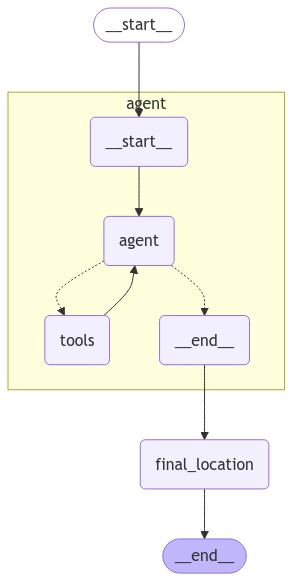

In [23]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))
